In [1]:
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm 
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation
import json
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MultiLabelBinarizer
import time
from scipy import stats
from scipy.spatial import distance
#import chime
#import ijson

from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import PredefinedKFold, GridSearchCV

import psycopg2
from pymongo import MongoClient

import gc

from funk_svd import SVD 
import tensorflow as tf

import os
from IPython.display import Image, HTML
pd.set_option('display.max_colwidth', -1)

import scipy

C:\Users\Administrator\AppData\Local\Temp\ipykernel_4680\1525892007.py:38: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


# Data Load

In [2]:
client = MongoClient(host='10.10.224.28',
                     port=27017,
                     username='vida',
                     password='qwer123$')

db_datamart = client['datamart']

In [3]:
#collection = db_datamart['dm_orderseries']
#temp = collection.find()
#dataframe_orderseries = DataFrame(temp)

In [4]:
dataframe_orderseries = pd.read_csv('../데이터 추출/BD/orderseries/BD_주문시계열_20220901_20220306.csv')

C:\Users\Administrator\AppData\Local\Temp\ipykernel_4680\1236988510.py:1: DtypeWarning: Columns (25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframe_orderseries = pd.read_csv('../데이터 추출/BD/orderseries/BD_주문시계열_20220901_20220306.csv')


In [5]:
#collection = db_datamart['dm_merchandise']
#temp = collection.find({'productId': {'$in' : list(dataframe_orderseries['productId'])}})
#dataframe_merchandise = DataFrame(temp)

In [6]:
productid = tuple(dataframe_orderseries.loc[dataframe_orderseries['productId'].apply(lambda x : len(str(x).split('_')) <= 1),
                          'productId'].astype(int).unique())

In [7]:
collection = db_datamart['dm_buyer']
temp = collection.find()
dataframe_buyer = DataFrame(temp)

In [8]:
brand_favorite = {"SQL" : "select tfb.\"brand\"" + (
                  ", tfb.\"buyer\"") + (
                  ", tfb.\"created_at\" at time zone 'Asia/Seoul'") + (
                  " from tb_favorite_brand tfb"),
            "columns" : ['brandId','buyerId','yeramon']}

In [9]:
collection = db_datamart['dm_seller']
temp = collection.find()
dataframe_seller = DataFrame(temp)

In [10]:
brand_favorite = {"SQL" : "select tfb.\"brand\"" + (
                  ", tfb.\"buyer\"") + (
                  ", tfb.\"created_at\" at time zone 'Asia/Seoul'") + (
                  " from tb_favorite_brand tfb"),
            "columns" : ['brandId','buyerId','yeramon']}

In [11]:
products = {"SQL" : "select id" + (
                  ", \"name\"->'ko'") + (
                  ", \"appImages\"") + (
                  ", \"data\"") + (
                  ", \"brand\"") + (
                  ", \"createdAt\" at time zone 'Asia/Seoul'") + (
                  " from products where ") + (
                  f"id in {productid}"),
            "columns" : ['productId','name','images','SKUdata','brand','createdAt']}

In [12]:
conn = psycopg2.connect("host=restore.cy1gcw3mvrbf.ap-northeast-2.rds.amazonaws.com port=5432 user=linkshops password=$dpdlvmflf4 dbname=linkshops")

curs = conn.cursor()

In [13]:
curs.execute(products['SQL'])
dataframe_merchandise = DataFrame(curs)
dataframe_merchandise.columns = products['columns']

In [14]:
curs.execute(brand_favorite['SQL'])
dataframe_favorite = DataFrame(curs)
dataframe_favorite.columns = brand_favorite['columns']
conn.close()

In [15]:
wishes = {"SQL" : "select wis.\"brandId\"" + (
                  ", \"userId\"") + (
                  ", \"productId\"") + (
                  ", \"createdAt\"") + (
                  " from wishes wis where ") + (
                  "wis.status = 100 "),
            "columns" : ['brandId','buyerId','productId', 'createdAt']}

In [16]:
conn = psycopg2.connect("host=restore.cy1gcw3mvrbf.ap-northeast-2.rds.amazonaws.com port=5432 user=linkshops password=$dpdlvmflf4 dbname=linkshops")

curs = conn.cursor()

In [17]:
curs.execute(wishes['SQL'])
dataframe_wishes = DataFrame(curs)
dataframe_wishes.columns = wishes['columns']
conn.close()

In [18]:
merchandise = dataframe_merchandise.copy()
favorite = dataframe_favorite.copy()

In [19]:
def type_extractor(x, types, recursive=None):
    try:
        if recursive is None:
            return x[0][types]
        else:
            return type_extractor([x[0][types]],
                                  types=recursive)
    except:
        return 'NaN'

In [20]:
'''
merchandise['category'] = \
merchandise['SKUdata'].apply(lambda x : type_extractor(
                                                    type_extractor([x], 
                                                                   'data', 
                                                                   recursive='categoryPath'),
                                                    'en'))
'''
merchandise['category'] = \
merchandise['SKUdata'].apply(lambda x : type_extractor(type_extractor([x], 'categoryPath'), 'en'))


merchandise['brandId'] = merchandise['brand'].apply(lambda x : type_extractor([x], 'id'))

merchandise['cat_0'] = merchandise['category'].apply(lambda x : x[0])
merchandise['cat_1'] = merchandise['category'].apply(lambda x : x[1] if len(x) > 2 else None)
merchandise['cat_2'] = merchandise['category'].apply(lambda x : x[2] if len(x) > 2 else None)

merchandise['images'] = \
merchandise['images'].apply(lambda x : type_extractor(type_extractor([x], 
                                                                      'default'),
                                                      'url'))
    
#merchandise['prodName'] = merchandise['SKUdata'].apply(lambda x : type_extractor([x], 'name', recursive = 'ko'))

merchandise = merchandise.rename({'name' : 'prodName'}, axis = 1)
merchandise = merchandise.astype({'productId' : str})

merchandise_reduced = merchandise[['productId','images','prodName','cat_0','cat_1','cat_2']]

merchandise_reduced = merchandise_reduced.drop_duplicates()

orderseries_merchandise = \
pd.merge(dataframe_orderseries,
         merchandise_reduced,
         on = 'productId',
        how = 'inner')

# DataEDA

## 고객군 클러스터링

### (1) favorite_brand 기반 고객군 클러스터링

우리 고객을 인간지능으로 쓰자

B2B인 우리 서비스 특성상 비슷한 스타일의 브랜드를 추가했을 확률이 크다

**가설 : 유저-브랜드 행렬을 클러스터링 할 경우 유사한 브랜드끼리 묶일것이다.**

In [133]:
del merchandise_reduced, merchandise
gc.collect()

176928

#### 모든 바이어 - 모든 브랜드 활용

In [30]:
favorite['value'] = 1

favorite_pivot = \
favorite[['brandId','buyerId','value']].pivot_table(index = 'buyerId',
                                                      columns = 'brandId',
                                                     values = 'value')
favorite_pivot = favorite_pivot.reset_index()

favorite_pivot = favorite_pivot.fillna(0)

In [23]:
favorite_pivot.shape

(54864, 10432)

10431 차원으로 지나치게 Sparse하다.

될까 이게?

In [24]:
u,s,v = np.linalg.svd(favorite_pivot.iloc[:,1:].to_numpy(), 
                      full_matrices = False)

In [25]:
energy_where = np.max(np.where(s.cumsum() / s.sum() < 0.9))

특이값의 총합, 즉 에너지가 90%가 넘는 지점의 축을 도출한다.

In [26]:
print(energy_where)

5678


위에서 도출한 값을 토대로 상위 53개 특이값에 해당하는 축들을 뽑아 재조합한다.

In [27]:
order_matrix_reconstruct = np.dot(u[:,0:energy_where], 
                                  np.dot(np.diag(s[0:energy_where]), 
                                         v[0:energy_where]))

In [28]:
del u,s,v,
#del favorite_pivot
gc.collect()

0

In [31]:
def visualize_elbowmethod(data, param_init='random', param_n_init=10, param_max_iter=300):
    distortions = []
    for i in range(1, 20):
        km = KMeans(n_clusters=i, init=param_init, n_init=param_n_init, max_iter=param_max_iter, random_state=42)
        km.fit(data)
        distortions.append(km.inertia_)
    return distortions

In [32]:
elbows = visualize_elbowmethod(order_matrix_reconstruct)

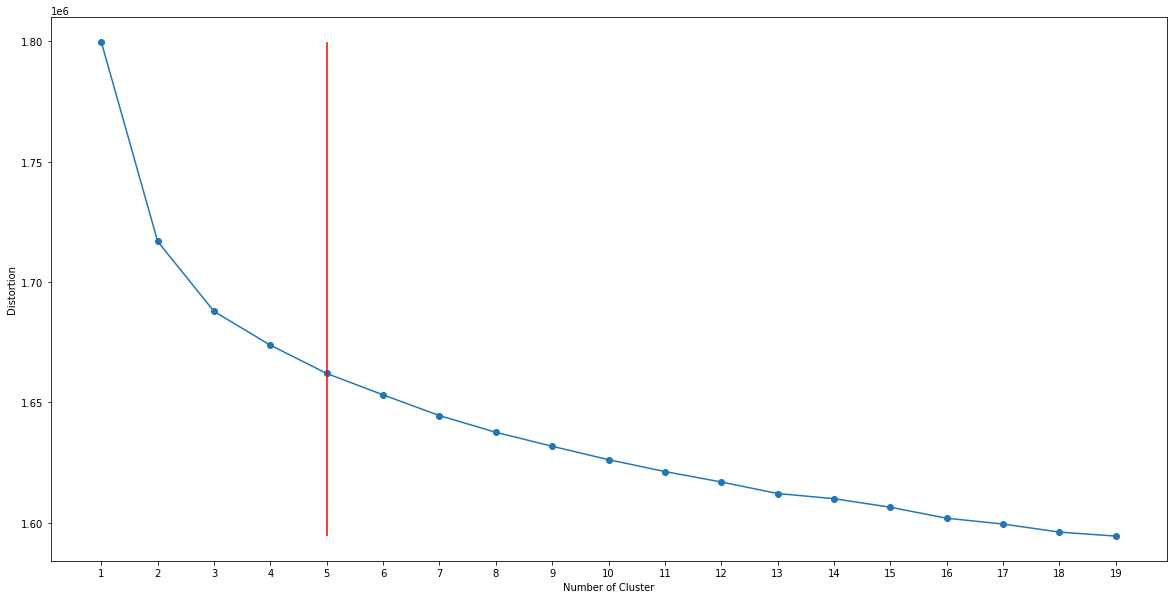

In [33]:
plt.figure(figsize = (20,10))
plt.plot(range(1, 20), elbows, marker='o')
plt.xlabel('Number of Cluster')
plt.ylabel('Distortion')
plt.xticks(range(0,20))
plt.vlines(5, ymin = min(elbows), ymax = max(elbows), color = 'red')
plt.show()

In [34]:
def compute_bic(kmeans,X):
    """
    Computes the BIC metric for a given clusters

    Parameters:
    -----------------------------------------
    kmeans:  List of clustering object from scikit learn

    X     :  multidimension np array of data points

    Returns:
    -----------------------------------------
    BIC value
    """
    # assign centers and labels
    centers = [kmeans.cluster_centers_]
    labels  = kmeans.labels_
    #number of clusters
    m = kmeans.n_clusters
    # size of the clusters
    n = np.bincount(labels)
    #size of data set
    N, d = X.shape

    #compute variance for all clusters beforehand
    cl_var = (1.0 / (N - m) / d) * sum([sum(distance.cdist(X.iloc[labels == i], [centers[0][i]], 
             'euclidean')**2) for i in range(m)])

    const_term = 0.5 * m * np.log(N) * (d+1)

    BIC = np.sum([n[i] * np.log(n[i]) -
               n[i] * np.log(N) -
             ((n[i] * d) / 2) * np.log(2*np.pi*cl_var) -
             ((n[i] - 1) * d/ 2) for i in range(m)]) - const_term

    return(BIC)

In [35]:
kmeans = [KMeans(n_clusters = i).fit(DataFrame(order_matrix_reconstruct)) for i in range(1,20)]

bic = [compute_bic(kmeansi, DataFrame(order_matrix_reconstruct)) for kmeansi in kmeans]

KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt: 


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt: 


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt: 

KeyboardInterrupt



In [ ]:
plt.figure(figsize = (20,10))
plt.plot(bic)
plt.xticks(range(1,20))
plt.vlines(5, ymin = min(bic), ymax = max(bic), color = 'red')
plt.show()

In [36]:
kmeans = KMeans(n_clusters = 5, random_state=42)

In [37]:
cluster = kmeans.fit_predict(order_matrix_reconstruct)

In [38]:
Series(cluster).value_counts()

4    45368
2     7192
0     1072
1     1031
3      201
dtype: int64

In [39]:
favorite_pivot_cluster = favorite_pivot.copy()

In [40]:
favorite_pivot_cluster['cluster_kmeans'] = cluster

In [42]:
cluster_0 = favorite_pivot_cluster[
    favorite_pivot_cluster['cluster_kmeans'] == 0].iloc[:,1:-1]

cluster_0_power = pd.merge(Series(cluster_0.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster_0.cumsum().iloc[-1,:] / cluster_0.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_0_power = \
pd.merge(cluster_0_power.reset_index(),
         dataframe_seller[['brandId','name']])

cluster_0_power[cluster_0_power['power'] > 0.5]

brandId  frequency     power       name
0     5119      715.0  0.666978       마요네즈
1     8713      663.0  0.618470        플랜티
2     5229      594.0  0.554104         라비
3     5341      589.0  0.549440         코쿤
4      555      579.0  0.540112   ahoy 아호이
5    11387      572.0  0.533582  세러데이(먼데이)
6    10459      559.0  0.521455        스칼렛
7     8876      554.0  0.516791       아이보리
8     9400      550.0  0.513060         노이
9    10707      548.0  0.511194      아이마이미

In [43]:
cluster_0 = favorite_pivot_cluster[
    favorite_pivot_cluster['cluster_kmeans'] == 1].iloc[:,1:-1]

cluster_0_power = pd.merge(Series(cluster_0.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster_0.cumsum().iloc[-1,:] / cluster_0.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_0_power = \
pd.merge(cluster_0_power.reset_index(),
         dataframe_seller[['brandId','name']])

cluster_0_power[cluster_0_power['power'] > 0.5]

brandId  frequency     power            name
0       683      838.0  0.812803             아이유
1     12081      715.0  0.693501        (주)지엔어패럴
2     15311      679.0  0.658584            어그먼트
3     10707      670.0  0.649855           아이마이미
4      5119      633.0  0.613967            마요네즈
5      5337      603.0  0.584869              두잇
6     12637      584.0  0.566440              로잉
7      6207      583.0  0.565470             티엔씨
8      6129      575.0  0.557711             와이낫
9      9540      574.0  0.556741       디어제이 BY민짱
10    15259      569.0  0.551891      더망고(바게트몽) 
11      555      563.0  0.546072        ahoy 아호이
12     6044      560.0  0.543162    더블엠(DOUBLEM)
13    16316      553.0  0.536372  더니즈(THE NEEDS)
14    16874      549.0  0.532493    보네르(bonheur)
15    14588      538.0  0.521823           제이앨리스
16    15755      527.0  0.511154             선데이
17     8876      523.0  0.507274            아이보리
18    12510      519.0  0.503395            드레스룸
19    12187      517.0  0.501455             마이영

In [47]:
cluster_0 = favorite_pivot_cluster[
    favorite_pivot_cluster['cluster_kmeans'] == 2].iloc[:,1:-1]

cluster_0_power = pd.merge(Series(cluster_0.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster_0.cumsum().iloc[-1,:] / cluster_0.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_0_power = \
pd.merge(cluster_0_power.reset_index(),
         dataframe_seller[['brandId','name']])

cluster_0_power[cluster_0_power['power'] > 0.5]

Empty DataFrame
Columns: [brandId, frequency, power, name]
Index: []

In [45]:
cluster_0 = favorite_pivot_cluster[
    favorite_pivot_cluster['cluster_kmeans'] == 3].iloc[:,1:-1]

cluster_0_power = pd.merge(Series(cluster_0.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster_0.cumsum().iloc[-1,:] / cluster_0.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_0_power = \
pd.merge(cluster_0_power.reset_index(),
         dataframe_seller[['brandId','name']])

cluster_0_power[cluster_0_power['power'] > 0.5]

brandId  frequency     power              name
0       5119      190.0  0.945274              마요네즈
1      10707      182.0  0.905473             아이마이미
2       9540      176.0  0.875622         디어제이 BY민짱
3      12081      176.0  0.875622          (주)지엔어패럴
4        683      174.0  0.865672               아이유
..       ...        ...       ...               ...
199     8368      101.0  0.502488               어워드
200     6827      101.0  0.502488                허니
201     8375      101.0  0.502488              데이시크
202    11852      101.0  0.502488  아워모먼트 Our moment
203    15514      101.0  0.502488               엔돌핀

[204 rows x 4 columns]

In [29]:
csm_total = cosine_similarity(order_matrix_reconstruct)

In [51]:
def user_user_factorization(df, ind, csm, k, verbose = False):
    if verbose:
        id_where = int(np.where(df.columns == 'buyerId')[0])
        print('<1. cosine similarity>')
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            print(f'userID : {df.iloc[num, id_where]} - ', csm[ind][num])
        print('\n')
        print("<2. Top - K user's Category list>")
        print(f'target - {df.iloc[ind, id_where]}',
              set(df.columns[np.where(df.iloc[ind] > 0)]).difference(['buyerId']))
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            print(f'UserID - {df.iloc[num, id_where]}',
                  set(df.columns[np.where(df.iloc[num] > 0)]).difference(['buyerId']))
        print('\n')
        print("<3. Top - K User's intersection List>")
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            print(f'UserID - {df.iloc[num, id_where]}',
            set(df.columns[np.where(df.iloc[ind] > 0)]).intersection(
            set(df.columns[np.where(df.iloc[num] > 0)])).difference(['buyerId']))
        print('\n')
        print("<4. Top - K User's difference List>")
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            print(f'UserID - {df.iloc[num, id_where]}',
            set(df.columns[np.where(df.iloc[num] > 0)]).difference(
            set(df.columns[np.where(df.iloc[ind] > 0)])).difference(['buyerId']))
        print('\n')
        print("<5. Top - K User's Product List>")
        print(f'target - {df.iloc[ind, id_where]}', "\n")
        display(orderseries_merchandise[orderseries_merchandise['buyerId'] == df.iloc[ind,0]][['prodName',
                                                                                               'brandId',
                                                                                               'brandName',
                                                                                              'cat_0',
                                                                                              'cat_1',
                                                                                              'cat_2']].drop_duplicates())
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            print(f'UserID - {df.iloc[num, id_where]}',"\n")
            display(orderseries_merchandise[orderseries_merchandise['buyerId'] == df.iloc[num,0]][['prodName',
                                                                                              'brandId',
                                                                                              'brandName',
                                                                                              'cat_0',
                                                                                              'cat_1',
                                                                                              'cat_2']].drop_duplicates())
    return np.sort(csm[ind])[-k:-1]

In [64]:
ind = np.random.randint(0, favorite_pivot.shape[0])

In [65]:
user_user_factorization(favorite_pivot, 
                        ind, 
                        csm_total,
                        3, 
                        verbose = True)

<1. cosine similarity>
userID : 158945 -  0.484035214561655
userID : 82068 -  0.4197942649915564


<2. Top - K user's Category list>
target - 117816 {5451, 8780, 17007, 16848, 11795, 11156, 10941}
UserID - 158945 {16848, 10941, 10422}
UserID - 82068 {11156}


<3. Top - K User's intersection List>
UserID - 158945 {16848, 10941}
UserID - 82068 {11156}


<4. Top - K User's difference List>
UserID - 158945 {10422}
UserID - 82068 set()


<5. Top - K User's Product List>
target - 117816 



Empty DataFrame
Columns: [prodName, brandId, brandName, cat_0, cat_1, cat_2]
Index: []

UserID - 158945 



Empty DataFrame
Columns: [prodName, brandId, brandName, cat_0, cat_1, cat_2]
Index: []

UserID - 82068 



Empty DataFrame
Columns: [prodName, brandId, brandName, cat_0, cat_1, cat_2]
Index: []

array([0.41979426, 0.48403521])

**전체 매트릭스를 다 활용하는 방법은 메모리 한계때문에 기각한다**

#### 최근 판매이력이 존재하는 브랜드만 추출

In [30]:
favorite['value'] = 1

favorite = pd.merge(favorite,
         orderseries_merchandise['brandId'].drop_duplicates())

favorite = pd.merge(favorite,
         orderseries_merchandise['buyerId'].drop_duplicates())

In [31]:
favorite_pivot = \
favorite[['brandId','buyerId','value']].pivot_table(index = 'buyerId',
                                                      columns = 'brandId',
                                                     values = 'value')
favorite_pivot = favorite_pivot.reset_index()

favorite_pivot = favorite_pivot.fillna(0)

In [27]:
plt.figure(figsize = (20,10))
temp = favorite_pivot.iloc[:,1:].sum(axis = 1)
Series(temp).hist(bins = 500)
#plt.xticks(range(0,100,5))
plt.show()

In [28]:
plt.figure(figsize = (20,10))
temp = np.log1p(favorite_pivot.iloc[:,1:].sum(axis = 1))
Series(temp).hist(bins = 500)
#plt.xticks(range(0,100,5))
plt.show()

다음의 식으로 변환한 값의 히스토그램이다

$$ score = log({X_{i}}) $$

바로 위 변환 수식을 지수변환하여 저점수 / 고점수간 계급값 차이를 극대화한다

In [33]:
favorite_pivot['values'] = np.log1p(favorite_pivot.iloc[:,1:].sum(axis = 1))

In [24]:
favorite_pivot['values'].describe()

count    6483.000000
mean     2.967833   
std      1.374565   
min      0.693147   
25%      1.945910   
50%      2.995732   
75%      4.007333   
max      7.428927   
Name: values, dtype: float64

In [36]:
plt.figure(figsize = (20,10))
plt.hist(favorite_pivot['values'], bins = 500)
plt.xticks([i for i in range(0, 220, 1)] + [1.3])
plt.vlines([1,1.3,2], ymin = 0, ymax = 300, color = 'red')
plt.show()

In [25]:
(favorite_pivot['values'] >= 1.3).value_counts()

True     5618
False    865 
Name: values, dtype: int64

In [34]:
favorite_pivot = favorite_pivot[favorite_pivot['values'] >= 1.3]
favorite_pivot = favorite_pivot.drop(['values'], axis = 1)

In [35]:
favorite_pivot_t = favorite_pivot.iloc[:,1:].T

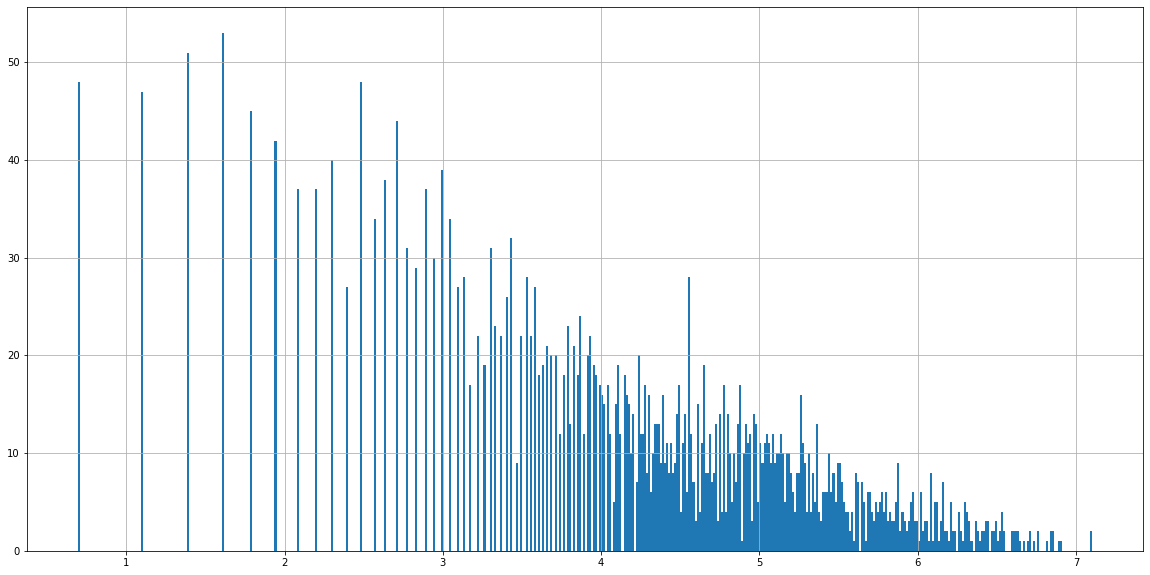

In [36]:
plt.figure(figsize = (20,10))
temp = np.log1p(favorite_pivot_t.iloc[:,1:].sum(axis = 1))
Series(temp).hist(bins = 500)
#plt.xticks(range(0,100,5))
plt.show()

In [37]:
favorite_pivot_t['values'] = np.log1p(favorite_pivot_t.sum(axis = 1))

In [39]:
plt.figure(figsize = (20,10))
plt.hist(favorite_pivot_t['values'], bins = 500)
#plt.xticks(range(0, 220, 10))
plt.vlines([1,2,5], ymin = 0, ymax = 10, color = 'red')
plt.show()

In [42]:
(favorite_pivot_t['values'] >= 2).value_counts()

True     2664
False    286 
Name: values, dtype: int64

In [28]:
favorite_pivot_t = favorite_pivot_t[(favorite_pivot_t['values'] >= 2) & (favorite_pivot_t['values'] < 5)]

In [29]:
favorite_pivot = pd.concat([favorite_pivot['buyerId'],
            favorite_pivot_t.T.drop('values')],
         axis = 1)

In [30]:
a = (favorite_pivot.iloc[:,1:] == 0).apply(lambda x : x.value_counts())

1 - np.sum(a.loc[False]) / np.sum(a.loc[True])

0.9880507169524602

##### SVD 행렬분해 후 90% 에너지 재조합

In [31]:
u,s,v = np.linalg.svd(favorite_pivot.iloc[:,1:].to_numpy(), full_matrices = False)

#특이값의 총합, 즉 에너지가 90%가 넘는 지점의 축을 도출한다.

energy_where = np.max(np.where(s.cumsum() / s.sum() < 0.9))

#위에서 도출한 값을 토대로 상위 53개 특이값에 해당하는 축들을 뽑아 재조합한다.
print(energy_where)
order_matrix_reconstruct = np.dot(u[:,0:energy_where], np.dot(np.diag(s[0:energy_where]), v[0:energy_where]))


1354


클러스터링을 진행하기엔 데이터가 지나치게 sparse하다

In [213]:
def visualize_elbowmethod(data, param_init='random', param_n_init=10, param_max_iter=300):
    distortions = []
    for i in range(1, 20):
        km = KMeans(n_clusters=i, init=param_init, n_init=param_n_init, max_iter=param_max_iter, random_state=42)
        km.fit(data)
        distortions.append(km.inertia_)
    return distortions

In [214]:
elbows = visualize_elbowmethod(order_matrix_reconstruct)

In [215]:
plt.figure(figsize = (20,10))
plt.plot(range(1, 20), elbows, marker='o')
plt.xlabel('Number of Cluster')
plt.ylabel('Distortion')
plt.xticks(range(0,20))
plt.vlines(5, ymin = min(elbows), ymax = max(elbows), color = 'red')
plt.show()

In [216]:
def compute_bic(kmeans,X):
    """
    Computes the BIC metric for a given clusters

    Parameters:
    -----------------------------------------
    kmeans:  List of clustering object from scikit learn

    X     :  multidimension np array of data points

    Returns:
    -----------------------------------------
    BIC value
    """
    # assign centers and labels
    centers = [kmeans.cluster_centers_]
    labels  = kmeans.labels_
    #number of clusters
    m = kmeans.n_clusters
    # size of the clusters
    n = np.bincount(labels)
    #size of data set
    N, d = X.shape

    #compute variance for all clusters beforehand
    cl_var = (1.0 / (N - m) / d) * sum([sum(distance.cdist(X.iloc[labels == i], [centers[0][i]], 
             'euclidean')**2) for i in range(m)])

    const_term = 0.5 * m * np.log(N) * (d+1)

    BIC = np.sum([n[i] * np.log(n[i]) -
               n[i] * np.log(N) -
             ((n[i] * d) / 2) * np.log(2*np.pi*cl_var) -
             ((n[i] - 1) * d/ 2) for i in range(m)]) - const_term

    return(BIC)

In [217]:
kmeans = [KMeans(n_clusters = i).fit(DataFrame(order_matrix_reconstruct)) for i in range(1,20)]

bic = [compute_bic(kmeansi, DataFrame(order_matrix_reconstruct)) for kmeansi in kmeans]

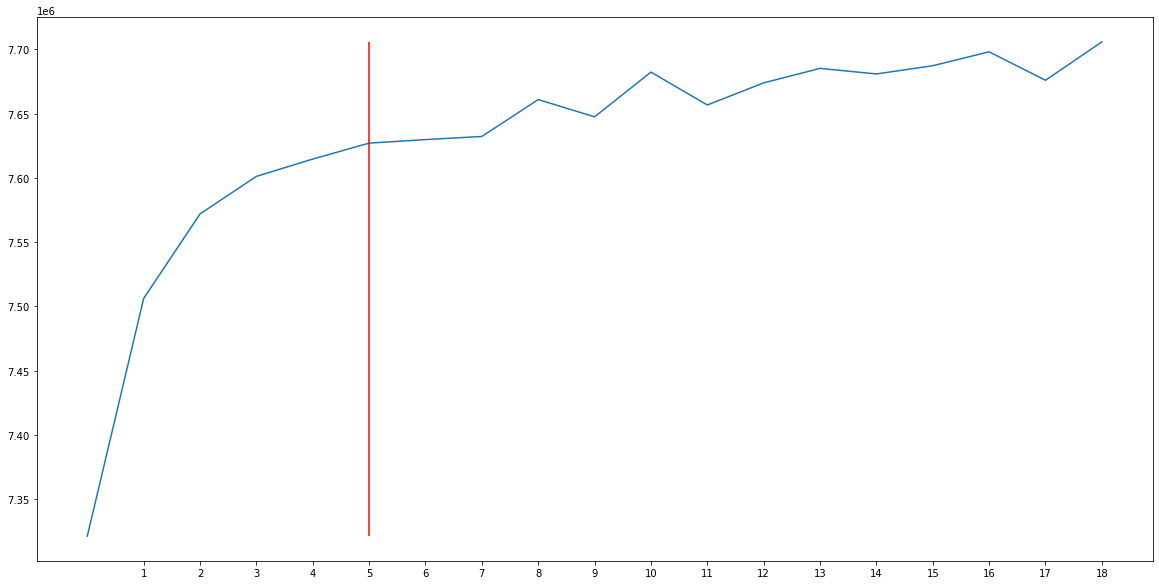

In [218]:
plt.figure(figsize = (20,10))
plt.plot(bic)
plt.xticks(range(1,20))
plt.vlines(5, ymin = min(bic), ymax = max(bic), color = 'red')
plt.show()

In [219]:
kmeans = KMeans(n_clusters = 6, random_state=42)

In [220]:
cluster = kmeans.fit_predict(order_matrix_reconstruct)

In [221]:
Series(cluster).value_counts()

5    3905
4    399 
3    121 
1    44  
2    9   
0    2   
dtype: int64

In [227]:
favorite_pivot_cluster = favorite_pivot.copy()

In [228]:
favorite_pivot_cluster['cluster_kmeans'] = cluster

In [229]:
cluster_0 = favorite_pivot_cluster[
    favorite_pivot_cluster['cluster_kmeans'] == 0].iloc[:,1:-1]

cluster_0_power = pd.merge(Series(cluster_0.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster_0.cumsum().iloc[-1,:] / cluster_0.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_0_power = \
pd.merge(cluster_0_power.reset_index().rename({'index' : 'brandId'}, axis = 1),
         dataframe_seller[['brandId','name']])

cluster_0_power[cluster_0_power['power'] > 0.1]

brandId  frequency  power        name
0    18870    2.0        1.0    헬로        
1    16106    2.0        1.0    박하        
2    4225     2.0        1.0    merci 메르시 
3    11011    2.0        1.0    캔디        
4    18715    2.0        1.0    샤이나       
..     ...    ...        ...    ...       
280  13891    1.0        0.5    뵈뵈        
281  16154    1.0        0.5    인투        
282  16413    1.0        0.5    러브잇       
283  459      1.0        0.5    n.shop(엔샵)
284  5624     1.0        0.5    오후스튜디오    

[285 rows x 4 columns]

In [434]:
cluster_0.loc[:,cluster_0_power[cluster_0_power['power'] > 0.8]['brandId'].values]

brandId  6207   5119   683    12877  5337   16874  12081  9540   12970  7595   \
68         1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   
73         1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   
86         1.0    1.0    1.0    0.0    1.0    1.0    1.0    1.0    1.0    1.0   
106        1.0    1.0    1.0    0.0    1.0    1.0    0.0    1.0    1.0    1.0   
155        1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    0.0   
173        1.0    1.0    1.0    1.0    1.0    0.0    1.0    0.0    0.0    0.0   
231        1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   
308        1.0    1.0    1.0    1.0    0.0    1.0    1.0    1.0    1.0    1.0   
344        1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   
422        1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   
452        1.0    1.0    1.0    1.0    1.0    0.0    1.0    1.0    1.0    0.0   
585        1.0    1.0    1.0    1.0    1.0    1.0    0.0    0.0    1.0    1.0   
728        1.0    1.0    1.0    1.0    0.0    1.0    1.0    1.0    1.0    1.0   
740        0.0    0.0    0.0    1.0    1.0    1.0    1.0    1.0    0.0    1.0   
826        1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   
834        1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   
1036       1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   
1038       1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   
1050       1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   
1096       1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   
1102       1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   
1176       1.0    0.0    1.0    1.0    1.0    1.0    1.0    0.0    1.0    1.0   
1189       1.0    1.0    1.0    0.0    0.0    1.0    1.0    1.0    0.0    0.0   
1274       1.0    1.0    1.0    1.0    1.0    1.0    1.0    0.0    1.0    1.0   
1387       1.0    1.0    0.0    1.0    0.0    1.0    1.0    1.0    1.0    0.0   
1399       1.0    1.0    1.0    1.0    1.0    1.0    0.0    1.0    1.0    1.0   
1421       1.0    1.0    1.0    1.0    1.0    0.0    1.0    1.0    1.0    1.0   
1438       1.0    1.0    0.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   
1525       1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   
1535       1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   
1701       1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   
1848       1.0    1.0    1.0    1.0    1.0    1.0    0.0    1.0    1.0    1.0   
2108       1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   
2175       1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   
2298       0.0    1.0    1.0    1.0    1.0    0.0    1.0    1.0    0.0    1.0   
2671       1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   

brandId  ...  2186   16150  16316  14588  13020  15311  6044   7387   12065  \
68       ...    1.0    1.0    1.0    1.0    0.0    1.0    1.0    1.0    1.0   
73       ...    1.0    0.0    0.0    1.0    1.0    0.0    1.0    1.0    1.0   
86       ...    1.0    1.0    0.0    1.0    1.0    1.0    0.0    1.0    0.0   
106      ...    1.0    1.0    1.0    1.0    1.0    0.0    1.0    1.0    0.0   
155      ...    0.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    0.0   
173      ...    1.0    1.0    0.0    0.0    0.0    0.0    1.0    1.0    0.0   
231      ...    0.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   
308      ...    1.0    0.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   
344      ...    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   
422      ...    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   
452      ...    1.0    1.0    1.0    1.0    0.0    0.0    1.0    1.0    1.0   
585      ...    1.0    0.0    1.0    1.0    1.0    1.0

In [230]:
cluster_1 = favorite_pivot_cluster[
    favorite_pivot_cluster['cluster_kmeans'] == 1].iloc[:,1:-1]

cluster_1_power = pd.merge(Series(cluster_1.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster_1.cumsum().iloc[-1,:] / cluster_1.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_1_power = \
pd.merge(cluster_1_power.reset_index().rename({'index' : 'brandId'}, axis = 1),
         dataframe_seller[['brandId','name']])

cluster_1_power[cluster_1_power['power'] > 0.5]

brandId  frequency     power             name
0  2051     30.0       0.681818  오엔엘(ONL)       
1  14757    27.0       0.613636  제이밍            
2  10485    25.0       0.568182  엠블루            
3  6827     25.0       0.568182  허니             
4  2063     24.0       0.545455  wednesday(웬즈데이)
5  16102    24.0       0.545455  마인디            
6  16211    24.0       0.545455  우드             
7  10723    24.0       0.545455  룰루랄라           
8  17307    24.0       0.545455  유하             
9  46       23.0       0.522727  Shirring

In [231]:
cluster_2 = favorite_pivot_cluster[
    favorite_pivot_cluster['cluster_kmeans'] == 2].iloc[:,1:-1]

cluster_2_power = pd.merge(Series(cluster_2.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster_2.cumsum().iloc[-1,:] / cluster_2.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_2_power = \
pd.merge(cluster_2_power.reset_index().rename({'index' : 'brandId'}, axis = 1),
         dataframe_seller[['brandId','name']])

cluster_2_power[cluster_2_power['power'] > 0.5]

brandId  frequency     power                 name
0    8582     9.0        1.000000  더끌림                
1    7548     9.0        1.000000  스타일핑크              
2    600      9.0        1.000000  style_theot 스타일    
3    16211    9.0        1.000000  우드                 
4    11220    9.0        1.000000  루나                 
..     ...    ...             ...  ..                 
374  6377     5.0        0.555556  가네샤                
375  7412     5.0        0.555556  덴버                 
376  5573     5.0        0.555556  이너프                
377  160      5.0        0.555556  BLACKRIBBON 블랙리본   
378  420      5.0        0.555556  앨리스클로젯(alicecloset)

[379 rows x 4 columns]

In [232]:
cluster_2.loc[:,cluster_2_power[cluster_2_power['power'] > 0.5]['brandId'].values]

8582  7548  600  16211  11220  554  10429  8769  8837  661  ...  7712  \
411   1.0   1.0   1.0  1.0    1.0    1.0  1.0    1.0   1.0   1.0  ...  0.0    
649   1.0   1.0   1.0  1.0    1.0    1.0  1.0    1.0   1.0   1.0  ...  1.0    
1342  1.0   1.0   1.0  1.0    1.0    1.0  1.0    1.0   1.0   1.0  ...  1.0    
1681  1.0   1.0   1.0  1.0    1.0    1.0  1.0    0.0   1.0   1.0  ...  0.0    
2045  1.0   1.0   1.0  1.0    1.0    1.0  1.0    1.0   1.0   1.0  ...  1.0    
2134  1.0   1.0   1.0  1.0    1.0    1.0  1.0    1.0   1.0   1.0  ...  1.0    
2354  1.0   1.0   1.0  1.0    1.0    1.0  1.0    1.0   1.0   1.0  ...  1.0    
2549  1.0   1.0   1.0  1.0    1.0    1.0  1.0    1.0   0.0   1.0  ...  0.0    
3913  1.0   1.0   1.0  1.0    1.0    1.0  1.0    1.0   1.0   0.0  ...  0.0    

      5625  295  487  166  6377  7412  5573  160  420  
411   1.0   0.0  1.0  1.0  1.0   1.0   1.0   1.0  0.0  
649   1.0   1.0  1.0  0.0  1.0   1.0   1.0   1.0  0.0  
1342  1.0   1.0  1.0  1.0  1.0   0.0   1.0   0.0  1.0  
1681  0.0   0.0  0.0  0.0  0.0   0.0   1.0   0.0  0.0  
2045  1.0   1.0  1.0  1.0  0.0   0.0   0.0   0.0  0.0  
2134  0.0   1.0  1.0  1.0  1.0   1.0   0.0   1.0  1.0  
2354  0.0   0.0  0.0  1.0  0.0   1.0   0.0   1.0  1.0  
2549  0.0   0.0  0.0  0.0  0.0   0.0   1.0   0.0  1.0  
3913  1.0   1.0  0.0  0.0  1.0   1.0   0.0   1.0  1.0  

[9 rows x 379 columns]

In [233]:
cluster_3 = favorite_pivot_cluster[
    favorite_pivot_cluster['cluster_kmeans'] == 3].iloc[:,1:-1]

cluster_3_power = pd.merge(Series(cluster_3.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster_3.cumsum().iloc[-1,:] / cluster_3.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_3_power = \
pd.merge(cluster_3_power.reset_index().rename({'index' : 'brandId'}, axis = 1),
         dataframe_seller[['brandId','name']])

cluster_3_power[cluster_3_power['power'] > 0.5]

Empty DataFrame
Columns: [brandId, frequency, power, name]
Index: []

In [234]:
cluster_4 = favorite_pivot_cluster[
    favorite_pivot_cluster['cluster_kmeans'] == 4].iloc[:,1:-1]

cluster_4_power = pd.merge(Series(cluster_4.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster_4.cumsum().iloc[-1,:] / cluster_4.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_4_power = \
pd.merge(cluster_4_power.reset_index().rename({'index' : 'brandId'}, axis = 1),
         dataframe_seller[['brandId','name']])

cluster_4_power[cluster_4_power['power'] > 0.5]

Empty DataFrame
Columns: [brandId, frequency, power, name]
Index: []

##### 유저 프로파일링 - 컨텐츠 기반 필터링

In [32]:
csm_total = cosine_similarity(order_matrix_reconstruct)

In [33]:
del order_matrix_reconstruct

In [34]:
wishes = dataframe_wishes.copy()

In [35]:
wishes_reduced = \
pd.merge(wishes,
         orderseries_merchandise[['productId']].drop_duplicates().astype('int'))


wishes_reduced = wishes_reduced[['buyerId','productId']].drop_duplicates()

wishes_reduced['values'] = 1

buyerId_dict = {j : i for i,j in enumerate(wishes_reduced['buyerId'].unique())}
productId_dict = {j : i for i,j in enumerate(wishes_reduced['productId'].unique())}

wishes_reduced['buyerId'] = [buyerId_dict[i] for i in wishes_reduced['buyerId']]
wishes_reduced['productId'] = [productId_dict[i] for i in wishes_reduced['productId']]

row = np.array(wishes_reduced['productId'])
col = np.array(wishes_reduced['buyerId'])
values = np.array(wishes_reduced['values'])

In [258]:
'''
wishes = wishes[['buyerId','productId']].drop_duplicates()

wishes['values'] = 1

buyerId_dict = {j : i for i,j in enumerate(wishes['buyerId'].unique())}
productId_dict = {j : i for i,j in enumerate(wishes['productId'].unique())}

wishes['buyerId'] = [buyerId_dict[i] for i in wishes['buyerId']]
wishes['productId'] = [productId_dict[i] for i in wishes['productId']]


row = np.array(wishes['productId'])
col = np.array(wishes['buyerId'])
values = np.array(wishes['values'])
'''

In [36]:
wishes_coo = scipy.sparse.coo_matrix((values, (row, col)))

wishes_coo = wishes_coo.astype('float64')

wishes_coo = wishes_coo.toarray()

In [47]:
'''
u,s,v = np.linalg.svd(wishes_coo, full_matrices = False)

del wishes_coo
gc.collect()

#특이값의 총합, 즉 에너지가 90%가 넘는 지점의 축을 도출한다.

energy_where = np.max(np.where(s.cumsum() / s.sum() < 0.9))

#위에서 도출한 값을 토대로 상위 53개 특이값에 해당하는 축들을 뽑아 재조합한다.
print(energy_where)
print(s.shape)

wishes_coo = np.dot(u[:,0:energy_where], np.dot(np.diag(s[0:energy_where]), v[0:energy_where]))
'''

'\nu,s,v = np.linalg.svd(wishes_coo, full_matrices = False)\n\ndel wishes_coo\ngc.collect()\n\n#특이값의 총합, 즉 에너지가 90%가 넘는 지점의 축을 도출한다.\n\nenergy_where = np.max(np.where(s.cumsum() / s.sum() < 0.9))\n\n#위에서 도출한 값을 토대로 상위 53개 특이값에 해당하는 축들을 뽑아 재조합한다.\nprint(energy_where)\nprint(s.shape)\n\nwishes_coo = np.dot(u[:,0:energy_where], np.dot(np.diag(s[0:energy_where]), v[0:energy_where]))\n'

In [5]:
cosine_similarity(np.array([[1,0,0,1],[1,1,0,1],[0,0,0,0],[1,1,1,1],[0,0,0,1]]))

array([[1.        , 0.81649658, 0.        , 0.70710678, 0.70710678],
       [0.81649658, 1.        , 0.        , 0.8660254 , 0.57735027],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.70710678, 0.8660254 , 0.        , 1.        , 0.5       ],
       [0.70710678, 0.57735027, 0.        , 0.5       , 1.        ]])

In [363]:
def user_user_factorization(df, 
                            orderseries_merchandise,
                            ind, 
                            csm, 
                            k, 
                            threshold = 0.2, 
                            verbose = False,
                           columns = None ):
    
    if columns is None:
        columns = ['prodName',
                  'productId',
                  'brandId',
                  'buyerId',
                  'brandName',
                  'cat_0',
                  'cat_1',
                  'cat_2']
    
    if verbose:
        id_where = int(np.where(df.columns == 'buyerId')[0])
        print('<1. cosine similarity>')
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            if csm[ind][num] < threshold:
                continue
            print(f'userID : {df.iloc[num, id_where]} - ', csm[ind][num])
        print('\n')
        print("<2. Top - K user's Category list>")
        print(f'target - {df.iloc[ind, id_where]}',
              set(df.columns[np.where(df.iloc[ind] > 0)]).difference(['buyerId']))
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            if csm[ind][num] < threshold:
                continue
            print(f'UserID - {df.iloc[num, id_where]}',
                  set(df.columns[np.where(df.iloc[num] > 0)]).difference(['buyerId']))
        print('\n')
        print("<3. Top - K User's intersection List>")
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            if csm[ind][num] < threshold:
                continue
            print(f'UserID - {df.iloc[num, id_where]}',
            set(df.columns[np.where(df.iloc[ind] > 0)]).intersection(
            set(df.columns[np.where(df.iloc[num] > 0)])).difference(['buyerId']))
        print('\n')
        print("<4. Top - K User's difference List>")
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            if csm[ind][num] < threshold:
                continue
            print(f'UserID - {df.iloc[num, id_where]}',
            set(df.columns[np.where(df.iloc[num] > 0)]).difference(
            set(df.columns[np.where(df.iloc[ind] > 0)])).difference(['buyerId']))
        print('\n')
        print("<5. Top - K User's Product List>")
        print(f'target - {df.iloc[ind, id_where]}', "\n")
        display(orderseries_merchandise[orderseries_merchandise['buyerId'] == df.iloc[ind,0]][columns].drop_duplicates())
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            if csm[ind][num] < threshold:
                continue
            print(f'UserID - {df.iloc[num, id_where]}',"\n")
            display(orderseries_merchandise[orderseries_merchandise['buyerId'] == df.iloc[num,0]][columns].drop_duplicates())
    
    product_list = orderseries_merchandise[orderseries_merchandise['buyerId'] == df.iloc[ind,0]][columns].drop_duplicates()
    for num in np.argsort(csm[ind])[-k:-1][::-1]:
        if csm[ind][num] < threshold:
            continue
        product_list = \
        pd.concat([product_list,
                  orderseries_merchandise[orderseries_merchandise['buyerId'] == df.iloc[num,0]][columns].drop_duplicates()],
                  axis = 0).drop_duplicates()

    return np.sort(csm[ind])[-k:-1], product_list

In [364]:
def min_max_scailing(x, except_col):
    if except_col is not None:
        max_value = np.max(x.drop([except_col]))
        min_value = np.min(x.drop([except_col]))
        temp = (x.drop([except_col]) - min_value) / (max_value - min_value)
        temp = DataFrame(temp).T
        return pd.concat([DataFrame(x[[except_col]]).T, temp], axis = 1)
    else :
        max_value = np.max(x)
        min_value = np.min(x)
        temp = (x - min_value) / (max_value - min_value)
        #temp = DataFrame(temp).T
        return temp

In [365]:
def softmax_function(x):
    max_val = np.max(x)
    denominator = np.sum(np.exp(x - max_val))
    numerator = np.exp(x - max_val)
    return numerator / denominator

In [403]:
def making_image_list(df,
                      orderseries_merchandise,
                      sort_col = None,
                      size = (200,150)):

    if sort_col == None:
        sort_col = ['target_prodId',
                  'param']
    
    urls = pd.merge(orderseries_merchandise,
                    Series(df['target_prodId'].unique(), name = 'productId', dtype='str')
                    )[['productId','images']].drop_duplicates().values

    [os.system("curl http:" + i + f" > ./temp/target/{num}.jpg") for num, i in urls]
    frame_image = pd.concat([
                    DataFrame({'target_prodId' : num,
                            'img' : [f'<img src=./temp/target/{num}.jpg + \
                             style="width:{size[0]}px;height:{size[1]}px;">']}) for num, i in urls])    

    frame_image = frame_image.astype({'target_prodId' : int})

    urls = df[['target_prodId', 'images', 'productId', 'param']].dropna().values
    [os.system("curl http:" + i[1] + f" > ./temp/retrieval/{i[2]}.jpg") for num, i in enumerate(urls)]

    frame_image_temp = pd.concat([DataFrame({'target_prodId' : i[0],
                                            'img' : [f'<img src=./temp/retrieval/{i[2]}.jpg + \
                                             style="width:{size[0]}px;height:{size[1]}px;">'],
                                            'param' : i[3]}) 
                                  for num, i in enumerate(urls)])

    frame_image = pd.merge(frame_image,
                           frame_image_temp,
                          on = 'target_prodId',
                          how = 'left').sort_values(sort_col, ascending = False)
    return frame_image

In [395]:
def profiling_prepare(df, 
                      orderseries_merchandise,
                      prod_id, 
                      csm, 
                      k, 
                      sort_col = None,
                      size = (150,250), 
                      verbose = False, 
                      image = True,
                      threshold = 1,
                     columns = None):
    
    if columns is None:
        columns = ['prodName',
                   'productId',
                   'brandId',
                   'brandName',
                   'images',
                   'cat_0',
                   'cat_1',
                   'cat_2']
    
    df = df.copy()
    df['index'] = df.index
    ind_list = pd.merge(df, Series(prod_id, name = 'productId'))['index'].values
    id_where = int(np.where(df.columns == 'productId')[0])
    if verbose:
        print('<1. cosine similarity>')
        for ind in ind_list: 
            print(f'target - {df.iloc[ind, id_where]}', "\n")
            for num in np.argsort(csm[ind])[-k:-1][::-1]:
                if csm[ind][num] < threshold:
                    continue
                print(f'productID : {df.iloc[num, id_where]} - ', csm[ind][num])
       
    target_prod = pd.merge(orderseries_merchandise.astype({'productId' : int}),
                           Series(prod_id, name = 'productId'))[columns].drop_duplicates()
    
    product_list = DataFrame()
    for ind in ind_list:
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            if csm[ind][num] < threshold:
                continue
            prod_temp = orderseries_merchandise[
                            orderseries_merchandise['productId'] == str(df.iloc[num,0])][columns].drop_duplicates()
            prod_temp['target_prodId'] = df.iloc[ind, 0]
            prod_temp['param'] = csm[ind][num]

            product_list = pd.concat([product_list, prod_temp], axis = 0)
    
    if product_list.shape[0] == 0:
        print('카테고리가 일치하는 상품이 없습니다')
        return target_prod, None, None
    
    if image:
        frame_image = making_image_list(product_list, orderseries_merchandise, sort_col)
        
        return target_prod, product_list, frame_image
    
    else :
        return target_prod, product_list, None

In [397]:
def merchandise_profiling(df,
                             X_character, 
                             productId_dict,
                             k,
                             sort_col = None,
                             size = (200, 150),
                             verbose = False,
                             threshold = 0.0,
                            image = True):
    
    product_list = DataFrame()
    
    for target_id in df['target_prodId'].unique():
        df_temp = df[df['target_prodId'] == target_id]
        ind_list = list()
        for i in df_temp[df_temp['target_prodId'] == target_id]['productId'].astype('int'):
            try:
                ind_list.append(productId_dict[i])
            except :
                continue
        X_profile = DataFrame([X_character[i] for i in ind_list])
        X_profile['productId'] = [{i : j for j,i in productId_dict.items()}[k] for k in ind_list]
        
        try:
            target = X_character[productId_dict[target_id]].reshape(1,-1)
        except :
            continue
        X_gen = X_profile.iloc[:,:-1].iterrows()
        
        param = [cosine_similarity(target, i[1].to_numpy().reshape(1,-1))[0][0] for i in X_gen]
        order = np.argsort(param)[::-1][0:k]
        df_temp = df_temp.iloc[order,:]
        df_temp['param'] = np.sort(param)[::-1][0:k]
        
        product_list = pd.concat([product_list, df_temp])
    
    if image:
        frame_image = making_image_list(product_list, orderseries_merchandise, sort_col)
        return product_list, frame_image
    else :
        return target_prod, product_list, None

In [398]:
ind = np.random.randint(0, favorite_pivot.shape[0])

In [399]:
a, b = user_user_factorization(favorite_pivot, 
                        orderseries_merchandise,
                        ind, 
                        csm_total,
                        20, 
                        threshold = 0.2,
                        verbose = True)

<1. cosine similarity>
userID : 155455 -  0.645907686363229
userID : 156568 -  0.5971818979835888
userID : 125030 -  0.4813648508592725
userID : 136908 -  0.4813648508592725
userID : 159476 -  0.4813648508592725
userID : 167267 -  0.4813648508592725
userID : 155356 -  0.47830575639473855
userID : 133300 -  0.4733537006988101
userID : 139224 -  0.4733537006988101
userID : 155352 -  0.4709892769096625
userID : 160703 -  0.4688460807138557
userID : 155725 -  0.44080938646801304
userID : 144252 -  0.4365032961747257
userID : 172847 -  0.4277102710933145
userID : 173256 -  0.4186436763103348
userID : 168848 -  0.3433024339461738
userID : 140654 -  0.34319999995844475
userID : 141841 -  0.34127887027647535
userID : 152823 -  0.3397137191262356


<2. Top - K user's Category list>
target - 170956 {18220, 18776, 19689, 15018, 13068}
UserID - 155455 {18776, 13068, 19335}
UserID - 156568 {18776, 19689}
UserID - 125030 {18776}
UserID - 136908 {18776}
UserID - 159476 {18776}
UserID - 167267 {18776}

prodName productId  brandId  buyerId  brandName cat_0  \
31802   (봄신상) 피터 봄봄 무지 실내복  7154912   8569     170956   빠오빼_유아동복   KIDS   
76480   쥬얼리헤어밴드 #23봄신상lp    7153735   12888    170956   컵_유아동복     KIDS   
170062  크리스마스샤슈트            5265554   14132    170956   블랙핑크_유아동복  KIDS   
319194  #봄#주니어#아가일스커트       7148825   13082    170956   바지왕국_유아동복  KIDS   

               cat_1        cat_2  
31802   Dresses/Sets  Sets         
76480   Shoes/Acc     Accessories  
170062  Dresses/Sets  Dresses      
319194  Bottoms       Skirts

UserID - 155455 



prodName  \
5874    곰돌이꽃세트                                                             
7106    구름스마일 세트                                                           
7411    오리지널조거set                                                          
10444   마스미니ops                                                            
10851   유어베어set                                                            
11020   유어베어set                                                            
12426   미니곰워머3종셋                                                           
14249   쥬시세트                                                               
19784   패치모티브레깅스                                                           
22779   (겨울신상) 하로 앙쥬 후드 상하복 (주니어)                                          
23450   (겨울신상) 하로 앙쥬 후드 상하복                                                
24992   (겨울신상) 하로 유니버시티 기모 상하복 (주니어)                                       
25221   (겨울신상) 하로 올데이 건빵 조거 팬츠 (주니어)                                       
28670   (겨울신상) 마이베 스틱 원피스                                                  
32026   (봄신상) 하로 포틀랜드 상하 SET                                               
33031   (봄신상) HB 곰돌이 자수 상하 SET                                             
33336   (봄신상) 몽드 뉴 해피 상하 SET                                               
35727   비비드아이 (기획)비비드조거                                                    
37039   비비드아이 후리스나염고쟁이                                                     
38308   비비드아이 후리스나염고쟁이 주니어                                                 
38318   비비드아이 (기획)비비드조거 주니어                                                
38330   비비드아이 농구곰상하 주니어                                                    
38350   비비드아이 야구점퍼곰상하 주니어                                                  
61517   콤)니트원피스 주니어                                                        
61603   세일)도 티파니원피스                                                        
61745   씨)기획_슈트                                                            
63352   신상 디 공룡세트                                                          
67946   sale2023 LB 에이드 슈트                                                 
75438   체크프릴원피스 #가을신상bb                                                    
82193   22겨울  오누 기획 핀턱조거팬츠S(3~4세), M(4~5세), L(5~6세), XL(6~7세), XXL(8세이상)   
105025  주니어)데베.메리원피스                                                       
105093  a3)데일리베베.빈티지베어set                                                  
114171  our맨투맨                                                             
115669  기모뉴욕세트                                                             
161455  A3)G도트 골지ops러블리베이직모던                                               
170554  A베스트                                                               
177980  보나 리본이콕원피스                                                         
179283  주름소매원피스(쥬니어)                                                       
254551  메리크리조커팬츠                                                           
254569  루돌프맨투맨                                                             
259313  세일 두개에 만원 미들굽 장식 애나멜                                               
279395  한정수량sale. 소가죽 밍크털 키높                                               
334112  O4)마들렌기모세트                                                         
409968  신상) 아동 니트 바라클라바 모자 워머                                              
415482  창고 정리 세일 특가 SK-0064 캔버스 스니커즈 운동화                                   
491328  (초특가세일 굽높이 3.5센치) 편안하게 Ys 812-2 가볍게 심플컬러 통굽크록샌들                    
563092  sale2023)로마세트. 고미됩니다                                               

       productId  brandId  buyerId           brandName          cat_0  \
5874    7092739   10238    155455   나무2_유아동복            KIDS            
7106    7092745   10238    155455   나무2_유아동복            KIDS            
7411    7011816   10238    155455   나무2_유아동복            KIDS            
10444   7070079   10238    155455   나무2_유아동복            KIDS            
10851   7012227   10238    155455   나무2_유아동복      

UserID - 156568 



prodName productId  \
7304    러블리니트셋                                                6988207    
10325   겨울달링튜튜 치랭스                                            7088995    
21089   크림 번 티 #티셔츠                                           7072353    
28253   (가을신상) 피터 빠삐용 보넷 베이비 슈트                               6995470    
28643   (가을신상) 어썸 날라리 골지 팬츠                                   7003847    
29202   (가을신상) 피터 스텔라 샤 스커트                                   6925891    
29600   (가을신상) 피터 내일도 단가라 실내복                                 6926469    
30392   (가을신상) 피터 꾸안꾸 가디건                                     6925849    
30510   (겨울신상) MB 홀 카라 티셔츠                                    7060684    
62252   피)요정보넷베이비슈트                                           7013261    
62254   피)빠삐용 보넷 슈트                                           7013253    
62262   피)버니후드슈트                                              7013276    
62266   피)꼭지 보넷 슈트                                            7013247    
66714   (겨울신상) 슈크 로라 멜빵 원피스                                   7117215    
85435   23봄 그로아 모어MTM   S~2XL                                 7191063    
102647  데일리베베)야옹이귀마개                                          7077040    
161059  A예쁜기본핏팬츠 베이비유아동키즈쥬니어신상품원피스데님청북유럽러블리빈티지베이직모던공주옷남아옷여아옷  6983150    
161081  A모네블라우스 베이비유아동키즈쥬니어신상품원피스데님청북유럽러블리빈티지베이직모던공주옷남아옷여아옷   6982835    
178722  보나 토파즈티셔츠                                             7093216    
375445  ♤러빈\n끈나시 ₩6,000\n크림. 레몬. 브라운                          7194642    
563103  sale2023)로마세트. 고미됩니다                                  7126228    
563140  sale2023) 세인트제이패딩                                     7144469    

        brandId  buyerId           brandName cat_0         cat_1  \
7304    10238    156568   나무2_유아동복            KIDS  Dresses/Sets   
10325   10238    156568   나무2_유아동복            KIDS  Bottoms        
21089   13088    156568   두마리토끼_유아동복          KIDS  Tops           
28253   8569     156568   빠오빼_유아동복            KIDS  Tops           
28643   8569     156568   빠오빼_유아동복            KIDS  Bottoms        
29202   8569     156568   빠오빼_유아동복            KIDS  Bottoms        
29600   8569     156568   빠오빼_유아동복            KIDS  Dresses/Sets   
30392   8569     156568   빠오빼_유아동복            KIDS  None           
30510   8569     156568   빠오빼_유아동복            KIDS  Tops           
62252   15147    156568   껌딱지_유아동복            KIDS  Dresses/Sets   
62254   15147    156568   껌딱지_유아동복            KIDS  Dresses/Sets   
62262   15147    156568   껌딱지_유아동복            KIDS  Dresses/Sets   
62266   15147    156568   껌딱지_유아동복            KIDS  Dresses/Sets   
66714   19191    156568   니코                  KIDS  Dresses/Sets   
85435   14149    156568   허클베리_유아동복           KIDS  Tops           
102647  10686    156568   메르씨엘(merciel)_유아동복  KIDS  Shoes/Acc      
161059  13008    156568   미쯔_유아동복             KIDS  Bottoms        
161081  13008    156568   미쯔_유아동복             KIDS  Tops           
178722  13089    156568   사과나무_유아동복           KIDS  Tops           
375445  18776    156568   로이스                 KIDS  Tops           
563103  19689    156568   플라워제이               KIDS  Dresses/Sets   
563140  19689    156568   플라워제이               KIDS  None           

                 cat_2  
7304    Sets            
10325   Skirts          
21089   Tees            
28253   Tees            
28643   Pants           
29202   Skirts          
29600   Sets            
30392   None            
30510   Tees            
62252   Sets            
62254   Sets            
62262   Sets            
62266   Sets            
66714   Dresses         
85435   Tees            
102647  Accessories     
161059  Pants           
161081  Blouses/Shirts  
178722  Tees            
375445  Tees            
563103  Sets            
563140  None

UserID - 125030 



prodName productId  brandId  buyerId       brandName  \
12551   심쿵나팔세트                 7116200   10238    125030   나무2_유아동복         
29273   (가을신상) 피터 프렌즈 니트 상하복   6996171   8569     125030   빠오빼_유아동복         
31544   (봄신상) RO 호수 원피스        7148377   8569     125030   빠오빼_유아동복         
31647   (봄신상) 하로 핀탁 부츠컷 팬츠     7151624   8569     125030   빠오빼_유아동복         
33083   (봄신상) WO 부띠끄 가디건 (베베)  7149157   8569     125030   빠오빼_유아동복         
35538   비비드아이 비비드페이크폴라         7091146   14969    125030   지니_유아동복          
37475   비비드아이 무지나팔바지           7091123   14969    125030   지니_유아동복          
39554   아오스타 워머레깅스             7066031   14969    125030   지니_유아동복          
40511   피카부 샤론수트세트             7033766   14969    125030   지니_유아동복          
41701   A3)라_꽈배기베스트#가을아동니트조끼   6948213   14969    125030   지니_유아동복          
41902   아오스타 르마망니트베스트          7070271   14969    125030   지니_유아동복          
42445   피카부 샤론인형옷              7033779   14969    125030   지니_유아동복          
42697   피카부 라온세트               7169640   14969    125030   지니_유아동복          
63510   d1)스 크리스마스핀세트          6486955   15147    125030   껌딱지_유아동복         
75829   르네원피스 (맘) #22봄신상lp     6579158   12888    125030   컵_유아동복           
159677  9598 울체리집게(2개세트)       7059168   4314     125030   둥이네_유아동복         
168576  레이스빅카라원피스              6987906   14132    125030   블랙핑크_유아동복        
170867  SALE밍크치마레깅스            6539430   14132    125030   블랙핑크_유아동복        
188583  빅 카라 롱 원피스             7042583   18293    125030   노바2              
365309  N4)겨울 B크리스마스체크슈트       6463641   12973    125030   케빈(CABIN)_유아동복   
365324  N4)겨울 크리스마스체크SET(모달)   6463533   12973    125030   케빈(CABIN)_유아동복   
365340  N4)겨울 B-크리스마스콤비SET     6463521   12973    125030   케빈(CABIN)_유아동복   
497546  제니리본슈트                 6965546   18555    125030   레브베베             
497619  케이블니트슈트                6965609   18555    125030   레브베베             
497694  22 플라워슈트               6965592   18555    125030   레브베베             
497696  베베 트위드세트               6540861   18555    125030   레브베베             
497699  베베 폼폼상하세트              6965571   18555    125030   레브베베             

        cat_0         cat_1        cat_2  
12551   KIDS   Dresses/Sets  Sets         
29273   KIDS   Dresses/Sets  Sets         
31544   KIDS   Dresses/Sets  Dresses      
31647   KIDS   Bottoms       Pants        
33083   KIDS   None          None         
35538   KIDS   None          None         
37475   KIDS   Bottoms       Pants        
39554   KIDS   Bottoms       Pants        
40511   KIDS   Dresses/Sets  Sets         
41701   KIDS   Tops          Knitwear     
41902   KIDS   Tops          Knitwear     
42445   KIDS   Shoes/Acc     Accessories  
42697   KIDS   Dresses/Sets  Sets         
63510   KIDS   Shoes/Acc     Accessories  
75829   WOMEN  DRESSES/SETS  Dresses      
159677  KIDS   Shoes/Acc     Accessories  
168576  KIDS   Dresses/Sets  Dresses      
170867  KIDS   Bottoms       Skirts       
188583  WOMEN  DRESSES/SETS  Dresses      
365309  KIDS   Dresses/Sets  Sets         
365324  KIDS   Dresses/Sets  Sets         
365340  KIDS   Dresses/Sets  Sets         
497546  KIDS   Tops          Tees         
497619  KIDS   Tops          Tees         
497694  KIDS   Tops          Tees         
497696  KIDS   Dresses/Sets  Sets         
497699  KIDS   Tops          Tees

UserID - 136908 



prodName productId  brandId  buyerId  brandName  \
37899   비비드아이 스쿨아노락상하         7094306   14969    136908   지니_유아동복     
39290   피카부 보들이세트             7111202   14969    136908   지니_유아동복     
40475   피카부 윈터루돌프보넷           7111239   14969    136908   지니_유아동복     
40719   피카부 단가라하프넥수트          7109476   14969    136908   지니_유아동복     
40723   피카부 보들이바디수트           7111211   14969    136908   지니_유아동복     
75281   블랙라벨드레스 #22겨울신상 lp    7070013   12888    136908   컵_유아동복      
87803   리스트 히든밴드 팬츠           7026324   15697    136908   Jk어패럴       
87851   CDG 레드 더블하트 브이넥 가디건   7006052   15697    136908   Jk어패럴       
89682   본 라운드 배색 니트           7013380   15697    136908   Jk어패럴       
89694   타이틀리스 삼선 베이직 버튼PK     5428275   15697    136908   Jk어패럴       
89748   리스트 트라이앵글팬츠           6734453   15697    136908   Jk어패럴       
89777   리스트 앞 테잎 삼선 팬츠        7026332   15697    136908   Jk어패럴       
90243   XG 배색 라운드 니트          7026343   15697    136908   Jk어패럴       
168626  아델라5종세트               6681940   14132    136908   블랙핑크_유아동복   
168704  포포수면덧신                6382741   14132    136908   블랙핑크_유아동복   
169352  M1)SALE배색퍼프소매OPS      5566138   14132    136908   블랙핑크_유아동복   
170475  M1)SALE체크퍼프소매OPS      5566213   14132    136908   블랙핑크_유아동복   
170550  M1)너만신을래 양말           5677904   14132    136908   블랙핑크_유아동복   
202448  베트멍x리복 자수볼캡           7038437   17984    136908   로시          
324266  로에베 머플러 (캐시미어 혼방)     6924291   19262    136908   오너러블        
324628  #샤넬 1000%실사 프리미에르 워치  7034236   19262    136908   오너러블        
427741  몽) 라사벤 바람막이 바배        6584288   17914    136908   하이          
520373  신상 H퍼니트(가방세트)         7117898   15046    136908   제리제인        
520377  신상 버리패딩(리버시블)         7077498   15046    136908   제리제인        

               cat_0         cat_1          cat_2  
37899   KIDS          Dresses/Sets  Sets           
39290   KIDS          Dresses/Sets  Sets           
40475   Kids hats     KIDS          Shoes/Acc      
40719   KIDS          Dresses/Sets  Sets           
40723   KIDS          Dresses/Sets  Sets           
75281   KIDS          Dresses/Sets  Dresses        
87803   MEN           BOTTOMS       Pants          
87851   MEN           OUTWEAR       Cardigans      
89682   MEN           TOPS          Knitwear       
89694   WOMEN         TOPS          Tees           
89748   MEN           BOTTOMS       Pants          
89777   MEN           BOTTOMS       Pants          
90243   MEN           TOPS          Knitwear       
168626  KIDS          Shoes/Acc     Accessories    
168704  KIDS          Shoes/Acc     Accessories    
169352  KIDS          Dresses/Sets  Dresses        
170475  KIDS          Dresses/Sets  Dresses        
170550  KIDS          Shoes/Acc     Accessories    
202448  ACCESSORY     Hats          Ball cap       
324266  Fashion Item  ACCESSORY     Scarf/Muffler  
324628  Bag           ACCESSORY     etc            
427741  WOMEN         OUTWEAR       Jackets        
520373  KIDS          Tops          Knitwear       
520377  KIDS          Outwear       Outwear

UserID - 159476 



prodName productId  \
20301   파타 나염 기모 세트 #세트                                       6935024    
31128   (겨울신상) 우 벌룬 티셔츠                                       7044650    
32919   (봄신상) MB 와플 나시 슈트                                     7175479    
34996   아오스타 테디베어팬츠                                           7066053    
35301   아오스타 솜사탕티                                             7066082    
35639   아오스타  울체크팬츠                                           7066058    
37727   아오스타 보들보들티                                            7066073    
37974   아오스타 페이크폴라                                            7070290    
38033   아오스타 무스탕양면베스트                                         7070302    
38214   아오스타 까멜리아티                                            7070245    
38222   아오스타 프린세스오버롤즈                                         7070279    
38624   더랄라 볼록패딩맨투맨                                           7075756    
40197   아오스타 조거팬츠                                             7066034    
40349   A3)라_푸들슈트#가을베베뽀글이수트                                   6947982    
41135   린도 퍼피맨투맨                                              7009659    
42353   아오스타 조거팬츠                                             7169751    
63255   베)베어 프린스 셔츠                                           7145684    
74782   단추바지 #22가을신상lv                                        6917663    
75032   머쉬데님티(키즈)#22가을신상ㅇmm                                   6934509    
75038   차프체크맨투맨(키즈)#22가을신상mm                                  6934503    
83326   22겨울 코튼하우스 그네MTM   XS~XL                              7067534    
84015   22겨울 보네오네 지브라맨투맨 XS~XL                                7063048    
84396   23봄 코튼하우스 피그먼트점프수트 XS~L                               7154733    
84403   23봄 코튼하우스 하운드MTM XS~L                                 7154725    
85144   23봄 오트밀 딜라 st bl XS~XL                                7176706    
85152   23봄 오트밀 프랑슈아 bl XS~XL                                 7176709    
85154   23봄 오트밀 오브 니트가디건 S~XL                                 7176698    
85156   22겨울 오트밀 마리떼 니트 S~XL                                  7079936    
85179   23봄 더고구마 레터링 자수MTM XS~XL / JS,JM,JL                   7159067    
253931  니트세라슈트                                                7043869    
254127  니트세라가디건                                               7043858    
254753  N5)누빔바니슈트                                             6466652    
362992  겨울 앙꼬 마카롱PT                                           7072929    
363322  겨울 앙꼬 카스텔라 머플러                                        7072984    
363378  가을 데니쉬T                                               6931187    
363384  가을 초코칩MTM                                             6931182    
364137  가을 BEBE바게트롬퍼                                          6931221    
364145  가을 BEBE요요BL                                           6953737    
364151  가을 BEBE초코칩롬퍼                                          6931225    
364155  가을 동물농장T                                              6931179    
364157  가을 바게트T                                               6931175    
364169  가을 브라우니카라T                                            6931183    
364173  가을 쿠키슈오버롤                                             6931202    
364177  가을 파이PT                                               6931198    
365442  겨울 앙꼬 파스타MTM                                          7072922    
365658  앙꼬 봄-킷캣 카라T                                           7163188    
365660  앙꼬 봄-코가손이지T\t                                         7163182    
365662  앙꼬 봄-BEBE밀크BL                                         7163211    
365673  세인트돌 봄-심플니트CD                                         7159970    
365674  세인트돌 봄-니트반PT                                          7159972    
375100  카인드 니트 수트6m 12m 18m\n₩17,000                          7104020    
375102  카인드 자가드니트                                             7105529    
375406  ❁´◡`❁) neneru 봄\n  \n👶👶 베베 \n \n🏷 name: 베베) 허니베어 3셋트  7158250    
375424  🤍L a . c a m e l \n \n  -알레 니트 (alle knit)\n\n\n

UserID - 167267 



prodName productId  brandId  buyerId brandName cat_0  \
3314    빈센트하프넥니트         6434670   11707    167267   아베크       MEN    
4322    기모데일리레깅스         7081974   10238    167267   나무2_유아동복  KIDS   
4465    기모데일리레깅스         7051339   10238    167267   나무2_유아동복  KIDS   
5850    곰돌이꽃세트           7092739   10238    167267   나무2_유아동복  KIDS   
5916    하트기모ops          7070078   10238    167267   나무2_유아동복  KIDS   
...         ...              ...     ...       ...        ...   ...   
497500  베베 뽀글이가디건        7011486   18555    167267   레브베베      KIDS   
497653  베베 양면패딩조끼        6965491   18555    167267   레브베베      KIDS   
507199  오버핏 폴라니트맨투맨      6379045   2187     167267   유니온서울     MEN    
507205  오버핏 폴라니트맨투맨      6379045   19671    167267   유니온서울     MEN    
550759   (남녀공용) 기모 하이후드  6366160   15675    167267   3355      MEN    

               cat_1     cat_2  
3314    TOPS          Knitwear  
4322    Bottoms       Pants     
4465    Bottoms       Pants     
5850    Dresses/Sets  Sets      
5916    Dresses/Sets  Dresses   
...              ...      ...   
497500  Outwear       Outwear   
497653  None          None      
507199  TOPS          Tees      
507205  TOPS          Tees      
550759  TOPS          Tees      

[135 rows x 8 columns]

UserID - 155356 



prodName productId  brandId  buyerId  \
42718   피카부 잘자수면조끼                   7033643   14969    155356    
362196  아기 바디필로우 죽부인 애착인형 아기쿠션 애착쿠션  6900026   18653    155356    
363093  겨울 BEBE단추골지슈트                7076844   12973    155356    

             brandName cat_0         cat_1        cat_2  
42718   지니_유아동복         KIDS  Shoes/Acc     Accessories  
362196  요이요이            KIDS  Tops          Tees         
363093  케빈(CABIN)_유아동복  KIDS  Dresses/Sets  Sets

UserID - 133300 



prodName productId  brandId  buyerId brandName  \
26194   (가을신상) A 무지 페이크 폴라    6955906   8569     133300   빠오빼_유아동복   
142007  BH350 울 니트 버킷햇        7055840   17871    133300   유니온        
142343  NW103 바라클라바 니트 골지 후드  6966534   17871    133300   유니온        
146252  GL110 하트하트 터치 장갑      6382957   17871    133300   유니온        
338891  리본 모노키니 원피스 수명복 치마세트  6887943   11011    133300   캔디         
502377  플라워 오프숄더 모노키니 수영복     4013936   16719    133300   끌리어        
518980  하프패딩조끼                6972838   18179    133300   데이미        

               cat_0      cat_1         cat_2  
26194   KIDS          Tops       Tees          
142007  ACCESSORY     Hats       Bucket hat    
142343  ACCESSORY     Hats       Others        
146252  Fashion Item  ACCESSORY  Gloves/Socks  
338891  WOMEN         None       None          
502377  WOMEN         None       None          
518980  WOMEN         OUTWEAR    Parkas

UserID - 139224 



prodName productId  brandId  buyerId   brandName cat_0  \
21770  m2)스마일 5종 세트 양말 #양말  6667332   13088    139224   두마리토끼_유아동복  KIDS   

           cat_1        cat_2  
21770  Shoes/Acc  Accessories

UserID - 155352 



prodName productId  brandId  buyerId brandName      cat_0 cat_1  \
205077  몽골덴양털귀도리  5275775   5451     155352   우정(엠티)    SHOES&ACC  Hats   

         cat_2  
205077  Others

UserID - 160703 



prodName productId  brandId  buyerId brandName cat_0    cat_1  \
14210   테리 스트라이프 오버롤  7178494   10238    160703   나무2_유아동복  KIDS  Bottoms   
497860  베베 트위드3종세트    7164082   18555    160703   레브베베      KIDS  Tops      

        cat_2  
14210   Pants  
497860  Tees

UserID - 155725 



prodName productId  brandId  buyerId  brandName  cat_0  \
57785   디)크림 스카프             7084663   15147    155725   껌딱지_유아동복   KIDS    
159902  9431 플리스둥근딱핀(10개세트)  7095177   4314     155725   둥이네_유아동복   KIDS    
169572  도톰말랑피셔조끼.착샷          5217454   14132    155725   블랙핑크_유아동복  KIDS    
310402  스테이카라                7108749   17406    155725   와플         WOMEN   
310403  단가라집업                7108711   17406    155725   와플         WOMEN   

            cat_1        cat_2  
57785   Shoes/Acc  Accessories  
159902  Shoes/Acc  Accessories  
169572  Tops       Knitwear     
310402  TOPS       Knitwear     
310403  TOPS       Knitwear

UserID - 144252 



prodName productId  brandId  buyerId   brandName  \
20529   미샤 레이스 티 #티셔츠                 7054125   13088    144252   두마리토끼_유아동복   
20783   짝꿍 반반 바지 #바지                  7048021   13088    144252   두마리토끼_유아동복   
21519   스마일 포켓 털 조끼 #조끼               7047994   13088    144252   두마리토끼_유아동복   
27016   (겨울신상) 하로 셀럽 기모 상하복           7072903   8569     144252   빠오빼_유아동복     
30885   (겨울신상) 하로 패피 기모 맨투맨           7072825   8569     144252   빠오빼_유아동복     
30915   (겨울신상) HB 피노키오 맨투맨 (기모)(주니어)  7093452   8569     144252   빠오빼_유아동복     
66909   (겨울신상) WO 픽션 카라 티셔츠           7084278   19191    144252   니코           
168755  골덴보아털남방                       6501473   14132    144252   블랙핑크_유아동복    
169110  별.목걸이팔찌세트                     6765811   14132    144252   블랙핑크_유아동복    
170366  트루디피셔니트                       6987863   14132    144252   블랙핑크_유아동복    
170501  도톰스노우삭스                       6405021   14132    144252   블랙핑크_유아동복    
170572  캔디.목걸이팔찌세트                    6882095   14132    144252   블랙핑크_유아동복    
254025  기모산리오상하(Disney정품)             7084627   13013    144252   꼼마제이_유아동복    
387519  우리두리 비타민 원반도신형                6257163   13552    144252   우리두리_아동화     
387520  러브  하이모블로퍼                    6224497   13552    144252   우리두리_아동화     

       cat_0         cat_1        cat_2  
20529   KIDS  Tops          Tees         
20783   KIDS  Bottoms       Pants        
21519   KIDS  Tops          Tees         
27016   KIDS  Dresses/Sets  Sets         
30885   KIDS  Tops          Tees         
30915   KIDS  Tops          Tees         
66909   KIDS  Tops          Tees         
168755  KIDS  None          None         
169110  KIDS  Shoes/Acc     Accessories  
170366  KIDS  Tops          Knitwear     
170501  KIDS  Shoes/Acc     Accessories  
170572  KIDS  Shoes/Acc     Accessories  
254025  KIDS  Dresses/Sets  Sets         
387519  KIDS  Shoes/Acc     Shoes        
387520  KIDS  Shoes/Acc     Shoes

UserID - 172847 



prodName productId  brandId  \
15384   (한정sale) 케이세트                                     6640388   18948     
63636   하)미미미쳐따 플리츠 나시상하                                  6873084   15147     
251264  퍼프소매원피스 - 봄신상 퍼프소매 퍼프원피스 롱원피스 빅사이즈 박스원피스 박스핏 루즈핏  7159476   16125     

        buyerId brandName  cat_0         cat_1    cat_2  
15384   172847   케이데이      WOMEN  DRESSES/SETS  Sets     
63636   172847   껌딱지_유아동복  KIDS   Dresses/Sets  Sets     
251264  172847   폼나나       WOMEN  DRESSES/SETS  Dresses

UserID - 173256 



prodName productId  brandId  buyerId  brandName    cat_0  \
255018  소프트바니&베어          7161835   13013    173256   꼼마제이_유아동복  KIDS      
302932  레)쿠키슈트            6953533   10562    173256   미니포켓_유아동복  KIDS      
422375  (은침) 달별귀걸이 (103)  6215510   12143    173256   지앤(G.AND)  jewelry   

               cat_1             cat_2  
255018  Shoes/Acc     Accessories       
302932  Dresses/Sets  Sets              
422375  earrings      fashion earrings

UserID - 168848 



prodName productId  brandId  \
25331   (겨울신상) 리 골드 왕관                               7102446   8569      
73248   인컬러폴라티 #22겨울신상 lo                            7100130   12888     
75007   루돌프밴드 #22겨울신상 lo                             7100120   12888     
75012   루돌프집게핀 #22겨울신상 lo                            7100115   12888     
75017   크리스마스샤SK  #22겨울신상 lo                         7100126   12888     
76531   벌쓰데이드레스#23봄신상 lp                             7153816   12888     
84499   23봄 더고구마 오리지널 JEAN (스판청바지) XS~XL / JS,JM,JL  7159137   14149     
137607  39. 라운드 선글라스( 5개이상주문가능)                      7156149   13068     
170069  블리스 카라티                                      6987828   14132     
173968  포레원피스                                        7094288   13009     
190651  키즈 실버파우더 왕관                                  7088195   13006     
190660  아동 생일요정 드레스                                  7155861   13006     
202526  매종키츠네 칠렉스폭스 가디건                              6394845   17984     
212060  발.렌티노 울하트 토끼 니트                              7132549   18750     
224375  어뉴오버니골프삭스                                    7065848   19224     
226827  도톰기모 슬랙스(Z9732)밴딩기모,울터치,스판,일자,겨울팬츠,세미,오피     7075978   7357      
255075  베이직카라튜튜원피스                                   7152403   13013     
279643  명품 블랙나염 지퍼 니트                                7084653   16715     
297414  CL크롭폴라니트                                     6388085   5672      
323096  지포어 105713 골프스커트                             7056761   16438     
323100  지포어 0143 반집업                                 7069197   16438     
323409  지포어 105655 골프스커트                             7044689   16438     
323660  지포어 121967 골프 폴로티                            7069224   16438     
323661  지포어 105353 여성 커플 울니트베스트                      6998041   16438     
374953  엘사 원피스                                       6286289   18776     
451301  울통 뒤인밴드 일자팬츠 S M L                           7080403   671       

        buyerId            brandName      cat_0         cat_1         cat_2  
25331   168848   빠오빼_유아동복             KIDS       Shoes/Acc     Accessories   
73248   168848   컵_유아동복               KIDS       Tops          Tees          
75007   168848   컵_유아동복               KIDS       Shoes/Acc     Accessories   
75012   168848   컵_유아동복               KIDS       Shoes/Acc     Accessories   
75017   168848   컵_유아동복               KIDS       Bottoms       Skirts        
76531   168848   컵_유아동복               KIDS       Dresses/Sets  Dresses       
84499   168848   허클베리_유아동복            KIDS       Bottoms       Pants         
137607  168848   허브그린_유아동복            KIDS       Shoes/Acc     Accessories   
170069  168848   블랙핑크_유아동복            KIDS       Tops          Knitwear      
173968  168848   에끌레어_유아동복            KIDS       Dresses/Sets  Dresses       
190651  168848   오키즈_유아동복             KIDS       Shoes/Acc     Accessories   
190660  168848   오키즈_유아동복             KIDS       Dresses/Sets  Dresses       
202526  168848   로시                   WOMEN      TOPS          Knitwear      
212060  168848   노리                   WOMEN      TOPS          Knitwear      
224375  168848   에쉬그레이                ACCESSORY  Fashion Item  Gloves/Socks  
226827  168848   도밍고블루(Domingo Blue)  WOMEN      BOTTOMS       Pants         
255075  168848   꼼마제이_유아동복            KIDS       Dresses/Sets  Dresses       
279643  168848   셀리나                  WOMEN      TOPS          Knitwear      
297414  168848   수앤준                  WOMEN      TOPS          Knitwear      
323096  168848   SWAN(스완,달리)          WOMEN      BOTTOMS       Skirts        
323100  168848   SWAN(스완,달리)          WOMEN      OUTWEAR       Jackets       
323409  168848   SWAN(스완,달리)          WOMEN      BOTTOMS       Skirts        
323660  168848   SWAN(스완,달리)          WOMEN      TOPS          Tees          
323661  168848   SWAN(스완,달리)          WOMEN      TOPS          Knitwear      
374953  168848   로이스                  KIDS       Dresses/Sets  Dresses       
451301  168848  

UserID - 140654 



prodName productId  brandId  buyerId       brandName  \
12433   곰두마리후드                  7128416   10238    140654   나무2_유아동복         
12783   봄 공룡맨투맨                 6594241   10238    140654   나무2_유아동복         
12785   공룡친구들T                  6594246   10238    140654   나무2_유아동복         
13536   크랙후드                    7163863   10238    140654   나무2_유아동복         
13538   크랙후드                    7163864   10238    140654   나무2_유아동복         
17935   아무르후드                   7033705   6047     140654   헬로지니             
24414   (겨울신상) 라임 미키 후리스 조끼     7019214   8569     140654   빠오빼_유아동복         
26046   (가을신상) 피터 오늘은 무지 실내복    6925897   8569     140654   빠오빼_유아동복         
26517   (가을신상) 비앙 에그 조거 데님 팬츠   6965258   8569     140654   빠오빼_유아동복         
28739   (가을신상) 하로 바게트 보카시 니트    6991303   8569     140654   빠오빼_유아동복         
29026   (가을신상) 어썸 스티치 스판 워싱 팬츠  7004286   8569     140654   빠오빼_유아동복         
31195   (가을신상) 비앙 메모 단가라 티셔츠    6964560   8569     140654   빠오빼_유아동복         
31953   (봄신상) 하로 스프링 베이직 티셔츠    7152611   8569     140654   빠오빼_유아동복         
41680   비비드)디즈니구제티#가을아동나염티      6975863   14969    140654   지니_유아동복          
58676   디)오왼삭스                  7069612   15147    140654   껌딱지_유아동복         
63452   하)스프링 베이직티              7153364   15147    140654   껌딱지_유아동복         
66552   (가을신상) 비앙 링크 팬츠         7006196   19191    140654   니코               
67163   (가을신상) HB 공룡 친구들 실내복    6993440   19191    140654   니코               
159066  8654  마스크포켓몬목걸이         6831702   4314     140654   둥이네_유아동복         
228689  H1515 쉬폰 스크런치 헤어슈슈      6856452   9400     140654   노이               
230558  004M 마스크 스트랩 마스크 체인     5872110   17523    140654   디엔아이             
334558  J1)블루밍세트                7148720   12023    140654   블랙빈아동복_유아동복      
356851  볼륨원피스                   7050693   9596     140654   비더원              
365097  가을 BEBE쉐리카라슈트           7009722   12973    140654   케빈(CABIN)_유아동복   
375084  베이직청자켓                  6225184   18776    140654   로이스              
375320  공룡맨투맨티                  6952795   18776    140654   로이스              
375340  공룡시리즈t                  6637872   18776    140654   로이스              
474549  호킨 세트 기모 트레이닝세트         7057807   18851    140654   파이브              
474817  옥스포드 세트 기모 트레이닝세트       7067228   18851    140654   파이브              
546643  구름가방 제니가방               7138786   16059    140654   트리플에이치           

            cat_0         cat_1                cat_2  
12433   KIDS       Tops          Tees                 
12783   KIDS       Tops          Tees                 
12785   KIDS       Tops          Tees                 
13536   KIDS       Tops          Tees                 
13538   KIDS       Tops          Tees                 
17935   WOMEN      TOPS          Tees                 
24414   KIDS       None          None                 
26046   KIDS       Dresses/Sets  Sets                 
26517   KIDS       Bottoms       Pants                
28739   KIDS       Tops          Tees                 
29026   KIDS       Bottoms       Pants                
31195   KIDS       Tops          Tees                 
31953   KIDS       Tops          Tees                 
41680   KIDS       Tops          Tees                 
58676   KIDS       Shoes/Acc     Accessories          
63452   KIDS       Tops          Tees                 
66552   KIDS       Bottoms       Pants                
67163   KIDS       Dresses/Sets  Sets                 
159066  KIDS       Shoes/Acc     Accessories          
228689  ACCESSORY  Fashion Item  Hairpin/Band/Brooch  
230558  jewelry    None          None                 
334558  KIDS       Dresses/Sets  Sets                 
356851  WOMEN      DRESSES/SETS  Dresses              
365097  KIDS       Bottoms       Pants                
375084  KIDS       None          None                 
375320  KIDS       Tops          Tees                 
375340  KIDS       Tops          Tees                 
474549  WOMEN      DRESSES/SETS  Sets                 
474817  

UserID - 141841 



prodName productId  brandId  buyerId brandName  \
142546  신상 BH936 비비드 골지 니트 버킷햇  7007142   17871    141841   유니온        

            cat_0 cat_1       cat_2  
142546  ACCESSORY  Hats  Bucket hat

UserID - 152823 



prodName productId  brandId  buyerId  \
279497  키높이 버버스 패브릭 슬립온 6cm, 2341ts  6973870   4671     152823    
292594  zz 2341  양벤드 키높이 슬립온         6990055   5892     152823    
292604  zz 2341  양벤드  키높이 슬립온        6951654   5892     152823    
292607  zz 2341 양벤드 키높이 슬립온          6354058   5892     152823    

            brandName          cat_0          cat_1     cat_2  
279497  picasso2 피카소2  SHOES          women's shoes  sneakers  
292594  걸스             SHOES          women's shoes  sneakers  
292604  걸스             SHOES          women's shoes  sneakers  
292607  걸스             women's shoes  SHOES          sneakers

In [400]:
b['cats'] = b['cat_0'] + b['cat_1'] + b['cat_2']

b['values'] = 1

product_profile = \
b.pivot_table(index = 'productId',
              columns = 'cats',
             values = 'values').fillna(0).reset_index()

prod_id = b.loc[b['buyerId'] == b['buyerId'].unique()[0]]['productId'].astype('int').values

product_profile = product_profile.astype({'productId' : int})

csm = cosine_similarity(product_profile.iloc[:,1:])
csm -= np.eye(csm.shape[0])

In [401]:
targetprod, prod, img = profiling_prepare(product_profile, 
                              orderseries_merchandise,
                              prod_id, 
                              csm, 
                              k = 10,
                              verbose = True, 
                              image = False,
                              threshold = 1)

<1. cosine similarity>
target - 5265554 

productID : 7148377 -  1.0
productID : 7153816 -  1.0
productID : 6987906 -  1.0
productID : 7070079 -  1.0
productID : 7152403 -  1.0
productID : 7070078 -  1.0
productID : 7093203 -  1.0
productID : 7070013 -  1.0
productID : 7094288 -  1.0
target - 7148825 

productID : 6925891 -  1.0
productID : 7088995 -  1.0
productID : 6539430 -  1.0
target - 7153735 

productID : 6882090 -  1.0
productID : 7012746 -  1.0
productID : 7012739 -  1.0
productID : 6486955 -  1.0
productID : 7059168 -  1.0
productID : 6667332 -  1.0
productID : 6765811 -  1.0
productID : 6805124 -  1.0
productID : 6831702 -  1.0
target - 7154912 

productID : 7054081 -  1.0
productID : 7111202 -  1.0
productID : 7111211 -  1.0
productID : 7051020 -  1.0
productID : 6540861 -  1.0
productID : 7116110 -  1.0
productID : 7076844 -  1.0
productID : 7116200 -  1.0
productID : 7050984 -  1.0


In [407]:
prod_final, img = merchandise_profiling(prod, 
                                       wishes_coo, 
                                       productId_dict,
                                       k = 10,
                                       sort_col = ['param'])

In [408]:
HTML(img.to_html(escape = False))

##### 계층적 유저 협업 필터링

In [55]:
def user_user_factorization_2(df, ind, csm, k, prod_k, size = (150,250), verbose = False, no_duplicated = False, threshold = 0.6):
    if verbose:
        id_where = int(np.where(df.columns == 'buyerId')[0])
        print('<1. cosine similarity>')
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            if csm[ind][num] < threshold:
                continue
            print(f'userID : {df.iloc[num, id_where]} - ', csm[ind][num])
        print('\n')
        print("<2. Top - K user's Category list>")
        print(f'target - {df.iloc[ind, id_where]}',
              set(df.columns[np.where(df.iloc[ind] > 0)]).difference(['buyerId']))
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            if csm[ind][num] < threshold:
                continue
            print(f'UserID - {df.iloc[num, id_where]}',
                  set(df.columns[np.where(df.iloc[num] > 0)]).difference(['buyerId']))
        print('\n')
        print("<3. Top - K User's intersection List>")
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            if csm[ind][num] < threshold:
                continue
            print(f'UserID - {df.iloc[num, id_where]}',
            set(df.columns[np.where(df.iloc[ind] > 0)]).intersection(
            set(df.columns[np.where(df.iloc[num] > 0)])).difference(['buyerId']))
        print('\n')
        print("<4. Top - K User's difference List>")
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            if csm[ind][num] < threshold:
                continue
            print(f'UserID - {df.iloc[num, id_where]}',
            set(df.columns[np.where(df.iloc[num] > 0)]).difference(
            set(df.columns[np.where(df.iloc[ind] > 0)])).difference(['buyerId']))
        print('\n')
        print("<5. Top - K User's Product List>")
        print(f'target - {df.iloc[ind, id_where]}', "\n")
    target_prod = orderseries_merchandise[orderseries_merchandise['buyerId'] == df.iloc[ind,0]][['prodName',
                                                                                           'productId',
                                                                                           'brandId',
                                                                                           'brandName',
                                                                                           'images',
                                                                                           'cat_0',
                                                                                           'cat_1',
                                                                                           'cat_2']].drop_duplicates()
    if verbose:
        display(target_prod)
    
    product_list = DataFrame()
    
    urls = target_prod[['images']].drop_duplicates().values
    [os.system("curl http:" + i[0] + f" > ./temp/target/{df.iloc[ind,0]}_{num}.jpg") for num, i in enumerate(urls)]
    frame_image = DataFrame([f'<img src=./temp/target/{df.iloc[ind,0]}_{num}.jpg + \
                    style="width:{size[0]}px;height:{size[1]}px;">' for num in range(len(urls))]).T
    
    prod = target_prod[['cat_0', 'cat_1']].drop_duplicates()
    prod['cat_sort'] = prod['cat_0'] + prod['cat_1']
    param = prod['cat_sort'].value_counts().reset_index()
    param.columns = ['cat_sort', 0]
    
    for num in np.argsort(csm[ind])[-k:-1][::-1]:
        if csm[ind][num] < threshold:
            continue
        prod_temp = \
        orderseries_merchandise[orderseries_merchandise['buyerId'] == df.iloc[num,0]][['prodName',
                                                                          'productId',
                                                                          'images',
                                                                          'buyerId',
                                                                          'brandId',
                                                                          'brandName',
                                                                          'cat_0',
                                                                          'cat_1',
                                                                          'cat_2']].drop_duplicates()
        if no_duplicated:
            no_duplicated_id = set(prod_temp['productId']).difference(target_prod['productId'])
            
            prod_temp = pd.merge(prod_temp,
                    Series(list(no_duplicated_id), name = 'productId'),
                    on = 'productId')
            if len(set(prod_temp['productId']).intersection(target_prod['productId'])) > 0:
                print(f"{set(prod_temp['productId']).intersection(target_prod['productId'])} is duplicated")
        
        print(f'UserID - {df.iloc[num, id_where]}',"\n")
        display(prod_temp)
        
        prod_temp['cat_sort'] = prod_temp['cat_0'] + prod_temp['cat_1']
        product_list = \
        pd.concat([product_list, prod_temp], axis = 0)

    param = pd.merge(param,
                    product_list[['cat_sort']].drop_duplicates(),
                    )
    param = param.set_index('cat_sort')
    param = param.apply(lambda x : softmax_function(x))
    portion = [(i[0], int(prod_k * i[1])) 
                 if int(prod_k * i[1])> 0 
                 else (i[0], 1) for i in param[0].items()]
    if np.sum(np.array(portion)[:,1].astype('int')) < prod_k:
        remain_num = prod_k - np.sum(np.array(portion)[:,1].astype('int'))
        n = 1
        while True:
            temp = [1 for i in range(len(portion))]
            if remain_num > np.sum(np.array(portion)[:,1].astype('int')):
                portion = [(i[0], i[1] + j) for i,j in zip(portion, temp)]
            else :
                remain_num -= np.sum(np.array(portion)[:,1].astype('int'))
                temp = temp[0:remain_num] + [0 for i in range(0, len(temp) - remain_num)]
                portion = [(i[0], i[1] + j) for i,j in zip(portion, temp)]
                break
    product_list = \
            pd.concat([pd.merge(product_list,
                                Series(i[0], name = 'cat_sort')).iloc[0:i[1]] for i in portion])
    target_prod['index'] = range(0, target_prod.shape[0])
    target_prod['cat_sort'] = target_prod['cat_0'] + target_prod['cat_1']
    ## reindexing
    reindex = \
    pd.merge(target_prod, 
             Series([i[0] for i in portion], name = 'cat_sort'),
             on = 'cat_sort')['index'].values.tolist()
    print(reindex)
    reindex.extend(list(set([i for i in range(0, target_prod.shape[0])]).difference(reindex)))
    frame_image = frame_image.T.iloc[reindex,:].reset_index(drop = True).T
    
    urls = product_list[['images']].dropna().values
    [os.system("curl http:" + i[0] + f" > ./temp/retrieval/{df.iloc[num,0]}_{nums}.jpg") for nums, i in enumerate(urls)]
    frame_image_temp = DataFrame([f'<img src=./temp/retrieval/{df.iloc[num,0]}_{nums}.jpg + \
                                    style="width:{size[0]}px;height:{size[1]}px;">' for nums in range(len(urls))])
    frame_image = pd.concat([frame_image, frame_image_temp.T])
    return np.sort(csm[ind])[-k:-1], product_list, frame_image, portion

In [55]:
ind = np.random.randint(0, favorite_pivot.shape[0])

In [56]:
a, b = user_user_factorization(favorite_pivot, 
                        ind, 
                        csm_total,
                        10, 
                        verbose = True)

<1. cosine similarity>
userID : 166926 -  0.3633581381899361
userID : 77788 -  0.30487675584761215
userID : 143827 -  0.3027146095728005
userID : 91122 -  0.2976821926184725
userID : 13863 -  0.2971548806546413
userID : 145914 -  0.2873492032521493
userID : 140332 -  0.28629442068014604
userID : 147586 -  0.2861897406409204
userID : 107249 -  0.28547005813906023


<2. Top - K user's Category list>
target - 47189 {8192, 2051, 6659, 18435, 18948, 19461, 15885, 18957, 18962, 6681, 538, 18978, 19491, 12325, 5672, 2092, 46, 9263, 16943, 19504, 18485, 16441, 11834, 8765, 6206, 18495, 3648, 16448, 19523, 16458, 19531, 17996, 12877, 6736, 16480, 2145, 18022, 11368, 6252, 19565, 11890, 7284, 16504, 14969, 19064, 13949, 2186, 5771, 12432, 11930, 8347, 9884, 5277, 9885, 15514, 16032, 15009, 18081, 7843, 17060, 19616, 12970, 12973, 6831, 15025, 18609, 17078, 18111, 19137, 17602, 12997, 19141, 7879, 9927, 14037, 7895, 7387, 7389, 8928, 19168, 16616, 18158, 3311, 14575, 19187, 7412, 19191, 19205, 33

prodName  brandId  \
51454   N2)기모B MTM#겨울신상                               2186      
53591   D1）보글니트#겨울신상                                  2186      
91251   하우드                                           16244     
112465  핫템 리얼소가죽 미니통굽 어그부츠-5856                       17885     
142140  BH986 양털 뽀글이 버킷햇                              17871     
145220  M1203 울 워머                                    17871     
146044  BC523 모나코 볼캡                                  17871     
188359  세일)꽈베기 부클 배색 가디건 (고퀄)                         18293     
196620  벨트 누빔 반목 패딩                                   474       
201814  상품 차액 결제                                      13808     
202033  울꽈베기벙                                         5783      
252456  폭스울넥워머                                        18840     
253349  러스캐시팬츠(홀가먼트                                   8565      
288599  컬러링 조거pt                                      13020     
288783  트임부클 니트 (울)                                   13020     
288809  니쥬구제cd((세일)(sale)(울)                          13020     
288854  컬러링조거pt (피그)                                  13020     
289221  베를린 셔츠(트임) (sale)(세일)                         13020     
289390  세라기모 조거팬츠 (세일)                                13020     
289392  버튼롱ops                                        13020     
335854  후드handmade                                    15974     
375475  FW22 (신상)(인기) 로에 조끼 패딩 베스트                    16072     
384937  밍크 버킷햇                                        10937     
391213  체스 타이튼백                                       5996      
420713  레터링래글런T                                       7284      
421098  #kd이너패드나시                                     12997     
459250  sale23#)세일#홀터나시니트#홀터넥#스판                      12445     
462726  슈가조거팬츠                                        18978     
462784  코코울자켓                                         18978     
474225  러브 나염티                                        17821     
485353  아일렛스키니                                        7412      
488437  SALE피그먼트기모미니멀스웨트                              16441     
488563  SALE피그먼트기모나그랑후드                               16441     
488710  SALE피그먼트쭈리조거팬츠                                16441     
488711  SALE피그먼트기모56맨투맨                               16441     
488808  SALE피그먼트쭈리조거팬츠                                16441     
492558  세일 패드매듭티                                      12970     
493876  브이롱핸드메이드CT                                    15311     
499538  세일)버블 크롭 맨투맨                                  18350     
499575  레더셋업쇼츠                                        18350     
499792  세일)시스루 절개 긴팔 티 (See through Long Sleeve Tee)  18350     
512710  체인 벨트                                         16150     
523951  샤코pt (sale)#트위드기모바지 #와이드바지 #기모바지 #울바지 #밴딩바지   19523     
523955  파운드jk(블랙재입고) #울자켓 #겨울자켓                       19523     
523957  Ut(유넥티) sale                                  19523     
523968  봉봉T #기모티 #무지기모티 #슬림핏                          19523     
538360  벨비비드SK                                        13949     
540004  링썸머# 무지쭈리 조거PT                                19168     
548735  베어라운드티                                        7389      
557348  겨울신상맨투맨_로잉프린팅맨투맨,속기모,미니멀프린팅,심플베이직,세미오버핏       11919     
561390  울스타폴라티                                        9543      

              brandName         cat_0                cat_1           cat_2  
51454   Adorable(아도러블)   WOMEN         TOPS                 Tees            
53591   Adorable(아도러블)   WOMEN         TOPS                 Knitwear        
91251   리본               ACCESSORY     Hats                 Bucket hat      
112465  바이앤바이            SHOES         women's shoes        Boots           
142140  유니온              ACCESSORY     Hats                 Bucket hat      
145220  유니온              Fashion Item  ACCESSORY            Scarf/Muffler   
146044  유니온              ACCESSORY     Hats                 Ball cap        
188359  노바2              WOMEN         OUTWEAR 

UserID - 166926 



prodName  brandId         brandName  \
78921   언발꼬리진주 목걸이                                19137    레일라                
150178  (NEW) 웰론패딩베스트                             6053     제이키치               
196973  니드워머니트T (핸드워머,캐시미어,울,이너티)                 16702    어썸에이치              
251998  뉴요키 [ 뒷지퍼 워커 부츠 ]                         10409    하꾸네                
284088  숄커버니트                                     15259    더망고(바게트몽)          
322722  신상 셀 유닛 선글라스 인기                           16187    언더라운드              
394912  컬러크롭패딩조끼_핑크_슬림핏 웰론 하이넥 미니멀 숏패딩 점퍼 베스트     18842    올름                 
405551  22 FW 겨울 신상 ) PR-0156 레베럽 털 클로그 퍼 슬리퍼 양털  18795    라모드                
425208  sale)테리pt(트레이닝,배색,스트링)                    19267    릿지                 
425218  린다팬츠                                      19267    릿지                 
425219  푸딩 가디건                                    19267    릿지                 
427323  (sale)카고미니sk(미니스커트)                       19074    thoomy 수미          
523353  로키폴라nt                                    18740    드랍피(어센틱에서 픽업)      
530733  어깨트임nt(가을 겨울 울 퍼프 언발 니트)                  11391    어나더플레인             
536551  Z3864 / 통굽 베이직 롱부츠                        2459     ZIO                
549552  버클데님반바지#봄여름반바지#사이즈조절가능#반바지#여름신상           2051     오엔엘(ONL)           
551155  헤븐 스커트                                    6944     Back Stage 백스테이지   
560010  Ch캡모자                                     12821    카멜                 
562570  레더바지                                      18904    라이브                
563507  코지 날개 KNIT CD                             7734     패브릭서울              
565938  신상)벨벳크로커레더sk                              5595     그라스하퍼              

            cat_0          cat_1                cat_2  
78921   jewelry    necklaces      fashion necklace     
150178  WOMEN      OUTWEAR        Parkas               
196973  WOMEN      TOPS           Knitwear             
251998  SHOES      women's shoes  Boots                
284088  WOMEN      TOPS           Knitwear             
322722  ACCESSORY  Fashion Item   Sunglasses/Eyewear   
394912  WOMEN      OUTWEAR        Parkas               
405551  SHOES      women's shoes  flip flops & slides  
425208  WOMEN      BOTTOMS        Pants                
425218  WOMEN      BOTTOMS        Pants                
425219  WOMEN      TOPS           Knitwear             
427323  WOMEN      BOTTOMS        Skirts               
523353  WOMEN      TOPS           Knitwear             
530733  WOMEN      TOPS           Knitwear             
536551  SHOES      women's shoes  Boots                
549552  WOMEN      BOTTOMS        Denim                
551155  WOMEN      BOTTOMS        Skirts               
560010  SHOES&ACC  Hats           Ball cap             
562570  WOMEN      BOTTOMS        Pants                
563507  WOMEN      OUTWEAR        Cardigans            
565938  WOMEN      BOTTOMS        Skirts

UserID - 77788 



prodName  brandId     brandName  cat_0  \
7320    로스엔젤레스 상하                         10238    나무2_유아동복      KIDS    
7323    마이데일리데님                           10238    나무2_유아동복      KIDS    
7325    마이카고                              10238    나무2_유아동복      KIDS    
7329    스탠다드맨투맨                           10238    나무2_유아동복      KIDS    
11242   폴로 꽈배기 니트                         10238    나무2_유아동복      KIDS    
18308   썸머#22 젤리조거팬츠                      6047     헬로지니          WOMEN   
25090   (겨울신상) 라임 써니 실내복 (모달)             8569     빠오빼_유아동복      KIDS    
41241   린도 그라운드티                          14969    지니_유아동복       KIDS    
42239   린도 아모르맨투맨                         14969    지니_유아동복       KIDS    
43158   fw 긴발 패드 크롭                       16771    리코            WOMEN   
43379   면 모달 - 유넥 크롭티                     16771    리코            WOMEN   
74341   스탠조거팬츠(키즈)#22겨울신상ny               12888    컵_유아동복        KIDS    
75263   스탠다드후드(키즈)#22겨울신상 ny              12888    컵_유아동복        KIDS    
80064   겨울버전)양기모 언발 벌룬 맨투맨                18092    김패션           WOMEN   
97824   SALE 2023) 고품질 오리털 암홀 지퍼 패딩       7595     허스토리          WOMEN   
150570  반달티                               11674    온더모드          WOMEN   
151566  기모 8067번 진청워싱 와이드 일자              6044     더블엠(DOUBLEM)  WOMEN   
189541  빅사이즈 덤블워싱 양기모 후드집업                15552    모델라인          MEN     
212579  양크롭M(양기모)                         4173     able(에이블)_디   WOMEN   
212885  레이어긴팔 롱(2)                        4173     able(에이블)_디   WOMEN   
212975  레이어긴팔 숏(1)                        4173     able(에이블)_디   WOMEN   
245930  #주문대폭주 워싱 기모 맨투맨                  10529    제이더블유에이       WOMEN   
246419  워싱 기모 후드 집업 츄리닝 SET               10529    제이더블유에이       WOMEN   
246436  (주문대폭주)워싱 기모 후드 집업                10529    제이더블유에이       WOMEN   
292762  신상,컬러추가)홀터브라탑 (내장패드               17110    더유닛           WOMEN   
296944  핏예쁘고도톰한905핀턱타올트레이닝팬츠.             19092    75번가          WOMEN   
319672  히트브이 (히트텍 발열 원단 안감 기모)            8998     메종드핑크         WOMEN   
319736  메이비 크롭                            8998     메종드핑크         WOMEN   
360103  톡톡티셔츠                             18822    러브유어셀프        WOMEN   
360720  0014 2cm 리얼 양털 슬리퍼                5196     버튼            SHOES   
385306  클린박스후드집업                          9434     40324         MEN     
462781  마인크롭티                             18978    러브모먼트         WOMEN   
475810  펄트위드가디건                           5771     딜라잇           WOMEN   
475955  도톰니트팬츠                            5771     딜라잇           WOMEN   
475979  금장트위드가디건                          5771     딜라잇           WOMEN   
492832  어깨트임 맨투맨                          12970    솔라            WOMEN   
494951  SU 886 숏 어그 부츠 가죽 통굽 양털 카고 수입 니트  10941    델파이           SHOES   
498008  속기모고고밴딩팬츠                         2092     winsome(윈썸)   WOMEN   
501016  3단골지티                             13794    디엘            WOMEN   
501020  뉴안쪽줄레깅스                           13794    디엘            WOMEN   
519488  스프링박스티(봄신상,루즈핏,굴림티,빅사이즈기본티)       6322     엘리드레스         WOMEN   
555903  BEST)벨로아PT) 골지팬츠 트레이닝팬츠           17706    제이인           WOMEN   

                cat_1                cat_2  
7320    Dresses/Sets   Sets                 
7323    Bottoms        Pants                
7325    Bottoms        Pants                
7329    Tops           Tees                 
11242   Tops           Knitwear             
18308   BOTTOMS        Pants                
25090   Dresses/Sets   Sets                 
41241   Tops           Tees                 
42239   Tops           Tees                 
43158   TOPS           Tees                 
43379   TOPS           Tees                 
74341   Bottoms        Pants                
75263   Tops           Tees                 
80064   TOPS           Tees                 
97824   OUTWEAR        Parkas               
150570  TOPS           Tees                 
151566  BOTTOMS        Denim                
189541  TOPS           Tees            

UserID - 143827 



prodName  brandId              brandName    cat_0  \
1365    N364 #비즈목걸이#color necklace  14318    유엑스미                   JEWELRY   
2365    N330(8mm) #블랙진주목걸이#오닉스목걸이   14318    유엑스미                   JEWELRY   
16647   후드집업 세트                     19045    텐시                     WOMEN     
44610   골지후드집업                      14047    푸딩                     WOMEN     
47167   쓰리피스세트  신상 추리닝 트레이닝         8664     첼로                     WOMEN     
...                     ...          ...     ..                       ...     
551750  골지투웨이지퍼                     19306    더본                     WOMEN     
560100  봄신상)베라트위드자켓                 18955    르윈                     WOMEN     
560104  봄신상)베라트위드슬랙스                18955    르윈                     WOMEN     
565026  반퍼프OPS                      8342     GLOW AND NYMPH 글로우앤님프  WOMEN     
565296  에프티                         19328    제이뮤즈                   WOMEN     

               cat_1             cat_2  
1365    necklaces     fashion necklace  
2365    necklaces     fashion necklace  
16647   DRESSES/SETS  Sets              
44610   OUTWEAR       Jackets           
47167   DRESSES/SETS  Sets              
...              ...   ...              
551750  TOPS          Knitwear          
560100  OUTWEAR       Jackets           
560104  BOTTOMS       Pants             
565026  DRESSES/SETS  Dresses           
565296  TOPS          Tees              

[126 rows x 6 columns]

UserID - 91122 



prodName  brandId brandName  \
801     H251 #세트머리핀#가죽머리핀                          14318    유엑스미       
4023    세일_레이스OPS (20수 빅사이즈 나시 민소매 뷔스티에 임부복 롱원피스)  19373    마젠타        
44476   사이바패드                                      14047    푸딩         
77568   셀 벨벳똑딱이                                    19137    레일라        
77844   mi 써클 큐빅이어링                                19137    레일라        
...             ...                                  ...    ...        
540139  끌로썬그리                                      16528    하이허그       
540152  프론트 로고 삭스                                  11994    송송         
540169  SALE)면OPS                                  19407    아날로그 베이지   
540413  H.루비라인SK                                   16032    원          
540415  H.루비라인BL                                   16032    원          

               cat_0         cat_1                cat_2  
801     Fashion Item  ACCESSORY     Hairpin/Band/Brooch  
4023    WOMEN         BIG SIZE      DRESSES              
44476   WOMEN         TOPS          Tees                 
77568   ACCESSORY     Fashion Item  Hairpin/Band/Brooch  
77844   JEWELRY       None          None                 
...         ...        ...           ...                 
540139  Eye wear      SHOES&ACC     Sunglasses/Eyewear   
540152  SHOES&ACC     Accessories   etc                  
540169  WOMEN         DRESSES/SETS  Dresses              
540413  WOMEN         BOTTOMS       Skirts               
540415  WOMEN         TOPS          Blouses              

[208 rows x 6 columns]

UserID - 13863 



prodName  brandId brandName      cat_0  \
361662  G1969코튼캡 야구모자 볼캡 테니스 골프cap 셋업 데일리  11890    니코니코      ACCESSORY   
361837  FOG-ABC후드                          11890    니코니코      WOMEN       
361840  G스타레인보우맨투맨 코튼 면 긴팔 티셔츠 데일리 스타일     11890    니코니코      WOMEN       
530371  앤드JK 후드자켓 셋업                       12325    패리스매치     WOMEN       
530373  앤드SK 셔링 포켓 플레어SK 밴드                12325    패리스매치     WOMEN       

          cat_1     cat_2  
361662  Hats     Ball cap  
361837  TOPS     Tees      
361840  TOPS     Tees      
530371  OUTWEAR  Jackets   
530373  BOTTOMS  Skirts

UserID - 145914 



prodName  brandId brandName      cat_0  \
112318  스웨이드 키높이 통굽 어그 슬리퍼 뮬4cm-7729  17885    바이앤바이     SHOES       
315166  sale23#)스탑워싱nb                9522     팔레트       WOMEN       
316239  누가바티(패드부착)                    15315    MIX 믹스    WOMEN       
448406  사카항공청자켓                       15171    베어리       WOMEN       
537042  프래글 반팔 박스티                    8112     더라인       WOMEN       
542602  범블백 (羊皮)                      18354    벅스앤레더     SHOES&ACC   

                cat_1                cat_2  
112318  women's shoes  flip flops & slides  
315166  TOPS           Shirts               
316239  TOPS           Tees                 
448406  OUTWEAR        Jackets              
537042  TOPS           Tees                 
542602  Bag            Crossbody Bags

UserID - 140332 



prodName  brandId  \
13539   럭키s/t티                                                 10238     
13540   베이글 맨투맨                                                10238     
13552   해피후드                                                   10238     
16579   푸들 뽀글이 배색 포켓 자켓 (누빔)                                   19045     
17073   보스톤 오버핏 기모 후드                                          19045     
98770   co페이크레더라운드자켓                                           7860      
147872  G5214                                                  15797     
149930  키드맨투맨                                                  6053      
152044  가을신상 9039번 구제 워싱 스판 배기                                 6044      
162221  P블라썸맨투맨 베이비유아동키즈쥬니어신상품원피스데님청북유럽러블리빈티지베이직모던공주옷남아옷여아옷    13008     
201662  세일#포리통와이드밴딩팬츠#봄가을데이트룩                                  7950      
209751  미드나잇후드 (4color)                                        13286     
209752  트리플베어자수맨투맨 (3color)                                    13286     
209753  파스텔긴팔T (10color)                                       13286     
230956  299E 귀걸이                                               17523     
240971  멘트후드                                                   17247     
252951  흑청포켓데님                                                 18840     
269808  오드리ops#신상 버튼 빅카라 셔링                                    10571     
282350  신상)쥬스맨투맨                                               19461     
315395  보링이중나시                                                 9522      
336933  (세일상품) 와우(기모)맨투맨 오버핏맨투맨 커플맨투맨 4컬러                      16001     
368664  망사 크롭 니트 ( 여름 신상 시스루 그물 유니크 맨투맨                        9290      
392439  유니벌반팔.t (레터링.기본티.순면.고퀄)                                18618     
429771  그루브 박스 반팔티                                             17757     
441562  925은도금 알록달록 비즈 팔찌 2803                                 15367     
441908  써지컬스틸 한줄 큐빅 반지 2641                                    15367     
466152  891(소프트 에이치 슬리퍼).                                      5296      
488087  페롯스트라이프t                                               661       
525370  북극곰 반팔티                                                18846     
526898  찍찍박스 빅사이즈 레이어드 남여공용 오버핏 박스티 반팔 티셔츠                     7843      

                  brandName    cat_0          cat_1                     cat_2  
13539   나무2_유아동복             KIDS     Tops           Tees                      
13540   나무2_유아동복             KIDS     Tops           Tees                      
13552   나무2_유아동복             KIDS     Tops           Tees                      
16579   텐시                   WOMEN    OUTWEAR        Parkas                    
17073   텐시                   WOMEN    TOPS           Tees                      
98770   세컨드 로즈코코             WOMEN    OUTWEAR        Jackets                   
147872  나이스(NICE)            SHOES    women's shoes  ballerina shoes / loafer  
149930  제이키치                 WOMEN    TOPS           Tees                      
152044  더블엠(DOUBLEM)         WOMEN    BOTTOMS        Denim                     
162221  미쯔_유아동복              KIDS     Tops           Tees                      
201662  에스엔제이(S&J)           WOMEN    BOTTOMS        Pants                     
209751  에잇플랜(8PLAN)          WOMEN    TOPS           Tees                      
209752  에잇플랜(8PLAN)          WOMEN    TOPS           Tees                      
209753  에잇플랜(8PLAN)          WOMEN    TOPS           Tees                      
230956  디엔아이                 jewelry  earrings       fashion earrings          
240971  씨씨하니                 WOMEN    TOPS           Tees                      
252951  이음                   WOMEN    BOTTOMS        Denim                     
269808  over flow 오버플로우      WOMEN    DRESSES/SETS   Dresses                   
282350  플루                   WOMEN    TOPS           Tees                      
315395  팔레트                  WOMEN    TOPS           Tees                      
336933  인터매니아                WOMEN    TOPS           Tees                     

UserID - 147586 



prodName  brandId brandName  \
16876   니트 퍼 볼레로                                       19045    텐시         
227369  아브와 시스루바람막이 4color 주문폭주,공용,썸머,신상,비치웨어,브라탑,크롭티  19083    아브와        
246685  (미친폭주)워싱 기모 조거 츄리닝 바지                          10529    제이더블유에이    
298458  라쿤 하프 티                                        6323     님프         
404559  글리에 뮬힐 no152                                   14537    레트로        
528846  (주문폭주)밴딩크롭세트                                   18353    마스         
534032  종아리 통넓은 롱부츠 통부츠 하비부츠                           17331    비바라비다      
539996  링썸머# 깊은유넥T                                     19168    키르케        

                cat_0         cat_1            cat_2  
16876   WOMEN          OUTWEAR       Cardigans        
227369  WOMEN          None          None             
246685  WOMEN          BOTTOMS       Pants            
298458  WOMEN          TOPS          Knitwear         
404559  women's shoes  SHOES         sandals / pumps  
528846  WOMEN          DRESSES/SETS  Sets             
534032  women's shoes  SHOES         Boots            
539996  WOMEN          TOPS          Tees

UserID - 107249 



prodName  brandId  \
15199   (한정세일)니지원피스                                    18948     
99097   di곡선라인흑청데님스커트                                  7860      
99099   mon테이핑다운경량패딩                                   7860      
141682  제작 top앤 롱스커트set 19.검.연베.브                      17315     
141859  마린 니트 set                                      17315     
141897  그릭니트 set                                       17315     
150255  기모밴딩레깅스                                        6053      
154083  반목밍크OPS                                        7963      
231129  TA-5024 신상 FW 스틸레토 기본 옆지퍼 가죽 웨지 앵클 미들 힐 구두 부츠  19276     
253207  브러쉬밴딩커트( 도라스커트                                 18840     
255134  세일) 금장골지가디건&스커트 셋트                             16733     
264155  플리츠 머메이드 반하이 밴딩 주름 쪽 스커트                       19156     
264343  폴마 꼬임 블라우스                                     19156     
281983  세일)파인드슬릿티                                      17860     
282528  신상)시보리티                                        19461     
283002  발란양털데님자켓                                       15259     
284222  케시클래식머플러                                       15259     
288762  폴라롱원피스                                         13020     
288813  트리밍ops (호피)                                    13020     
309156  라운딩긴팔티 (기획상품)                                  16161     
321768  ❤️세일ㅡ애니 레이스스커트                                 7959      
378429  J5) 라이프 버튼 OPS                                 17643     
394989  세일_무드샤틴SK_검정소량_머메이드 A라인 맥시 밴딩 롱스커트             18842     
419379  스윙SK(신상,골지롱스커트,롱스커트,프리사이즈)                     5251      
423016  코지 ops                                         5119      
423487  언발판쵸(램스울50)                                    5119      
429722  테리무스탕                                          3586      
472999  플리츠폴라티                                         18419     
473827  콜드니트ops (니트원피스,미니원피스,포켓,레이어드원피스,니트나시원피스)       12872     
473909  마크절개남방 (컬러남방,컬러셔츠,박시남방,면남방,빅사이즈,박스핏)           12872     
473910  그라청남방 (그라데이션남방,그라청NB,데님셔츠,캐쥬얼,박시핏남방)           12872     
474831  레이온 반폴라 봄신상                                    18851     
512819  앤느 나시 원피스                                      16150     
514523  fa2592                                         19377     
531545  메탈캉캉 스커트                                       18303     
544278  [국산] sy1686 가죽키높이 6목스니커즈                       18523     
544810  버튼판초                                           12689     
544812  슬릿데님sk                                         12689     
546721  물결 레이스 스커트                                     12692     
551106  실켓양트임반팔티                                       17593     
551108  신상 찰랑 실켓 양트임 긴팔티                               17593     
554823  레이스 가디건                                        9486      

              brandName          cat_0          cat_1            cat_2  
15199   케이데이             WOMEN          DRESSES/SETS   Dresses          
99097   세컨드 로즈코코         WOMEN          BOTTOMS        Skirts           
99099   세컨드 로즈코코         WOMEN          OUTWEAR        Parkas           
141682  제이스              WOMEN          DRESSES/SETS   Sets             
141859  제이스              WOMEN          DRESSES/SETS   Dresses          
141897  제이스              WOMEN          DRESSES/SETS   Sets             
150255  제이키치             WOMEN          BOTTOMS        Leggings         
154083  클로스              WOMEN          DRESSES/SETS   Dresses          
231129  아메르씨             SHOES          women's shoes  Boots            
253207  이음               WOMEN          BOTTOMS        Skirts           
255134  라 코스모            WOMEN          BOTTOMS        Skirts           
264155  슈퍼스타             WOMEN          BOTTOMS        Skirts           
264343  슈퍼스타             WOMEN          TOPS           Blouses          
281983  브이브이에스(드랍피에서픽업)  WOMEN          TOPS           Tees             
282528  플루               WOMEN          TOPS           Tees             
283002  더망고(바게트몽)        WOMEN        

In [57]:
b_cat = b.groupby(['buyerId'])[['cat_2']].value_counts().reset_index()

b_pivot = b_cat.pivot_table(index = 'buyerId',
                  columns = 'cat_2',
                  values = 0).fillna(0).reset_index()

b_pivot_scailing = pd.concat(b_pivot.apply(lambda x : min_max_scailing(x, except_col = 'buyerId'), axis = 1).values)

csm = cosine_similarity(b_pivot_scailing.iloc[:,1:])

In [58]:
sim,prod,img, portion = user_user_factorization_2(b_pivot_scailing, 
                        int(np.where(b_pivot_scailing['buyerId'] == favorite_pivot.iloc[ind,0])[0]), 
                        csm,
                        3,
                        10,
                        (150,250),
                        verbose = True)

<1. cosine similarity>
userID : 77788.0 -  0.9197166071630655
userID : 140332.0 -  0.8291069454806236


<2. Top - K user's Category list>
target - 47189.0 {'BOTTOMS', 'Bucket hat', 'Jackets', 'Pants', 'Shirts', 'Belt', 'Ball cap', 'Parkas', 'Tees', 'Skirts', 'Dresses', 'Others', 'Scarf/Muffler', 'Boots', 'Coats', 'Crossbody Bags', 'Cardigans', 'Knitwear'}
UserID - 77788.0 {'Tees', 'flip flops & slides', 'Knitwear', 'Knit Bottoms', 'Pants', 'Shirts', 'Boots', 'Leggings', 'Cardigans', 'TOPS', 'Parkas', 'Denim', 'Sets'}
UserID - 140332.0 {'Tees', 'flip flops & slides', 'Dresses', 'Jackets', 'Pants', 'ballerina shoes / loafer', 'Denim', 'fashion ring', 'fashion earrings', 'Parkas', 'Knitwear', 'fashion bracelets'}


<3. Top - K User's intersection List>
UserID - 77788.0 {'Tees', 'Pants', 'Shirts', 'Boots', 'Cardigans', 'Parkas', 'Knitwear'}
UserID - 140332.0 {'Tees', 'Dresses', 'Jackets', 'Pants', 'Parkas', 'Knitwear'}


<4. Top - K User's difference List>
UserID - 77788.0 {'flip flops & s

prodName  brandId  \
51454   N2)기모B MTM#겨울신상                               2186      
53591   D1）보글니트#겨울신상                                  2186      
91251   하우드                                           16244     
112465  핫템 리얼소가죽 미니통굽 어그부츠-5856                       17885     
142140  BH986 양털 뽀글이 버킷햇                              17871     
145220  M1203 울 워머                                    17871     
146044  BC523 모나코 볼캡                                  17871     
188359  세일)꽈베기 부클 배색 가디건 (고퀄)                         18293     
196620  벨트 누빔 반목 패딩                                   474       
201814  상품 차액 결제                                      13808     
202033  울꽈베기벙                                         5783      
252456  폭스울넥워머                                        18840     
253349  러스캐시팬츠(홀가먼트                                   8565      
288599  컬러링 조거pt                                      13020     
288783  트임부클 니트 (울)                                   13020     
288809  니쥬구제cd((세일)(sale)(울)                          13020     
288854  컬러링조거pt (피그)                                  13020     
289221  베를린 셔츠(트임) (sale)(세일)                         13020     
289390  세라기모 조거팬츠 (세일)                                13020     
289392  버튼롱ops                                        13020     
335854  후드handmade                                    15974     
375475  FW22 (신상)(인기) 로에 조끼 패딩 베스트                    16072     
384937  밍크 버킷햇                                        10937     
391213  체스 타이튼백                                       5996      
420713  레터링래글런T                                       7284      
421098  #kd이너패드나시                                     12997     
459250  sale23#)세일#홀터나시니트#홀터넥#스판                      12445     
462726  슈가조거팬츠                                        18978     
462784  코코울자켓                                         18978     
474225  러브 나염티                                        17821     
485353  아일렛스키니                                        7412      
488437  SALE피그먼트기모미니멀스웨트                              16441     
488563  SALE피그먼트기모나그랑후드                               16441     
488710  SALE피그먼트쭈리조거팬츠                                16441     
488711  SALE피그먼트기모56맨투맨                               16441     
488808  SALE피그먼트쭈리조거팬츠                                16441     
492558  세일 패드매듭티                                      12970     
493876  브이롱핸드메이드CT                                    15311     
499538  세일)버블 크롭 맨투맨                                  18350     
499575  레더셋업쇼츠                                        18350     
499792  세일)시스루 절개 긴팔 티 (See through Long Sleeve Tee)  18350     
512710  체인 벨트                                         16150     
523951  샤코pt (sale)#트위드기모바지 #와이드바지 #기모바지 #울바지 #밴딩바지   19523     
523955  파운드jk(블랙재입고) #울자켓 #겨울자켓                       19523     
523957  Ut(유넥티) sale                                  19523     
523968  봉봉T #기모티 #무지기모티 #슬림핏                          19523     
538360  벨비비드SK                                        13949     
540004  링썸머# 무지쭈리 조거PT                                19168     
548735  베어라운드티                                        7389      
557348  겨울신상맨투맨_로잉프린팅맨투맨,속기모,미니멀프린팅,심플베이직,세미오버핏       11919     
561390  울스타폴라티                                        9543      

              brandName         cat_0                cat_1           cat_2  
51454   Adorable(아도러블)   WOMEN         TOPS                 Tees            
53591   Adorable(아도러블)   WOMEN         TOPS                 Knitwear        
91251   리본               ACCESSORY     Hats                 Bucket hat      
112465  바이앤바이            SHOES         women's shoes        Boots           
142140  유니온              ACCESSORY     Hats                 Bucket hat      
145220  유니온              Fashion Item  ACCESSORY            Scarf/Muffler   
146044  유니온              ACCESSORY     Hats                 Ball cap        
188359  노바2              WOMEN         OUTWEAR 

UserID - 77788.0 



prodName  brandId     brandName  cat_0  \
7320    로스엔젤레스 상하                         10238    나무2_유아동복      KIDS    
7323    마이데일리데님                           10238    나무2_유아동복      KIDS    
7325    마이카고                              10238    나무2_유아동복      KIDS    
7329    스탠다드맨투맨                           10238    나무2_유아동복      KIDS    
11242   폴로 꽈배기 니트                         10238    나무2_유아동복      KIDS    
18308   썸머#22 젤리조거팬츠                      6047     헬로지니          WOMEN   
25090   (겨울신상) 라임 써니 실내복 (모달)             8569     빠오빼_유아동복      KIDS    
41241   린도 그라운드티                          14969    지니_유아동복       KIDS    
42239   린도 아모르맨투맨                         14969    지니_유아동복       KIDS    
43158   fw 긴발 패드 크롭                       16771    리코            WOMEN   
43379   면 모달 - 유넥 크롭티                     16771    리코            WOMEN   
74341   스탠조거팬츠(키즈)#22겨울신상ny               12888    컵_유아동복        KIDS    
75263   스탠다드후드(키즈)#22겨울신상 ny              12888    컵_유아동복        KIDS    
80064   겨울버전)양기모 언발 벌룬 맨투맨                18092    김패션           WOMEN   
97824   SALE 2023) 고품질 오리털 암홀 지퍼 패딩       7595     허스토리          WOMEN   
150570  반달티                               11674    온더모드          WOMEN   
151566  기모 8067번 진청워싱 와이드 일자              6044     더블엠(DOUBLEM)  WOMEN   
189541  빅사이즈 덤블워싱 양기모 후드집업                15552    모델라인          MEN     
212579  양크롭M(양기모)                         4173     able(에이블)_디   WOMEN   
212885  레이어긴팔 롱(2)                        4173     able(에이블)_디   WOMEN   
212975  레이어긴팔 숏(1)                        4173     able(에이블)_디   WOMEN   
245930  #주문대폭주 워싱 기모 맨투맨                  10529    제이더블유에이       WOMEN   
246419  워싱 기모 후드 집업 츄리닝 SET               10529    제이더블유에이       WOMEN   
246436  (주문대폭주)워싱 기모 후드 집업                10529    제이더블유에이       WOMEN   
292762  신상,컬러추가)홀터브라탑 (내장패드               17110    더유닛           WOMEN   
296944  핏예쁘고도톰한905핀턱타올트레이닝팬츠.             19092    75번가          WOMEN   
319672  히트브이 (히트텍 발열 원단 안감 기모)            8998     메종드핑크         WOMEN   
319736  메이비 크롭                            8998     메종드핑크         WOMEN   
360103  톡톡티셔츠                             18822    러브유어셀프        WOMEN   
360720  0014 2cm 리얼 양털 슬리퍼                5196     버튼            SHOES   
385306  클린박스후드집업                          9434     40324         MEN     
462781  마인크롭티                             18978    러브모먼트         WOMEN   
475810  펄트위드가디건                           5771     딜라잇           WOMEN   
475955  도톰니트팬츠                            5771     딜라잇           WOMEN   
475979  금장트위드가디건                          5771     딜라잇           WOMEN   
492832  어깨트임 맨투맨                          12970    솔라            WOMEN   
494951  SU 886 숏 어그 부츠 가죽 통굽 양털 카고 수입 니트  10941    델파이           SHOES   
498008  속기모고고밴딩팬츠                         2092     winsome(윈썸)   WOMEN   
501016  3단골지티                             13794    디엘            WOMEN   
501020  뉴안쪽줄레깅스                           13794    디엘            WOMEN   
519488  스프링박스티(봄신상,루즈핏,굴림티,빅사이즈기본티)       6322     엘리드레스         WOMEN   
555903  BEST)벨로아PT) 골지팬츠 트레이닝팬츠           17706    제이인           WOMEN   

                cat_1                cat_2  
7320    Dresses/Sets   Sets                 
7323    Bottoms        Pants                
7325    Bottoms        Pants                
7329    Tops           Tees                 
11242   Tops           Knitwear             
18308   BOTTOMS        Pants                
25090   Dresses/Sets   Sets                 
41241   Tops           Tees                 
42239   Tops           Tees                 
43158   TOPS           Tees                 
43379   TOPS           Tees                 
74341   Bottoms        Pants                
75263   Tops           Tees                 
80064   TOPS           Tees                 
97824   OUTWEAR        Parkas               
150570  TOPS           Tees                 
151566  BOTTOMS        Denim                
189541  TOPS           Tees            

UserID - 140332.0 



prodName  brandId  \
13539   럭키s/t티                                                 10238     
13540   베이글 맨투맨                                                10238     
13552   해피후드                                                   10238     
16579   푸들 뽀글이 배색 포켓 자켓 (누빔)                                   19045     
17073   보스톤 오버핏 기모 후드                                          19045     
98770   co페이크레더라운드자켓                                           7860      
147872  G5214                                                  15797     
149930  키드맨투맨                                                  6053      
152044  가을신상 9039번 구제 워싱 스판 배기                                 6044      
162221  P블라썸맨투맨 베이비유아동키즈쥬니어신상품원피스데님청북유럽러블리빈티지베이직모던공주옷남아옷여아옷    13008     
201662  세일#포리통와이드밴딩팬츠#봄가을데이트룩                                  7950      
209751  미드나잇후드 (4color)                                        13286     
209752  트리플베어자수맨투맨 (3color)                                    13286     
209753  파스텔긴팔T (10color)                                       13286     
230956  299E 귀걸이                                               17523     
240971  멘트후드                                                   17247     
252951  흑청포켓데님                                                 18840     
269808  오드리ops#신상 버튼 빅카라 셔링                                    10571     
282350  신상)쥬스맨투맨                                               19461     
315395  보링이중나시                                                 9522      
336933  (세일상품) 와우(기모)맨투맨 오버핏맨투맨 커플맨투맨 4컬러                      16001     
368664  망사 크롭 니트 ( 여름 신상 시스루 그물 유니크 맨투맨                        9290      
392439  유니벌반팔.t (레터링.기본티.순면.고퀄)                                18618     
429771  그루브 박스 반팔티                                             17757     
441562  925은도금 알록달록 비즈 팔찌 2803                                 15367     
441908  써지컬스틸 한줄 큐빅 반지 2641                                    15367     
466152  891(소프트 에이치 슬리퍼).                                      5296      
488087  페롯스트라이프t                                               661       
525370  북극곰 반팔티                                                18846     
526898  찍찍박스 빅사이즈 레이어드 남여공용 오버핏 박스티 반팔 티셔츠                     7843      

                  brandName    cat_0          cat_1                     cat_2  
13539   나무2_유아동복             KIDS     Tops           Tees                      
13540   나무2_유아동복             KIDS     Tops           Tees                      
13552   나무2_유아동복             KIDS     Tops           Tees                      
16579   텐시                   WOMEN    OUTWEAR        Parkas                    
17073   텐시                   WOMEN    TOPS           Tees                      
98770   세컨드 로즈코코             WOMEN    OUTWEAR        Jackets                   
147872  나이스(NICE)            SHOES    women's shoes  ballerina shoes / loafer  
149930  제이키치                 WOMEN    TOPS           Tees                      
152044  더블엠(DOUBLEM)         WOMEN    BOTTOMS        Denim                     
162221  미쯔_유아동복              KIDS     Tops           Tees                      
201662  에스엔제이(S&J)           WOMEN    BOTTOMS        Pants                     
209751  에잇플랜(8PLAN)          WOMEN    TOPS           Tees                      
209752  에잇플랜(8PLAN)          WOMEN    TOPS           Tees                      
209753  에잇플랜(8PLAN)          WOMEN    TOPS           Tees                      
230956  디엔아이                 jewelry  earrings       fashion earrings          
240971  씨씨하니                 WOMEN    TOPS           Tees                      
252951  이음                   WOMEN    BOTTOMS        Denim                     
269808  over flow 오버플로우      WOMEN    DRESSES/SETS   Dresses                   
282350  플루                   WOMEN    TOPS           Tees                      
315395  팔레트                  WOMEN    TOPS           Tees                      
336933  인터매니아                WOMEN    TOPS           Tees                     

In [60]:
prod

prodName  \
0  fw 긴발 패드 크롭                   
0  0014 2cm 리얼 양털 슬리퍼            
0  SALE 2023) 고품질 오리털 암홀 지퍼 패딩   
0  썸머#22 젤리조거팬츠                  
0  오드리ops#신상 버튼 빅카라 셔링           
0  빅사이즈 덤블워싱 양기모 후드집업            

                                                                                images  \
0  //thumbs.cdn.linkshops.com/images/20220815/2a976410-1c41-11ed-9dd3-0f1cb881d210.jpg   
0  //thumbs.cdn.linkshops.com/images/20210819/af829de0-00bb-11ec-8e76-21b698d86f4f.jpg   
0  //thumbs.cdn.linkshops.com/images/20221102/2d56f8c0-5a88-11ed-ab47-b791540532fc.jpg   
0  //thumbs.cdn.linkshops.com/images/20220805/211ba590-14cb-11ed-b689-6b0326e71add.jpg   
0  //thumbs.cdn.linkshops.com/images/20220316/1efca5d0-a530-11ec-943d-3b97203c901b.jpg   
0  //thumbs.cdn.linkshops.com/images/20220814/f39a7750-1b9f-11ed-b689-6b0326e71add.jpg   

   buyerId  brandId        brandName  cat_0          cat_1  \
0  77788    16771    리코               WOMEN  TOPS            
0  77788    5196     버튼               SHOES  women's shoes   
0  77788    7595     허스토리             WOMEN  OUTWEAR         
0  77788    6047     헬로지니             WOMEN  BOTTOMS         
0  140332   10571    over flow 오버플로우  WOMEN  DRESSES/SETS    
0  77788    15552    모델라인             MEN    TOPS            

                 cat_2            cat_sort  
0  Tees                 WOMENTOPS           
0  flip flops & slides  SHOESwomen's shoes  
0  Parkas               WOMENOUTWEAR        
0  Pants                WOMENBOTTOMS        
0  Dresses              WOMENDRESSES/SETS   
0  Tees                 MENTOPS

##### - 잠재 디리클레 할당 Topic Modeling

잠재 디리클레 할당(Latent DIrichlet Allocation)은 자연어처리(NLP)에서 주로 사용되는 알고리즘으로, 

- 가상의 주제(TOPIC)을 설정하고, 
- 문서에 등장하는 모든 단어들을 LDA 알고리즘이 각 TOPIC으로 자동으로 할당하여
- 각 TOPIC별로 할당된 단어와, 이에 기반하여 마찬가지로 할당된 문서의 분포 양상을 보고 인사이트를 얻는 방법론이다.

가령, 분석가가 TOPIC을 5개로 추정하고, LDA를 이용해 5개 문서에 대한 LDA를 수행하면
TOPIC1에 'Women, Tops, Outware'라는 단어가 할당되었다면 TOPIC1을 '여성복'에 대한 TOPIC으로
TOPIC2에 'Kids, Dresses/Sets, KidsHats'가 할당되었다면 '아동복'에 대한 TOPIC으로 추정하여
각 TOPIC별로 어떤 문서들이 할당되었는지를 마찬가지로 판단할 수 있게 된다.

아래 분석에서는, 문서를 '각 고객'으로, 단어를 '상품 카테고리'로 치환하여 LDA를 수행한다. 즉

- 7549명 고객 데이터 : 문서

- 106개 상품 카테고리 : 단어

In [54]:
perplexity = list()

for i in range(2,20):
    lda = LatentDirichletAllocation(n_components=i, random_state=42)
    lda.fit(favorite_pivot.iloc[:,1:])
    perplexity.append(lda.perplexity(favorite_pivot.iloc[:,1:]))


In [19]:
DataFrame({'topic_num' : [i for i in range(2,20)],
           'perplexity' : perplexity})


topic_num   perplexity
0           2  1392.261350
1           3  1338.789585
2           4  1305.870050
3           5  1286.224829
4           6  1254.105545
5           7  1233.921210
6           8  1207.723837
7           9  1218.518656
8          10  1242.245512
9          11  1232.168238
10         12  1234.974894
11         13  1230.721551
12         14  1235.696488
13         15  1253.623086
14         16  1255.972529
15         17  1265.761861
16         18  1267.001497
17         19  1282.155105

In [55]:
plt.plot(perplexity)

In [27]:
def user_user_factorization(df, ind, csm, k, verbose = False):
    if verbose:
        id_where = int(np.where(df.columns == 'buyerId')[0])
        print('<1. cosine similarity>')
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            print(f'userID : {df.iloc[num, id_where]} - ', csm[ind][num])
        print('\n')
        print("<2. Top - K user's Category list>")
        print(f'target - {df.iloc[ind, id_where]}',
              set(df.columns[np.where(df.iloc[ind] > 0)]).difference(['buyerId']))
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            print(f'UserID - {df.iloc[num, id_where]}',
                  set(df.columns[np.where(df.iloc[num] > 0)]).difference(['buyerId']))
        print('\n')
        print("<3. Top - K User's intersection List>")
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            print(f'UserID - {df.iloc[num, id_where]}',
            set(df.columns[np.where(df.iloc[ind] > 0)]).intersection(
            set(df.columns[np.where(df.iloc[num] > 0)])).difference(['buyerId']))
        print('\n')
        print("<4. Top - K User's Product List>")
        print(f'target - {df.iloc[ind, id_where]}', "\n")
        display(orderseries_merchandise[orderseries_merchandise['buyerId'] == df.iloc[ind,0]][['prodName',
                                                                                              'cat_0',
                                                                                              'cat_1',
                                                                                              'cat_2']].drop_duplicates())
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            print(f'UserID - {df.iloc[num, id_where]}',"\n")
            display(orderseries_merchandise[orderseries_merchandise['buyerId'] == df.iloc[num,0]][['prodName',
                                                                                              'cat_0',
                                                                                              'cat_1',
                                                                                              'cat_2']].drop_duplicates())
    return np.sort(csm[ind])[-k:-1]

In [56]:
lda = LatentDirichletAllocation(n_components=6, random_state=42)
lda.fit(favorite_pivot.iloc[:,1:])

doc_topic = lda.transform(favorite_pivot.iloc[:,1:])

In [57]:
cluster_topic = \
pd.concat([favorite_pivot['buyerId'].reset_index(drop = True),
           Series(np.argmax(doc_topic, axis = 1), name = 'cluster'),
           Series(np.max(doc_topic, axis = 1), name = 'value')],
         axis = 1)

In [58]:
cluster = 0

In [59]:
k = 5

In [62]:
cluster_topic['cluster'].value_counts()

1    1446
0    1435
5    1344
3     848
2     548
4     531
Name: cluster, dtype: int64

In [60]:
for cluster in range(0,9):
    brandid =  favorite_pivot.columns[np.argsort(lda.components_[cluster])][::-1][0:k]
    dirichlet_value = np.sort(lda.components_[cluster])[::-1][0:k]

    display(pd.merge(DataFrame({'brandId' : brandid,
                        'cumsum' : Series(dirichlet_value / np.sum(lda.components_[cluster]),
                                           name = 'value')}),
             pd.merge(dataframe_seller,Series(brandid))[['brandId','name']]
            )
           )

brandId    cumsum  name
0   18481  0.016722  브라운스
1   15675  0.016053  3355
2   17241  0.014511   트리플
3   16434  0.013733    앙팡
4    6010  0.011877    레고

brandId    cumsum           name
0    8870  0.008118  MUY MONA 무이모나
1    5336  0.007753           어드레스
2   17642  0.007593            파사드
3     673  0.007474    muse.cph 뮤즈
4   16312  0.007173           퀸즈래빗

brandId    cumsum             name
0    5588  0.005022               묵향
1    2175  0.004931  FARMER'S MARKET
2    4873  0.004153       MAY J 메이제이
3    7130  0.003568              엔칸토
4    6526  0.003539               천하

brandId    cumsum      name
0   11609  0.010244      뮤즈팜므
1    8921  0.009989       제이알
2    6206  0.009749  boram 보람
3    5102  0.009544   MOON(문)
4    9972  0.008861        시슴

brandId    cumsum            name
0    7126  0.012654  iaAn beautique
1   11784  0.010932             바이블
2   15189  0.010689            SS제화
3   13868  0.009102            밀리티지
4   14586  0.007718       미미상회_유아동복

brandId    cumsum        name
0   12065  0.009257  (주)더블제이어패럴
1   16846  0.008735         딜리언
2    8423  0.007730        해피가이
3   17342  0.007550         퍼가온
4   17775  0.007268         다이닝

IndexError: index 6 is out of bounds for axis 0 with size 6

In [24]:
test = pd.merge(favorite_pivot,
         cluster_topic.loc[cluster_topic['cluster'] == 0]['buyerId'],
         on = 'buyerId')

u,s,v = np.linalg.svd(test.iloc[:,1:].to_numpy(), full_matrices = False)

#특이값의 총합, 즉 에너지가 90%가 넘는 지점의 축을 도출한다.

energy_where = np.max(np.where(s.cumsum() / s.sum() < 0.9))

In [26]:
#위에서 도출한 값을 토대로 상위 53개 특이값에 해당하는 축들을 뽑아 재조합한다.
print(energy_where)
order_matrix_reconstruct = np.dot(u[:,0:energy_where], np.dot(np.diag(s[0:energy_where]), v[0:energy_where]))
csm_cluster = cosine_similarity(order_matrix_reconstruct)

194


In [31]:
user_user_factorization(test,
                        210,
                        csm_cluster,
                        10,
                       verbose = True)

<1. cosine similarity>
userID : 122310 -  0.4394377088835152
userID : 92261 -  0.40402050064113726
userID : 96466 -  0.3282696347676265
userID : 171032 -  0.28860915915084606
userID : 165421 -  0.26648511791596974
userID : 147208 -  0.2591551150015027
userID : 142889 -  0.2554776102893793
userID : 99189 -  0.2460897957638327
userID : 163968 -  0.24228766716464542


<2. Top - K user's Category list>
target - 158217 {9448, 17245, 11919, 9074, 13429, 12855, 14587, 13884, 11101, 14719}
UserID - 122310 {9448, 8748, 13884}
UserID - 92261 {14675, 11919}
UserID - 96466 {14587, 11548}
UserID - 171032 {19723, 9074, 18770, 9428, 7130, 14587, 8956}
UserID - 165421 {11441, 13884}
UserID - 147208 {17572, 13884}
UserID - 142889 {9074, 15190}
UserID - 99189 {11523, 11785, 14606, 8979, 11285, 17429, 11037, 5151, 10787, 8997, 16677, 16944, 16433, 11001, 15157, 12855, 8762, 7483, 5692, 13884, 17212, 5186, 13129, 16209, 14675, 12373, 15190, 11101, 17505, 12393, 12398, 5489, 3186, 16505, 15485, 14719, 1190

prodName  cat_0    cat_1   cat_2
96444  신상)명품 바일렛 경량패딩  WOMEN  OUTWEAR  Parkas

UserID - 122310 



prodName      cat_0 cat_1       cat_2
29576    BC624 LA 패치 볼캡  SHOES&ACC  Hats    Ball cap
29577  BH675 데미지 코튼 버킷햇  SHOES&ACC  Hats  Bucket hat
98359     이중직 세미 오버 MTM        MEN  TOPS        Tees

UserID - 92261 



prodName      cat_0          cat_1  \
9754                         쿨토시프릴  ACCESSORY   Fashion Item   
10190  DH-3666 탈부착 퍼 스트랩 어그 슬리퍼 샌들      SHOES  women's shoes   

                     cat_2  
9754          Gloves/Socks  
10190  flip flops & slides

UserID - 96466 



prodName cat_0    cat_1     cat_2
50275       FW22 신상 (겨울신상) (주문폭주) 코어 후드 패딩   MEN  OUTWEAR    Parkas
50326         FW22 (신상) 나그랑 워머 니트 (4color)   MEN     TOPS  Knitwear
50330   미송필수)22FW 신상) (BEST) (인기) 울 바시티 자켓   MEN  OUTWEAR   Jackets
96000                               앤드직기pt   MEN  BOTTOMS     Pants
98441                           알파카부클라운드니트   MEN     TOPS  Knitwear
144500                   (22FW) CALI 기모 후드   MEN     TOPS      Tees
145794                    브룩클린 스트링 맨투맨(기모)   MEN     TOPS      Tees
257755             (주문대폭주)딥원턱와이드PT(쭈리or기모)   MEN  BOTTOMS     Pants
257805                       루즈핏스윗PT(유니섹스)   MEN  BOTTOMS     Pants

UserID - 171032 



prodName  cat_0    cat_1      cat_2
25787                              배색 온스집업(4온스)    MEN  OUTWEAR     Parkas
25789                                   브릿 히든자켓    MEN  OUTWEAR    Jackets
25791                                   스완 V넥조끼    MEN     TOPS   Knitwear
50629                                  자수기모 맨투맨  WOMEN     TOPS       Tees
65340                          요청재진행) 롭 모헤어 맨투맨    MEN     TOPS       Tees
77244                                   울스퀘어라운드    MEN     TOPS   Knitwear
93555                                 멀티 플리츠 세트    MEN    SUITS       None
93557                              트위드 체크 셔츠 자켓    MEN     TOPS     Shirts
93560                                플리츠 절개 맨투맨    MEN     TOPS       Tees
101304                흐느적흔들흐느적흔들 )기모) 웨이브스마일 후드    MEN     TOPS       Tees
137635                                  아큰애 맨투맨    MEN     TOPS       Tees
173933                           헨델 특기모MTM (12C    MEN     TOPS       Tees
174087           헨델 코듀로이머슬핏긴팔 (8C, Size M,L,XL)    MEN     TOPS       Tees
174220         2022SS 헨델 시스루오버핏긴팔티 (5C, Size F)    MEN     TOPS       Tees
174224                       헨델 피그쭈리맨투맨 ( 15C )    MEN     TOPS       Tees
174232                         헨델 헨리넥머슬분또긴팔 (9C    MEN     TOPS       Tees
174246                          헨델 쿨링분또반팔T (17C    MEN     TOPS       Tees
174258                           헨델 캠핑 양털조끼 (3C    MEN  OUTWEAR      Vests
174260                         헨델 모헤어체크MTM (3C     MEN     TOPS       Tees
174262                        헨델 램스울 크루넥 오버핏 니트    MEN     TOPS   Knitwear
191453  무드체크MTM(겨울신상,점프수트,원피스,세트,슬랙스,셔링,가디건,커플)    MEN     TOPS       Tees
209411                                  라비쮸리기모T  WOMEN     TOPS       Tees
218014                          모헤어 앙고라 가디건 8컬러    MEN  OUTWEAR  Cardigans
223740                 (세일) 쓰리톤 라이너 가디건 ₩30,000    MEN  OUTWEAR  Cardigans
233703                                    브러쉬니트    MEN     TOPS   Knitwear
233707                                    원데이니트    MEN     TOPS   Knitwear
247537                                    후리스남방    MEN     TOPS     Shirts
248253                                  #아크기모남방    MEN     TOPS     Shirts
266162                               라코 라운드 니트지    MEN     TOPS   Knitwear
268001                                    봄버가디건    MEN  OUTWEAR  Cardigans

UserID - 165421 



prodName cat_0    cat_1      cat_2
115300  골지무드가디건   MEN  OUTWEAR  Cardigans

UserID - 147208 



prodName      cat_0  \
9868                                           웨이브티(패드부착)      WOMEN   
80214                                        하이 블루 진(사계절)      WOMEN   
80232                                          스트레이트 블루 진      WOMEN   
127132                                             무브 언발티      WOMEN   
135102                           P-556 통굽 중간절개 퍼 국내제작 슬리퍼      SHOES   
140938                                      O2) 레더 항아리 패딩      WOMEN   
193912                     m꽈배기 무지양말 (1칼라 10장이 한묶음 기준입니다)  ACCESSORY   
224028                  477기모pt(sale) #청바지 #기모청바지 #부츠컷청바지      WOMEN   
230812                                            마인트위드자켓      WOMEN   
233735                                           로우골반데님PT      WOMEN   
267937  no817#baguettemont#Bluejeans#바게트몽#Denim#madein...      WOMEN   

                cat_1                  cat_2  
9868             TOPS                   Tees  
80214         BOTTOMS                  Denim  
80232         BOTTOMS                  Denim  
127132           TOPS                   Tees  
135102  women's shoes  slippers/fur slippers  
140938        OUTWEAR                 Parkas  
193912   Fashion Item           Gloves/Socks  
224028        BOTTOMS                  Denim  
230812        OUTWEAR                Jackets  
233735        BOTTOMS                  Denim  
267937        BOTTOMS                  Denim

UserID - 142889 



prodName  cat_0    cat_1  cat_2
193683   수유 데일리 T  WOMEN     TOPS   Tees
193686  임부 데일리 SL  WOMEN  BOTTOMS  Pants

UserID - 99189 



prodName  cat_0         cat_1         cat_2
50384   FW22 신상 (겨울신상) 코어 후드 패딩    MEN       OUTWEAR        Parkas
60513              긴 커플린디세트 파자마  WOMEN  DRESSES/SETS          Sets
85358                캐시 베이직 반폴라    MEN          TOPS      Knitwear
93521               FW 아크녜 더블코트    MEN       OUTWEAR         Coats
125015              쎄느 니트집업 가디건    MEN          TOPS      Knitwear
156126               모헤어 라운드 니트    MEN          TOPS      Knitwear
169418     (신상) 4계절 레이어드 긴팔티(기획    MEN          TOPS          Tees
177244                S5)비바골덴팬츠    MEN       BOTTOMS         Pants
177245                  데이지밴딩팬츠    MEN       BOTTOMS         Pants
215962            M)허니맨투일자세트)스판    MEN       BOTTOMS         Pants
234644   어썸 코듀로이 PT 골덴,스판,인기,팬츠    MEN       BOTTOMS  Knit Bottoms
245470              크루 핸드메이드 코트    MEN       OUTWEAR         Coats
261258            스톤 글로시유광 크롭패딩    MEN       OUTWEAR        Parkas
273763              (봄신상) 일자 바지    MEN       BOTTOMS         Pants

UserID - 163968 



prodName          cat_0          cat_1  \
30464   스웨이드 하이힐 코엣지 워커 8cm, 821dd          SHOES  women's shoes   
269333               N239-0 스판앵클부츠          SHOES  women's shoes   
269342          SC0417-4 T스트랩힐 9cm  women's shoes          SHOES   

                                 cat_2  
30464   chelsea boots / military boots  
269333                           Boots  
269342                 sandals / pumps

array([0.24228767, 0.2460898 , 0.25547761, 0.25915512, 0.26648512,
       0.28860916, 0.32826963, 0.4040205 , 0.43943771])

In [692]:
class auto_encoder(tf.keras.Model):
    def __init__(self, 
                 dense_dim):        
        super(auto_encoder, self).__init__()
        self.dense_dim = dense_dim
     
    def build(self, input_shape):
    
        self.input_dense = tf.keras.layers.Dense(self.dense_dim, 
                                      activation = "relu")
        self.dense_input_1 = tf.keras.layers.Dense(int(self.dense_dim / 2),
                                                  activation = "relu")
        self.dense_input_2 = tf.keras.layers.Dense(int(self.dense_dim / 4),
                                                  activation = "relu")
        self.dense_embedding = tf.keras.layers.Dense(int(self.dense_dim / 6),
                                                    activation = "relu")
        self.dropout = tf.keras.layers.Dropout(0.2)
        self.dense_output_1 = tf.keras.layers.Dense(int(self.dense_dim / 4),
                                                  activation = "relu")
        self.dense_output_2 = tf.keras.layers.Dense(int(self.dense_dim / 2),
                                          activation = "relu")
        self.output_dense = tf.keras.layers.Dense(self.dense_dim,
                                                 activation = "relu")
        self.ae_output = tf.keras.layers.Dense(input_shape[-1],
                                      activation = "sigmoid")
    
    def call(self, input_tensor):       
        input_output = self.input_dense(input_tensor)        
        output = self.dense_input_1(input_output)
        #output = self.dense_input_2(output)
        output = self.dense_embedding(output)
        outptu = self.dropout(output)
        output = self.dense_output_1(output)        
        #output = self.dense_output_2(output)        
        output = self.output_dense(output)        
        output = self.ae_output(output)        
        return output

In [693]:
X_train = order_matrix_reconstruct.copy()

In [694]:
AE = auto_encoder(400)

In [695]:
@tf.function()
def training_auto_encoder(inp , tar):
    with tf.GradientTape() as tape:
        
        output = AE(inp)

        loss =  loss_function(tar, output)
    
    gradients = tape.gradient(loss, AE.trainable_variables)
    optimizer.apply_gradients(zip(gradients, AE.trainable_variables))
  
    train_loss(loss)
    train_accuracy(accuracy_function(tar, output))

In [696]:
EPOCHS = 100
batch_size = 50

In [697]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name = "test_loss")
test_accuracy = tf.keras.metrics.Mean(name = "test_accuracy")
 
loss_function = tf.keras.losses.MeanSquaredError(reduction = tf.keras.losses.Reduction.NONE)
accuracy_function = tf.keras.metrics.MeanAbsoluteError()
 
optimizer = tf.keras.optimizers.Adam(lr = 0.01)

C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [698]:
for epoch in range(EPOCHS):
    start = time.time()
    i = 1
    while True:

        inp = X_train[(i - 1) * batch_size : (i * batch_size)].copy()
        inp = tf.Variable(inp, dtype = tf.float32)
        tar = X_train[(i - 1) * batch_size : (i * batch_size)]
        tar = tf.Variable(tar, dtype = tf.float32)
        i += 1

        training_auto_encoder(inp, tar)

        if i % 5 == 0:
            print(f'Epoch {epoch + 1} Batch {i} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

        if i > int(len(X_train) / batch_size) :
            print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')
            break

Epoch 1 Batch 5 Loss 0.1148 Accuracy 0.3574
Epoch 1 Batch 10 Loss 0.0691 Accuracy 0.2454
Epoch 1 Batch 15 Loss 0.0541 Accuracy 0.1956
Epoch 1 Batch 20 Loss 0.0481 Accuracy 0.1669
Epoch 1 Batch 25 Loss 0.0445 Accuracy 0.1480
Epoch 1 Batch 30 Loss 0.0422 Accuracy 0.1345
Epoch 1 Batch 35 Loss 0.0394 Accuracy 0.1242
Epoch 1 Batch 40 Loss 0.0371 Accuracy 0.1160
Epoch 1 Batch 45 Loss 0.0351 Accuracy 0.1092
Epoch 1 Batch 50 Loss 0.0335 Accuracy 0.1036
Epoch 1 Batch 55 Loss 0.0319 Accuracy 0.0987
Epoch 1 Batch 60 Loss 0.0301 Accuracy 0.0945
Epoch 1 Batch 65 Loss 0.0284 Accuracy 0.0907
Epoch 1 Batch 70 Loss 0.0268 Accuracy 0.0874
Epoch 1 Batch 75 Loss 0.0253 Accuracy 0.0843
Time taken for 1 epoch: 1.17 secs

Epoch 2 Batch 5 Loss 0.0258 Accuracy 0.0821
Epoch 2 Batch 10 Loss 0.0262 Accuracy 0.0797
Epoch 2 Batch 15 Loss 0.0263 Accuracy 0.0775
Epoch 2 Batch 20 Loss 0.0266 Accuracy 0.0755
Epoch 2 Batch 25 Loss 0.0268 Accuracy 0.0738
Epoch 2 Batch 30 Loss 0.0270 Accuracy 0.0722
Epoch 2 Batch 35 Loss 

Epoch 12 Batch 50 Loss 0.0217 Accuracy 0.0384
Epoch 12 Batch 55 Loss 0.0217 Accuracy 0.0384
Epoch 12 Batch 60 Loss 0.0216 Accuracy 0.0384
Epoch 12 Batch 65 Loss 0.0216 Accuracy 0.0383
Epoch 12 Batch 70 Loss 0.0215 Accuracy 0.0383
Epoch 12 Batch 75 Loss 0.0214 Accuracy 0.0383
Time taken for 1 epoch: 0.71 secs

Epoch 13 Batch 5 Loss 0.0214 Accuracy 0.0382
Epoch 13 Batch 10 Loss 0.0215 Accuracy 0.0382
Epoch 13 Batch 15 Loss 0.0215 Accuracy 0.0382
Epoch 13 Batch 20 Loss 0.0216 Accuracy 0.0381
Epoch 13 Batch 25 Loss 0.0216 Accuracy 0.0381
Epoch 13 Batch 30 Loss 0.0217 Accuracy 0.0381
Epoch 13 Batch 35 Loss 0.0217 Accuracy 0.0380
Epoch 13 Batch 40 Loss 0.0217 Accuracy 0.0380
Epoch 13 Batch 45 Loss 0.0217 Accuracy 0.0380
Epoch 13 Batch 50 Loss 0.0217 Accuracy 0.0379
Epoch 13 Batch 55 Loss 0.0216 Accuracy 0.0379
Epoch 13 Batch 60 Loss 0.0216 Accuracy 0.0379
Epoch 13 Batch 65 Loss 0.0215 Accuracy 0.0379
Epoch 13 Batch 70 Loss 0.0214 Accuracy 0.0378
Epoch 13 Batch 75 Loss 0.0214 Accuracy 0.0378


Epoch 24 Batch 5 Loss 0.0212 Accuracy 0.0352
Epoch 24 Batch 10 Loss 0.0213 Accuracy 0.0352
Epoch 24 Batch 15 Loss 0.0213 Accuracy 0.0352
Epoch 24 Batch 20 Loss 0.0213 Accuracy 0.0352
Epoch 24 Batch 25 Loss 0.0214 Accuracy 0.0352
Epoch 24 Batch 30 Loss 0.0214 Accuracy 0.0352
Epoch 24 Batch 35 Loss 0.0214 Accuracy 0.0352
Epoch 24 Batch 40 Loss 0.0214 Accuracy 0.0352
Epoch 24 Batch 45 Loss 0.0214 Accuracy 0.0351
Epoch 24 Batch 50 Loss 0.0214 Accuracy 0.0351
Epoch 24 Batch 55 Loss 0.0214 Accuracy 0.0351
Epoch 24 Batch 60 Loss 0.0213 Accuracy 0.0351
Epoch 24 Batch 65 Loss 0.0213 Accuracy 0.0351
Epoch 24 Batch 70 Loss 0.0213 Accuracy 0.0351
Epoch 24 Batch 75 Loss 0.0212 Accuracy 0.0351
Time taken for 1 epoch: 0.78 secs

Epoch 25 Batch 5 Loss 0.0212 Accuracy 0.0351
Epoch 25 Batch 10 Loss 0.0213 Accuracy 0.0351
Epoch 25 Batch 15 Loss 0.0213 Accuracy 0.0351
Epoch 25 Batch 20 Loss 0.0213 Accuracy 0.0351
Epoch 25 Batch 25 Loss 0.0213 Accuracy 0.0350
Epoch 25 Batch 30 Loss 0.0214 Accuracy 0.0350
E

Epoch 35 Batch 35 Loss 0.0213 Accuracy 0.0340
Epoch 35 Batch 40 Loss 0.0213 Accuracy 0.0340
Epoch 35 Batch 45 Loss 0.0213 Accuracy 0.0340
Epoch 35 Batch 50 Loss 0.0213 Accuracy 0.0340
Epoch 35 Batch 55 Loss 0.0213 Accuracy 0.0340
Epoch 35 Batch 60 Loss 0.0212 Accuracy 0.0340
Epoch 35 Batch 65 Loss 0.0212 Accuracy 0.0340
Epoch 35 Batch 70 Loss 0.0212 Accuracy 0.0340
Epoch 35 Batch 75 Loss 0.0211 Accuracy 0.0340
Time taken for 1 epoch: 0.70 secs

Epoch 36 Batch 5 Loss 0.0212 Accuracy 0.0340
Epoch 36 Batch 10 Loss 0.0212 Accuracy 0.0340
Epoch 36 Batch 15 Loss 0.0212 Accuracy 0.0340
Epoch 36 Batch 20 Loss 0.0212 Accuracy 0.0340
Epoch 36 Batch 25 Loss 0.0212 Accuracy 0.0340
Epoch 36 Batch 30 Loss 0.0213 Accuracy 0.0340
Epoch 36 Batch 35 Loss 0.0213 Accuracy 0.0340
Epoch 36 Batch 40 Loss 0.0213 Accuracy 0.0340
Epoch 36 Batch 45 Loss 0.0213 Accuracy 0.0340
Epoch 36 Batch 50 Loss 0.0213 Accuracy 0.0339
Epoch 36 Batch 55 Loss 0.0212 Accuracy 0.0339
Epoch 36 Batch 60 Loss 0.0212 Accuracy 0.0339


Epoch 46 Batch 75 Loss 0.0211 Accuracy 0.0334
Time taken for 1 epoch: 0.75 secs

Epoch 47 Batch 5 Loss 0.0211 Accuracy 0.0334
Epoch 47 Batch 10 Loss 0.0212 Accuracy 0.0334
Epoch 47 Batch 15 Loss 0.0212 Accuracy 0.0334
Epoch 47 Batch 20 Loss 0.0212 Accuracy 0.0334
Epoch 47 Batch 25 Loss 0.0212 Accuracy 0.0334
Epoch 47 Batch 30 Loss 0.0212 Accuracy 0.0334
Epoch 47 Batch 35 Loss 0.0212 Accuracy 0.0334
Epoch 47 Batch 40 Loss 0.0212 Accuracy 0.0334
Epoch 47 Batch 45 Loss 0.0212 Accuracy 0.0334
Epoch 47 Batch 50 Loss 0.0212 Accuracy 0.0334
Epoch 47 Batch 55 Loss 0.0212 Accuracy 0.0334
Epoch 47 Batch 60 Loss 0.0212 Accuracy 0.0334
Epoch 47 Batch 65 Loss 0.0212 Accuracy 0.0334
Epoch 47 Batch 70 Loss 0.0211 Accuracy 0.0334
Epoch 47 Batch 75 Loss 0.0211 Accuracy 0.0334
Time taken for 1 epoch: 0.76 secs

Epoch 48 Batch 5 Loss 0.0211 Accuracy 0.0333
Epoch 48 Batch 10 Loss 0.0212 Accuracy 0.0333
Epoch 48 Batch 15 Loss 0.0212 Accuracy 0.0333
Epoch 48 Batch 20 Loss 0.0212 Accuracy 0.0333
Epoch 48 Bat

Epoch 58 Batch 30 Loss 0.0212 Accuracy 0.0330
Epoch 58 Batch 35 Loss 0.0212 Accuracy 0.0330
Epoch 58 Batch 40 Loss 0.0212 Accuracy 0.0330
Epoch 58 Batch 45 Loss 0.0212 Accuracy 0.0330
Epoch 58 Batch 50 Loss 0.0212 Accuracy 0.0330
Epoch 58 Batch 55 Loss 0.0212 Accuracy 0.0330
Epoch 58 Batch 60 Loss 0.0212 Accuracy 0.0330
Epoch 58 Batch 65 Loss 0.0211 Accuracy 0.0330
Epoch 58 Batch 70 Loss 0.0211 Accuracy 0.0330
Epoch 58 Batch 75 Loss 0.0211 Accuracy 0.0330
Time taken for 1 epoch: 0.72 secs

Epoch 59 Batch 5 Loss 0.0211 Accuracy 0.0330
Epoch 59 Batch 10 Loss 0.0211 Accuracy 0.0330
Epoch 59 Batch 15 Loss 0.0211 Accuracy 0.0330
Epoch 59 Batch 20 Loss 0.0211 Accuracy 0.0330
Epoch 59 Batch 25 Loss 0.0212 Accuracy 0.0330
Epoch 59 Batch 30 Loss 0.0212 Accuracy 0.0330
Epoch 59 Batch 35 Loss 0.0212 Accuracy 0.0330
Epoch 59 Batch 40 Loss 0.0212 Accuracy 0.0330
Epoch 59 Batch 45 Loss 0.0212 Accuracy 0.0330
Epoch 59 Batch 50 Loss 0.0212 Accuracy 0.0330
Epoch 59 Batch 55 Loss 0.0212 Accuracy 0.0330


Epoch 69 Batch 60 Loss 0.0211 Accuracy 0.0327
Epoch 69 Batch 65 Loss 0.0211 Accuracy 0.0327
Epoch 69 Batch 70 Loss 0.0211 Accuracy 0.0327
Epoch 69 Batch 75 Loss 0.0211 Accuracy 0.0327
Time taken for 1 epoch: 0.77 secs

Epoch 70 Batch 5 Loss 0.0211 Accuracy 0.0327
Epoch 70 Batch 10 Loss 0.0211 Accuracy 0.0327
Epoch 70 Batch 15 Loss 0.0211 Accuracy 0.0327
Epoch 70 Batch 20 Loss 0.0211 Accuracy 0.0327
Epoch 70 Batch 25 Loss 0.0211 Accuracy 0.0327
Epoch 70 Batch 30 Loss 0.0211 Accuracy 0.0327
Epoch 70 Batch 35 Loss 0.0212 Accuracy 0.0327
Epoch 70 Batch 40 Loss 0.0212 Accuracy 0.0327
Epoch 70 Batch 45 Loss 0.0211 Accuracy 0.0327
Epoch 70 Batch 50 Loss 0.0211 Accuracy 0.0327
Epoch 70 Batch 55 Loss 0.0211 Accuracy 0.0327
Epoch 70 Batch 60 Loss 0.0211 Accuracy 0.0327
Epoch 70 Batch 65 Loss 0.0211 Accuracy 0.0327
Epoch 70 Batch 70 Loss 0.0211 Accuracy 0.0327
Epoch 70 Batch 75 Loss 0.0211 Accuracy 0.0327
Time taken for 1 epoch: 0.80 secs

Epoch 71 Batch 5 Loss 0.0211 Accuracy 0.0327
Epoch 71 Bat

Epoch 81 Batch 20 Loss 0.0211 Accuracy 0.0325
Epoch 81 Batch 25 Loss 0.0211 Accuracy 0.0325
Epoch 81 Batch 30 Loss 0.0211 Accuracy 0.0325
Epoch 81 Batch 35 Loss 0.0211 Accuracy 0.0325
Epoch 81 Batch 40 Loss 0.0211 Accuracy 0.0325
Epoch 81 Batch 45 Loss 0.0211 Accuracy 0.0325
Epoch 81 Batch 50 Loss 0.0211 Accuracy 0.0325
Epoch 81 Batch 55 Loss 0.0211 Accuracy 0.0325
Epoch 81 Batch 60 Loss 0.0211 Accuracy 0.0325
Epoch 81 Batch 65 Loss 0.0211 Accuracy 0.0325
Epoch 81 Batch 70 Loss 0.0211 Accuracy 0.0325
Epoch 81 Batch 75 Loss 0.0211 Accuracy 0.0325
Time taken for 1 epoch: 0.72 secs

Epoch 82 Batch 5 Loss 0.0211 Accuracy 0.0325
Epoch 82 Batch 10 Loss 0.0211 Accuracy 0.0325
Epoch 82 Batch 15 Loss 0.0211 Accuracy 0.0325
Epoch 82 Batch 20 Loss 0.0211 Accuracy 0.0325
Epoch 82 Batch 25 Loss 0.0211 Accuracy 0.0325
Epoch 82 Batch 30 Loss 0.0211 Accuracy 0.0325
Epoch 82 Batch 35 Loss 0.0211 Accuracy 0.0325
Epoch 82 Batch 40 Loss 0.0211 Accuracy 0.0325
Epoch 82 Batch 45 Loss 0.0211 Accuracy 0.0325


Epoch 92 Batch 55 Loss 0.0211 Accuracy 0.0324
Epoch 92 Batch 60 Loss 0.0211 Accuracy 0.0324
Epoch 92 Batch 65 Loss 0.0211 Accuracy 0.0324
Epoch 92 Batch 70 Loss 0.0211 Accuracy 0.0324
Epoch 92 Batch 75 Loss 0.0211 Accuracy 0.0324
Time taken for 1 epoch: 0.81 secs

Epoch 93 Batch 5 Loss 0.0211 Accuracy 0.0324
Epoch 93 Batch 10 Loss 0.0211 Accuracy 0.0324
Epoch 93 Batch 15 Loss 0.0211 Accuracy 0.0324
Epoch 93 Batch 20 Loss 0.0211 Accuracy 0.0324
Epoch 93 Batch 25 Loss 0.0211 Accuracy 0.0324
Epoch 93 Batch 30 Loss 0.0211 Accuracy 0.0324
Epoch 93 Batch 35 Loss 0.0211 Accuracy 0.0324
Epoch 93 Batch 40 Loss 0.0211 Accuracy 0.0324
Epoch 93 Batch 45 Loss 0.0211 Accuracy 0.0324
Epoch 93 Batch 50 Loss 0.0211 Accuracy 0.0324
Epoch 93 Batch 55 Loss 0.0211 Accuracy 0.0324
Epoch 93 Batch 60 Loss 0.0211 Accuracy 0.0324
Epoch 93 Batch 65 Loss 0.0211 Accuracy 0.0324
Epoch 93 Batch 70 Loss 0.0211 Accuracy 0.0324
Epoch 93 Batch 75 Loss 0.0211 Accuracy 0.0324
Time taken for 1 epoch: 0.76 secs

Epoch 94 Ba

In [700]:
pred = AE(X_train)

In [702]:
[np.where(pred[i,:] > 0.5) for i in range(0,3715)]

[(array([592], dtype=int64),),
 (array([592], dtype=int64),),
 (array([592], dtype=int64),),
 (array([592], dtype=int64),),
 (array([592], dtype=int64),),
 (array([592], dtype=int64),),
 (array([592], dtype=int64),),
 (array([592], dtype=int64),),
 (array([592], dtype=int64),),
 (array([592], dtype=int64),),
 (array([592], dtype=int64),),
 (array([592], dtype=int64),),
 (array([592], dtype=int64),),
 (array([592], dtype=int64),),
 (array([592], dtype=int64),),
 (array([592], dtype=int64),),
 (array([592], dtype=int64),),
 (array([592], dtype=int64),),
 (array([592], dtype=int64),),
 (array([592], dtype=int64),),
 (array([592], dtype=int64),),
 (array([592], dtype=int64),),
 (array([592], dtype=int64),),
 (array([592], dtype=int64),),
 (array([592], dtype=int64),),
 (array([592], dtype=int64),),
 (array([592], dtype=int64),),
 (array([592], dtype=int64),),
 (array([592], dtype=int64),),
 (array([592], dtype=int64),),
 (array([592], dtype=int64),),
 (array([592], dtype=int64),),
 (array(

- 심한 불균형으로 인하여 local minima에 빠졌다.

In [385]:
[np.where(X_train.to_numpy()[i,:] == 1) for i in range(0,3725)]

[(array([ 168,  204,  330,  350,  351,  352,  354,  369,  394,  395,  441,
          504,  532,  560,  571,  593,  594,  596,  743,  764,  796,  815,
          844,  858,  865,  954, 1028, 1045, 1057, 1065, 1074, 1138, 1166,
         1198, 1208, 1213, 1224, 1239, 1303, 1306, 1333, 1338, 1442, 1498,
         1522, 1531, 1546, 1559, 1565, 1603, 1654, 1663, 1678, 1692, 1717,
         1842, 1864, 1887, 2030, 2071, 2092, 2105, 2185, 2217, 2302, 2339,
         2393, 2507, 2554], dtype=int64),),
 (array([ 128,  183,  354,  976, 1042, 1085, 1399, 1528, 1535, 1848, 1938,
         2113, 2122, 2150, 2202], dtype=int64),),
 (array([ 325,  369,  564,  796,  955, 1158, 1240, 1503, 1750, 1943, 2045,
         2204], dtype=int64),),
 (array([   0,    4,    9,   22,   36,   37,   48,   52,   87,  108,  128,
          130,  137,  139,  149,  160,  163,  165,  168,  171,  174,  177,
          180,  181,  198,  201,  204,  208,  220,  221,  222,  226,  233,
          234,  238,  242,  243,  244,  251,  267

##### funkSVD 기반 재조합

In [460]:
favorite_pivot_melt = favorite_pivot.melt(id_vars = 'buyerId')

In [464]:
#favorite_pivot_melt = favorite_pivot_melt[favorite_pivot_melt['value'] != 0]

In [465]:
favorite_pivot_melt.columns = ['u_id','i_id','rating']

In [523]:
svd = SVD(n_epochs = 20, lr = 0.001, n_factors= 30, min_rating=0, max_rating=1)

In [524]:
svd.fit(X=favorite_pivot_melt, X_val=favorite_pivot_melt)

Preprocessing data...

Preprocessing data...

Epoch 1/20  | val_loss: 0.02 - val_rmse: 0.14 - val_mae: 0.06 - took 1.3 sec
Epoch 2/20  | val_loss: 0.02 - val_rmse: 0.14 - val_mae: 0.05 - took 1.3 sec
Epoch 3/20  | val_loss: 0.02 - val_rmse: 0.13 - val_mae: 0.05 - took 1.3 sec
Epoch 4/20  | val_loss: 0.02 - val_rmse: 0.13 - val_mae: 0.05 - took 1.3 sec
Epoch 5/20  | val_loss: 0.02 - val_rmse: 0.13 - val_mae: 0.05 - took 1.3 sec
Epoch 6/20  | val_loss: 0.02 - val_rmse: 0.13 - val_mae: 0.04 - took 1.3 sec
Epoch 7/20  | val_loss: 0.02 - val_rmse: 0.13 - val_mae: 0.04 - took 1.3 sec
Epoch 8/20  | val_loss: 0.02 - val_rmse: 0.13 - val_mae: 0.04 - took 1.3 sec
Epoch 9/20  | val_loss: 0.02 - val_rmse: 0.13 - val_mae: 0.04 - took 1.3 sec
Epoch 10/20 | val_loss: 0.02 - val_rmse: 0.13 - val_mae: 0.04 - took 1.3 sec
Epoch 11/20 | val_loss: 0.02 - val_rmse: 0.13 - val_mae: 0.04 - took 1.3 sec
Epoch 12/20 | val_loss: 0.02 - val_rmse: 0.13 - val_mae: 0.04 - took 1.3 sec
Epoch 13/20 | val_loss: 0.02 -

In [525]:
favorite_pivot_melt = favorite_pivot.melt(id_vars = 'buyerId')
favorite_pivot_melt.columns = ['u_id','i_id','rating']
pred = svd.predict(favorite_pivot_melt)
favorite_pivot_melt = \
pd.concat([favorite_pivot_melt,
           Series(pred, name = 'rating_pred')],
         axis = 1)

<AxesSubplot:>

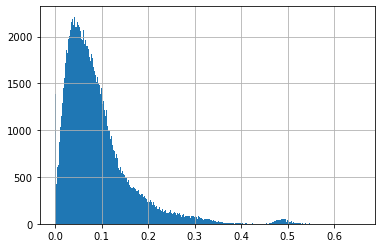

In [482]:
favorite_pivot_melt[favorite_pivot_melt['rating'] == 1]['rating_pred'].hist(bins = 500)

<AxesSubplot:>

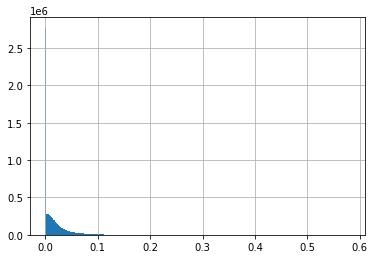

In [483]:
favorite_pivot_melt[favorite_pivot_melt['rating'] == 0]['rating_pred'].hist(bins = 500)

- rating이 1일때 그 예측값은 1에 몰려있고, 반대로 rating이 0일때 그 예측값은 0에 몰려있는게 정상이다

- funkSVD가 모델 적합을 제대로 하지 못했음을 히스토그램을 보면 알 수 있다.

In [594]:
favorite_pivot_melt_rev = \
favorite_pivot_melt.pivot(index = 'u_id',
                           columns = 'i_id',
                           values = 'rating_pred')

favorite_pivot_melt_rev = favorite_pivot_melt_rev.reset_index()

favorite_pivot_melt_rev = favorite_pivot_melt_rev.rename({'u_id' : 'buyerId'}, axis = 1)

favorite_pivot_melt_rev.columns.name = 'brandId'

In [485]:
def visualize_elbowmethod(data, param_init='random', param_n_init=10, param_max_iter=300):
    distortions = []
    for i in range(1, 20):
        km = KMeans(n_clusters=i, init=param_init, n_init=param_n_init, max_iter=param_max_iter, random_state=42)
        km.fit(data)
        distortions.append(km.inertia_)
    return distortions

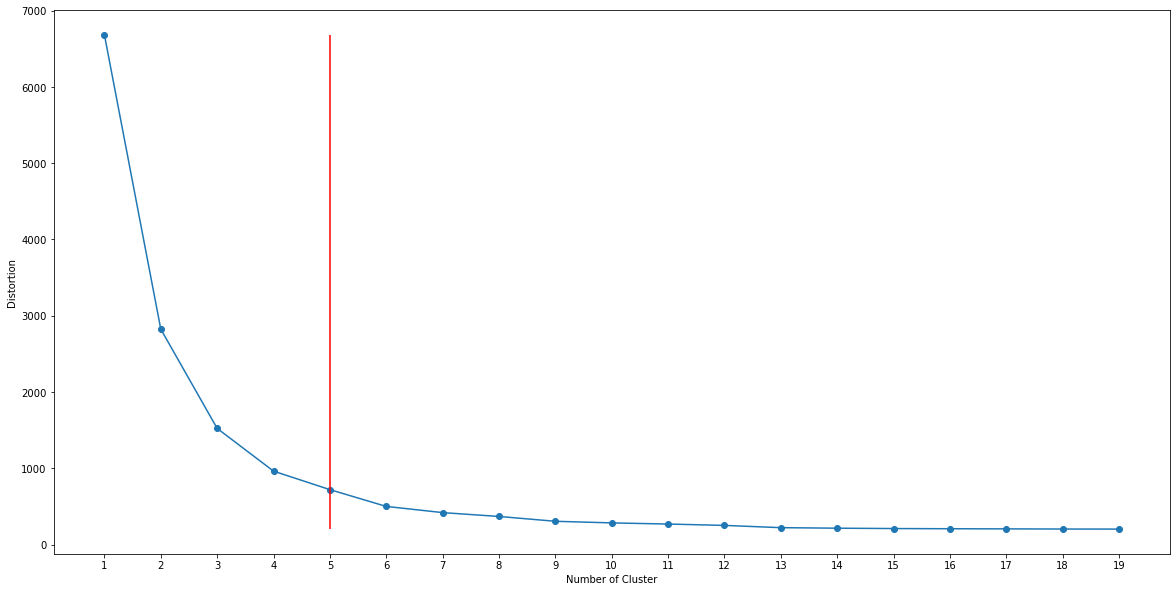

In [582]:
elbows = visualize_elbowmethod(favorite_pivot_melt_rev.iloc[:,1:])

plt.figure(figsize = (20,10))
plt.plot(range(1, 20), elbows, marker='o')
plt.xlabel('Number of Cluster')
plt.ylabel('Distortion')
plt.xticks(range(0,20))
plt.vlines(5, ymin = min(elbows), ymax = max(elbows), color = 'red')
plt.show()

In [583]:
kmeans = KMeans(n_clusters = 5, random_state=10)

In [584]:
cluster = kmeans.fit_predict(favorite_pivot_melt_rev.iloc[:,1:])

In [604]:
Series(cluster).value_counts()

0    2702
3     749
1     214
4      50
2      10
dtype: int64

In [596]:
favorite_pivot_melt_rev_cluster = favorite_pivot_melt_rev.copy()

In [597]:
favorite_pivot_melt_rev_cluster['cluster_kmeans'] = cluster

In [598]:
cluster_0 = favorite_pivot_melt_rev_cluster[
    favorite_pivot_melt_rev_cluster['cluster_kmeans'] == 0].iloc[:,1:-1]

cluster_0_power = pd.merge(Series(cluster_0.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster_0.cumsum().iloc[-1,:] / cluster_0.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_0_power = \
pd.merge(cluster_0_power.reset_index(),
         dataframe_seller[['brandId','name']])

cluster_0_power[cluster_0_power['power'] > 0.1]

brandId   frequency     power  name
0      683  366.924472  0.135797   아이유
1     5119  305.040746  0.112894  마요네즈
2    18482  277.681918  0.102769    홀리
3     9980  277.127704  0.102564   유안느
4    17643  274.035349  0.101419    로웰

In [601]:
cluster_1 = favorite_pivot_melt_rev_cluster[
    favorite_pivot_melt_rev_cluster['cluster_kmeans'] == 1].iloc[:,1:-1]

cluster_1_power = pd.merge(Series(cluster_1.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster_1.cumsum().iloc[-1,:] / cluster_1.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_1_power = \
pd.merge(cluster_1_power.reset_index(),
         dataframe_seller[['brandId','name']])

cluster_1_power[cluster_1_power['power'] > 0.1]

brandId  frequency     power        name
0        683  42.448295  0.198357         아이유
1       5119  37.338233  0.174478        마요네즈
2      18482  35.213767  0.164550          홀리
3       9980  35.058087  0.163823         유안느
4      17643  34.814940  0.162687          로웰
..       ...        ...       ...         ...
136    15974  21.499379  0.100464          오핀
137    16488  21.446731  0.100218          지수
138     7950  21.425138  0.100117  에스엔제이(S&J)
139    15756  21.417547  0.100082        세러데이
140     9949  21.400049  0.100000        바비제이

[141 rows x 4 columns]

In [602]:
cluster_2 = favorite_pivot_melt_rev_cluster[
    favorite_pivot_melt_rev_cluster['cluster_kmeans'] == 2].iloc[:,1:-1]

cluster_2_power = pd.merge(Series(cluster_2.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster_2.cumsum().iloc[-1,:] / cluster_2.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_2_power = \
pd.merge(cluster_2_power.reset_index(),
         dataframe_seller[['brandId','name']])

cluster_2_power[cluster_2_power['power'] > 0.1]

brandId  frequency     power          name
0         683   4.096116  0.409612           아이유
1        5119   3.843217  0.384322          마요네즈
2        9980   3.742180  0.374218           유안느
3       18482   3.723453  0.372345            홀리
4       16874   3.723335  0.372334  보네르(bonheur)
...       ...        ...       ...           ...
2687    19446   2.606340  0.260634           오셀로
2688    19525   2.604716  0.260472           밀리언
2689    19725   2.604321  0.260432            서현
2690    19186   2.600583  0.260058            메타
2691    13958   2.594610  0.259461           제니샵

[2692 rows x 4 columns]

In [438]:
cluster_2.loc[:,cluster_2_power[cluster_2_power['power'] > 0.5]['brandId'].values]

brandId  683    555    5337   15311  8876   16316  10707  3865   12637  15259  \
3          1.0    1.0    1.0    1.0    1.0    0.0    1.0    1.0    0.0    1.0   
9          1.0    1.0    1.0    1.0    0.0    0.0    0.0    0.0    1.0    0.0   
11         0.0    1.0    1.0    1.0    1.0    0.0    0.0    1.0    0.0    0.0   
33         0.0    1.0    1.0    0.0    1.0    0.0    1.0    0.0    1.0    0.0   
53         1.0    1.0    1.0    0.0    1.0    0.0    1.0    1.0    1.0    0.0   
...        ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
3117       1.0    1.0    1.0    0.0    0.0    1.0    0.0    1.0    0.0    0.0   
3149       1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    1.0   
3158       1.0    1.0    1.0    1.0    0.0    0.0    1.0    0.0    0.0    0.0   
3193       1.0    1.0    0.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0   
3430       0.0    1.0    1.0    0.0    1.0    1.0    1.0    0.0    0.0    0.0   

brandId  ...  7755   17643  5119   12510  12877  16874  5508   16724  6044   \
3        ...    1.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    1.0   
9        ...    1.0    1.0    1.0    1.0    1.0    1.0    0.0    0.0    1.0   
11       ...    0.0    0.0    1.0    1.0    0.0    0.0    1.0    0.0    1.0   
33       ...    1.0    1.0    0.0    0.0    1.0    1.0    1.0    1.0    1.0   
53       ...    1.0    0.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
3117     ...    0.0    1.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
3149     ...    0.0    1.0    1.0    0.0    1.0    1.0    1.0    0.0    1.0   
3158     ...    1.0    1.0    0.0    1.0    0.0    1.0    1.0    0.0    1.0   
3193     ...    1.0    1.0    0.0    0.0    1.0    1.0    1.0    1.0    1.0   
3430     ...    1.0    1.0    0.0    0.0    1.0    1.0    0.0    0.0    1.0   

brandId  8565   
3          0.0  
9          0.0  
11         0.0  
33         0.0  
53         0.0  
...        ...  
3117       0.0  
3149       1.0  
3158       0.0  
3193       0.0  
3430       0.0  

[259 rows x 22 columns]

In [603]:
cluster_3 = favorite_pivot_melt_rev_cluster[
    favorite_pivot_melt_rev_cluster['cluster_kmeans'] == 3].iloc[:,1:-1]

cluster_3_power = pd.merge(Series(cluster_3.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster_3.cumsum().iloc[-1,:] / cluster_3.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_3_power = \
pd.merge(cluster_3_power.reset_index(),
         dataframe_seller[['brandId','name']])

cluster_3_power[cluster_3_power['power'] > 0.1]

brandId   frequency     power            name
0       683  118.453072  0.158148             아이유
1      5119  101.166242  0.135068            마요네즈
2     18482   93.537488  0.124883              홀리
3      9980   93.252489  0.124503             유안느
4     17643   92.363329  0.123316              로웰
5      5337   89.638492  0.119678              두잇
6     16874   89.418665  0.119384    보네르(bonheur)
7     16848   83.864787  0.111969              또또
8      6044   82.512208  0.110163    더블엠(DOUBLEM)
9     12877   81.778600  0.109184             멜로워
10     6207   81.703028  0.109083             티엔씨
11    12081   81.407783  0.108689        (주)지엔어패럴
12     8928   81.142415  0.108334             러블리
13    15697   80.920130  0.108038           Jk어패럴
14     6047   80.318576  0.107234            헬로지니
15    18746   80.167703  0.107033            쓰리스타
16    14575   80.148117  0.107007         스튜디오그레이
17    15190   79.449198  0.106074              웨인
18     8876   77.108967  0.102949            아이보리
19     9268   76.808278  0.102548            수퍼발리
20    16316   76.693720  0.102395  더니즈(THE NEEDS)
21    15147   75.962642  0.101419        껌딱지_유아동복

In [606]:
cluster_4 = favorite_pivot_melt_rev_cluster[
    favorite_pivot_melt_rev_cluster['cluster_kmeans'] == 4].iloc[:,1:-1]

cluster_4_power = pd.merge(Series(cluster_4.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster_4.cumsum().iloc[-1,:] / cluster_4.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_4_power = \
pd.merge(cluster_4_power.reset_index(),
         dataframe_seller[['brandId','name']])

cluster_4_power[cluster_4_power['power'] > 0.1]

brandId  frequency     power        name
0         683  13.443734  0.268875         아이유
1        5119  12.269096  0.245382        마요네즈
2       18482  11.713056  0.234261          홀리
3        9980  11.670033  0.233401         유안느
4       17643  11.572497  0.231450          로웰
...       ...        ...       ...         ...
2687    19634   6.227134  0.124543        마이셀프
2688    19446   6.226850  0.124537         오셀로
2689    19576   6.222623  0.124452          레아
2690    19725   6.221164  0.124423          서현
2691      609   6.203685  0.124074  eosia 이오시아

[2692 rows x 4 columns]

- funkSVD를 이용해 클러스터링을 한 결과는 일반 SVD를 이용한것보다 상태가 더 처참하다.

- 어떤 클러스터도 브랜드를 밀도있게 집적시키지 못했다

In [611]:
csm_total = cosine_similarity(favorite_pivot_melt_rev_cluster.iloc[:,1:])

In [612]:
def user_user_factorization(df, ind, csm, k, verbose = False):
    if verbose:
        id_where = int(np.where(df.columns == 'buyerId')[0])
        print('<1. cosine similarity>')
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            print(f'userID : {df.iloc[num, id_where]} - ', csm[ind][num])
        print('\n')
        print("<2. Top - K user's Category list>")
        print(f'target - {df.iloc[ind, id_where]}',
              set(df.columns[np.where(df.iloc[ind] > 0)]).difference(['buyerId']))
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            print(f'UserID - {df.iloc[num, id_where]}',
                  set(df.columns[np.where(df.iloc[num] > 0)]).difference(['buyerId']))
        print('\n')
        print("<3. Top - K User's intersection List>")
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            print(f'UserID - {df.iloc[num, id_where]}',
            set(df.columns[np.where(df.iloc[ind] > 0)]).intersection(
            set(df.columns[np.where(df.iloc[num] > 0)])).difference(['buyerId']))
        print('\n')
        print("<4. Top - K User's difference List>")
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            print(f'UserID - {df.iloc[num, id_where]}',
            set(df.columns[np.where(df.iloc[num] > 0)]).difference(
            set(df.columns[np.where(df.iloc[ind] > 0)])).difference(['buyerId']))
        print('\n')
        print("<5. Top - K User's Product List>")
        print(f'target - {df.iloc[ind, id_where]}', "\n")
        display(orderseries_merchandise[orderseries_merchandise['buyerId'] == df.iloc[ind,0]][['prodName',
                                                                                               'brandId',
                                                                                               'brandName',
                                                                                              'cat_0',
                                                                                              'cat_1',
                                                                                              'cat_2']].drop_duplicates())
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            print(f'UserID - {df.iloc[num, id_where]}',"\n")
            display(orderseries_merchandise[orderseries_merchandise['buyerId'] == df.iloc[num,0]][['prodName',
                                                                                              'brandId',
                                                                                              'brandName',
                                                                                              'cat_0',
                                                                                              'cat_1',
                                                                                              'cat_2']].drop_duplicates())
    return np.sort(csm[ind])[-k:-1]

In [619]:
ind = np.random.randint(0, favorite_pivot_melt_rev_cluster.shape[0])

In [620]:
user_user_factorization(favorite_pivot, 
                        ind, 
                        csm_total,
                        3, 
                        verbose = True)

<1. cosine similarity>
userID : 155500 -  0.9950726769461984
userID : 5000 -  0.9936113638001416


<2. Top - K user's Category list>
target - 172262 {18948, 6047, 18363, 18911}
UserID - 155500 {15495, 17033, 18962, 17555, 13844, 18965, 19224, 19225, 12570, 18203, 16797, 19101, 16031, 18847, 17706, 6193, 18482, 18737, 7860, 16438, 13627, 6587, 16316, 18363, 19137, 13126, 17862, 16715, 17230, 18510, 6736, 15697, 16724, 9557, 9558, 13147, 17245, 18402, 18408, 14699, 15596, 18798, 17775, 11249, 19441, 8310, 17654, 18425, 17914, 18939, 6012, 18301}
UserID - 5000 {17314, 4525, 12863, 10578, 10707, 16050, 18070, 6265, 15292, 5119}


<3. Top - K User's intersection List>
UserID - 155500 {18363}
UserID - 5000 set()


<4. Top - K User's difference List>
UserID - 155500 {15495, 17033, 18962, 17555, 13844, 18965, 19224, 19225, 12570, 18203, 16797, 19101, 16031, 18847, 17706, 6193, 18482, 18737, 7860, 16438, 13627, 6587, 16316, 19137, 13126, 17862, 16715, 17230, 18510, 6736, 15697, 16724, 9557, 955

prodName  brandId brandName  cat_0  \
143459                                절개버튼JK    19616        아셀  WOMEN   
230736                            (신상)아이데님PT    18363       포에트  WOMEN   
232534  롱롱 부츠컷 슬랙스 팬츠 바지 하이웨스트 와이드 슬림 기본 롱다리     5878        럽럽  WOMEN   
249320                           339 롱일자 면바지     6131        블럭  WOMEN   
263089                    563번 스티치 와이드 롤업 팬츠    15890       미쓰진  WOMEN   

          cat_1    cat_2  
143459  OUTWEAR  Jackets  
230736  BOTTOMS    Pants  
232534  BOTTOMS    Pants  
249320  BOTTOMS    Pants  
263089  BOTTOMS    Denim

UserID - 155500 



prodName  brandId    brandName      cat_0         cat_1  \
18391  어뉴 103820 골프스커트    16438  SWAN(스완,달리)      WOMEN       BOTTOMS   
20198    몽클레어 클루니 다운패딩    18402         어몽어스        MEN       OUTWEAR   
20237    몽클레어 코튼패딩 가디건    18402         어몽어스        MEN       OUTWEAR   
20273           제비가라니트    18402         어몽어스        MEN          TOPS   
61107             G롱삭스    19224        에쉬그레이  ACCESSORY  Fashion Item   
61610         FF자수로고삭스    19224        에쉬그레이  SHOES&ACC   Accessories   

              cat_2  
18391        Skirts  
20198        Parkas  
20237        Parkas  
20273      Knitwear  
61107  Gloves/Socks  
61610           etc

UserID - 5000 



prodName  brandId  \
424                                    기모리초세트 신상 트레이닝 츄리닝     8664   
7307                                               이지 700    10937   
30417                                어깨 볼륨 반팔 쭈리 원피스(호텔룩)    18293   
30426                         메디 세트(패드 크롭 탑 밴딩바지 세트)골지 원단    18293   
52016                                 (겨울신상) 피터 뽀글이 베어 슈트     8569   
52036                                (가을신상) 엠키즈 하늘 팬츠 SET     8569   
52038                               (가을신상) 깜 지단 블루종 (주니어)     8569   
56038                                    베)이리오너라 한복 세트 남아    15147   
58286                                브로디제인 21여름 리플스트라잎파자마    14149   
63101                                   울챙레자단추마도로스 헌팅캡 모자     6252   
72271                                             하찌 소매 티     6323   
73085                                         발소리 삑삑이 마르코    13010   
73087                                          발소리 폼폼리본로퍼    13010   
75321                                    다이아퀼팅패딩조끼 SH7051    19612   
76201                                          A1)알로 점프슈트      683   
76210                                          M1)브링 블라우스      683   
82863                                              칼로리나세트    18579   
99490   #sale2023 프리미엄 구스다운 롱패딩 (국내배송, 후드털 블루폭스, 구스 솜털...    19303   
107731                                                w22    13808   
107792                                           상품차액추가결제    13808   
110366                                               메종6목    12863   
110602                                윈터오버핏체크재킷 WL00552HZ    19609   
110690                                      (세일)베이직 크롭 셔츠     8713   
110773                                 마빈니트가디건스커트세트#가을#신상    17791   
111119                            가을신상 9079번 요꼬오비 워싱 스판일자     6044   
111801                                         세일 배색니트가디건    11346   
197512                           국산  포그니  미끄럼 방지 체인 퍼 방한화     5892   
268804                                   스판 인포켓 컬러 면바지 팬츠    17627   
274848                                3719. 14k 타원 큐빅 목걸이    16340   
282886                                             캔디히프팬츠    14622   

           brandName      cat_0         cat_1                 cat_2  
424               첼로      WOMEN  DRESSES/SETS                  Sets  
7307             쿠스비      SHOES   men's shoes    loafer/ boat shoes  
30417            노바2      WOMEN  DRESSES/SETS               Dresses  
30426            노바2      WOMEN  DRESSES/SETS                  Sets  
52016       빠오빼_유아동복       KIDS          Tops                  Tees  
52036       빠오빼_유아동복       KIDS  Dresses/Sets                  Sets  
52038       빠오빼_유아동복       KIDS       Outwear                  None  
56038       껌딱지_유아동복       KIDS  Dresses/Sets                  Sets  
58286      허클베리_유아동복       KIDS  Dresses/Sets                  Sets  
63101           세기모자  ACCESSORY          Hats              Ball cap  
72271             님프      WOMEN          TOPS              Knitwear  
73085       안나마리_아동화       KIDS     Shoes/Acc                 Shoes  
73087       안나마리_아동화       KIDS     Shoes/Acc                 Shoes  
75321      캐주얼 인 광저우      WOMEN       OUTWEAR                 Vests  
76201            아이유      WOMEN       BOTTOMS             Jumpsuits  
76210            아이유      WOMEN          TOPS               Blouses  
82863           더플렉스      WOMEN  DRESSES/SETS                  Sets  
99490           광저우관      WOMEN       OUTWEAR                Parkas  
107731  LINKSHOPS_CN      WOMEN          TOPS                  Tees  
107792  LINKSHOPS_CN      WOMEN          TOPS                  Tees  
110366           신세계      SHOES   men's shoes    loafer/ boat shoes  
110602     오피스 인 광저우      WOMEN       OUTWEAR               Jackets  
110690           플랜티      WOMEN          TOPS                Shirts  
110773           플레이      WOMEN  DRESSES/SETS                  Sets  
111119  더블엠(DOUBLEM)      WOMEN       BOTTOMS                 Denim  
111801           그레이        MEN          TOPS             

array([0.99361136, 0.99507268])

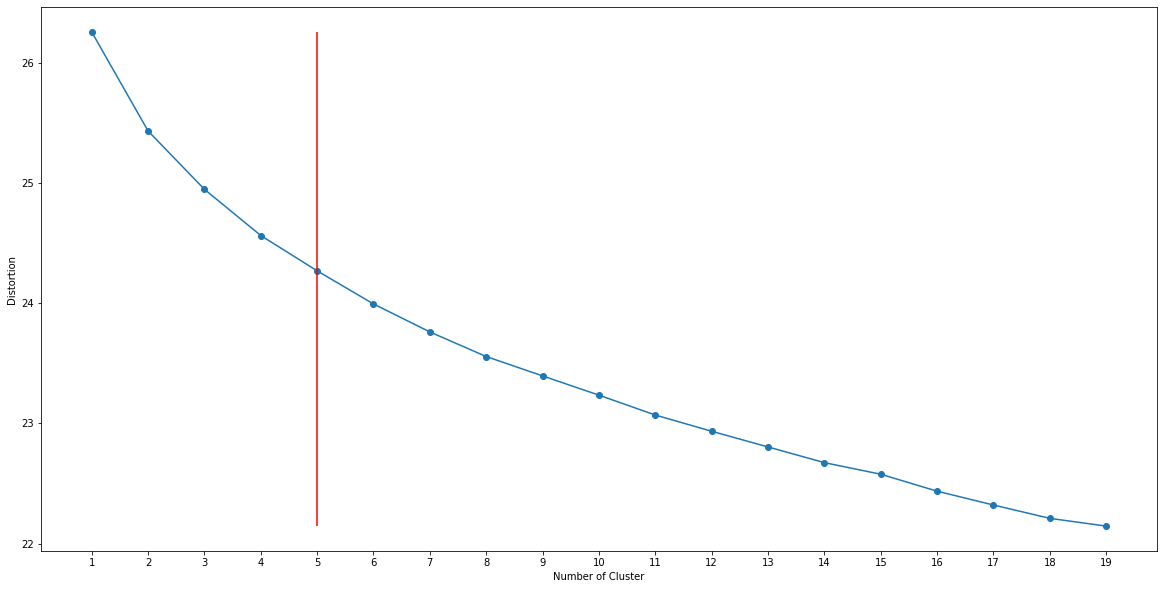

In [578]:
elbows = visualize_elbowmethod(svd.qi_)

plt.figure(figsize = (20,10))
plt.plot(range(1, 20), elbows, marker='o')
plt.xlabel('Number of Cluster')
plt.ylabel('Distortion')
plt.xticks(range(0,20))
plt.vlines(5, ymin = min(elbows), ymax = max(elbows), color = 'red')
plt.show()

In [579]:
elbows = visualize_elbowmethod(svd.pu_)

plt.figure(figsize = (20,10))
plt.plot(range(1, 20), elbows, marker='o')
plt.xlabel('Number of Cluster')
plt.ylabel('Distortion')
plt.xticks(range(0,20))
plt.vlines(5, ymin = min(elbows), ymax = max(elbows), color = 'red')
plt.show()

- funkSVD의 유저행렬(qu_)와 상품행렬(pi_) 양쪽을 이용한 클러스터링은 elbow 기법으로 판단하건데 의미가 없다.

** 결론 : 

##### - 잠재 디리클레 할당 Topic Modeling

잠재 디리클레 할당(Latent DIrichlet Allocation)은 자연어처리(NLP)에서 주로 사용되는 알고리즘으로, 

- 가상의 주제(TOPIC)을 설정하고, 
- 문서에 등장하는 모든 단어들을 LDA 알고리즘이 각 TOPIC으로 자동으로 할당하여
- 각 TOPIC별로 할당된 단어와, 이에 기반하여 마찬가지로 할당된 문서의 분포 양상을 보고 인사이트를 얻는 방법론이다.

가령, 분석가가 TOPIC을 5개로 추정하고, LDA를 이용해 5개 문서에 대한 LDA를 수행하면
TOPIC1에 'Women, Tops, Outware'라는 단어가 할당되었다면 TOPIC1을 '여성복'에 대한 TOPIC으로
TOPIC2에 'Kids, Dresses/Sets, KidsHats'가 할당되었다면 '아동복'에 대한 TOPIC으로 추정하여
각 TOPIC별로 어떤 문서들이 할당되었는지를 마찬가지로 판단할 수 있게 된다.

아래 분석에서는, 문서를 '각 고객'으로, 단어를 '상품 카테고리'로 치환하여 LDA를 수행한다. 즉

- 7549명 고객 데이터 : 문서

- 106개 상품 카테고리 : 단어

In [17]:
perplexity = list()

for i in range(2,20):
    lda = LatentDirichletAllocation(n_components=i, random_state=42)
    lda.fit(favorite_pivot.iloc[:,1:])
    perplexity.append(lda.perplexity(favorite_pivot.iloc[:,1:]))


In [19]:
DataFrame({'topic_num' : [i for i in range(2,20)],
           'perplexity' : perplexity})


topic_num   perplexity
0           2  1392.261350
1           3  1338.789585
2           4  1305.870050
3           5  1286.224829
4           6  1254.105545
5           7  1233.921210
6           8  1207.723837
7           9  1218.518656
8          10  1242.245512
9          11  1232.168238
10         12  1234.974894
11         13  1230.721551
12         14  1235.696488
13         15  1253.623086
14         16  1255.972529
15         17  1265.761861
16         18  1267.001497
17         19  1282.155105

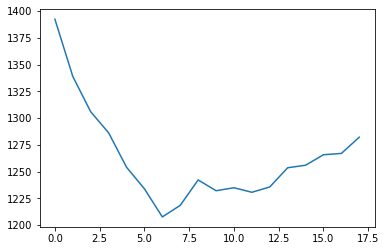

In [20]:
plt.plot(perplexity)

In [27]:
def user_user_factorization(df, ind, csm, k, verbose = False):
    if verbose:
        id_where = int(np.where(df.columns == 'buyerId')[0])
        print('<1. cosine similarity>')
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            print(f'userID : {df.iloc[num, id_where]} - ', csm[ind][num])
        print('\n')
        print("<2. Top - K user's Category list>")
        print(f'target - {df.iloc[ind, id_where]}',
              set(df.columns[np.where(df.iloc[ind] > 0)]).difference(['buyerId']))
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            print(f'UserID - {df.iloc[num, id_where]}',
                  set(df.columns[np.where(df.iloc[num] > 0)]).difference(['buyerId']))
        print('\n')
        print("<3. Top - K User's intersection List>")
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            print(f'UserID - {df.iloc[num, id_where]}',
            set(df.columns[np.where(df.iloc[ind] > 0)]).intersection(
            set(df.columns[np.where(df.iloc[num] > 0)])).difference(['buyerId']))
        print('\n')
        print("<4. Top - K User's Product List>")
        print(f'target - {df.iloc[ind, id_where]}', "\n")
        display(orderseries_merchandise[orderseries_merchandise['buyerId'] == df.iloc[ind,0]][['prodName',
                                                                                              'cat_0',
                                                                                              'cat_1',
                                                                                              'cat_2']].drop_duplicates())
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            print(f'UserID - {df.iloc[num, id_where]}',"\n")
            display(orderseries_merchandise[orderseries_merchandise['buyerId'] == df.iloc[num,0]][['prodName',
                                                                                              'cat_0',
                                                                                              'cat_1',
                                                                                              'cat_2']].drop_duplicates())
    return np.sort(csm[ind])[-k:-1]

In [80]:
lda = LatentDirichletAllocation(n_components=8, random_state=42)
lda.fit(favorite_pivot.iloc[:,1:])

doc_topic = lda.transform(favorite_pivot.iloc[:,1:])

In [81]:
cluster_topic = \
pd.concat([favorite_pivot['buyerId'].reset_index(drop = True),
           Series(np.argmax(doc_topic, axis = 1), name = 'cluster'),
           Series(np.max(doc_topic, axis = 1), name = 'value')],
         axis = 1)

In [85]:
cluster = 0

In [86]:
k = 5

In [88]:
for cluster in range(0,9):
    brandid =  favorite_pivot.columns[np.argsort(lda.components_[cluster])][::-1][0:k]
    dirichlet_value = np.sort(lda.components_[cluster])[::-1][0:k]

    display(pd.merge(DataFrame({'brandId' : brandid,
                        'cumsum' : Series(dirichlet_value / np.sum(lda.components_[cluster]),
                                           name = 'value')}),
             pd.merge(dataframe_seller,Series(brandid))[['brandId','name']]
            )
           )

brandId    cumsum        name
0    7123  0.013642  FROM.B 프롬비
1   11784  0.012160         바이블
2   15189  0.012143        SS제화
3   13868  0.009888        밀리티지
4   16068  0.007879          비키

brandId    cumsum         name
0     673  0.010130  muse.cph 뮤즈
1   16865  0.010086          티바지
2   17642  0.008356          파사드
3   17530  0.007130          더디얼
4   14571  0.006964          센시즈

brandId    cumsum           name
0    8870  0.009725  MUY MONA 무이모나
1   15734  0.009040         모던앤빈티지
2   16312  0.008743           퀸즈래빗
3    7753  0.008654       미니멀 그라운드
4    3848  0.008566           모니카2

brandId    cumsum                   name
0   12078  0.007204                  미니팩토리
1    6046  0.005563                     키엠
2    9505  0.005229                    코리샵
3   17341  0.005203  Spring Company 스프링컴퍼니
4    2175  0.005202        FARMER'S MARKET

brandId    cumsum               name
0   18480  0.021884                바운드
1   15675  0.019495               3355
2   17241  0.017851                트리플
3   16433  0.017099  아스페시레드(AspesiRed)
4   19258  0.015076                 다나

brandId    cumsum  name
0    8921  0.015563   제이알
1    9972  0.014296    시슴
2   11609  0.011946  뮤즈팜므
3    9196  0.011049   플래쉬
4   11959  0.010060   모나미

brandId    cumsum     name
0    9397  0.005207      그린티
1    8710  0.003823       뮤즈
2    5985  0.003815       보스
3   10700  0.003671        풀
4    5102  0.003668  MOON(문)

brandId    cumsum        name
0   15106  0.045435           덴
1   10223  0.038942        버터핑거
2   12884  0.038448          민슈
3   14968  0.038402  가쉽(GOSSIP)
4    8566  0.035229         유니엘

IndexError: index 8 is out of bounds for axis 0 with size 8

In [24]:
test = pd.merge(favorite_pivot,
         cluster_topic.loc[cluster_topic['cluster'] == 0]['buyerId'],
         on = 'buyerId')

u,s,v = np.linalg.svd(test.iloc[:,1:].to_numpy(), full_matrices = False)

#특이값의 총합, 즉 에너지가 90%가 넘는 지점의 축을 도출한다.

energy_where = np.max(np.where(s.cumsum() / s.sum() < 0.9))

In [26]:
#위에서 도출한 값을 토대로 상위 53개 특이값에 해당하는 축들을 뽑아 재조합한다.
print(energy_where)
order_matrix_reconstruct = np.dot(u[:,0:energy_where], np.dot(np.diag(s[0:energy_where]), v[0:energy_where]))
csm_cluster = cosine_similarity(order_matrix_reconstruct)

194


In [31]:
user_user_factorization(test,
                        210,
                        csm_cluster,
                        10,
                       verbose = True)

<1. cosine similarity>
userID : 122310 -  0.4394377088835152
userID : 92261 -  0.40402050064113726
userID : 96466 -  0.3282696347676265
userID : 171032 -  0.28860915915084606
userID : 165421 -  0.26648511791596974
userID : 147208 -  0.2591551150015027
userID : 142889 -  0.2554776102893793
userID : 99189 -  0.2460897957638327
userID : 163968 -  0.24228766716464542


<2. Top - K user's Category list>
target - 158217 {9448, 17245, 11919, 9074, 13429, 12855, 14587, 13884, 11101, 14719}
UserID - 122310 {9448, 8748, 13884}
UserID - 92261 {14675, 11919}
UserID - 96466 {14587, 11548}
UserID - 171032 {19723, 9074, 18770, 9428, 7130, 14587, 8956}
UserID - 165421 {11441, 13884}
UserID - 147208 {17572, 13884}
UserID - 142889 {9074, 15190}
UserID - 99189 {11523, 11785, 14606, 8979, 11285, 17429, 11037, 5151, 10787, 8997, 16677, 16944, 16433, 11001, 15157, 12855, 8762, 7483, 5692, 13884, 17212, 5186, 13129, 16209, 14675, 12373, 15190, 11101, 17505, 12393, 12398, 5489, 3186, 16505, 15485, 14719, 1190

prodName  cat_0    cat_1   cat_2
96444  신상)명품 바일렛 경량패딩  WOMEN  OUTWEAR  Parkas

UserID - 122310 



prodName      cat_0 cat_1       cat_2
29576    BC624 LA 패치 볼캡  SHOES&ACC  Hats    Ball cap
29577  BH675 데미지 코튼 버킷햇  SHOES&ACC  Hats  Bucket hat
98359     이중직 세미 오버 MTM        MEN  TOPS        Tees

UserID - 92261 



prodName      cat_0          cat_1  \
9754                         쿨토시프릴  ACCESSORY   Fashion Item   
10190  DH-3666 탈부착 퍼 스트랩 어그 슬리퍼 샌들      SHOES  women's shoes   

                     cat_2  
9754          Gloves/Socks  
10190  flip flops & slides

UserID - 96466 



prodName cat_0    cat_1     cat_2
50275       FW22 신상 (겨울신상) (주문폭주) 코어 후드 패딩   MEN  OUTWEAR    Parkas
50326         FW22 (신상) 나그랑 워머 니트 (4color)   MEN     TOPS  Knitwear
50330   미송필수)22FW 신상) (BEST) (인기) 울 바시티 자켓   MEN  OUTWEAR   Jackets
96000                               앤드직기pt   MEN  BOTTOMS     Pants
98441                           알파카부클라운드니트   MEN     TOPS  Knitwear
144500                   (22FW) CALI 기모 후드   MEN     TOPS      Tees
145794                    브룩클린 스트링 맨투맨(기모)   MEN     TOPS      Tees
257755             (주문대폭주)딥원턱와이드PT(쭈리or기모)   MEN  BOTTOMS     Pants
257805                       루즈핏스윗PT(유니섹스)   MEN  BOTTOMS     Pants

UserID - 171032 



prodName  cat_0    cat_1      cat_2
25787                              배색 온스집업(4온스)    MEN  OUTWEAR     Parkas
25789                                   브릿 히든자켓    MEN  OUTWEAR    Jackets
25791                                   스완 V넥조끼    MEN     TOPS   Knitwear
50629                                  자수기모 맨투맨  WOMEN     TOPS       Tees
65340                          요청재진행) 롭 모헤어 맨투맨    MEN     TOPS       Tees
77244                                   울스퀘어라운드    MEN     TOPS   Knitwear
93555                                 멀티 플리츠 세트    MEN    SUITS       None
93557                              트위드 체크 셔츠 자켓    MEN     TOPS     Shirts
93560                                플리츠 절개 맨투맨    MEN     TOPS       Tees
101304                흐느적흔들흐느적흔들 )기모) 웨이브스마일 후드    MEN     TOPS       Tees
137635                                  아큰애 맨투맨    MEN     TOPS       Tees
173933                           헨델 특기모MTM (12C    MEN     TOPS       Tees
174087           헨델 코듀로이머슬핏긴팔 (8C, Size M,L,XL)    MEN     TOPS       Tees
174220         2022SS 헨델 시스루오버핏긴팔티 (5C, Size F)    MEN     TOPS       Tees
174224                       헨델 피그쭈리맨투맨 ( 15C )    MEN     TOPS       Tees
174232                         헨델 헨리넥머슬분또긴팔 (9C    MEN     TOPS       Tees
174246                          헨델 쿨링분또반팔T (17C    MEN     TOPS       Tees
174258                           헨델 캠핑 양털조끼 (3C    MEN  OUTWEAR      Vests
174260                         헨델 모헤어체크MTM (3C     MEN     TOPS       Tees
174262                        헨델 램스울 크루넥 오버핏 니트    MEN     TOPS   Knitwear
191453  무드체크MTM(겨울신상,점프수트,원피스,세트,슬랙스,셔링,가디건,커플)    MEN     TOPS       Tees
209411                                  라비쮸리기모T  WOMEN     TOPS       Tees
218014                          모헤어 앙고라 가디건 8컬러    MEN  OUTWEAR  Cardigans
223740                 (세일) 쓰리톤 라이너 가디건 ₩30,000    MEN  OUTWEAR  Cardigans
233703                                    브러쉬니트    MEN     TOPS   Knitwear
233707                                    원데이니트    MEN     TOPS   Knitwear
247537                                    후리스남방    MEN     TOPS     Shirts
248253                                  #아크기모남방    MEN     TOPS     Shirts
266162                               라코 라운드 니트지    MEN     TOPS   Knitwear
268001                                    봄버가디건    MEN  OUTWEAR  Cardigans

UserID - 165421 



prodName cat_0    cat_1      cat_2
115300  골지무드가디건   MEN  OUTWEAR  Cardigans

UserID - 147208 



prodName      cat_0  \
9868                                           웨이브티(패드부착)      WOMEN   
80214                                        하이 블루 진(사계절)      WOMEN   
80232                                          스트레이트 블루 진      WOMEN   
127132                                             무브 언발티      WOMEN   
135102                           P-556 통굽 중간절개 퍼 국내제작 슬리퍼      SHOES   
140938                                      O2) 레더 항아리 패딩      WOMEN   
193912                     m꽈배기 무지양말 (1칼라 10장이 한묶음 기준입니다)  ACCESSORY   
224028                  477기모pt(sale) #청바지 #기모청바지 #부츠컷청바지      WOMEN   
230812                                            마인트위드자켓      WOMEN   
233735                                           로우골반데님PT      WOMEN   
267937  no817#baguettemont#Bluejeans#바게트몽#Denim#madein...      WOMEN   

                cat_1                  cat_2  
9868             TOPS                   Tees  
80214         BOTTOMS                  Denim  
80232         BOTTOMS                  Denim  
127132           TOPS                   Tees  
135102  women's shoes  slippers/fur slippers  
140938        OUTWEAR                 Parkas  
193912   Fashion Item           Gloves/Socks  
224028        BOTTOMS                  Denim  
230812        OUTWEAR                Jackets  
233735        BOTTOMS                  Denim  
267937        BOTTOMS                  Denim

UserID - 142889 



prodName  cat_0    cat_1  cat_2
193683   수유 데일리 T  WOMEN     TOPS   Tees
193686  임부 데일리 SL  WOMEN  BOTTOMS  Pants

UserID - 99189 



prodName  cat_0         cat_1         cat_2
50384   FW22 신상 (겨울신상) 코어 후드 패딩    MEN       OUTWEAR        Parkas
60513              긴 커플린디세트 파자마  WOMEN  DRESSES/SETS          Sets
85358                캐시 베이직 반폴라    MEN          TOPS      Knitwear
93521               FW 아크녜 더블코트    MEN       OUTWEAR         Coats
125015              쎄느 니트집업 가디건    MEN          TOPS      Knitwear
156126               모헤어 라운드 니트    MEN          TOPS      Knitwear
169418     (신상) 4계절 레이어드 긴팔티(기획    MEN          TOPS          Tees
177244                S5)비바골덴팬츠    MEN       BOTTOMS         Pants
177245                  데이지밴딩팬츠    MEN       BOTTOMS         Pants
215962            M)허니맨투일자세트)스판    MEN       BOTTOMS         Pants
234644   어썸 코듀로이 PT 골덴,스판,인기,팬츠    MEN       BOTTOMS  Knit Bottoms
245470              크루 핸드메이드 코트    MEN       OUTWEAR         Coats
261258            스톤 글로시유광 크롭패딩    MEN       OUTWEAR        Parkas
273763              (봄신상) 일자 바지    MEN       BOTTOMS         Pants

UserID - 163968 



prodName          cat_0          cat_1  \
30464   스웨이드 하이힐 코엣지 워커 8cm, 821dd          SHOES  women's shoes   
269333               N239-0 스판앵클부츠          SHOES  women's shoes   
269342          SC0417-4 T스트랩힐 9cm  women's shoes          SHOES   

                                 cat_2  
30464   chelsea boots / military boots  
269333                           Boots  
269342                 sandals / pumps

array([0.24228767, 0.2460898 , 0.25547761, 0.25915512, 0.26648512,
       0.28860916, 0.32826963, 0.4040205 , 0.43943771])

### orderseries 기반 클러스터링

#### 모든 바이어 - 모든 브랜드 활용

In [18]:
def min_max_scailing(x, except_col):
    if except_col is not None:
        max_value = np.max(x.drop([except_col]))
        min_value = np.min(x.drop([except_col]))
        temp = (x.drop([except_col]) - min_value) / (max_value - min_value)
        temp = DataFrame(temp).T
        return pd.concat([DataFrame(x[[except_col]]).T, temp], axis = 1)
    else :
        max_value = np.max(x)
        min_value = np.min(x)
        temp = (x - min_value) / (max_value - min_value)
        #temp = DataFrame(temp).T
        return temp

In [19]:
a = orderseries_merchandise.groupby('buyerId')[['brandId']].value_counts().reset_index()

In [20]:
favorite_pivot = a.pivot_table(index = 'buyerId',
                               columns = 'brandId',
                               values = 0)
favorite_pivot = favorite_pivot.reset_index()

favorite_pivot = favorite_pivot.fillna(0)

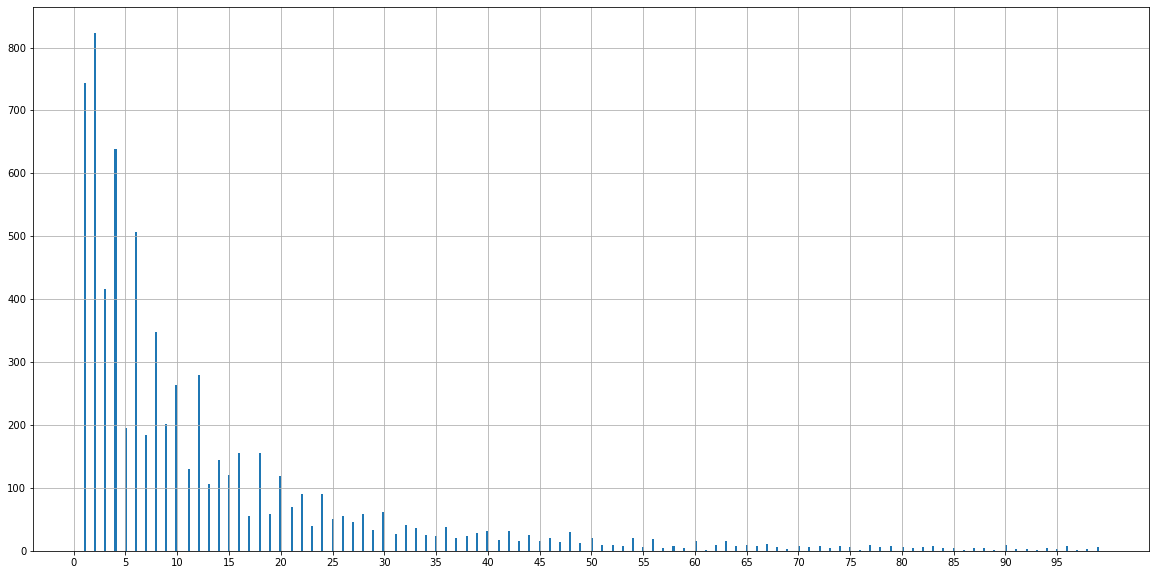

In [21]:
plt.figure(figsize = (20,10))
favorite_pivot.iloc[:,1:].apply(lambda x : max(x) if max(x) < 100 else None, axis = 1).hist(bins = 500)
plt.xticks(range(0,100,5))
plt.show()

다음의 식으로 변환한 값의 히스토그램이다

$$ score = {\max{X_{i}}} $$

$$단$$
$$ X_{i} i번째 바이어의 구매 이력(행) $$

최댓값만 고려하였을땐 위에서 선언한 목적에서 다음의 사안을 위반한다

- 집중도 미반영
- 손실 갯수 최소화 : 계급값 2 이하를 제외한다해도 약 800개의 샘플이 손실된다.

In [22]:
plt.figure(figsize = (20,10))
favorite_pivot.iloc[:,1:].apply(lambda x : max(x) / (np.std(x) + 1) if max(x) / (np.std(x) + 1) < 10 else None, axis = 1).hist(bins = 500)
plt.xticks(range(0,10,5))
plt.show()

다음의 식으로 변환한 값의 히스토그램이다

$$ score = {\max{X_{i}} \over std(X_{i}) + 1} $$

$$단$$
$$ X_{i} i번째 바이어의 구매 이력(행) $$
$$ std 는 표준편차 $$

심플한 착안으로, 

- 해당 바이어의 구매 이력이 고르게 퍼져있을수록(=표준편차가 작을수록) 값이 커지고, 특정 값에 몰려있을수록(=표준 편차가 클수록) 값이 작아진다

- 여기에 해당 바이어 구매 이력의 최댓값(max X_i)를 가져와서 최댓값이 클수록 값이 커진다.

최댓값만 고려하였을땐 위에서 선언한 목적에서 다음의 사안을 위반한다

- 손실 갯수 최소화 : 대부분의 값이 0 ~ 5 사이에 몰려있어 너무 많은 샘플을 손실할 우려가 존재한다

In [23]:
plt.figure(figsize = (20,10))
favorite_pivot.iloc[:,1:].apply(lambda x : np.exp(max(x) / (np.std(x) + 1)) 
                      if np.exp(max(x) / (np.std(x) + 1)) < 100 else None, axis = 1).hist(bins = 500)
plt.xticks(range(0,100,5))
plt.show()

다음의 식으로 변환한 값의 히스토그램이다

$$ score = exp({\max{X_{i}} \over std(X_{i}) + 1}) $$

$$단$$
$$ X_{i} i번째 바이어의 구매 이력(행) $$
$$ std 는 표준편차 $$

바로 위 변환 수식을 지수변환하여 저점수 / 고점수간 계급값 차이를 극대화한다

In [24]:
favorite_pivot['values'] = favorite_pivot.iloc[:,1:].apply(lambda x : np.exp(max(x) / (np.std(x) + 1)), axis = 1)

In [25]:
favorite_pivot['values'].describe()

count    7.240000e+03
mean     3.077252e+18
std      2.433561e+20
min      2.548513e+00
25%      1.677186e+01
50%      6.287602e+02
75%      2.066516e+05
max      2.068981e+22
Name: values, dtype: float64

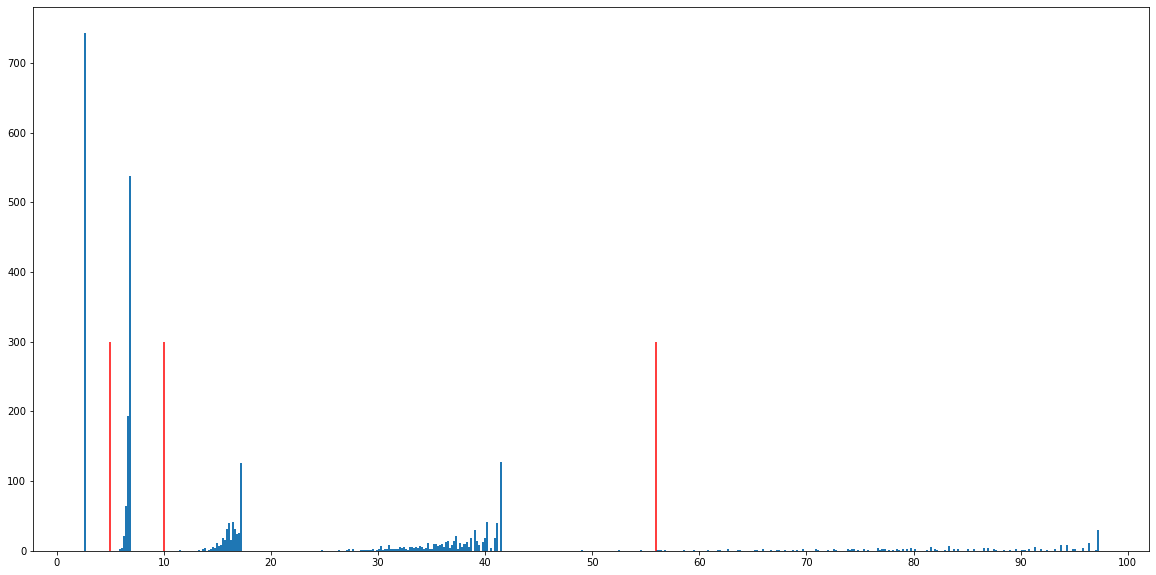

In [26]:
plt.figure(figsize = (20,10))
plt.hist(favorite_pivot.loc[favorite_pivot['values'] < 100, 'values'], bins = 500)
plt.xticks(range(0, 220, 10))
plt.vlines([5,10,56], ymin = 0, ymax = 300, color = 'red')
plt.show()

In [31]:
(favorite_pivot['values'] >= 10).value_counts()

True     5674
False    1566
Name: values, dtype: int64

In [32]:
favorite_pivot = favorite_pivot[favorite_pivot['values'] >= 10]
favorite_pivot = favorite_pivot.drop(['values'], axis = 1)

In [33]:
favorite_pivot_t = favorite_pivot.T

In [34]:
favorite_pivot_t['values'] = favorite_pivot_t.iloc[1:,:].apply(lambda x : np.exp(max(x) / (np.std(x) + 1)), axis = 1)

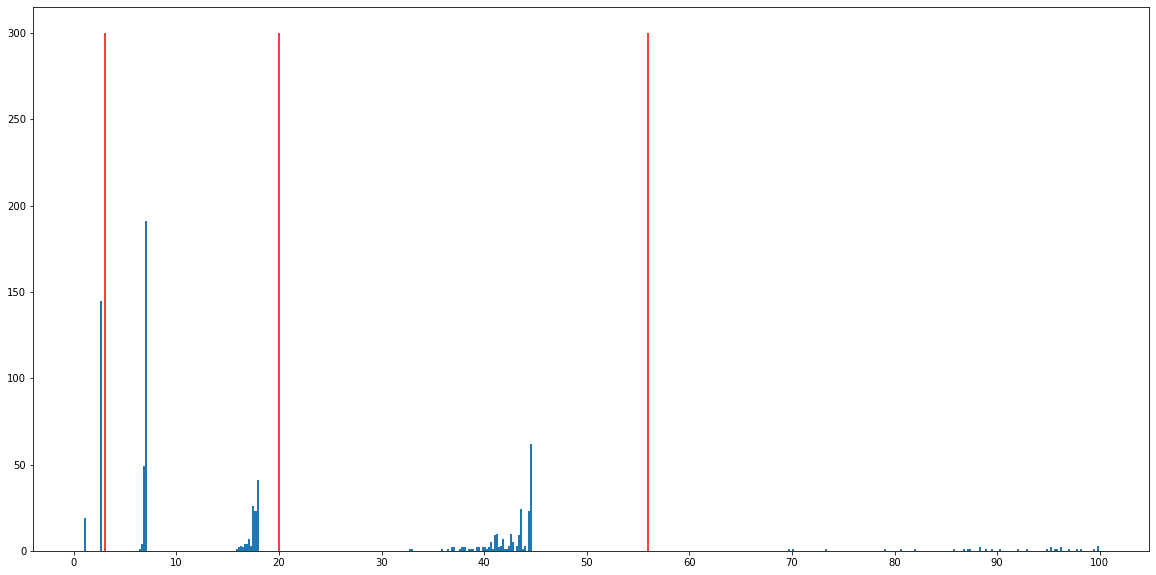

In [35]:
plt.figure(figsize = (20,10))
plt.hist(favorite_pivot_t.loc[favorite_pivot_t['values'] < 100, 'values'], bins = 500)
plt.xticks(range(0, 220, 10))
plt.vlines([3,20,56], ymin = 0, ymax = 300, color = 'red')
plt.show()

In [36]:
(favorite_pivot_t['values'] >= 10).value_counts()

True     2523
False     410
Name: values, dtype: int64

In [37]:
favorite_pivot_t = favorite_pivot_t[favorite_pivot_t['values'] > 10]

In [38]:
favorite_pivot = pd.concat([favorite_pivot['buyerId'],
            favorite_pivot_t.T.drop('values')],
         axis = 1)

In [39]:
plt.figure(figsize = (20,10))
favorite_pivot.iloc[:,1:].apply(lambda x : np.std(x)).hist(bins = 500)

<AxesSubplot:>

In [40]:
a = (favorite_pivot.iloc[:,1:] == 0).apply(lambda x : x.value_counts())

In [41]:
1 - np.sum(a.loc[False]) / np.sum(a.loc[True])

0.9945339401551292

전체의 99.6%가 빈값이다.

바꿔 말해, 값이 있는 경우는 0.04%에 불과하다(지나치게 sparse 하다)

In [48]:
favorite_pivot_scailing = favorite_pivot.apply(lambda x : min_max_scailing(x, 'buyerId'), axis = 1)

favorite_pivot_scailing = pd.concat(favorite_pivot_scailing.values)

In [49]:
u,s,v = np.linalg.svd(favorite_pivot_scailing.iloc[:,1:].to_numpy(), full_matrices = False)

#특이값의 총합, 즉 에너지가 90%가 넘는 지점의 축을 도출한다.

energy_where = np.max(np.where(s.cumsum() / s.sum() < 0.9))

#위에서 도출한 값을 토대로 상위 53개 특이값에 해당하는 축들을 뽑아 재조합한다.
print(energy_where)
order_matrix_reconstruct = np.dot(u[:,0:energy_where], np.dot(np.diag(s[0:energy_where]), v[0:energy_where]))


1349


클러스터링을 진행하기엔 데이터가 지나치게 sparse하다

In [50]:
def visualize_elbowmethod(data, param_init='random', param_n_init=10, param_max_iter=300):
    distortions = []
    for i in range(1, 20):
        km = KMeans(n_clusters=i, init=param_init, n_init=param_n_init, max_iter=param_max_iter, random_state=42)
        km.fit(data)
        distortions.append(km.inertia_)
    return distortions

In [51]:
elbows = visualize_elbowmethod(order_matrix_reconstruct)

In [52]:
plt.figure(figsize = (20,10))
plt.plot(range(1, 20), elbows, marker='o')
plt.xlabel('Number of Cluster')
plt.ylabel('Distortion')
plt.xticks(range(0,20))
plt.vlines(5, ymin = min(elbows), ymax = max(elbows), color = 'red')
plt.show()

In [54]:
def compute_bic(kmeans,X):
    """
    Computes the BIC metric for a given clusters

    Parameters:
    -----------------------------------------
    kmeans:  List of clustering object from scikit learn

    X     :  multidimension np array of data points

    Returns:
    -----------------------------------------
    BIC value
    """
    # assign centers and labels
    centers = [kmeans.cluster_centers_]
    labels  = kmeans.labels_
    #number of clusters
    m = kmeans.n_clusters
    # size of the clusters
    n = np.bincount(labels)
    #size of data set
    N, d = X.shape

    #compute variance for all clusters beforehand
    cl_var = (1.0 / (N - m) / d) * sum([sum(distance.cdist(X.iloc[labels == i], [centers[0][i]], 
             'euclidean')**2) for i in range(m)])

    const_term = 0.5 * m * np.log(N) * (d+1)

    BIC = np.sum([n[i] * np.log(n[i]) -
               n[i] * np.log(N) -
             ((n[i] * d) / 2) * np.log(2*np.pi*cl_var) -
             ((n[i] - 1) * d/ 2) for i in range(m)]) - const_term

    return(BIC)

In [55]:
kmeans = [KMeans(n_clusters = i).fit(DataFrame(order_matrix_reconstruct)) for i in range(1,20)]

bic = [compute_bic(kmeansi, DataFrame(order_matrix_reconstruct)) for kmeansi in kmeans]

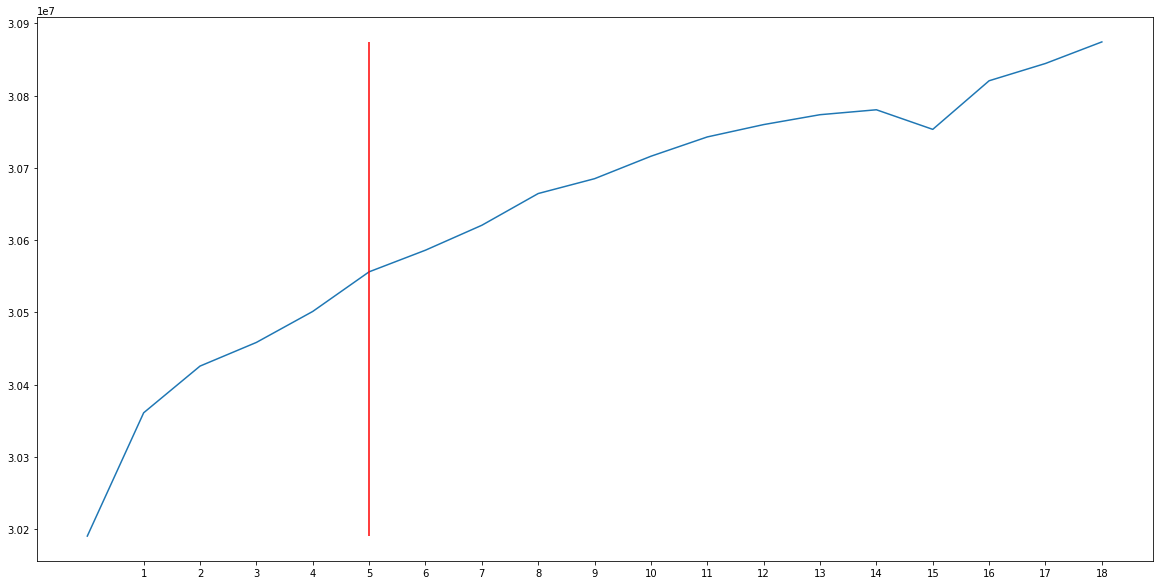

In [56]:
plt.figure(figsize = (20,10))
plt.plot(bic)
plt.xticks(range(1,20))
plt.vlines(5, ymin = min(bic), ymax = max(bic), color = 'red')
plt.show()

In [115]:
kmeans = KMeans(n_clusters = 8, random_state=42)

In [116]:
cluster = kmeans.fit_predict(order_matrix_reconstruct)

In [117]:
Series(cluster).value_counts()

5    4025
7     515
3     272
6     271
1     263
4     175
0     117
2      36
dtype: int64

In [118]:
favorite_pivot_cluster = favorite_pivot_scailing.copy()

In [119]:
favorite_pivot_cluster['cluster_kmeans'] = cluster

In [120]:
favorite_pivot_cluster.columns.name = 'brandId'

In [121]:
cluster_0 = favorite_pivot_cluster[
    favorite_pivot_cluster['cluster_kmeans'] == 0].iloc[:,1:-1]

cluster_0_power = pd.merge(Series(cluster_0.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster_0.cumsum().iloc[-1,:] / cluster_0.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_0_power = \
pd.merge(cluster_0_power.reset_index(),
         dataframe_seller[['brandId','name']])

cluster_0_power[cluster_0_power['power'] > 0.5]

brandId   frequency    power     name
0    14969  104.624937  0.89423  지니_유아동복

In [122]:
cluster_1 = favorite_pivot_cluster[
    favorite_pivot_cluster['cluster_kmeans'] == 1].iloc[:,1:-1]

cluster_1_power = pd.merge(Series(cluster_1.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster_1.cumsum().iloc[-1,:] / cluster_1.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_1_power = \
pd.merge(cluster_1_power.reset_index(),
         dataframe_seller[['brandId','name']])

cluster_1_power[cluster_1_power['power'] > 0.5]

brandId   frequency     power      name
0     8569  210.788775  0.801478  빠오빼_유아동복

In [123]:
cluster_2 = favorite_pivot_cluster[
    favorite_pivot_cluster['cluster_kmeans'] == 2].iloc[:,1:-1]

cluster_2_power = pd.merge(Series(cluster_2.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster_2.cumsum().iloc[-1,:] / cluster_2.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_2_power = \
pd.merge(cluster_2_power.reset_index(),
         dataframe_seller[['brandId','name']])

cluster_2_power[cluster_2_power['power'] > 0.5]

brandId  frequency    power  name
0    11425  22.817879  0.63383  퍼스트런

In [125]:
cluster_3 = favorite_pivot_cluster[
    favorite_pivot_cluster['cluster_kmeans'] == 3].iloc[:,1:-1]

cluster_3_power = pd.merge(Series(cluster_3.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster_3.cumsum().iloc[-1,:] / cluster_3.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_3_power = \
pd.merge(cluster_3_power.reset_index(),
         dataframe_seller[['brandId','name']])

cluster_3_power[cluster_3_power['power'] > 0.5]

brandId   frequency     power      name
0    10238  202.506273  0.744508  나무2_유아동복

In [126]:
cluster_4 = favorite_pivot_cluster[
    favorite_pivot_cluster['cluster_kmeans'] == 4].iloc[:,1:-1]

cluster_4_power = pd.merge(Series(cluster_4.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster_4.cumsum().iloc[-1,:] / cluster_4.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_4_power = \
pd.merge(cluster_4_power.reset_index(),
         dataframe_seller[['brandId','name']])

cluster_4_power[cluster_4_power['power'] > 0.5]

brandId   frequency    power   name
0    15697  148.440212  0.84823  Jk어패럴

In [127]:
cluster_5 = favorite_pivot_cluster[
    favorite_pivot_cluster['cluster_kmeans'] == 5].iloc[:,1:-1]

cluster_5_power = pd.merge(Series(cluster_5.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster_5.cumsum().iloc[-1,:] / cluster_5.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_5_power = \
pd.merge(cluster_5_power.reset_index(),
         dataframe_seller[['brandId','name']])

cluster_5_power[cluster_5_power['power'] > 0.5]

Empty DataFrame
Columns: [brandId, frequency, power, name]
Index: []

In [132]:
cluster_5 = favorite_pivot_cluster[
    favorite_pivot_cluster['cluster_kmeans'] == 6].iloc[:,1:-1]

cluster_5_power = pd.merge(Series(cluster_5.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster_5.cumsum().iloc[-1,:] / cluster_5.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_5_power = \
pd.merge(cluster_5_power.reset_index(),
         dataframe_seller[['brandId','name']])

cluster_5_power[cluster_5_power['power'] > 0.1]

brandId  frequency     power  name
0     7760  90.646425  0.334489  루미에르
1    18158  68.996967  0.254601   르메이
2     9400  63.509205  0.234351    노이
3    14318  46.692061  0.172295  유엑스미

In [131]:
cluster_5 = favorite_pivot_cluster[
    favorite_pivot_cluster['cluster_kmeans'] == 7].iloc[:,1:-1]

cluster_5_power = pd.merge(Series(cluster_5.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster_5.cumsum().iloc[-1,:] / cluster_5.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_5_power = \
pd.merge(cluster_5_power.reset_index(),
         dataframe_seller[['brandId','name']])

cluster_5_power[cluster_5_power['power'] > 0.1]

brandId   frequency     power name
0    16848  153.759365  0.298562   또또
1     8664  144.858698  0.281279   첼로
2    15190   83.643626  0.162415   웨인

In [130]:
cluster_5 = favorite_pivot_cluster[
    favorite_pivot_cluster['cluster_kmeans'] == 8].iloc[:,1:-1]

cluster_5_power = pd.merge(Series(cluster_5.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster_5.cumsum().iloc[-1,:] / cluster_5.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_5_power = \
pd.merge(cluster_5_power.reset_index(),
         dataframe_seller[['brandId','name']])

cluster_5_power[cluster_5_power['power'] > 0.5]

IndexError: single positional indexer is out-of-bounds

In [76]:
cluster_5 = favorite_pivot_cluster[
    favorite_pivot_cluster['cluster_kmeans'] == 9].iloc[:,1:-1]

cluster_5_power = pd.merge(Series(cluster_5.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster_5.cumsum().iloc[-1,:] / cluster_5.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_5_power = \
pd.merge(cluster_5_power.reset_index(),
         dataframe_seller[['brandId','name']])

cluster_5_power[cluster_5_power['power'] > 0.1]

brandId  frequency     power             name
0    17386  33.276230  0.365673  온엔오프(스타제이에서 픽업)
1     6323  31.849282  0.349992               님프

In [80]:
cluster_5 = favorite_pivot_cluster[
    favorite_pivot_cluster['cluster_kmeans'] == 10].iloc[:,1:-1]

cluster_5_power = pd.merge(Series(cluster_5.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster_5.cumsum().iloc[-1,:] / cluster_5.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_5_power = \
pd.merge(cluster_5_power.reset_index(),
         dataframe_seller[['brandId','name']])

cluster_5_power[cluster_5_power['power'] > 0.1]

Empty DataFrame
Columns: [brandId, frequency, power, name]
Index: []

In [81]:
cluster_5 = favorite_pivot_cluster[
    favorite_pivot_cluster['cluster_kmeans'] == 11].iloc[:,1:-1]

cluster_5_power = pd.merge(Series(cluster_5.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster_5.cumsum().iloc[-1,:] / cluster_5.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_5_power = \
pd.merge(cluster_5_power.reset_index(),
         dataframe_seller[['brandId','name']])

cluster_5_power[cluster_5_power['power'] > 0.1]

brandId   frequency     power       name
0    10238  173.364452  0.854012   나무2_유아동복
1     8569   34.543097  0.170163   빠오빼_유아동복
2    14149   33.851623  0.166757  허클베리_유아동복
3    12888   30.240757  0.148969     컵_유아동복
4    14969   29.413814  0.144896    지니_유아동복
5    15147   26.908614  0.132555   껌딱지_유아동복

In [82]:
cluster_5 = favorite_pivot_cluster[
    favorite_pivot_cluster['cluster_kmeans'] == 12].iloc[:,1:-1]

cluster_5_power = pd.merge(Series(cluster_5.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster_5.cumsum().iloc[-1,:] / cluster_5.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_5_power = \
pd.merge(cluster_5_power.reset_index(),
         dataframe_seller[['brandId','name']])

cluster_5_power[cluster_5_power['power'] > 0.1]

brandId   frequency     power      name
0    12081  100.909108  0.758715  (주)지엔어패럴
1    17347   15.180668  0.114140     드레스코코

In [ ]:
cluster_5 = favorite_pivot_cluster[
    favorite_pivot_cluster['cluster_kmeans'] == 12].iloc[:,1:-1]

cluster_5_power = pd.merge(Series(cluster_5.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster_5.cumsum().iloc[-1,:] / cluster_5.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_5_power = \
pd.merge(cluster_5_power.reset_index(),
         dataframe_seller[['brandId','name']])

cluster_5_power[cluster_5_power['power'] > 0.1]

- 단 한개의 클러스터(2번)만 빼고, 전부 power가 0.5를 넘지 못한다.

In [672]:
csm_total = cosine_similarity(order_matrix_reconstruct)

In [673]:
def user_user_factorization(df, ind, csm, k, verbose = False):
    if verbose:
        id_where = int(np.where(df.columns == 'buyerId')[0])
        print('<1. cosine similarity>')
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            print(f'userID : {df.iloc[num, id_where]} - ', csm[ind][num])
        print('\n')
        print("<2. Top - K user's Category list>")
        print(f'target - {df.iloc[ind, id_where]}',
              set(df.columns[np.where(df.iloc[ind] > 0)]).difference(['buyerId']))
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            print(f'UserID - {df.iloc[num, id_where]}',
                  set(df.columns[np.where(df.iloc[num] > 0)]).difference(['buyerId']))
        print('\n')
        print("<3. Top - K User's intersection List>")
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            print(f'UserID - {df.iloc[num, id_where]}',
            set(df.columns[np.where(df.iloc[ind] > 0)]).intersection(
            set(df.columns[np.where(df.iloc[num] > 0)])).difference(['buyerId']))
        print('\n')
        print("<4. Top - K User's difference List>")
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            print(f'UserID - {df.iloc[num, id_where]}',
            set(df.columns[np.where(df.iloc[num] > 0)]).difference(
            set(df.columns[np.where(df.iloc[ind] > 0)])).difference(['buyerId']))
        print('\n')
        print("<5. Top - K User's Product List>")
        print(f'target - {df.iloc[ind, id_where]}', "\n")
        display(orderseries_merchandise[orderseries_merchandise['buyerId'] == df.iloc[ind,0]][['prodName',
                                                                                               'brandId',
                                                                                               'brandName',
                                                                                              'cat_0',
                                                                                              'cat_1',
                                                                                              'cat_2']].drop_duplicates())
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            print(f'UserID - {df.iloc[num, id_where]}',"\n")
            display(orderseries_merchandise[orderseries_merchandise['buyerId'] == df.iloc[num,0]][['prodName',
                                                                                              'brandId',
                                                                                              'brandName',
                                                                                              'cat_0',
                                                                                              'cat_1',
                                                                                              'cat_2']].drop_duplicates())
    return np.sort(csm[ind])[-k:-1]

In [685]:
ind = np.random.randint(0, favorite_pivot.shape[0])

In [686]:
user_user_factorization(favorite_pivot_scailing, 
                        ind, 
                        csm_total,
                        3, 
                        verbose = True)

<1. cosine similarity>
userID : 90178.0 -  0.5264034140239149
userID : 18205.0 -  0.5166674279950304


<2. Top - K user's Category list>
target - 169195.0 {5890, 19396, 14149, 18699, 3596, 13068, 16399, 13775, 17871, 16850, 13013, 12888, 8664, 13082, 19613, 17885, 17247, 13088, 7595, 19179, 16624, 11441, 14969, 8569, 16187, 18812, 7229, 10238}
UserID - 90178.0 {13013, 12888, 14969, 19191, 10238}
UserID - 18205.0 {13013}


<3. Top - K User's intersection List>
UserID - 90178.0 {13013, 12888, 14969, 10238}
UserID - 18205.0 {13013}


<4. Top - K User's difference List>
UserID - 90178.0 {19191}
UserID - 18205.0 set()


<5. Top - K User's Product List>
target - 169195.0 



prodName  brandId        brandName  \
1695                     캐주얼롱남방.셔츠.여름.휴가.비치박스.     8664               첼로   
9625                             와샤 아노락 세트 #세트    13088       두마리토끼_유아동복   
13310                               피카부 사슴수면조끼    14969          지니_유아동복   
15242                                   버튼골지슈트    13013        꼼마제이_유아동복   
15266                                   와플카라슈트    13013        꼼마제이_유아동복   
15357                                  스프링멜빵팬츠    13013        꼼마제이_유아동복   
17496                                    퐁당베스트    10238         나무2_유아동복   
19822                           말랑이세트 #23봄신상gu    12888           컵_유아동복   
29047                  신상 BH969 뽀글이 방울 귀달이 버킷햇    17871              유니온   
29540                           BH1016 앙고라 버킷햇    17871              유니온   
47225                                 엔트리 패딩조끼    17247            씨씨하니    
55181                       (봄신상) 앤드 세줄 골지 니삭스     8569         빠오빼_유아동복   
59281             23봄  보니토 1+1베이스티 XS,S,M,L,XL    14149        허클베리_유아동복   
62542    여름신상 오리 (보행기형)투명 세일 튜브 인기 여름휴가 비치 바캉스    16187            언더라운드   
62853                SALE2023) 고품질 로어 핀턱 롱 스커트     7595             허스토리   
77889                         #봄신상#토들러#클래식코넬세트    13082        바지왕국_유아동복   
86096                           6766 인기대박 주문폭주    19179  로보(종로50라길 19-2)   
95720                       기획)(쭈리)베이직 피그 후드세트    16624              트리거   
95727                         기획)(기모)베이직 피그 후드    16624              트리거   
95764                       기획)(기모)베이직 피그 조거팬츠    16624              트리거   
133408  신상) 레트로 스크럽가죽 라운드 웨스턴 무광 매치 마틴부트 -7542    17885            바이앤바이   
148509                 23ss 국내제작 트위드플랫 tt 2100    18699               쌍파   
203754                       (4온스패딩) 발마칸 모직 코트    11441              파블로   
226749                     G125864_사각주머니모직배기팬츠    16399               조원   
227294                             귀염둥이 무릅 보호대    13068        허브그린_유아동복   
227868                                   피크닉보냉     5890            가방아저씨   
229068                             세일963바이오실켓v     7229     브릿지(벨레짜에서픽업)   
250016                           ch8393 미니 토트백    19396               체스   
250017                          ch8866 미니 크로스백    19396               체스   
254173                                 우드헤링본jk    19613               모크   
254253                      럽미골덴패딩토트백 (5color)    16850               아인   
254343                               로폴폴로 컬러니트    13775              아픽스   
258756                                      기토     3596               짱구   
267661                                   레이OPS    18812              미쁘다   
267692                                유엔양기모MTM    18812              미쁘다   

            cat_0          cat_1                     cat_2  
1695        WOMEN           TOPS                    Shirts  
9625         KIDS   Dresses/Sets                      Sets  
13310        KIDS      Shoes/Acc               Accessories  
15242        KIDS           Tops                      Tees  
15266        KIDS           Tops                      Tees  
15357        KIDS        Bottoms                     Pants  
17496        KIDS        Outwear                      None  
19822        KIDS      Shoes/Acc               Accessories  
29047   ACCESSORY           Hats                Bucket hat  
29540   ACCESSORY           Hats                Bucket hat  
47225       WOMEN        OUTWEAR                     Vests  
55181        KIDS      Shoes/Acc               Accessories  
59281        KIDS           Tops                      Tees  
62542        KIDS      Shoes/Acc               Accessories  
62853       WOMEN        BOTTOMS                    Skirts  
77889        KIDS   Dresses/Sets                      Sets  
86096       SHOES  women's shoes  ballerina shoes / loafer  
95720         MEN           TOPS                      Tees  
95727         MEN           TOPS                      Tees  
95764         MEN        BOTTOMS                     Pants  
133408      SHOES  w

UserID - 90178.0 



prodName  brandId  brandName      cat_0         cat_1  \
13942                 더랄라 하루벙거지    14969    지니_유아동복  Kids hats          KIDS   
15005                      누빔보넷    13013  꼼마제이_유아동복       KIDS     Shoes/Acc   
15024                   베이직카라튜튜    13013  꼼마제이_유아동복       KIDS          Tops   
15048                      누빔버선    13013  꼼마제이_유아동복       KIDS     Shoes/Acc   
15058                    자수누빔VT    13013  꼼마제이_유아동복       KIDS       Outwear   
15196                   핸드메이드보넷    13013  꼼마제이_유아동복       KIDS     Shoes/Acc   
15256                   와플멜빵레깅스    13013  꼼마제이_유아동복       KIDS       Bottoms   
15279                    와플카라슈트    13013  꼼마제이_유아동복       KIDS          Tops   
18194                     로미ops    10238   나무2_유아동복       KIDS  Dresses/Sets   
19508        유니버시티맨투맨 #23봄신상 mm    12888     컵_유아동복       KIDS          Tops   
19825           팝콘가디건 #23봄신상 gu    12888     컵_유아동복       KIDS     Shoes/Acc   
93607          (겨울신상) 포크 양단 귀도리    19191         니코       KIDS     Shoes/Acc   
93614  (겨울신상) 포크 아기씨 남아 한복 (베베)    19191         니코       KIDS  Dresses/Sets   
93770  (겨울신상) 포크 아기씨 여아 한복 (베베)    19191         니코       KIDS  Dresses/Sets   
93845          (겨울신상) 포크 한복 돌 띠    19191         니코       KIDS     Shoes/Acc   

             cat_2  
13942    Shoes/Acc  
15005    Kids hats  
15024         Tees  
15048  Accessories  
15058         None  
15196    Kids hats  
15256        Pants  
15279         Tees  
18194      Dresses  
19508         Tees  
19825  Accessories  
93607  Accessories  
93614         Sets  
93770      Dresses  
93845  Accessories

UserID - 18205.0 



prodName  brandId  brandName  cat_0         cat_1        cat_2
14873  MOM엘리스원피스    13013  꼼마제이_유아동복  WOMEN  DRESSES/SETS      Dresses
14878     엘리스원피스    13013  꼼마제이_유아동복   KIDS  Dresses/Sets      Dresses
14883      엘리스슈트    13013  꼼마제이_유아동복   KIDS          Tops         Tees
14922    레이스헤어밴드    13013  꼼마제이_유아동복   KIDS     Shoes/Acc  Accessories

array([0.51666743, 0.52640341])

- intersection_list 자체가 매우 소수임
- orderseries 내역 자체가 많지 않은데서 오는 한계점으로 보임

In [716]:
class auto_encoder(tf.keras.Model):
    def __init__(self, 
                 dense_dim):        
        super(auto_encoder, self).__init__()
        self.dense_dim = dense_dim
     
    def build(self, input_shape):
    
        self.input_dense = tf.keras.layers.Dense(self.dense_dim, 
                                      activation = "relu")
        self.dense_input_1 = tf.keras.layers.Dense(int(self.dense_dim / 2),
                                                  activation = "relu")
        self.dense_input_2 = tf.keras.layers.Dense(int(self.dense_dim / 4),
                                                  activation = "relu")
        self.dense_embedding = tf.keras.layers.Dense(int(self.dense_dim / 6),
                                                    activation = "relu")
        self.dropout = tf.keras.layers.Dropout(0.2)
        self.dense_output_1 = tf.keras.layers.Dense(int(self.dense_dim / 4),
                                                  activation = "relu")
        self.dense_output_2 = tf.keras.layers.Dense(int(self.dense_dim / 2),
                                          activation = "relu")
        self.output_dense = tf.keras.layers.Dense(self.dense_dim,
                                                 activation = "relu")
        self.ae_output = tf.keras.layers.Dense(input_shape[-1],
                                      activation = "sigmoid")
    
    def call(self, input_tensor):       
        input_output = self.input_dense(input_tensor)        
        output = self.dense_input_1(input_output)
        #output = self.dense_input_2(output)
        output = self.dense_embedding(output)
        outptu = self.dropout(output)
        output = self.dense_output_1(output)        
        #output = self.dense_output_2(output)        
        output = self.output_dense(output)        
        output = self.ae_output(output)        
        return output

In [717]:
X_train = favorite_pivot_scailing.iloc[:,1:]

In [718]:
AE = auto_encoder(400)

In [719]:
@tf.function()
def training_auto_encoder(inp , tar):
    with tf.GradientTape() as tape:
        
        output = AE(inp)

        loss =  loss_function(tar, output)
    
    gradients = tape.gradient(loss, AE.trainable_variables)
    optimizer.apply_gradients(zip(gradients, AE.trainable_variables))
  
    train_loss(loss)
    train_accuracy(accuracy_function(tar, output))

In [720]:
EPOCHS = 100
batch_size = 50

In [721]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name = "test_loss")
test_accuracy = tf.keras.metrics.Mean(name = "test_accuracy")
 
loss_function = tf.keras.losses.MeanSquaredError(reduction = tf.keras.losses.Reduction.NONE)
accuracy_function = tf.keras.metrics.MeanAbsoluteError()
 
optimizer = tf.keras.optimizers.Adam(lr = 0.01)

C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [722]:
for epoch in range(EPOCHS):
    start = time.time()
    i = 1
    while True:

        inp = X_train[(i - 1) * batch_size : (i * batch_size)].copy()
        inp = tf.Variable(inp, dtype = tf.float32)
        tar = X_train[(i - 1) * batch_size : (i * batch_size)]
        tar = tf.Variable(tar, dtype = tf.float32)
        i += 1

        training_auto_encoder(inp, tar)

        if i % 5 == 0:
            print(f'Epoch {epoch + 1} Batch {i} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

        if i > int(len(X_train) / batch_size) :
            print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')
            break

Epoch 1 Batch 5 Loss 0.1243 Accuracy 0.4097
Epoch 1 Batch 10 Loss 0.0559 Accuracy 0.2760
Epoch 1 Batch 15 Loss 0.0363 Accuracy 0.2120
Epoch 1 Batch 20 Loss 0.0270 Accuracy 0.1742
Epoch 1 Batch 25 Loss 0.0216 Accuracy 0.1489
Epoch 1 Batch 30 Loss 0.0181 Accuracy 0.1307
Epoch 1 Batch 35 Loss 0.0156 Accuracy 0.1169
Epoch 1 Batch 40 Loss 0.0137 Accuracy 0.1061
Epoch 1 Batch 45 Loss 0.0123 Accuracy 0.0972
Epoch 1 Batch 50 Loss 0.0111 Accuracy 0.0899
Epoch 1 Batch 55 Loss 0.0102 Accuracy 0.0838
Epoch 1 Batch 60 Loss 0.0094 Accuracy 0.0785
Epoch 1 Batch 65 Loss 0.0088 Accuracy 0.0739
Time taken for 1 epoch: 0.97 secs

Epoch 2 Batch 5 Loss 0.0083 Accuracy 0.0706
Epoch 2 Batch 10 Loss 0.0078 Accuracy 0.0670
Epoch 2 Batch 15 Loss 0.0074 Accuracy 0.0638
Epoch 2 Batch 20 Loss 0.0070 Accuracy 0.0609
Epoch 2 Batch 25 Loss 0.0067 Accuracy 0.0582
Epoch 2 Batch 30 Loss 0.0064 Accuracy 0.0559
Epoch 2 Batch 35 Loss 0.0061 Accuracy 0.0537
Epoch 2 Batch 40 Loss 0.0059 Accuracy 0.0517
Epoch 2 Batch 45 Loss 

Epoch 14 Batch 30 Loss 0.0016 Accuracy 0.0104
Epoch 14 Batch 35 Loss 0.0016 Accuracy 0.0104
Epoch 14 Batch 40 Loss 0.0016 Accuracy 0.0103
Epoch 14 Batch 45 Loss 0.0016 Accuracy 0.0103
Epoch 14 Batch 50 Loss 0.0016 Accuracy 0.0103
Epoch 14 Batch 55 Loss 0.0016 Accuracy 0.0102
Epoch 14 Batch 60 Loss 0.0016 Accuracy 0.0102
Epoch 14 Batch 65 Loss 0.0016 Accuracy 0.0101
Time taken for 1 epoch: 0.59 secs

Epoch 15 Batch 5 Loss 0.0016 Accuracy 0.0101
Epoch 15 Batch 10 Loss 0.0016 Accuracy 0.0101
Epoch 15 Batch 15 Loss 0.0016 Accuracy 0.0100
Epoch 15 Batch 20 Loss 0.0016 Accuracy 0.0100
Epoch 15 Batch 25 Loss 0.0016 Accuracy 0.0100
Epoch 15 Batch 30 Loss 0.0016 Accuracy 0.0099
Epoch 15 Batch 35 Loss 0.0016 Accuracy 0.0099
Epoch 15 Batch 40 Loss 0.0016 Accuracy 0.0098
Epoch 15 Batch 45 Loss 0.0016 Accuracy 0.0098
Epoch 15 Batch 50 Loss 0.0016 Accuracy 0.0098
Epoch 15 Batch 55 Loss 0.0016 Accuracy 0.0097
Epoch 15 Batch 60 Loss 0.0016 Accuracy 0.0097
Epoch 15 Batch 65 Loss 0.0016 Accuracy 0.0097


Epoch 27 Batch 45 Loss 0.0013 Accuracy 0.0065
Epoch 27 Batch 50 Loss 0.0013 Accuracy 0.0065
Epoch 27 Batch 55 Loss 0.0013 Accuracy 0.0065
Epoch 27 Batch 60 Loss 0.0013 Accuracy 0.0065
Epoch 27 Batch 65 Loss 0.0013 Accuracy 0.0065
Time taken for 1 epoch: 0.59 secs

Epoch 28 Batch 5 Loss 0.0013 Accuracy 0.0065
Epoch 28 Batch 10 Loss 0.0013 Accuracy 0.0065
Epoch 28 Batch 15 Loss 0.0013 Accuracy 0.0065
Epoch 28 Batch 20 Loss 0.0013 Accuracy 0.0065
Epoch 28 Batch 25 Loss 0.0013 Accuracy 0.0064
Epoch 28 Batch 30 Loss 0.0013 Accuracy 0.0064
Epoch 28 Batch 35 Loss 0.0013 Accuracy 0.0064
Epoch 28 Batch 40 Loss 0.0013 Accuracy 0.0064
Epoch 28 Batch 45 Loss 0.0013 Accuracy 0.0064
Epoch 28 Batch 50 Loss 0.0013 Accuracy 0.0064
Epoch 28 Batch 55 Loss 0.0013 Accuracy 0.0064
Epoch 28 Batch 60 Loss 0.0013 Accuracy 0.0064
Epoch 28 Batch 65 Loss 0.0013 Accuracy 0.0063
Time taken for 1 epoch: 0.61 secs

Epoch 29 Batch 5 Loss 0.0013 Accuracy 0.0063
Epoch 29 Batch 10 Loss 0.0013 Accuracy 0.0063
Epoch 29 Bat

Epoch 40 Batch 50 Loss 0.0013 Accuracy 0.0051
Epoch 40 Batch 55 Loss 0.0012 Accuracy 0.0051
Epoch 40 Batch 60 Loss 0.0012 Accuracy 0.0051
Epoch 40 Batch 65 Loss 0.0012 Accuracy 0.0051
Time taken for 1 epoch: 0.62 secs

Epoch 41 Batch 5 Loss 0.0012 Accuracy 0.0051
Epoch 41 Batch 10 Loss 0.0012 Accuracy 0.0051
Epoch 41 Batch 15 Loss 0.0012 Accuracy 0.0051
Epoch 41 Batch 20 Loss 0.0012 Accuracy 0.0051
Epoch 41 Batch 25 Loss 0.0012 Accuracy 0.0051
Epoch 41 Batch 30 Loss 0.0012 Accuracy 0.0051
Epoch 41 Batch 35 Loss 0.0012 Accuracy 0.0051
Epoch 41 Batch 40 Loss 0.0012 Accuracy 0.0051
Epoch 41 Batch 45 Loss 0.0012 Accuracy 0.0051
Epoch 41 Batch 50 Loss 0.0012 Accuracy 0.0050
Epoch 41 Batch 55 Loss 0.0012 Accuracy 0.0050
Epoch 41 Batch 60 Loss 0.0012 Accuracy 0.0050
Epoch 41 Batch 65 Loss 0.0012 Accuracy 0.0050
Time taken for 1 epoch: 0.61 secs

Epoch 42 Batch 5 Loss 0.0012 Accuracy 0.0050
Epoch 42 Batch 10 Loss 0.0012 Accuracy 0.0050
Epoch 42 Batch 15 Loss 0.0012 Accuracy 0.0050
Epoch 42 Bat

Epoch 53 Batch 55 Loss 0.0012 Accuracy 0.0044
Epoch 53 Batch 60 Loss 0.0012 Accuracy 0.0044
Epoch 53 Batch 65 Loss 0.0012 Accuracy 0.0044
Time taken for 1 epoch: 0.60 secs

Epoch 54 Batch 5 Loss 0.0012 Accuracy 0.0044
Epoch 54 Batch 10 Loss 0.0012 Accuracy 0.0044
Epoch 54 Batch 15 Loss 0.0012 Accuracy 0.0044
Epoch 54 Batch 20 Loss 0.0012 Accuracy 0.0043
Epoch 54 Batch 25 Loss 0.0012 Accuracy 0.0043
Epoch 54 Batch 30 Loss 0.0012 Accuracy 0.0043
Epoch 54 Batch 35 Loss 0.0012 Accuracy 0.0043
Epoch 54 Batch 40 Loss 0.0012 Accuracy 0.0043
Epoch 54 Batch 45 Loss 0.0012 Accuracy 0.0043
Epoch 54 Batch 50 Loss 0.0012 Accuracy 0.0043
Epoch 54 Batch 55 Loss 0.0012 Accuracy 0.0043
Epoch 54 Batch 60 Loss 0.0012 Accuracy 0.0043
Epoch 54 Batch 65 Loss 0.0012 Accuracy 0.0043
Time taken for 1 epoch: 0.60 secs

Epoch 55 Batch 5 Loss 0.0012 Accuracy 0.0043
Epoch 55 Batch 10 Loss 0.0012 Accuracy 0.0043
Epoch 55 Batch 15 Loss 0.0012 Accuracy 0.0043
Epoch 55 Batch 20 Loss 0.0012 Accuracy 0.0043
Epoch 55 Bat

Epoch 66 Batch 60 Loss 0.0012 Accuracy 0.0039
Epoch 66 Batch 65 Loss 0.0012 Accuracy 0.0039
Time taken for 1 epoch: 0.59 secs

Epoch 67 Batch 5 Loss 0.0012 Accuracy 0.0039
Epoch 67 Batch 10 Loss 0.0012 Accuracy 0.0039
Epoch 67 Batch 15 Loss 0.0012 Accuracy 0.0039
Epoch 67 Batch 20 Loss 0.0012 Accuracy 0.0039
Epoch 67 Batch 25 Loss 0.0012 Accuracy 0.0039
Epoch 67 Batch 30 Loss 0.0012 Accuracy 0.0039
Epoch 67 Batch 35 Loss 0.0012 Accuracy 0.0039
Epoch 67 Batch 40 Loss 0.0012 Accuracy 0.0039
Epoch 67 Batch 45 Loss 0.0012 Accuracy 0.0039
Epoch 67 Batch 50 Loss 0.0012 Accuracy 0.0039
Epoch 67 Batch 55 Loss 0.0012 Accuracy 0.0039
Epoch 67 Batch 60 Loss 0.0012 Accuracy 0.0039
Epoch 67 Batch 65 Loss 0.0012 Accuracy 0.0039
Time taken for 1 epoch: 0.59 secs

Epoch 68 Batch 5 Loss 0.0012 Accuracy 0.0039
Epoch 68 Batch 10 Loss 0.0012 Accuracy 0.0039
Epoch 68 Batch 15 Loss 0.0012 Accuracy 0.0039
Epoch 68 Batch 20 Loss 0.0012 Accuracy 0.0039
Epoch 68 Batch 25 Loss 0.0012 Accuracy 0.0039
Epoch 68 Bat

Epoch 79 Batch 60 Loss 0.0012 Accuracy 0.0036
Epoch 79 Batch 65 Loss 0.0012 Accuracy 0.0036
Time taken for 1 epoch: 0.59 secs

Epoch 80 Batch 5 Loss 0.0012 Accuracy 0.0036
Epoch 80 Batch 10 Loss 0.0012 Accuracy 0.0036
Epoch 80 Batch 15 Loss 0.0012 Accuracy 0.0036
Epoch 80 Batch 20 Loss 0.0012 Accuracy 0.0036
Epoch 80 Batch 25 Loss 0.0012 Accuracy 0.0036
Epoch 80 Batch 30 Loss 0.0012 Accuracy 0.0036
Epoch 80 Batch 35 Loss 0.0012 Accuracy 0.0036
Epoch 80 Batch 40 Loss 0.0012 Accuracy 0.0036
Epoch 80 Batch 45 Loss 0.0012 Accuracy 0.0036
Epoch 80 Batch 50 Loss 0.0012 Accuracy 0.0036
Epoch 80 Batch 55 Loss 0.0012 Accuracy 0.0036
Epoch 80 Batch 60 Loss 0.0012 Accuracy 0.0035
Epoch 80 Batch 65 Loss 0.0012 Accuracy 0.0035
Time taken for 1 epoch: 0.58 secs

Epoch 81 Batch 5 Loss 0.0012 Accuracy 0.0035
Epoch 81 Batch 10 Loss 0.0012 Accuracy 0.0035
Epoch 81 Batch 15 Loss 0.0012 Accuracy 0.0035
Epoch 81 Batch 20 Loss 0.0012 Accuracy 0.0035
Epoch 81 Batch 25 Loss 0.0012 Accuracy 0.0035
Epoch 81 Bat

Epoch 93 Batch 10 Loss 0.0011 Accuracy 0.0033
Epoch 93 Batch 15 Loss 0.0011 Accuracy 0.0033
Epoch 93 Batch 20 Loss 0.0011 Accuracy 0.0033
Epoch 93 Batch 25 Loss 0.0011 Accuracy 0.0033
Epoch 93 Batch 30 Loss 0.0011 Accuracy 0.0033
Epoch 93 Batch 35 Loss 0.0011 Accuracy 0.0033
Epoch 93 Batch 40 Loss 0.0011 Accuracy 0.0033
Epoch 93 Batch 45 Loss 0.0011 Accuracy 0.0033
Epoch 93 Batch 50 Loss 0.0011 Accuracy 0.0033
Epoch 93 Batch 55 Loss 0.0011 Accuracy 0.0033
Epoch 93 Batch 60 Loss 0.0011 Accuracy 0.0033
Epoch 93 Batch 65 Loss 0.0011 Accuracy 0.0033
Time taken for 1 epoch: 0.58 secs

Epoch 94 Batch 5 Loss 0.0011 Accuracy 0.0033
Epoch 94 Batch 10 Loss 0.0011 Accuracy 0.0033
Epoch 94 Batch 15 Loss 0.0011 Accuracy 0.0033
Epoch 94 Batch 20 Loss 0.0011 Accuracy 0.0033
Epoch 94 Batch 25 Loss 0.0011 Accuracy 0.0033
Epoch 94 Batch 30 Loss 0.0011 Accuracy 0.0033
Epoch 94 Batch 35 Loss 0.0011 Accuracy 0.0033
Epoch 94 Batch 40 Loss 0.0011 Accuracy 0.0033
Epoch 94 Batch 45 Loss 0.0011 Accuracy 0.0033


In [724]:
pred = AE(X_train.to_numpy())

In [730]:
[np.where(pred[i,:] > 0.1) for i in range(0,3220)]

[(array([], dtype=int64),),
 (array([], dtype=int64),),
 (array([], dtype=int64),),
 (array([], dtype=int64),),
 (array([], dtype=int64),),
 (array([], dtype=int64),),
 (array([], dtype=int64),),
 (array([], dtype=int64),),
 (array([], dtype=int64),),
 (array([], dtype=int64),),
 (array([], dtype=int64),),
 (array([], dtype=int64),),
 (array([], dtype=int64),),
 (array([], dtype=int64),),
 (array([], dtype=int64),),
 (array([], dtype=int64),),
 (array([], dtype=int64),),
 (array([], dtype=int64),),
 (array([], dtype=int64),),
 (array([], dtype=int64),),
 (array([], dtype=int64),),
 (array([], dtype=int64),),
 (array([], dtype=int64),),
 (array([], dtype=int64),),
 (array([], dtype=int64),),
 (array([], dtype=int64),),
 (array([], dtype=int64),),
 (array([], dtype=int64),),
 (array([], dtype=int64),),
 (array([], dtype=int64),),
 (array([], dtype=int64),),
 (array([], dtype=int64),),
 (array([], dtype=int64),),
 (array([], dtype=int64),),
 (array([], dtype=int64),),
 (array([], dtype=in

In [734]:
[tf.unique(pred[i,:]) for i in range(0, 3220)]

[Unique(y=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>, idx=<tf.Tensor: shape=(1964,), dtype=int32, numpy=array([0, 0, 0, ..., 0, 0, 0])>),
 Unique(y=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>, idx=<tf.Tensor: shape=(1964,), dtype=int32, numpy=array([0, 0, 0, ..., 0, 0, 0])>),
 Unique(y=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>, idx=<tf.Tensor: shape=(1964,), dtype=int32, numpy=array([0, 0, 0, ..., 0, 0, 0])>),
 Unique(y=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>, idx=<tf.Tensor: shape=(1964,), dtype=int32, numpy=array([0, 0, 0, ..., 0, 0, 0])>),
 Unique(y=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>, idx=<tf.Tensor: shape=(1964,), dtype=int32, numpy=array([0, 0, 0, ..., 0, 0, 0])>),
 Unique(y=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>, idx=<tf.Tensor: shape=(1964,), dtype=int32, numpy=array([0, 0, 0, ..., 0, 0,

- 심한 불균형으로 인하여 local minima에 빠졌다.

In [732]:
[np.where(X_train.to_numpy()[i,:] == 1) for i in range(0,3220)]

[(array([1095], dtype=int64),),
 (array([1807], dtype=int64),),
 (array([1046], dtype=int64),),
 (array([546], dtype=int64),),
 (array([1807], dtype=int64),),
 (array([666], dtype=int64),),
 (array([1471], dtype=int64),),
 (array([1378], dtype=int64),),
 (array([546], dtype=int64),),
 (array([1192], dtype=int64),),
 (array([1166], dtype=int64),),
 (array([1368], dtype=int64),),
 (array([546], dtype=int64),),
 (array([217], dtype=int64),),
 (array([129], dtype=int64),),
 (array([396], dtype=int64),),
 (array([38], dtype=int64),),
 (array([546], dtype=int64),),
 (array([1029], dtype=int64),),
 (array([1071], dtype=int64),),
 (array([1099], dtype=int64),),
 (array([546], dtype=int64),),
 (array([1619], dtype=int64),),
 (array([964], dtype=int64),),
 (array([1297], dtype=int64),),
 (array([ 741, 1225, 1393, 1719], dtype=int64),),
 (array([1580], dtype=int64),),
 (array([259], dtype=int64),),
 (array([1063], dtype=int64),),
 (array([1112], dtype=int64),),
 (array([840], dtype=int64),),
 (ar

In [224]:
perplexity = list()

for i in range(2,20):
    lda = LatentDirichletAllocation(n_components=i, random_state=42)
    lda.fit(favorite_pivot_scailing.iloc[:,1:])
    perplexity.append(lda.perplexity(favorite_pivot_scailing.iloc[:,1:]))


In [225]:
DataFrame({'topic_num' : [i for i in range(2,20)],
           'perplexity' : perplexity})

topic_num   perplexity
0           2  1374.404671
1           3  1637.763036
2           4  1830.775547
3           5  2145.005673
4           6  2348.592074
5           7  2689.725200
6           8  2890.846871
7           9  3133.605277
8          10  3384.682835
9          11  3649.260452
10         12  3961.590339
11         13  4278.283280
12         14  4484.715036
13         15  4797.755363
14         16  5152.965053
15         17  5401.328684
16         18  5615.845483
17         19  6092.501835

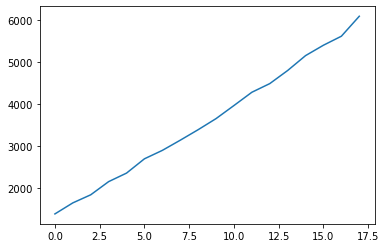

In [226]:
plt.plot(perplexity)

In [200]:
def user_user_factorization(df, ind, csm, k, verbose = False):
    if verbose:
        id_where = int(np.where(df.columns == 'buyerId')[0])
        print('<1. cosine similarity>')
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            print(f'userID : {df.iloc[num, id_where]} - ', csm[ind][num])
        print('\n')
        print("<2. Top - K user's Category list>")
        print(f'target - {df.iloc[ind, id_where]}',
              set(df.columns[np.where(df.iloc[ind] > 0)]).difference(['buyerId']))
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            print(f'UserID - {df.iloc[num, id_where]}',
                  set(df.columns[np.where(df.iloc[num] > 0)]).difference(['buyerId']))
        print('\n')
        print("<3. Top - K User's intersection List>")
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            print(f'UserID - {df.iloc[num, id_where]}',
            set(df.columns[np.where(df.iloc[ind] > 0)]).intersection(
            set(df.columns[np.where(df.iloc[num] > 0)])).difference(['buyerId']))
        print('\n')
        print("<4. Top - K User's Product List>")
        print(f'target - {df.iloc[ind, id_where]}', "\n")
        display(orderseries_merchandise[orderseries_merchandise['buyerId'] == df.iloc[ind,0]][['prodName',
                                                                                              'cat_0',
                                                                                              'cat_1',
                                                                                              'cat_2']].drop_duplicates())
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            print(f'UserID - {df.iloc[num, id_where]}',"\n")
            display(orderseries_merchandise[orderseries_merchandise['buyerId'] == df.iloc[num,0]][['prodName',
                                                                                              'cat_0',
                                                                                              'cat_1',
                                                                                              'cat_2']].drop_duplicates())
    return np.sort(csm[ind])[-k:-1]

In [201]:
lda = LatentDirichletAllocation(n_components=8, random_state=42)
lda.fit(favorite_pivot.iloc[:,1:])

doc_topic = lda.transform(favorite_pivot.iloc[:,1:])

In [202]:
cluster_topic = \
pd.concat([favorite_pivot['buyerId'].reset_index(drop = True),
           Series(np.argmax(doc_topic, axis = 1), name = 'cluster'),
           Series(np.max(doc_topic, axis = 1), name = 'value')],
         axis = 1)

In [205]:
k = 5

In [206]:
for cluster in range(0,9):
    brandid =  favorite_pivot.columns[np.argsort(lda.components_[cluster])][::-1][0:k]
    dirichlet_value = np.sort(lda.components_[cluster])[::-1][0:k]

    display(pd.merge(DataFrame({'brandId' : brandid,
                        'cumsum' : Series(dirichlet_value / np.sum(lda.components_[cluster]),
                                           name = 'value')}),
             pd.merge(dataframe_seller,Series(brandid))[['brandId','name']]
            )
           )

brandId    cumsum  name
0   15832  0.118396   크리시
1   15189  0.051113  SS제화
2   19258  0.041638    다나
3   17349  0.028307    베일
4   14585  0.018141   미즈올

brandId    cumsum   name
0   19134  0.050857    원마일
1   14104  0.042189     베니
2   15862  0.024456     다온
3   10937  0.021593    쿠스비
4   10369  0.020099  헤이시스터

brandId    cumsum  name
0    8566  0.085560   유니엘
1   10223  0.069727  버터핑거
2   18483  0.068497   파라또
3    5355  0.057527   모티브
4   15106  0.043800     덴

brandId    cumsum   name
0   12078  0.045144  미니팩토리
1    9571  0.024210   빙고슈즈
2   16453  0.022485   제이벨라
3   17230  0.017353     하이
4   19475  0.016580    플레이

brandId    cumsum         name
0    8663  0.031639          투레빗
1   16843  0.021481           퍼플
2    4301  0.021387  PRORSUM 프로썸
3   13018  0.019146  준(JUN)_유아동복
4   17870  0.018335        아이니드어

brandId    cumsum       name
0   15675  0.028778       3355
1    9540  0.021835  디어제이 BY민짱
2    7755  0.019202         플랫
3   12506  0.018086        프렌시
4   18149  0.015606    얼그레이피플

brandId    cumsum    name
0   16808  0.037448     알라딘
1   13419  0.033492     마징가
2    6196  0.026725     아델라
3    6228  0.024693  Q.C 큐시
4   19466  0.023471    바게트몽

brandId    cumsum  name
0   12010  0.084631    지후
1   16875  0.052527    크림
2    8205  0.048219  루나루즈
3   10965  0.045923    스텝
4   19370  0.041412  벽진상사

IndexError: index 8 is out of bounds for axis 0 with size 8

In [227]:
def visualize_elbowmethod(data, param_init='random', param_n_init=10, param_max_iter=300):
    distortions = []
    for i in range(1, 20):
        km = KMeans(n_clusters=i, init=param_init, n_init=param_n_init, max_iter=param_max_iter, random_state=42)
        km.fit(data)
        distortions.append(km.inertia_)
    return distortions

In [228]:
elbows = visualize_elbowmethod(favorite_pivot_scailing.iloc[:,1:])

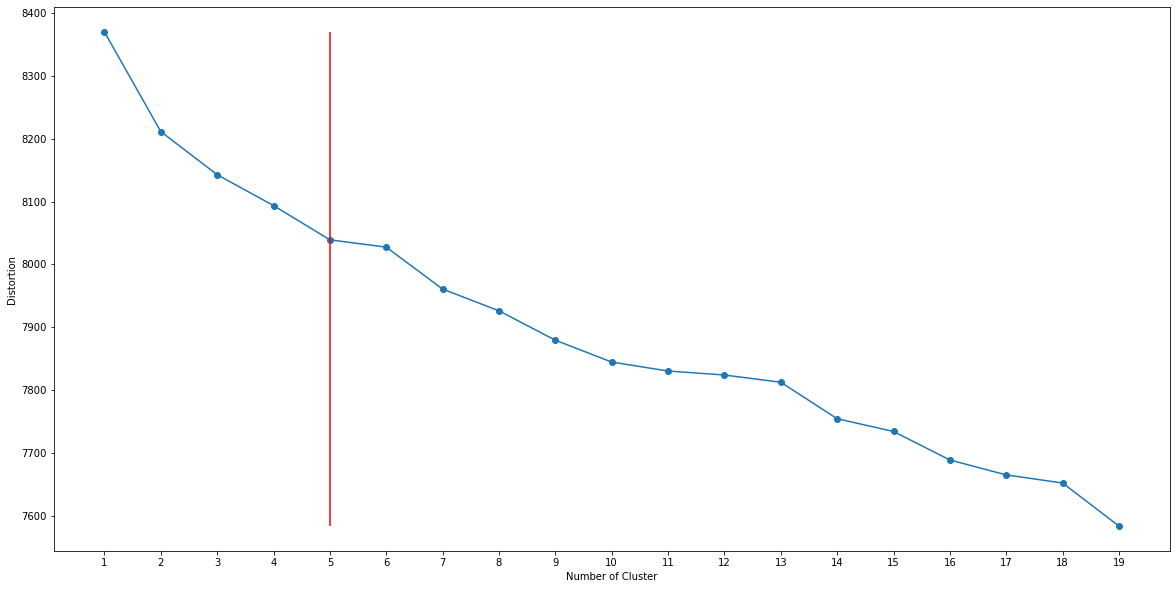

In [229]:
plt.figure(figsize = (20,10))
plt.plot(range(1, 20), elbows, marker='o')
plt.xlabel('Number of Cluster')
plt.ylabel('Distortion')
plt.xticks(range(0,20))
plt.vlines(5, ymin = min(elbows), ymax = max(elbows), color = 'red')
plt.show()

In [230]:
def compute_bic(kmeans,X):
    """
    Computes the BIC metric for a given clusters

    Parameters:
    -----------------------------------------
    kmeans:  List of clustering object from scikit learn

    X     :  multidimension np array of data points

    Returns:
    -----------------------------------------
    BIC value
    """
    # assign centers and labels
    centers = [kmeans.cluster_centers_]
    labels  = kmeans.labels_
    #number of clusters
    m = kmeans.n_clusters
    # size of the clusters
    n = np.bincount(labels)
    #size of data set
    N, d = X.shape

    #compute variance for all clusters beforehand
    cl_var = (1.0 / (N - m) / d) * sum([sum(distance.cdist(X.iloc[labels == i], [centers[0][i]], 
             'euclidean')**2) for i in range(m)])

    const_term = 0.5 * m * np.log(N) * (d+1)

    BIC = np.sum([n[i] * np.log(n[i]) -
               n[i] * np.log(N) -
             ((n[i] * d) / 2) * np.log(2*np.pi*cl_var) -
             ((n[i] - 1) * d/ 2) for i in range(m)]) - const_term

    return(BIC)

In [231]:
kmeans = [KMeans(n_clusters = i).fit(favorite_pivot_scailing.iloc[:,1:]) for i in range(1,20)]

bic = [compute_bic(kmeansi, favorite_pivot_scailing.iloc[:,1:]) for kmeansi in kmeans]

In [232]:
plt.figure(figsize = (20,10))
plt.plot(bic)
plt.xticks(range(1,20))
plt.vlines(5, ymin = min(bic), ymax = max(bic), color = 'red')
plt.show()

In [233]:
kmeans = KMeans(n_clusters = 5, random_state=42)

In [234]:
cluster = kmeans.fit_predict(favorite_pivot_scailing.iloc[:,1:])

In [235]:
Series(cluster).value_counts()

3    3699
4     270
1     165
2      82
0      50
dtype: int64

In [236]:
favorite_pivot_scailing_cluster = favorite_pivot_scailing.copy()

In [237]:
favorite_pivot_scailing_cluster['cluster_kmeans'] = cluster

In [238]:
cluster_0 = favorite_pivot_scailing_cluster[
    favorite_pivot_scailing_cluster['cluster_kmeans'] == 0].iloc[:,1:-1]

cluster_0_power = pd.merge(Series(cluster_0.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster_0.cumsum().iloc[-1,:] / cluster_0.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_0_power = \
pd.merge(cluster_0_power.reset_index(),
         dataframe_seller[['brandId','name']])

cluster_0_power[cluster_0_power['power'] > 0.1]

brandId  frequency     power name
0    18482  42.149551  0.842991   홀리

In [239]:
cluster_0 = favorite_pivot_scailing_cluster[
    favorite_pivot_scailing_cluster['cluster_kmeans'] == 1].iloc[:,1:-1]

cluster_0_power = pd.merge(Series(cluster_0.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster_0.cumsum().iloc[-1,:] / cluster_0.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_0_power = \
pd.merge(cluster_0_power.reset_index(),
         dataframe_seller[['brandId','name']])

cluster_0_power[cluster_0_power['power'] > 0.1]

brandId  frequency     power       name
0    15147  81.332910  0.492927   껌딱지_유아동복
1    14149  67.839878  0.411151  허클베리_유아동복
2    10238  51.408004  0.311564   나무2_유아동복
3    14969  25.817026  0.156467    지니_유아동복
4    12888  24.891730  0.150859     컵_유아동복
5     8569  20.253789  0.122750   빠오빼_유아동복
6    19191  19.873572  0.120446         니코

In [240]:
cluster_0 = favorite_pivot_scailing_cluster[
    favorite_pivot_scailing_cluster['cluster_kmeans'] == 2].iloc[:,1:-1]

cluster_0_power = pd.merge(Series(cluster_0.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster_0.cumsum().iloc[-1,:] / cluster_0.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_0_power = \
pd.merge(cluster_0_power.reset_index(),
         dataframe_seller[['brandId','name']])

cluster_0_power[cluster_0_power['power'] > 0.1]

brandId  frequency     power  name
0     7760   61.50417  0.750051  루미에르

In [241]:
cluster_0 = favorite_pivot_scailing_cluster[
    favorite_pivot_scailing_cluster['cluster_kmeans'] == 3].iloc[:,1:-1]

cluster_0_power = pd.merge(Series(cluster_0.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster_0.cumsum().iloc[-1,:] / cluster_0.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_0_power = \
pd.merge(cluster_0_power.reset_index(),
         dataframe_seller[['brandId','name']])

cluster_0_power[cluster_0_power['power'] > 0.1]

Empty DataFrame
Columns: [brandId, frequency, power, name]
Index: []

In [242]:
cluster_0 = favorite_pivot_scailing_cluster[
    favorite_pivot_scailing_cluster['cluster_kmeans'] == 4].iloc[:,1:-1]

cluster_0_power = pd.merge(Series(cluster_0.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster_0.cumsum().iloc[-1,:] / cluster_0.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_0_power = \
pd.merge(cluster_0_power.reset_index(),
         dataframe_seller[['brandId','name']])

cluster_0_power[cluster_0_power['power'] > 0.1]

brandId   frequency     power      name
0     8569  147.374012  0.545830  빠오빼_유아동복
1    10238   80.385812  0.297725  나무2_유아동복
2    19191   68.984661  0.255499        니코

## 위시리스트 절단

In [3]:
wishes = {"SQL" : "select wis.\"brandId\"" + (
                  ", \"userId\"") + (
                  ", \"productId\"") + (
                  ", \"createdAt\"") + (
                  " from wishes wis where ") + (
                  "wis.status = 100 "),
            "columns" : ['brandId','buyerId','productId', 'createdAt']}

In [4]:
conn = psycopg2.connect("host=restore.cy1gcw3mvrbf.ap-northeast-2.rds.amazonaws.com port=5432 user=linkshops password=$dpdlvmflf4 dbname=linkshops")

curs = conn.cursor()

curs.execute(wishes['SQL'])
dataframe_wishes = DataFrame(curs)
dataframe_wishes.columns = wishes['columns']
conn.close()

# 데이터 전처리

## favorite_brand 기반

### 최근 판매이력이 존재하는 브랜드만 추출

##### 대부분의 바이어가 추가한 브랜드는 제외

In [34]:
favorite['value'] = 1

favorite = pd.merge(favorite,
         orderseries_merchandise['brandId'].drop_duplicates())

favorite = pd.merge(favorite,
         orderseries_merchandise['buyerId'].drop_duplicates())

In [35]:
favorite_pivot = \
favorite[['brandId','buyerId','value']].pivot_table(index = 'buyerId',
                                                      columns = 'brandId',
                                                     values = 'value')
favorite_pivot = favorite_pivot.reset_index()

favorite_pivot = favorite_pivot.fillna(0)

In [36]:
favorite_pivot['values'] = np.log1p(favorite_pivot.iloc[:,1:].sum(axis = 1))

In [37]:
favorite_pivot = favorite_pivot[favorite_pivot['values'] >= 2]
favorite_pivot = favorite_pivot.drop(['values'], axis = 1)

In [38]:
favorite_pivot_t = favorite_pivot.iloc[:,1:].T

In [39]:
favorite_pivot_t['values'] = np.log1p(favorite_pivot_t.sum(axis = 1))

In [40]:
favorite_pivot_t = favorite_pivot_t[favorite_pivot_t['values'] >= 2]

In [41]:
favorite_pivot = pd.concat([favorite_pivot['buyerId'],
            favorite_pivot_t.T.drop('values')],
         axis = 1)

In [42]:
wishes = dataframe_wishes.copy()

In [43]:
wishes_reduced = \
pd.merge(wishes,
         orderseries_merchandise[['productId']].drop_duplicates().astype('int'))


wishes_reduced = wishes_reduced[['buyerId','productId']].drop_duplicates()

wishes_reduced['values'] = 1

buyerId_dict = {j : i for i,j in enumerate(wishes_reduced['buyerId'].unique())}
productId_dict = {j : i for i,j in enumerate(wishes_reduced['productId'].unique())}

wishes_reduced['buyerId'] = [buyerId_dict[i] for i in wishes_reduced['buyerId']]
wishes_reduced['productId'] = [productId_dict[i] for i in wishes_reduced['productId']]

row = np.array(wishes_reduced['productId'])
col = np.array(wishes_reduced['buyerId'])
values = np.array(wishes_reduced['values'])

In [258]:
# 메모리 이슈때문에 활용할 수 없다

'''
wishes = wishes[['buyerId','productId']].drop_duplicates()

wishes['values'] = 1

buyerId_dict = {j : i for i,j in enumerate(wishes['buyerId'].unique())}
productId_dict = {j : i for i,j in enumerate(wishes['productId'].unique())}

wishes['buyerId'] = [buyerId_dict[i] for i in wishes['buyerId']]
wishes['productId'] = [productId_dict[i] for i in wishes['productId']]


row = np.array(wishes['productId'])
col = np.array(wishes['buyerId'])
values = np.array(wishes['values'])
'''

In [44]:
wishes_coo = scipy.sparse.coo_matrix((values, (row, col)))

wishes_coo = wishes_coo.astype('float64')

wishes_coo = wishes_coo.toarray()

In [47]:
# 지나치게 sparse하여 SVD 알고리즘이 분해에 실패한다.

'''
u,s,v = np.linalg.svd(wishes_coo, full_matrices = False)

del wishes_coo
gc.collect()

#특이값의 총합, 즉 에너지가 90%가 넘는 지점의 축을 도출한다.

energy_where = np.max(np.where(s.cumsum() / s.sum() < 0.9))

#위에서 도출한 값을 토대로 상위 53개 특이값에 해당하는 축들을 뽑아 재조합한다.
print(energy_where)
print(s.shape)

wishes_coo = np.dot(u[:,0:energy_where], np.dot(np.diag(s[0:energy_where]), v[0:energy_where]))
'''

'\nu,s,v = np.linalg.svd(wishes_coo, full_matrices = False)\n\ndel wishes_coo\ngc.collect()\n\n#특이값의 총합, 즉 에너지가 90%가 넘는 지점의 축을 도출한다.\n\nenergy_where = np.max(np.where(s.cumsum() / s.sum() < 0.9))\n\n#위에서 도출한 값을 토대로 상위 53개 특이값에 해당하는 축들을 뽑아 재조합한다.\nprint(energy_where)\nprint(s.shape)\n\nwishes_coo = np.dot(u[:,0:energy_where], np.dot(np.diag(s[0:energy_where]), v[0:energy_where]))\n'

##### SVD 행렬분해 후 90% 에너지 재조합

In [46]:
u,s,v = np.linalg.svd(favorite_pivot.iloc[:,1:].to_numpy(), full_matrices = False)

#특이값의 총합, 즉 에너지가 90%가 넘는 지점의 축을 도출한다.

energy_where = np.max(np.where(s.cumsum() / s.sum() < 0.9))

#위에서 도출한 값을 토대로 상위 53개 특이값에 해당하는 축들을 뽑아 재조합한다.
print(energy_where)
print(s.shape)
order_matrix_reconstruct = np.dot(u[:,0:energy_where], np.dot(np.diag(s[0:energy_where]), v[0:energy_where]))


1620
(2584,)


In [47]:
csm_total = cosine_similarity(order_matrix_reconstruct)

In [48]:
del order_matrix_reconstruct

## orderseries 기반

In [23]:
def min_max_scailing(x, except_col):
    if except_col is not None:
        max_value = np.max(x.drop([except_col]))
        min_value = np.min(x.drop([except_col]))
        temp = (x.drop([except_col]) - min_value) / (max_value - min_value)
        temp = DataFrame(temp).T
        return pd.concat([DataFrame(x[[except_col]]).T, temp], axis = 1)
    else :
        max_value = np.max(x)
        min_value = np.min(x)
        temp = (x - min_value) / (max_value - min_value)
        #temp = DataFrame(temp).T
        return temp

In [24]:
a = orderseries_merchandise.groupby('buyerId')[['brandId']].value_counts().reset_index()

In [25]:
favorite_pivot = a.pivot_table(index = 'buyerId',
                               columns = 'brandId',
                               values = 0)
favorite_pivot = favorite_pivot.reset_index()

favorite_pivot = favorite_pivot.fillna(0)

In [26]:
favorite_pivot['values'] = favorite_pivot.iloc[:,1:].apply(lambda x : np.exp(max(x) / (np.std(x) + 1)), axis = 1)

In [27]:
favorite_pivot = favorite_pivot[favorite_pivot['values'] >= 5]
favorite_pivot = favorite_pivot.drop(['values'], axis = 1)

favorite_pivot_t = favorite_pivot.T

favorite_pivot_t['values'] = favorite_pivot_t.iloc[1:,:].apply(lambda x : np.exp(max(x) / (np.std(x) + 1)), axis = 1)

In [28]:
favorite_pivot_t = favorite_pivot_t[favorite_pivot_t['values'] > 3]

In [29]:
favorite_pivot = pd.concat([favorite_pivot['buyerId'],
            favorite_pivot_t.T.drop('values')],
         axis = 1)

In [30]:
favorite_pivot_scailing = favorite_pivot.apply(lambda x : min_max_scailing(x, 'buyerId'), axis = 1)

favorite_pivot_scailing = pd.concat(favorite_pivot_scailing.values)

# Modeling

## 1) Matrix Factorization

### (1) Singular Value Decomposition

#### - 최근 판매이력 존재 브랜드만 추출

In [50]:
def min_max_scailing(x, except_col):
    if except_col is not None:
        max_value = np.max(x.drop([except_col]))
        min_value = np.min(x.drop([except_col]))
        temp = (x.drop([except_col]) - min_value) / (max_value - min_value)
        temp = DataFrame(temp).T
        return pd.concat([DataFrame(x[[except_col]]).T, temp], axis = 1)
    else :
        max_value = np.max(x)
        min_value = np.min(x)
        temp = (x - min_value) / (max_value - min_value)
        #temp = DataFrame(temp).T
        return temp

In [51]:
def softmax_function(x):
    max_val = np.max(x)
    denominator = np.sum(np.exp(x - max_val))
    numerator = np.exp(x - max_val)
    return numerator / denominator

In [65]:
def making_image_list(df,
                      orderseries_merchandise,
                      sort_col = None,
                      size = (200,150)):

    if sort_col == None:
        sort_col = ['target_prodId',
                  'param']
    
    urls = pd.merge(orderseries_merchandise,
                    Series(df['target_prodId'].unique(), name = 'productId', dtype='str')
                    )[['productId','images']].drop_duplicates().values

    [os.system("curl http:" + i + f" > ./temp/target/{num}.jpg") for num, i in urls]
    frame_image = pd.concat([
                    DataFrame({'target_prodId' : num,
                            'img' : [f'<img src=./temp/target/{num}.jpg + \
                             style="width:{size[0]}px;height:{size[1]}px;">']}) for num, i in urls])    

    frame_image = frame_image.astype({'target_prodId' : int})

    urls = df[['target_prodId', 
               'images', 
               'productId', 
               'param',
               'prodName',
               'productId']].dropna().values
    [os.system("curl http:" + i[1] + f" > ./temp/retrieval/{i[2]}.jpg") for num, i in enumerate(urls)]

    frame_image_temp = pd.concat([DataFrame({'target_prodId' : i[0],
                                            'img' : [f'<img src=./temp/retrieval/{i[2]}.jpg + \
                                             style="width:{size[0]}px;height:{size[1]}px;">'],
                                             'param' : i[3],
                                             'prodName' : i[4],
                                             'productId' : i[5]}) 
                                  for num, i in enumerate(urls)])

    frame_image = pd.merge(frame_image,
                           frame_image_temp,
                          on = 'target_prodId',
                          how = 'left').sort_values(sort_col, ascending = False)
    return frame_image

In [174]:
def user_user_factorization(df, 
                            orderseries_merchandise,
                            ind, 
                            csm, 
                            k, 
                            threshold = 0.2, 
                            verbose = False,
                           columns = None ):
    
    if columns is None:
        columns = ['prodName',
                  'productId',
                  'brandId',
                  'buyerId',
                  'brandName',
                  'cat_0',
                  'cat_1',
                  'cat_2']
    
    if verbose:
        id_where = int(np.where(df.columns == 'buyerId')[0])
        print('<1. cosine similarity>')
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            if csm[ind][num] < threshold:
                continue
            print(f'userID : {df.iloc[num, id_where]} - ', csm[ind][num])
        print('\n')
        print("<2. Top - K user's Category list>")
        print(f'target - {df.iloc[ind, id_where]}',
              set(df.columns[np.where(df.iloc[ind] > 0)]).difference(['buyerId']))
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            if csm[ind][num] < threshold:
                continue
            print(f'UserID - {df.iloc[num, id_where]}',
                  set(df.columns[np.where(df.iloc[num] > 0)]).difference(['buyerId']))
        print('\n')
        print("<3. Top - K User's intersection List>")
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            if csm[ind][num] < threshold:
                continue
            print(f'UserID - {df.iloc[num, id_where]}',
            set(df.columns[np.where(df.iloc[ind] > 0)]).intersection(
            set(df.columns[np.where(df.iloc[num] > 0)])).difference(['buyerId']))
        print('\n')
        print("<4. Top - K User's difference List>")
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            if csm[ind][num] < threshold:
                continue
            print(f'UserID - {df.iloc[num, id_where]}',
            set(df.columns[np.where(df.iloc[num] > 0)]).difference(
            set(df.columns[np.where(df.iloc[ind] > 0)])).difference(['buyerId']))
        print('\n')
        print("<5. Top - K User's Product List>")
        print(f'target - {df.iloc[ind, id_where]}', "\n")
        display(orderseries_merchandise[orderseries_merchandise['buyerId'] == df.iloc[ind,0]][columns].drop_duplicates())
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            if csm[ind][num] < threshold:
                continue
            print(f'UserID - {df.iloc[num, id_where]}',"\n")
            display(orderseries_merchandise[orderseries_merchandise['buyerId'] == df.iloc[num,0]][columns].drop_duplicates())
    
    product_list = orderseries_merchandise[orderseries_merchandise['buyerId'] == df.iloc[ind,0]][columns].drop_duplicates()
    for num in np.argsort(csm[ind])[-k:-1][::-1]:
        if csm[ind][num] < threshold:
            continue
        product_list = \
        pd.concat([product_list,
                  orderseries_merchandise[orderseries_merchandise['buyerId'] == df.iloc[num,0]][columns].drop_duplicates()],
                  axis = 0).drop_duplicates()

    return product_list

In [175]:
def profiling_prepare(df, 
                      orderseries_merchandise,
                      prod_id, 
                      csm, 
                      k, 
                      sort_col = None,
                      size = (150,250), 
                      verbose = False, 
                      image = True,
                      threshold = 1,
                     columns = None):
    
    if columns is None:
        columns = ['prodName',
                   'productId',
                   'brandId',
                   'brandName',
                   'images',
                   'cat_0',
                   'cat_1',
                   'cat_2']
    
    df = df.copy()
    df['index'] = df.index
    ind_list = pd.merge(df, Series(prod_id, name = 'productId'))['index'].values
    id_where = int(np.where(df.columns == 'productId')[0])
    if verbose:
        print('<1. cosine similarity>')
        for ind in ind_list: 
            print(f'target - {df.iloc[ind, id_where]}', "\n")
            for num in np.argsort(csm[ind])[-k:-1][::-1]:
                if csm[ind][num] < threshold:
                    continue
                print(f'productID : {df.iloc[num, id_where]} - ', csm[ind][num])
       
    target_prod = pd.merge(orderseries_merchandise.astype({'productId' : int}),
                           Series(prod_id, name = 'productId'))[columns].drop_duplicates()
    
    product_list = DataFrame()
    for ind in ind_list:
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            if csm[ind][num] < threshold:
                continue
            prod_temp = orderseries_merchandise[
                            orderseries_merchandise['productId'] == str(df.iloc[num,0])][columns].drop_duplicates()
            prod_temp['target_prodId'] = df.iloc[ind, 0]
            prod_temp['param'] = csm[ind][num]

            product_list = pd.concat([product_list, prod_temp], axis = 0)
    
    if product_list.shape[0] == 0:
        print('카테고리가 일치하는 상품이 없습니다')
        return target_prod, None, None
    
    if image:
        frame_image = making_image_list(product_list, orderseries_merchandise, sort_col)
        
        return target_prod, product_list, frame_image
    
    else :
        return target_prod, product_list, None

In [176]:
def merchandise_profiling(df,
                             X_character, 
                             productId_dict,
                             k,
                             sort_col = None,
                             size = (200, 150),
                             verbose = False,
                             threshold = 0.0,
                            image = True):
    
    product_list = DataFrame()
    
    for target_id in df['target_prodId'].unique():
        df_temp = df[df['target_prodId'] == target_id]
        ind_list = list()
        for i in df_temp[df_temp['target_prodId'] == target_id]['productId'].astype('int'):
            try:
                ind_list.append(productId_dict[i])
            except :
                continue
        X_profile = DataFrame([X_character[i] for i in ind_list])
        X_profile['productId'] = [{i : j for j,i in productId_dict.items()}[k] for k in ind_list]
        
        try:
            target = X_character[productId_dict[target_id]].reshape(1,-1)
        except :
            continue
        X_gen = X_profile.iloc[:,:-1].iterrows()
        
        param = [cosine_similarity(target, i[1].to_numpy().reshape(1,-1))[0][0] for i in X_gen]
        order = np.argsort(param)[::-1][0:k]
        df_temp = df_temp.iloc[order,:]
        df_temp['param'] = np.sort(param)[::-1][0:k]
        
        product_list = pd.concat([product_list, df_temp])
    
    if image:
        frame_image = making_image_list(product_list, orderseries_merchandise, sort_col)
        return product_list, frame_image
    else :
        return product_list, None

In [188]:
evaluation = dict()

start_time = time.time()

for ind in range(3353, favorite_pivot.shape[0]):
    try:
        b = user_user_factorization(favorite_pivot, 
                                orderseries_merchandise,
                                ind, 
                                csm_total,
                                20, 
                                columns = ['productId',
                                          'brandId',
                                          'buyerId',
                                          'cat_0',
                                          'cat_1',
                                          'cat_2'],
                                threshold = 0.2,
                                verbose = False)

        b['cats'] = b['cat_0'] + b['cat_1'] + b['cat_2']
        b['values'] = 1
        product_profile = b.pivot_table(index = 'productId',
                                        columns = 'cats',
                                        values = 'values').fillna(0).reset_index()

        prod_id = b.loc[b['buyerId'] == b['buyerId'].unique()[0]]['productId'].astype('int').values
        product_profile = product_profile.astype({'productId' : int})
        csm = cosine_similarity(product_profile.iloc[:,1:])
        csm -= np.eye(csm.shape[0])
        targetprod, prod, img = profiling_prepare(product_profile, 
                                      orderseries_merchandise,
                                      prod_id, 
                                      csm, 
                                      k = 5,
                                      columns = ['productId'],
                                      verbose = False, 
                                      image = False,
                                      threshold = 1)

        prod_final, img = merchandise_profiling(prod, 
                                               wishes_coo, 
                                               productId_dict,
                                               k = 5,
                                               image = False,
                                               sort_col = ['param'])
    

        real = \
        np.unique(orderseries_merchandise[
                orderseries_merchandise['buyerId'] == favorite_pivot.iloc[ind, 0]]['productId'].values)

        pred = np.unique(prod_final['productId'])
        evaluation.update({ind : {'precision' : len(set(pred).intersection(real)) / len(set(pred)),
                                  'recall' : len(set(pred).intersection(real)) / len(set(real))}})

    except Exception as e:
        evaluation.update({ind : {'precision' : np.nan,
                                   'recall' : np.nan}})
        print(e)
    finally:   
        if ind % 10 == 0:
            print(time.time() - start_time)
            print(ind)
            print(f"precision_mean : {DataFrame(evaluation.values())['precision'].mean()}")
            print(f"recall_mean : {DataFrame(evaluation.values())['recall'].mean()}")

53961.200533628464
3360
precision_mean : 0.1318148312576108
recall_mean : 0.17643591402812087
카테고리가 일치하는 상품이 없습니다
'NoneType' object is not subscriptable
54107.85266804695
3370
precision_mean : 0.13179568173498846
recall_mean : 0.17643308970827987
54242.328176259995
3380
precision_mean : 0.13185781043112352
recall_mean : 0.17643398320970918
54447.88002419472
3390
precision_mean : 0.13191601620637805
recall_mean : 0.1765217935231344
카테고리가 일치하는 상품이 없습니다
'NoneType' object is not subscriptable
54669.85387587547
3400
precision_mean : 0.13186499331188986
recall_mean : 0.1764205571360538
카테고리가 일치하는 상품이 없습니다
'NoneType' object is not subscriptable
54837.00077390671
3410
precision_mean : 0.13209172923658774
recall_mean : 0.17641993410406442
카테고리가 일치하는 상품이 없습니다
'NoneType' object is not subscriptable
카테고리가 일치하는 상품이 없습니다
'NoneType' object is not subscriptable
카테고리가 일치하는 상품이 없습니다
'NoneType' object is not subscriptable
54932.52964639664
3420
precision_mean : 0.1319231187672975
recall_mean : 0.17626590

66615.79495882988
4050
precision_mean : 0.13236343940921683
recall_mean : 0.17570626903736222
카테고리가 일치하는 상품이 없습니다
'NoneType' object is not subscriptable
67022.30980396271
4060
precision_mean : 0.13235091826200285
recall_mean : 0.17558428472181556
카테고리가 일치하는 상품이 없습니다
'NoneType' object is not subscriptable
67134.26054382324
4070
precision_mean : 0.13227226559701802
recall_mean : 0.17559493021302341
67418.509598732
4080
precision_mean : 0.13228709332052305
recall_mean : 0.1756034704298748
67552.0693256855
4090
precision_mean : 0.132322785837371
recall_mean : 0.17577738709389135
67645.52003455162
4100
precision_mean : 0.1322554063520981
recall_mean : 0.1756929244906613
67757.88510990143
4110
precision_mean : 0.13200779339375873
recall_mean : 0.17546955824956928
67829.62146449089
4120
precision_mean : 0.13185808850728695
recall_mean : 0.17532459458571964
67966.53106093407
4130
precision_mean : 0.1317717164616896
recall_mean : 0.17530983494574048
68106.29147577286
4140
precision_mean : 0.131

In [ ]:
DataFrame(evaluation.values())

##### 계층적 유저 협업 필터링

In [409]:
def user_user_factorization_2(df, ind, csm, k, prod_k, size = (150,250), verbose = False, no_duplicated = False, threshold = 0.6):
    if verbose:
        id_where = int(np.where(df.columns == 'buyerId')[0])
        print('<1. cosine similarity>')
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            if csm[ind][num] < threshold:
                continue
            print(f'userID : {df.iloc[num, id_where]} - ', csm[ind][num])
        print('\n')
        print("<2. Top - K user's Category list>")
        print(f'target - {df.iloc[ind, id_where]}',
              set(df.columns[np.where(df.iloc[ind] > 0)]).difference(['buyerId']))
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            if csm[ind][num] < threshold:
                continue
            print(f'UserID - {df.iloc[num, id_where]}',
                  set(df.columns[np.where(df.iloc[num] > 0)]).difference(['buyerId']))
        print('\n')
        print("<3. Top - K User's intersection List>")
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            if csm[ind][num] < threshold:
                continue
            print(f'UserID - {df.iloc[num, id_where]}',
            set(df.columns[np.where(df.iloc[ind] > 0)]).intersection(
            set(df.columns[np.where(df.iloc[num] > 0)])).difference(['buyerId']))
        print('\n')
        print("<4. Top - K User's difference List>")
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            if csm[ind][num] < threshold:
                continue
            print(f'UserID - {df.iloc[num, id_where]}',
            set(df.columns[np.where(df.iloc[num] > 0)]).difference(
            set(df.columns[np.where(df.iloc[ind] > 0)])).difference(['buyerId']))
        print('\n')
        print("<5. Top - K User's Product List>")
        print(f'target - {df.iloc[ind, id_where]}', "\n")
    target_prod = orderseries_merchandise[orderseries_merchandise['buyerId'] == df.iloc[ind,0]][['prodName',
                                                                                           'productId',
                                                                                           'brandId',
                                                                                           'brandName',
                                                                                           'images',
                                                                                           'cat_0',
                                                                                           'cat_1',
                                                                                           'cat_2']].drop_duplicates()
    if verbose:
        display(target_prod)
    
    product_list = DataFrame()
    
    urls = target_prod[['images']].drop_duplicates().values
    [os.system("curl http:" + i[0] + f" > ./temp/target/{df.iloc[ind,0]}_{num}.jpg") for num, i in enumerate(urls)]
    frame_image = DataFrame([f'<img src=./temp/target/{df.iloc[ind,0]}_{num}.jpg + \
                    style="width:{size[0]}px;height:{size[1]}px;">' for num in range(len(urls))]).T
    
    prod = target_prod[['cat_0', 'cat_1']].drop_duplicates()
    prod['cat_sort'] = prod['cat_0'] + prod['cat_1']
    param = prod['cat_sort'].value_counts().reset_index()
    param.columns = ['cat_sort', 0]
    
    for num in np.argsort(csm[ind])[-k:-1][::-1]:
        if csm[ind][num] < threshold:
            continue
        prod_temp = \
        orderseries_merchandise[orderseries_merchandise['buyerId'] == df.iloc[num,0]][['prodName',
                                                                          'productId',
                                                                          'images',
                                                                          'buyerId',
                                                                          'brandId',
                                                                          'brandName',
                                                                          'cat_0',
                                                                          'cat_1',
                                                                          'cat_2']].drop_duplicates()
        if no_duplicated:
            no_duplicated_id = set(prod_temp['productId']).difference(target_prod['productId'])
            
            prod_temp = pd.merge(prod_temp,
                    Series(list(no_duplicated_id), name = 'productId'),
                    on = 'productId')
            if len(set(prod_temp['productId']).intersection(target_prod['productId'])) > 0:
                print(f"{set(prod_temp['productId']).intersection(target_prod['productId'])} is duplicated")
        
        print(f'UserID - {df.iloc[num, id_where]}',"\n")
        display(prod_temp)
        
        prod_temp['cat_sort'] = prod_temp['cat_0'] + prod_temp['cat_1']
        product_list = \
        pd.concat([product_list, prod_temp], axis = 0)

    param = pd.merge(param,
                    product_list[['cat_sort']].drop_duplicates(),
                    )
    param = param.set_index('cat_sort')
    param = param.apply(lambda x : softmax_function(x))
    portion = [(i[0], int(prod_k * i[1])) 
                 if int(prod_k * i[1])> 0 
                 else (i[0], 1) for i in param[0].items()]
    if np.sum(np.array(portion)[:,1].astype('int')) < prod_k:
        remain_num = prod_k - np.sum(np.array(portion)[:,1].astype('int'))
        n = 1
        while True:
            temp = [1 for i in range(len(portion))]
            if remain_num > np.sum(np.array(portion)[:,1].astype('int')):
                portion = [(i[0], i[1] + j) for i,j in zip(portion, temp)]
            else :
                remain_num -= np.sum(np.array(portion)[:,1].astype('int'))
                temp = temp[0:remain_num] + [0 for i in range(0, len(temp) - remain_num)]
                portion = [(i[0], i[1] + j) for i,j in zip(portion, temp)]
                break
    product_list = \
            pd.concat([pd.merge(product_list,
                                Series(i[0], name = 'cat_sort')).iloc[0:i[1]] for i in portion])
    target_prod['index'] = range(0, target_prod.shape[0])
    target_prod['cat_sort'] = target_prod['cat_0'] + target_prod['cat_1']
    ## reindexing
    reindex = \
    pd.merge(target_prod, 
             Series([i[0] for i in portion], name = 'cat_sort'),
             on = 'cat_sort')['index'].values.tolist()
    print(reindex)
    reindex.extend(list(set([i for i in range(0, target_prod.shape[0])]).difference(reindex)))
    frame_image = frame_image.T.iloc[reindex,:].reset_index(drop = True).T
    
    urls = product_list[['images']].dropna().values
    [os.system("curl http:" + i[0] + f" > ./temp/retrieval/{df.iloc[num,0]}_{nums}.jpg") for nums, i in enumerate(urls)]
    frame_image_temp = DataFrame([f'<img src=./temp/retrieval/{df.iloc[num,0]}_{nums}.jpg + \
                                    style="width:{size[0]}px;height:{size[1]}px;">' for nums in range(len(urls))])
    frame_image = pd.concat([frame_image, frame_image_temp.T])
    return np.sort(csm[ind])[-k:-1], product_list, frame_image, portion

In [410]:
ind = np.random.randint(0, favorite_pivot.shape[0])

In [411]:
a, b = user_user_factorization(favorite_pivot, 
                        orderseries_merchandise,
                        ind, 
                        csm_total,
                        20, 
                        threshold = 0.2,
                        verbose = True)

<1. cosine similarity>
userID : 142891 -  0.6512510837473141
userID : 138294 -  0.4693378098397602
userID : 144442 -  0.4693378098397602
userID : 150803 -  0.464085471654398
userID : 167404 -  0.4599809035088276
userID : 145821 -  0.4599809035088276
userID : 168375 -  0.41862398700230774
userID : 165434 -  0.41087291332199877
userID : 170414 -  0.4108580296127408
userID : 159540 -  0.3550074494656616
userID : 156708 -  0.33941632032572466
userID : 151345 -  0.33860328945683305
userID : 130539 -  0.3326385508415098
userID : 121942 -  0.3324424066304172
userID : 91745 -  0.33125039740460144
userID : 134946 -  0.3160345570686666
userID : 138860 -  0.30767746308636823
userID : 134291 -  0.3007829328954723
userID : 163453 -  0.2787601404450531


<2. Top - K user's Category list>
target - 168676 {16912, 19409, 17773, 16233, 19021}
UserID - 142891 {16233, 19409}
UserID - 138294 {17773}
UserID - 144442 {17773}
UserID - 150803 {19021}
UserID - 167404 {19409}
UserID - 145821 {19409}
UserID - 168

prodName productId  \
5817    배색니트가디건                                                    7075355    
17451   클럽맨투맨                                                      6518732    
38204   씨엘드마망 소프트투톤삭스                                              7096833    
57259   디)메이플 레깅스                                                  7085062    
57419   디)도토리 맨투맨                                                  7083397    
57771   디)크림 스카프                                                   7084663    
57964   디)기모띠 집업                                                   7083409    
60363   오)웜 슬로우티                                                   7108403    
64936   (겨울신상) 앤드 폴 코튼 SET                                         7092558    
72675   이너프원피스 #22겨울신상 he                                          7067993    
81190   22겨울 밀크밤 리오귀달이모 FREE                                       7082259    
81799   22겨울 벨로 라봉원피스  S~XL                                        7084836    
81800   A4)22가을 오트밀 하우캉캉원피스                                        6957931    
81929   22겨울 벨로 버터폴라 S~XL                                          7084823    
93391   쁘띠슈슈 루지벨로아부츠컷                                              7063800    
103375  a3)데일리베베.밍크토시레깅스                                           7098377    
104323  데일리베베)반목단가라맨투맨                                             7100182    
160914  N1)G조이 기모청PT겨울베이비유아동키즈쥬니어신상품원피스데님청북유럽러블리빈티지베이직모던공주옷남아옷여아옷  7078486    
173943  바니원피스                                                      7073296    
177873  모모 기모샤원피스                                                  7059012    

        brandId  buyerId           brandName      cat_0         cat_1  \
5817    10238    168676   나무2_유아동복            KIDS       None           
17451   6047     168676   헬로지니                WOMEN      TOPS           
38204   14969    168676   지니_유아동복             KIDS       Shoes/Acc      
57259   15147    168676   껌딱지_유아동복            KIDS       Bottoms        
57419   15147    168676   껌딱지_유아동복            KIDS       Tops           
57771   15147    168676   껌딱지_유아동복            KIDS       Shoes/Acc      
57964   15147    168676   껌딱지_유아동복            KIDS       Tops           
60363   15147    168676   껌딱지_유아동복            KIDS       Tops           
64936   19191    168676   니코                  KIDS       Shoes/Acc      
72675   12888    168676   컵_유아동복              KIDS       Dresses/Sets   
81190   14149    168676   허클베리_유아동복           Kids hats  KIDS           
81799   14149    168676   허클베리_유아동복           KIDS       Dresses/Sets   
81800   14149    168676   허클베리_유아동복           KIDS       Dresses/Sets   
81929   14149    168676   허클베리_유아동복           KIDS       Tops           
93391   19409    168676   쁘띠슈슈(남대문)           KIDS       Bottoms        
103375  10686    168676   메르씨엘(merciel)_유아동복  KIDS       Bottoms        
104323  10686    168676   메르씨엘(merciel)_유아동복  KIDS       Tops           
160914  13008    168676   미쯔_유아동복             KIDS       Bottoms        
173943  13009    168676   에끌레어_유아동복           KIDS       Dresses/Sets   
177873  13089    168676   사과나무_유아동복           KIDS       Dresses/Sets   

              cat_2  
5817    None         
17451   Tees         
38204   Shoes        
57259   Pants        
57419   Tees         
57771   Accessories  
57964   Tees         
60363   Tees         
64936   Accessories  
72675   Dresses      
81190   Shoes/Acc    
81799   Dresses      
81800   Dresses      
81929   Tees         
93391   Pants        
103375  Pants        
104323  Tees         
160914  Pants        
173943  Dresses      
177873  Dresses

UserID - 142891 



prodName productId  brandId  buyerId  brandName  cat_0  \
27801   (가을신상) 앤드 골지 타이즈       7014291   8569     142891   빠오빼_유아동복   KIDS    
27828   (가을신상) 어썸 가을 골지 샤 원피스  7003821   8569     142891   빠오빼_유아동복   KIDS    
27871   (가을신상) 앤드 보카시 타이즈      7012717   8569     142891   빠오빼_유아동복   KIDS    
31344   (가을신상) 라라 밍키 원피스       6929903   8569     142891   빠오빼_유아동복   KIDS    
41697   A3)라_꽈배기베스트#가을아동니트조끼   6948213   14969    142891   지니_유아동복    KIDS    
41748   마이베베 베스트양두가디건          7014436   14969    142891   지니_유아동복    KIDS    
170757  앨리샤샤원피스                7002099   14132    142891   블랙핑크_유아동복  KIDS    
174022  파티원피스 (퍼카라별도판매)        6473764   13009    142891   에끌레어_유아동복  KIDS    
174024  체크코트                   7041508   13009    142891   에끌레어_유아동복  KIDS    
387550  안나 뒷리본플랫               6950927   13552    142891   우리두리_아동화   KIDS    
461684  모니카롱OPS                4876631   9426     142891   러브앤헤이트     WOMEN   
510604  파인울  보트넥  원피스          6349670   5871     142891   라운드제이      WOMEN   
561614  메르시 밑주름 롱ops(sale)     6295104   17865    142891   메르시        WOMEN   

               cat_1              cat_2  
27801   Shoes/Acc     Accessories        
27828   Dresses/Sets  Dresses            
27871   Shoes/Acc     Accessories        
31344   Dresses/Sets  Dresses            
41697   Tops          Knitwear           
41748   Tops          Knitwear           
170757  Dresses/Sets  Dresses            
174022  Dresses/Sets  Dresses            
174024  None          None               
387550  Shoes/Acc     Shoes              
461684  DRESSES/SETS  Knit Dresses/Sets  
510604  DRESSES/SETS  Knit Dresses/Sets  
561614  DRESSES/SETS  Knit Dresses/Sets

UserID - 138294 



prodName productId  brandId  buyerId brandName  cat_0  \
275410  겨울신상 기모564 면 밴딩 일자팬츠  5214824   19484    138294   오예        WOMEN   

          cat_1  cat_2  
275410  BOTTOMS  Pants

UserID - 144442 



prodName productId  \
38382   아워 22아워패딩조끼성인  미송필수                                         7012077    
57456   디)샐러드 맨투맨                                                   7083412    
57990   디)웜 데님팬츠                                                    7083094    
58688   바)피그골덴 팬츠                                                   7103912    
59993   바)아뮤즈넥티 주니어                                                 7103911    
82910   A3)22가을 미니봉봉 바스켓맨투맨                                         6947864    
160970  N1)G데미지 기모청PT겨울베이비유아동키즈쥬니어신상품원피스데님청북유럽러블리빈티지베이직모던공주옷남아옷여아옷  7076290    
173432  베이비잼 퍼앤오드리                                                  7098998    
173462  베이비잼 퍼진주                                                    7098952    
242880  곰돌이패치후드                                                     7067380    
242949  핀탁골지바지                                                      7069482    
363841  겨울 벨로아조거PT                                                  7048708    

        brandId  buyerId       brandName  cat_0      cat_1  cat_2  
38382   14969    144442   지니_유아동복         WOMEN  OUTWEAR    Vests  
57456   15147    144442   껌딱지_유아동복        KIDS   Tops       Tees   
57990   15147    144442   껌딱지_유아동복        KIDS   Bottoms    Pants  
58688   15147    144442   껌딱지_유아동복        KIDS   Bottoms    Pants  
59993   15147    144442   껌딱지_유아동복        KIDS   Tops       Tees   
82910   14149    144442   허클베리_유아동복       KIDS   Tops       Tees   
160970  13008    144442   미쯔_유아동복         KIDS   Bottoms    Pants  
173432  13010    144442   안나마리_아동화        KIDS   Shoes/Acc  Shoes  
173462  13010    144442   안나마리_아동화        KIDS   Shoes/Acc  Shoes  
242880  17773    144442   단추_유아동복         KIDS   Tops       Tees   
242949  17773    144442   단추_유아동복         KIDS   Bottoms    Pants  
363841  12973    144442   케빈(CABIN)_유아동복  KIDS   Bottoms    Pants

UserID - 150803 



prodName productId  brandId  buyerId  \
4839    히트기모실내복                           7082222   10238    150803    
5572    푸들팬츠                              7073251   10238    150803    
8128    카라 맨투맨                            6964121   10238    150803    
9743    기모 골지레깅스                          7053700   10238    150803    
10146   포근한 솜솜 바지                         7116215   10238    150803    
13244   아기다람쥐나시                           7164245   10238    150803    
13247   또미pt                              7164239   10238    150803    
22885   (겨울신상) 포크 워머 페이크 폴라               7064538   8569     150803    
23541   (겨울신상) TB 본딩꽃 블라우스                7060733   8569     150803    
24650   (가을신상) 앤드 고탄력 스타킹 B               7012692   8569     150803    
32761   (봄신상) 앨리 와플 차이나 집업                7160128   8569     150803    
32770   (봄신상) 앨리 와플 앨리 조거 팬츠              7160131   8569     150803    
58379   바)멜로우 원피스                         7101111   15147    150803    
58716   봄)헬로우골지티                          6949372   15147    150803    
65356   (겨울신상) 앤드 수면 레깅스 + 양말 SET         7092578   19191    150803    
74411   할로윈호박원피스  #22가을신상 lp              6941185   12888    150803    
74844   노엘팬츠 #22겨울신상 he                   7117660   12888    150803    
75543   모이팬츠 #22가을신상 he                   6973281   12888    150803    
75856   다이아조거팬츠(주니어) #22가을신상mu            6948865   12888    150803    
76142   퀼팅바라클라바 #22겨울신상 ub                7074846   12888    150803    
81617   22겨울 벨로 비엔나팬츠  S~XL               7088959   14149    150803    
81743   22겨울 벨로 비엔나가디건   S~XL             7088964   14149    150803    
82482   A3)22가을 미니봉봉 점핑팬츠                 6947845   14149    150803    
82720   22겨울 미니봉봉 물결스커트 XS~XL             7086721   14149    150803    
83092   F2)22봄 미니봉봉 뮤직팬츠                  6586803   14149    150803    
83289   A3)22가을 미니봉봉 언커트팬츠                6947878   14149    150803    
83954   22겨울 달콤하이 벨벳퀼팅 모자 FREE            7074215   14149    150803    
138872  폭주) 자수 청남방                        7060259   18746    150803    
173684  베이비잼 보들털                          6472699   13010    150803    
178096  도레 반반조거바지                         6965876   13089    150803    
183842  포그니 장갑                            7053984   19338    150803    
234555  H064#벨벳곱창#리본곱창#곱창밴드#벨벳리본#머리끈      7055859   18158    150803    
280866  트루 사선 골지 니트 볼레로                   6935132   19225    150803    
347616  골터치장갑(컬러풀 글로브 겨울 신상 방한 선물 크리스마스)  7046115   16236    150803    
523422  cel심플소가죽벨트19mm                    6876063   9857     150803    

        brandName      cat_0                cat_1                cat_2  
4839    나무2_유아동복   KIDS       Dresses/Sets         Sets                 
5572    나무2_유아동복   KIDS       Bottoms              Pants                
8128    나무2_유아동복   KIDS       Tops                 Tees                 
9743    나무2_유아동복   KIDS       Bottoms              Pants                
10146   나무2_유아동복   KIDS       Bottoms              Pants                
13244   나무2_유아동복   KIDS       Tops                 Tees                 
13247   나무2_유아동복   KIDS       Bottoms              Pants                
22885   빠오빼_유아동복   KIDS       Shoes/Acc            Accessories          
23541   빠오빼_유아동복   KIDS       Tops                 Blouses/Shirts       
24650   빠오빼_유아동복   KIDS       Shoes/Acc            Accessories          
32761   빠오빼_유아동복   KIDS       None                 None                 
32770   빠오빼_유아동복   KIDS       Bottoms              Pants                
58379   껌딱지_유아동복   KIDS       Dresses/Sets         Dresses              
58716   껌딱지_유아동복   KIDS       Tops                 Tees                 
65356   니코         KIDS       Shoes/Acc            Accessories          
74411   컵_유아동복     KIDS       Dresses/Sets         Dresses              
74844   컵_유아동복     KIDS       Bottoms              Pants                
75543   컵_유아동복     KIDS       Bottoms              Pants                
75856   컵_유아동복     KIDS       Bottoms              P

UserID - 167404 



prodName productId  brandId  buyerId  \
21431   sale)아델 기모 레깅스 #레깅스바지       7051255   13088    167404    
21668   sale)동백이 맨투맨티 #티셔츠          7103471   13088    167404    
22131   sale)벨로아 반폴 티 #티셔츠          7050366   13088    167404    
22236   sale)니트기모 팬츠 #바지            7107422   13088    167404    
40264   A3)라_코디레깅스#가을아동칼라골지레깅스      6948336   14969    167404    
66355   (겨울신상) 달 리본 부츠컷 팬츠          7110298   19191    167404    
93379   세일)몰리자가드티                   6969897   19409    167404    
93453   세일)로이지상하셋                   6969920   19409    167404    
93470   카리나스커트                      6969906   19409    167404    
93477   dot캉캉스커트                    6969901   19409    167404    
104972  a3)데일리베베.요즘날씨딱후리스           7047945   10686    167404    
105137  a3)데일리베베.쟈가드부츠컷세트           7047924   10686    167404    
169524  골지포근레깅스                     7107785   14132    167404    
410076  신상)곰돌이 니트 바라클라바 모자 워머(유아용)  7082443   8759     167404    
484699  기모 U스티치 포켓 팬츠 본딩 사이즈        5215214   11078    167404    

                 brandName  cat_0         cat_1      cat_2  
21431   두마리토끼_유아동복          KIDS   Bottoms       Pants      
21668   두마리토끼_유아동복          KIDS   Tops          Tees       
22131   두마리토끼_유아동복          KIDS   Tops          Tees       
22236   두마리토끼_유아동복          KIDS   Bottoms       Pants      
40264   지니_유아동복             KIDS   Bottoms       Pants      
66355   니코                  KIDS   Bottoms       Pants      
93379   쁘띠슈슈(남대문)           KIDS   Tops          Tees       
93453   쁘띠슈슈(남대문)           KIDS   Dresses/Sets  Sets       
93470   쁘띠슈슈(남대문)           KIDS   Bottoms       Skirts     
93477   쁘띠슈슈(남대문)           KIDS   Bottoms       Skirts     
104972  메르씨엘(merciel)_유아동복  KIDS   None          None       
105137  메르씨엘(merciel)_유아동복  KIDS   Dresses/Sets  Sets       
169524  블랙핑크_유아동복           KIDS   Bottoms       Pants      
410076  빛나                  KIDS   Shoes/Acc     Kids hats  
484699  마루이                 WOMEN  BOTTOMS       Pants

UserID - 145821 



prodName productId  brandId  buyerId  \
51639   j5)골니트PT#가을신상                              6918340   2186     145821    
51642   j5)비마이니트#가을신상                              6918200   2186     145821    
53384   A5)호텔Y#가을신상                                6975319   2186     145821    
53535   S5)핸드코리CT#가을신상                             7022321   2186     145821    
54001   S5)털뭉치CT#가을신상                              7022285   2186     145821    
136321  노리카라#니트#반팔니트#로맨틱                           6625571   14117    145821    
146984  러블리 리본 트위드 자켓                              7014985   15579    145821    
146985  진주 하트 러블리 니트 가디건 sale                      7027686   15579    145821    
226111  M3)메모BL                                    6802837   12187    145821    
314537  카프bl 가을신상 블라우스 긴팔 스카프 브이넥                  6944295   4879     145821    
314772  금사자켓                                       6949117   10723    145821    
314775  울자켓                                        6949003   10723    145821    
315033  랍바울자켓                                      6986052   10723    145821    
335726  레종                                         6947957   15974    145821    
350849  레트로자켓                                      6996886   5590     145821    
394858  세일_컬러주름스커트_H라인 플리츠 트임롱치마                   6672349   18842    145821    
412932  트위드퍼프맨투맨 #가을신상 티셔츠 맨투맨 트위드mtm 퍼프소매         6928360   7111     145821    
419026  싱글JK(노카라자켓,여름자켓)                           1668917   5251     145821    
420536  ((파격땡처리))리얼 천연 폭스 전체퍼 데님롱 코트               6569919   18737    145821    
423066  세일 언발주름 sk                                 6737308   5119     145821    
455143  SALE(세일)-포인BL#신상#핀턱#블라우스#데일리#러블리#베이직#라운드넥  6579798   18388    145821    
459368  신상 로지 블라우스 나염 리본 신상                        6942632   12445    145821    
459369  신상 보니 블라우스 신상 셔츠 블라우스 나염 인기 최고             6942602   12445    145821    
498229  샤틴벨크로바지                                    6850525   17602    145821    
546886  진주 트위드자켓 진주단추                              6829208   19122    145821    
551455  핸드하트티                                      6866274   17891    145821    

              brandName  cat_0    cat_1      cat_2  
51639   Adorable(아도러블)   WOMEN  BOTTOMS  Pants      
51642   Adorable(아도러블)   WOMEN  TOPS     Knitwear   
53384   Adorable(아도러블)   WOMEN  OUTWEAR  Cardigans  
53535   Adorable(아도러블)   WOMEN  OUTWEAR  Coats      
54001   Adorable(아도러블)   WOMEN  OUTWEAR  Parkas     
136321  파파라치             WOMEN  TOPS     Knitwear   
146984  마이스타일            WOMEN  OUTWEAR  Jackets    
146985  마이스타일            WOMEN  OUTWEAR  Jackets    
226111  마이영              WOMEN  TOPS     Blouses    
314537  데일리프로젝트          WOMEN  TOPS     Blouses    
314772  룰루랄라             WOMEN  OUTWEAR  Jackets    
314775  룰루랄라             WOMEN  OUTWEAR  Jackets    
315033  룰루랄라             WOMEN  OUTWEAR  Jackets    
335726  오핀               WOMEN  TOPS     Blouses    
350849  SONG(송)          WOMEN  OUTWEAR  Jackets    
394858  올름               WOMEN  BOTTOMS  Skirts     
412932  제이투              WOMEN  TOPS     Tees       
419026  도리(DORI)         WOMEN  OUTWEAR  Jackets    
420536  로라피아나            WOMEN  OUTWEAR  Coats      
423066  마요네즈             WOMEN  BOTTOMS  Skirts     
455143  슬랫               WOMEN  TOPS     Blouses    
459368  YANI YANI(야니야니)  WOMEN  TOPS     Blouses    
459369  YANI YANI(야니야니)  WOMEN  TOPS     Blouses    
498229  오베르 핏            WOMEN  BOTTOMS  Pants      
546886  런웨이              WOMEN  OUTWEAR  Jackets    
551455  플레타              WOMEN  TOPS     Tees

UserID - 168375 



prodName productId  brandId  buyerId  \
4623    양기모 곰슈트                                   7070119   10238    168375    
19847   밍크기모 기본골덴 바지                              7069554   19266    168375    
20662   sale)미니 로즈샤 원피스 #원피스                      7072365   13088    168375    
22338   래빗 망사 티 #티셔츠                              7047996   13088    168375    
22509   빈티지 코듀로이 원피스 #원피스                         7016822   13088    168375    
32227   (겨울신상) 달 지퍼 곰 SET                         7053387   8569     168375    
63168   베)아몬드 턱받이 패딩슈트                            7052383   15147    168375    
63591   베)아몬드 패딩 보넷                               7052392   15147    168375    
64705   (겨울신상) 쁘띠 클라라 SET                         7075023   19191    168375    
67596   (가을신상) 위드 아기호랑이 실내복 (모달)                  7008767   19191    168375    
73600   알파카골덴팬츠 #22겨울신상 st                        7061172   12888    168375    
84523   22겨울 폴앤니나 촉촉해요 히트 터틀넥  S~J1               7055393   14149    168375    
102827  a4)데일리베베.방방팬츠                             6968964   10686    168375    
103597  a4)데일리베베.페이크폴라                            7055686   10686    168375    
105258  스쿨단가라맨투맨티                                 6943032   10686    168375    
105274  주니어)STAFF08맨투맨                            6934942   10686    168375    
113617  캐주얼후드원피스 기모                               7049703   16848    168375    
137655  클라라세트                                     7068353   13068    168375    
159045  6263 스벅곰키링 히트상품                           4809204   4314     168375    
159052  9137 쥬토피아주디키링(동전지갑키링)                     7024421   4314     168375    
159056  9491 산타크로스키링                              7106354   4314     168375    
170718  SALE릿츠맨투맨                                 6539762   14132    168375    
242770  뮤카라세트                                     6952992   17773    168375    
242924  뮤카라원피스                                    6953020   17773    168375    
243326  뮤카라원피스                                    6953019   17773    168375    
253939  니트세라슈트                                    7043869   13013    168375    
254068  MOM니트세라가디건                                7043865   13013    168375    
254129  니트세라가디건                                   7043858   13013    168375    
302670  다)애플실내복(겨울)                               7064157   10562    168375    
302785  다)공룡실내복(겨울)                               7062650   10562    168375    
302976  다)다람쥐실내복                                  6946380   10562    168375    
362031  가을 실내복 맛집 아기실내복 가을실내복 홈웨어 아기잠옷 파자마 상하의세트  7012152   18653    168375    
439733  나이x호보  파우치세트숄더                            6181334   6012     168375    
497823  에스닉 니트가디건                                 7011478   18555    168375    
524944  봄 쎄일) 쫀쫀부츠컷 바지 - 9호 1장                    6360503   18549    168375    

                 brandName         cat_0         cat_1          cat_2  
4623    나무2_유아동복            KIDS          Dresses/Sets  Sets           
19847   데일리샵                KIDS          Bottoms       Pants          
20662   두마리토끼_유아동복          KIDS          Dresses/Sets  Dresses        
22338   두마리토끼_유아동복          KIDS          Tops          Tees           
22509   두마리토끼_유아동복          KIDS          Dresses/Sets  Dresses        
32227   빠오빼_유아동복            KIDS          Dresses/Sets  Sets           
63168   껌딱지_유아동복            KIDS          Dresses/Sets  Sets           
63591   껌딱지_유아동복            KIDS          Shoes/Acc     Kids hats      
64705   니코                  KIDS          Dresses/Sets  Sets           
67596   니코                  KIDS          Dresses/Sets  Sets           
73600   컵_유아동복              KIDS          Bottoms       Pants          
84523   허클베리_유아동복           KIDS          Tops          Tees           
102827  메르씨엘(merciel)_유아동복  KIDS          Bottoms       Pants          
103597  메르씨엘(merciel)_유아동복  KIDS          Shoes/Acc     Accessories    
105258  메르씨엘(merciel)_유아동복  KIDS          Tops          Tees           
105274 

UserID - 165434 



prodName productId  brandId  buyerId  \
7871    바시티 자켓                          6945661   10238    165434    
9995    썰매멜빵                            7063645   10238    165434    
10457   파피 양말세트                         6973994   10238    165434    
28906   (가을신상) 하로 파트라슈 맨투맨              6918945   8569     165434    
30724   (가을신상) 하로 파트라슈 맨투맨 (주니어)        6918946   8569     165434    
41874   미끼 고퀄핀턱팬츠                       7063811   14969    165434    
42421   미끼 헬로맨투맨                        7063803   14969    165434    
42427   미끼 데끼라인팬츠                       7061658   14969    165434    
42433   미끼 메르시모던맨투맨                     7063819   14969    165434    
42439   미끼 몽달백후드티                       7061665   14969    165434    
76146   컬리나그랑스웻셔츠(키즈)#22가을신상at          6937504   12888    165434    
77139   워킹남방 #23봄신상at                   7169983   12888    165434    
80478   SALE 30% A5)22가을 미야오 팡팡7부팬츠     6970850   14149    165434    
81909   A4)22가을 오트밀 베이직어텀라운드            6957998   14149    165434    
82714   SALE 30% 마지막1장 22가을 미야오 냐옹이맨투맨  6970851   14149    165434    
82749   A4)22가을 오트밀 베이직어텀팬츠             6957986   14149    165434    
158045  8653 마스크포켓몬투명목걸이                6831703   4314     165434    
158655  9020 마스크포켓몬칼라목걸이                6991280   4314     165434    
177853  슈르 울싱글코트(키즈부터 주니어까지)            7074083   13089    165434    
178035  슈르 퀼팅JP(키즈부터 주니어까지)             7074041   13089    165434    
242833  C야구점퍼                           6952971   17773    165434    
243155  스탠다드면팬츠                         6953015   17773    165434    
363246  겨울 항공패딩JP                       7048637   12973    165434    
363710  가을 라구나MTM                       6960637   12973    165434    
363719  가을 밴딩카고PT                       6960631   12973    165434    
364338  가을 청NB                          6960639   12973    165434    
364400  가을 레이어드T                        6960560   12973    165434    
364420  가을 베이직트임T                       6940795   12973    165434    
364463  가을 소프트CD                        6940558   12973    165434    
364475  가을 피셔맨니트                        6940560   12973    165434    
364487  가을 스티치면PT                       6940809   12973    165434    
364612  가을 밸리SET                        6940762   12973    165434    
364616  가을 리치몬드SET                      6940751   12973    165434    
364989  가을 테리집업MTM                      6960590   12973    165434    
364999  가을 테리조거PT                       6960592   12973    165434    
365065  가을 카고조거PT                       6940813   12973    165434    
365601  프롬아이 봄-와이드면PT                   7171861   12973    165434    
365784  프롬아이 봄-바시티후드                    7171879   12973    165434    
365788  프롬아이 봄-카펜더진PT                   7171863   12973    165434    
365791  프롬아이 봄-오리지널후드                   7171882   12973    165434    
365802  프롬아이 봄-쉘파카JP                    7171892   12973    165434    
365805  프롬아이 봄-버뮤다카펜더PT                 7171864   12973    165434    
365808  프롬아이 봄-밴딩조거PT                   7171859   12973    165434    
365814  프롬아이 봄-다꼬청PT                    7171865   12973    165434    
383258  new 사계절) 하이블루진                  7044354   15025    165434    
411089  sale 퀼딩다운패딩 오리털100%             6351155   16255    165434    
411760  신상) 히든단가라nt                     7075869   16255    165434    
419958  뽀송기조거팬츠 후리스겨울바지 겨울조거            6489956   17534    165434    
515558  라라 캐시미어 니트 가디건 바지 세트 (인기최고)     7091708   19659    165434    
535058  레더패딩조끼                          7099460   19666    165434    

             brandName      cat_0         cat_1           cat_2  
7871    나무2_유아동복        KIDS       None          None            
9995    나무2_유아동복        KIDS       Bottoms       Pants           
10457   나무2_유아동복        ACCESSORY  Fashion Item  Gloves/Socks    
28906   빠오빼_유아동복        KIDS       Tops          Tees            
30724   빠오빼_유아동복        KIDS       Tops          Tees            
41874   지니_유아동복         KIDS       Bottoms       Pants         

UserID - 170414 



prodName productId  brandId  buyerId  \
47650   슬리브밍크 자켓 신상                      7054445   8664     170414    
47761   패딩조끼  신상                         7017050   8664     170414    
47942   레이단가라티 니트 신상                     7082665   8664     170414    
58732   소)미니날라리삔                         7092979   15147    170414    
71611   러드 꽈배기니트 (남자니트, 기본니트)            6330252   15190    170414    
84680   22겨울 슈슈샤샤 보들보넷 FREE              7074797   14149    170414    
95397   킨더조거팬츠#봄신상#스트링#쭈리                7154818   19482    170414    
112623  1056(대박인기 데일리 승마부츠)              6253903   17885    170414    
112721  인기신상 기모털 숏 어그부츠-A2               7093796   17885    170414    
117098  마틸다나시 나시 기본나시 섹시 럭셔리 신상 브라탑      7154786   16848    170414    
119238  나라 코듀로이 골덴 숏 크롭 패딩 #신상 #대박템      7029503   17777    170414    
148906  NO, th 9042 (후끈 스웨이드 퍼 롱부츠)      7062158   19413    170414    
236248  S002#골지양말#롱삭스#니삭스#요가양말#패션양말#롱양말  7155560   18158    170414    
275810  봄신상 호피1번 홈웨어 잠옷 파자마              6957760   9541     170414    
286401  보들라운드 T                          6191227   8540     170414    
333040  커플장갑-터치장갑,스마트장갑                  7106533   19214    170414    
339542  써지컬 하모니포에버목걸이                    6710981   8890     170414    
353752  모헤어 맥시 울 롱 코트                    6410889   7130     170414    
353755  샤 트위드 숏 자켓                       7162234   7130     170414    
356041  사계절 롱 무지티 (남여공용)                 6481751   9596     170414    
356358  랩슬림티                             6418458   9596     170414    
388131  디오PT(불변원단 물빠짐X 와이드 생지 데님)        7008757   18325    170414    
388201  띠띠SL 핀턱 기모 와이드슬랙스                6470506   18325    170414    
435465  1077 하이블랙부츠컷                     2102883   10433    170414    
446727  915(신상 트윌원단  부츠컷)                7157860   14575    170414    
456688  양기모)세퍼드 맨투맨                      7126488   17404    170414    

        brandName      cat_0          cat_1             cat_2  
47650   첼로         WOMEN      OUTWEAR        Jackets           
47761   첼로         WOMEN      OUTWEAR        Parkas            
47942   첼로         WOMEN      TOPS           Knitwear          
58732   껌딱지_유아동복   KIDS       Shoes/Acc      Accessories       
71611   웨인         MEN        TOPS           Knitwear          
84680   허클베리_유아동복  Kids hats  KIDS           Shoes/Acc         
95397   와이낫        WOMEN      BOTTOMS        Pants             
112623  바이앤바이      SHOES      women's shoes  Boots             
112721  바이앤바이      SHOES      women's shoes  Boots             
117098  또또         WOMEN      TOPS           Tees              
119238  워너비        WOMEN      OUTWEAR        Parkas            
148906  도도         SHOES      women's shoes  Boots             
236248  르메이        ACCESSORY  Fashion Item   Gloves/Socks      
275810  리턴         WOMEN      DRESSES/SETS   Sets              
286401  우성어페럴      WOMEN      TOPS           Tees              
333040  별대봉        ACCESSORY  Fashion Item   Gloves/Socks      
339542  카라         JEWELRY    necklaces      fashion necklace  
353752  엔칸토        MEN        OUTWEAR        Coats             
353755  엔칸토        MEN        OUTWEAR        Jackets           
356041  비더원        WOMEN      TOPS           Tees              
356358  비더원        WOMEN      TOPS           Tees              
388131  테일즈        WOMEN      BOTTOMS        Denim             
388201  테일즈        WOMEN      BOTTOMS        Pants             
435465  페이버        WOMEN      BOTTOMS        Denim             
446727  스튜디오그레이    WOMEN      BOTTOMS        Pants             
456688  by187      WOMEN      TOPS           Tees

UserID - 159540 



prodName productId  \
4792    얌얌 싸개슈트                                                    7061234    
4794    얌얌 나비잠싸개                                                   7061232    
6961    토비 양말세트                                                    7063976    
8796    리본꽃 양말세트                                                   6999257    
9080    히든 반오픈티                                                    7065525    
9083    포니장갑                                                       7088935    
10649   로마원피스                                                      6953202    
22891   (겨울신상) 포크 워머 페이크 폴라                                        7064538    
24532   (겨울신상) 포크 메리 백설 원피스                                        7092655    
25895   (가을신상) LD 무지 카라 티셔츠                                        6947841    
37720   아오스타 보들보들티                                                 7066073    
38959   더랄라 캠핑상하세트                                                 7077710    
38966   피카부 웜웜조끼                                                   7109480    
58192   꽁)발열히트텍실내복                                                 7068644    
58283   미)다우니 팬츠                                                   7095225    
60083   소)양털덧신                                                     7092977    
60089   미)후리스 맨투맨                                                  7094466    
60090   바)롱토시 레깅스 양기모                                              7103966    
60665   디)말랑 레깅스                                                   6932498    
61062   바)꽃받침바지                                                    6941885    
61070   바)케익맨투맨                                                    6941914    
61509   콤)볼륨밴드티                                                    7120605    
61733   콤)어페어mtm                                                   7121299    
61825   바)골지퍼프티                                                    6941919    
61912   씨)레이스상하세트                                                  6957294    
61915   씨)그래이슈트                                                    6957267    
61921   바)토끼자수원피스                                                  6941859    
61922   디)버튼 스커트                                                   6933273    
62025   씨)꽈배기조끼세트                                                  6954236    
63081   콤)덤블세트                                                     7119657    
63094   콤)플라워sk                                                    7121311    
63099   콤)엠보퀼팅ops                                                  7119651    
65818   (가을신상) 코 스퀘어샤 원피스                                          6973248    
81470   22겨울 미니멀 자수레깅스 S~XL                                        7090756    
83259   A4)22가을 코튼하우스 레이스리본원피스                                     6967100    
161504  A주름퍼프니트(엄마) 베이비유아동키즈쥬니어신상품원피스데님청북유럽러블리빈티지베이직모던공주옷남아옷여아옷    6983160    

        brandId  buyerId  brandName      cat_0         cat_1         cat_2  
4792    10238    159540   나무2_유아동복   KIDS       Dresses/Sets  Sets          
4794    10238    159540   나무2_유아동복   KIDS       Dresses/Sets  Sets          
6961    10238    159540   나무2_유아동복   ACCESSORY  Fashion Item  Gloves/Socks  
8796    10238    159540   나무2_유아동복   ACCESSORY  Fashion Item  Gloves/Socks  
9080    10238    159540   나무2_유아동복   KIDS       Tops          Tees          
9083    10238    159540   나무2_유아동복   ACCESSORY  Fashion Item  Gloves/Socks  
10649   10238    159540   나무2_유아동복   KIDS       Dresses/Sets  Dresses       
22891   8569     159540   빠오빼_유아동복   KIDS       Shoes/Acc     Accessories   
24532   8569     159540   빠오빼_유아동복   KIDS       Dresses/Sets  Dresses       
25895   8569     159540   빠오빼_유아동복   KIDS       Tops          Tees          
37720   14969    159540   지니_유아동복    KIDS       Tops          Tees          
38959   14969    159540   지니_유아동복    KIDS       Dresses/Sets  Sets          
38966   14969    159540   지니_유아동복    KIDS       None          None          
58192   15147    159540   껌딱지_유아동복   KIDS       Dresses

UserID - 156708 



prodName productId  brandId  buyerId  brandName  \
36403   비비드아이 비비드기모나팔상하              7092850   14969    156708   지니_유아동복     
37462   비비드아이 무지나팔바지                 7091123   14969    156708   지니_유아동복     
38186   비비드아이 프릴골지셔링티                7092764   14969    156708   지니_유아동복     
38677   씨엘드마망 폭닥플라워삭스                7096830   14969    156708   지니_유아동복     
90470   플로리다 자수 맨투맨 (3단쮸리,오버핏,남여공용)  6608159   18786    156708   어웨이브102     
129555  핀턱 맨투맨 세트                    5572670   16624    156708   트리거         
173365  클링비쥬(LED)                    7091887   17634    156708   베이비잼&발소리    
178038  보나 울체크치마바지                   7093190   13089    156708   사과나무_유아동복   
178216  로아 스모크맨투맨                    6926648   13089    156708   사과나무_유아동복   
178666  로아 레나팬츠                      6926660   13089    156708   사과나무_유아동복   
485158  루즈핏스윗PT                      6748446   19030    156708   패스파인더       
485182  (주문폭주)LA고퀄자수mtm(남여공용)(캐주얼)   6940452   19030    156708   패스파인더       
523590  패치골덴부츠컷 (세일 코듀로이 골지 바지 팬츠    7010446   19110    156708   버터컵         

        cat_0         cat_1  cat_2  
36403   KIDS   Dresses/Sets  Sets   
37462   KIDS   Bottoms       Pants  
38186   KIDS   Tops          Tees   
38677   KIDS   Shoes/Acc     Shoes  
90470   WOMEN  TOPS          Tees   
129555  MEN    TOPS          Tees   
173365  KIDS   Shoes/Acc     Shoes  
178038  KIDS   Bottoms       Pants  
178216  KIDS   Tops          Tees   
178666  KIDS   Bottoms       Pants  
485158  WOMEN  BOTTOMS       Pants  
485182  MEN    TOPS          Tees   
523590  KIDS   Bottoms       Pants

UserID - 151345 



prodName productId  brandId  buyerId  brandName  \
26716   (겨울신상) 하로 앞뒤곰 양기모 상하복   7110077   8569     151345   빠오빼_유아동복    
28612   (가을신상) 쁘띠 뷔스티에 티셔츠      6955892   8569     151345   빠오빼_유아동복    
28620   (가을신상) 쁘띠 트임 레이스 팬츠     6955897   8569     151345   빠오빼_유아동복    
57460   디)샐러드 맨투맨               7083412   15147    151345   껌딱지_유아동복    
169964  폴라믹스핀                   6454115   14132    151345   블랙핑크_유아동복   
242621  ABC후드                   7067395   17773    151345   단추_유아동복     
242980  뮤골지가디건                  6953009   17773    151345   단추_유아동복     
243294  트임와이드팬츠                 6953037   17773    151345   단추_유아동복     
243318  뮤카라원피스                  6953019   17773    151345   단추_유아동복     
276206  봄신상 곰돌이1번 홈웨어 잠옷 파자마세트  6957827   9541     151345   리턴          
499983  프ㅇ다 리에디션 호보백            7066429   19101    151345   닉스          

            cat_0         cat_1           cat_2  
26716   KIDS       Dresses/Sets  Sets            
28612   KIDS       Tops          Tees            
28620   KIDS       Bottoms       Pants           
57460   KIDS       Tops          Tees            
169964  KIDS       Shoes/Acc     Accessories     
242621  KIDS       Tops          Tees            
242980  KIDS       Tops          Tees            
243294  KIDS       Bottoms       Pants           
243318  KIDS       Dresses/Sets  Dresses         
276206  WOMEN      DRESSES/SETS  Sets            
499983  ACCESSORY  Bag           Crossbody Bags

UserID - 130539 



prodName productId  brandId  buyerId  \
10416   하이드파크셋                             6988248   10238    130539    
10429   하이드파크셋                             6988251   10238    130539    
22504   sale)어텀 주니어 원피스 #주니어원피스            6937731   13088    130539    
22506   sale)한나 폴라 주니어티 #주니어티              6936542   13088    130539    
31977   (겨울신상) 앤드 하트 타이즈                   7121833   8569     130539    
35172   비비드)곰자수단가라상하주니어                    6982079   14969    130539    
38133   비비드)베어스아노락상하아동                     6982117   14969    130539    
38302   비비드)베어스아노락상하주니어                    6982120   14969    130539    
40671   비비드)미쿡곰상하주니어                       6982130   14969    130539    
57539   디)코코 바라클라바                         7071148   15147    130539    
58210   디)모나미 양말                           6759863   15147    130539    
80761   22겨울 미니봉봉 썰매수트 S~XL                7086686   14149    130539    
82487   A3)22가을 미니봉봉 토탈팬츠                  6947829   14149    130539    
83268   A3)22가을 미니봉봉 그리고티                  6947790   14149    130539    
134505  세일)펜느남방                            6200103   16460    130539    
387292  우리 카라사각 털플랫                        7062603   13552    130539    
482083  377                                7030437   5580     130539    
492348  투톤발등스트랩플랫 발레슈즈 메리제인플랫 1cm nv 7314  7026446   18699    130539    

         brandName  cat_0          cat_1                           cat_2  
10416   나무2_유아동복    KIDS   Dresses/Sets   Sets                            
10429   나무2_유아동복    KIDS   Dresses/Sets   Sets                            
22504   두마리토끼_유아동복  KIDS   Dresses/Sets   Dresses                         
22506   두마리토끼_유아동복  KIDS   Tops           Tees                            
31977   빠오빼_유아동복    KIDS   Shoes/Acc      Accessories                     
35172   지니_유아동복     KIDS   Dresses/Sets   Sets                            
38133   지니_유아동복     KIDS   Dresses/Sets   Sets                            
38302   지니_유아동복     KIDS   Dresses/Sets   Sets                            
40671   지니_유아동복     KIDS   Dresses/Sets   Sets                            
57539   껌딱지_유아동복    KIDS   Shoes/Acc      Kids hats                       
58210   껌딱지_유아동복    KIDS   Shoes/Acc      Accessories                     
80761   허클베리_유아동복   KIDS   Bottoms        Pants                           
82487   허클베리_유아동복   KIDS   Bottoms        Pants                           
83268   허클베리_유아동복   KIDS   Tops           Tees                            
134505  메이브         WOMEN  TOPS           Shirts                          
387292  우리두리_아동화    KIDS   Shoes/Acc      Shoes                           
482083  프롬비         SHOES  women's shoes  chelsea boots / military boots  
492348  쌍파          SHOES  women's shoes  ballerina shoes / loafer

UserID - 121942 



prodName productId  brandId  buyerId       brandName  \
5015    와이드데님                    7072567   10238    121942   나무2_유아동복         
8129    카라 맨투맨                   6964121   10238    121942   나무2_유아동복         
9204    루즈핏플리스상하복                7079770   10238    121942   나무2_유아동복         
11917   플라워스틱삔 세트                7029764   10238    121942   나무2_유아동복         
12380   패치손가락장갑(성인)              7029767   10238    121942   나무2_유아동복         
...             ...                  ...     ...       ...        ...         
365671  상상 봄-1983조거PT            7161718   12973    121942   케빈(CABIN)_유아동복   
408570  뚱곰마스크줄                   6992388   5359     121942   메이리(May lee)     
408578  카키체리팔찌                   6973789   5359     121942   메이리(May lee)     
415860  세일) SD-0203 부르 왕리본 털슬리퍼  7112471   18794    121942   슈몽               
498699  O3)어니울PT                 7050772   18933    121942   땡큐넥스트            

            cat_0          cat_1                  cat_2  
5015    KIDS       Bottoms        Pants                  
8129    KIDS       Tops           Tees                   
9204    KIDS       Dresses/Sets   Sets                   
11917   ACCESSORY  Fashion Item   Hairpin/Band/Brooch    
12380   ACCESSORY  Fashion Item   Gloves/Socks           
...           ...           ...            ...           
365671  KIDS       Tops           Tees                   
408570  ACCESSORY  Fashion Item   Hairpin/Band/Brooch    
408578  ACCESSORY  Fashion Item   Hairpin/Band/Brooch    
415860  SHOES      women's shoes  slippers/fur slippers  
498699  WOMEN      BOTTOMS        Pants                  

[67 rows x 8 columns]

UserID - 91745 



prodName productId  brandId  buyerId brandName      cat_0    cat_1  \
155391  나이키 패딩 귀도리  6388280   8360     91745    Hit 히트    SHOES&ACC  Hats      
515227  49          6746877   12592    91745    피그쓰리      WOMEN      BOTTOMS   

         cat_2  
155391  Others  
515227  Denim

UserID - 134946 



prodName productId  brandId  buyerId  \
14085   히피set                             7183376   10238    134946    
20897   sale)네츄럴 티셔츠 #티셔츠                 6949021   13088    134946    
20909   sale)데님 팬츠 #청바지                   6949061   13088    134946    
20928   sale)비얀코 니트티 #니트티                 7050427   13088    134946    
27176   (겨울신상) 비앙 송이 부츠컷 팬츠               7116785   8569     134946    
27195   (겨울신상) 비앙 호이 조거 팬츠                7116745   8569     134946    
27276   (겨울신상) 비앙 파이 티셔츠                  7116763   8569     134946    
27285   (겨울신상) 비앙 솜사탕 골덴 팬츠               7116978   8569     134946    
27309   (겨울신상) 비앙 니키 단가라 폴라 티셔츠           7117508   8569     134946    
70058   램스울 라운드니트(남자니트)                   6330378   15190    134946    
82079   22겨울 오호 리버티 반목티 S~2XL             7100294   14149    134946    
82091   22겨울 오호 어도러블 후드 S~2XL             7100304   14149    134946    
82095   2겨울 오호 핀턱 골덴바지 (기모스판) S~2XL       7100295   14149    134946    
141244  겨울 신상 벨로아 골지 팬츠 와이드 바지 밴딩         7029963   19068    134946    
141255  sale2023 세일 로렌 투웨이 조거 팬츠 니트 일자바지  7005122   19068    134946    
177915  도레 쿠키제깅스(주니어)                     7041084   13089    134946    
177992  도레 라니청치랭스 (주니어)                   7041116   13089    134946    
197513  커프스맨투맨                            6940508   18477    134946    
203758  와이드 골덴팬츠                          6464930   12877    134946    
245774  #미친폭주 워싱 기모 츄리닝 바지                6505615   10529    134946    
246094  #미친폭주 워싱기모중독바지츄리닝버전               6505844   10529    134946    
320831  가르송 골덴팬츠                          7110065   8374     134946    
388046  멉머MTM(닥스훈트 맨투맨)                   6931535   18325    134946    
388418  아키T 절개 티                          6361769   18325    134946    
476448  n1) 맞주름베스트                        7078333   10603    134946    
476449  o1) 맞주름세로줄조끼                      5046166   10603    134946    

         brandName  cat_0         cat_1         cat_2  
14085   나무2_유아동복    KIDS   Dresses/Sets  Sets          
20897   두마리토끼_유아동복  KIDS   Tops          Tees          
20909   두마리토끼_유아동복  KIDS   Bottoms       Pants         
20928   두마리토끼_유아동복  KIDS   Tops          Knitwear      
27176   빠오빼_유아동복    KIDS   Bottoms       Pants         
27195   빠오빼_유아동복    KIDS   Bottoms       Pants         
27276   빠오빼_유아동복    KIDS   Tops          Tees          
27285   빠오빼_유아동복    KIDS   Bottoms       Pants         
27309   빠오빼_유아동복    KIDS   Tops          Tees          
70058   웨인          MEN    TOPS          Knitwear      
82079   허클베리_유아동복   KIDS   Tops          Tees          
82091   허클베리_유아동복   KIDS   Tops          Tees          
82095   허클베리_유아동복   KIDS   Bottoms       Pants         
141244  언플랜         WOMEN  BOTTOMS       Knit Bottoms  
141255  언플랜         WOMEN  BOTTOMS       Knit Bottoms  
177915  사과나무_유아동복   KIDS   Bottoms       Pants         
177992  사과나무_유아동복   KIDS   Bottoms       Pants         
197513  드마르         WOMEN  TOPS          Tees          
203758  멜로워         WOMEN  BOTTOMS       Pants         
245774  제이더블유에이     WOMEN  BOTTOMS       Pants         
246094  제이더블유에이     WOMEN  BOTTOMS       Pants         
320831  모아니(MOANI)  WOMEN  BOTTOMS       Pants         
388046  테일즈         WOMEN  TOPS          Tees          
388418  테일즈         WOMEN  TOPS          Tees          
476448  메리제이        WOMEN  OUTWEAR       Vests         
476449  메리제이        WOMEN  OUTWEAR       Vests

UserID - 138860 



prodName productId  brandId  buyerId   brandName  cat_0  \
21854   호시 원피스 #원피스         6952058   13088    138860   두마리토끼_유아동복  KIDS    
21862   sale)바틱자수 원피스 #원피스  6939555   13088    138860   두마리토끼_유아동복  KIDS    
178439  로아 데이지원피스           6926632   13089    138860   사과나무_유아동복   KIDS    
252873  흑청포켓데니              7005826   18840    138860   이음          WOMEN   
253068  호이쫀쫀라운드             7000418   18840    138860   이음          WOMEN   
546184  크라우드R               6293117   5508     138860   엠스토리        WOMEN   

               cat_1     cat_2  
21854   Dresses/Sets  Dresses   
21862   Dresses/Sets  Dresses   
178439  Dresses/Sets  Dresses   
252873  BOTTOMS       Denim     
253068  TOPS          Knitwear  
546184  TOPS          Knitwear

UserID - 134291 



prodName productId  brandId  \
454     H249 #벨벳곱창#미니곱창#겨울곱창#사은품                         7073205   14318     
2123    H280 #진주핀#리본핀#벨벳리본핀#리본삔                          7131190   14318     
12554   체크배색 목도리                                         7042204   10238     
12560   브이 양말세트                                          7018923   10238     
21759   플라워 주니어 원피스 #주니어원피스                              6942698   13088     
21760   sale)미미 청쟈켓 #청쟈켓                                 6949040   13088     
21765   sale)골덴 반팬츠 #바지                                  6948740   13088     
43753   D삭스ㆍ                                             6999444   13806     
46638   다이아패딩jk 신상                                       7032409   8664      
48377   골지니트 티 신상 반목                                     7019888   8664      
83008   A4)22가을 코튼하우스 플라워가디건                             6967111   14149     
83258   A4)22가을 코튼하우스 레이스리본원피스                           6967100   14149     
92114   츄러스 랩 가디건                                        6992200   9268      
94474   테리반팔티#가을신상#라운드티                                  6972350   19482     
140583  싹스리싹#케쥬얼레깅스룩로고양말                                 5275154   15018     
140630  멀티싹스#주문폭주대박멀티잡화로고양말                              5672256   15018     
140922  나싹스야#주문대란로고양말레깅스룩                                5577479   15018     
140950  아디3로고싹스#주문대란레깅스룩                                 5844751   15018     
149872  왕골니삭스                                            6979158   6053      
188207  랩 트임 니트                                          6976171   18293     
271235  나이키 NIKE로고 유니섹스칼라삭스 (13Color)                    5752158   13709     
271463  나이키 NIKE 17칼라미드중목 17칼라미드삭스싹스 (신상 로고 유니섹스)        6871894   13709     
271784  NIKE 나이키로고 유니섹스칼라양말 (13칼라)                       5650099   13709     
272027  아동키즈 나이키 NIKE 아기유아양말 아기유아삭스싹스 (신상 기획 로고 크루 에센셜)  6369823   13709     
272045  나이키 NIKE 크루장목양말 크루장목삭스싹스 (신상 로고 유니섹스)            7164001   13709     
272051  나이키 NIKE 13칼라장목양말 13칼라장목삭스싹스 (신상 로고 유니섹스)        7164547   13709     
272066  나이키 NIKE 멀티로고양말 멀티로고삭스싹스 (신상 로고 남여공용)            7164445   13709     
318414  #(가을신상)#토들러#다람쥐상하세트                              6942733   13082     
318417  #(가을신상)#주니어#우디티                                  6954904   13082     
318421  #(가을신상)#주니어#키링스커트                                6972948   13082     
322881  핑크 트위드 파리 머리띠                                    6979327   16187     
389177  미끄럼방지 논슬립 필라테스양말 요가양말 미들 롱 니삭스 토삭스               6962904   18367     

        buyerId   brandName         cat_0         cat_1                cat_2  
454     134291   유엑스미        ACCESSORY     Fashion Item  Hairpin/Band/Brooch  
2123    134291   유엑스미        ACCESSORY     Fashion Item  Hairpin/Band/Brooch  
12554   134291   나무2_유아동복    ACCESSORY     Fashion Item  Scarf/Muffler        
12560   134291   나무2_유아동복    ACCESSORY     Fashion Item  Gloves/Socks         
21759   134291   두마리토끼_유아동복  KIDS          Dresses/Sets  Dresses              
21760   134291   두마리토끼_유아동복  KIDS          None          None                 
21765   134291   두마리토끼_유아동복  KIDS          Bottoms       Pants                
43753   134291   웁스          ACCESSORY     Fashion Item  Gloves/Socks         
46638   134291   첼로          WOMEN         OUTWEAR       Parkas               
48377   134291   첼로          WOMEN         TOPS          Knitwear             
83008   134291   허클베리_유아동복   KIDS          None          None                 
83258   134291   허클베리_유아동복   KIDS          Dresses/Sets  Dresses              
92114   134291   수퍼발리        WOMEN         OUTWEAR       Cardigans            
94474   134291   와이낫         WOMEN         TOPS          Tees                 
140583  134291   깔           SHOES&ACC     Accessories   etc                  
140630  134291   깔           SHOES&ACC     Accessories   etc                  
140922  134291   깔           SHOES&ACC     Accessories   etc                  
140950  134291   깔           SHOES&ACC     Accesso

UserID - 163453 



prodName productId  brandId  buyerId  \
175565  메탈포인트하즈쉬폰머리띠                      6725594   3652     163453    
214344  HB0222 멀티 트위드 체크 헤어밴드 머리띠         7012490   18484    163453    
224694  페이스 마스크                           6755931   15172    163453    
234541  H028#트위드머리띠#머리띠                   6310065   18158    163453    
307475  유타밍크베스트                           7033213   17574    163453    
339619  꽃자수헤어밴드                           5634304   8890     163453    
351545  아가일베스트 조끼 체크 체스                   6930274   18070    163453    
351804  크롭뷔스티에니트 조끼 베스트 하찌니트              6937259   18070    163453    
398620  수술  트위드 니트 자켓                     7021516   19112    163453    
430008  류르벨벳원피스                           6515454   9334     163453    
430229  (세일)몽스심플니트                        5465537   9334     163453    
440440  로고머리띠                             7007491   6012     163453    
440451  미우미우  머리띠                         7009299   6012     163453    
440709  샤스티치리본머리띠                         6623119   6012     163453    
470536  곰돌이 니트가디건                         6947760   5832     163453    
480766  (NEW) 볼레로 가디건 세트 ( 가을 신상 나시 니트 )  6958528   16912    163453    

           brandName      cat_0         cat_1                cat_2  
175565  프롬디           SHOES&ACC  Accessories   Jewelry              
214344  피크닉picnic     ACCESSORY  Fashion Item  Hairpin/Band/Brooch  
224694  아마랜스          SHOES&ACC  Bag           etc                  
234541  르메이           jewelry    None          None                 
307475  세모린(SEMOLIN)  WOMEN      OUTWEAR       Vests                
339619  카라            SHOES&ACC  Accessories   Jewelry              
351545  뚜따            WOMEN      TOPS          Knitwear             
351804  뚜따            WOMEN      TOPS          Knitwear             
398620  예랑            WOMEN      OUTWEAR       Jackets              
430008  리썸            WOMEN      DRESSES/SETS  Dresses              
430229  리썸            WOMEN      TOPS          Knitwear             
440440  드보라           ACCESSORY  Fashion Item  Hairpin/Band/Brooch  
440451  드보라           ACCESSORY  Fashion Item  Hairpin/Band/Brooch  
440709  드보라           SHOES&ACC  Accessories   Jewelry              
470536  아이러브티         WOMEN      OUTWEAR       Cardigans            
480766  리꼬모           WOMEN      TOPS          Knitwear

In [413]:
b['cats'] = b['cat_0'] + b['cat_1'] + b['cat_2']

b_cat = b.groupby(['buyerId'])[['cats']].value_counts().reset_index()

b_pivot = b_cat.pivot_table(index = 'buyerId',
                  columns = 'cats',
                  values = 0).fillna(0).reset_index()

b_pivot_scailing = pd.concat(b_pivot.apply(lambda x : min_max_scailing(x, except_col = 'buyerId'), axis = 1).values)

csm = cosine_similarity(b_pivot_scailing.iloc[:,1:])

In [414]:
sim,prod,img, portion = user_user_factorization_2(b_pivot_scailing, 
                        int(np.where(b_pivot_scailing['buyerId'] == favorite_pivot.iloc[ind,0])[0]), 
                        csm,
                        50,
                        20,
                        (150,250),
                        verbose = True,
                        threshold = 0.3,
                        no_duplicated=True)

<1. cosine similarity>
userID : 151345.0 -  0.8192880303729139
userID : 159540.0 -  0.81879611316833
userID : 121942.0 -  0.7702152396296642
userID : 165434.0 -  0.7464600428220662
userID : 144442.0 -  0.7247845791148511
userID : 150803.0 -  0.7027290300809415
userID : 134946.0 -  0.624928389421824
userID : 167404.0 -  0.6175615890855122
userID : 156708.0 -  0.6096151071599162
userID : 168375.0 -  0.5630053317070582
userID : 142891.0 -  0.5018097786898126
userID : 138860.0 -  0.46920843531739076
userID : 130539.0 -  0.4459639170629967


<2. Top - K user's Category list>
target - 168676.0 {'KIDSTopsTees', 'WOMENTOPSTees', 'KIDSDresses/SetsDresses', 'KIDSShoes/AccShoes', 'KIDSBottomsPants', 'KIDSShoes/AccAccessories', 'Kids hatsKIDSShoes/Acc'}
UserID - 151345.0 {'KIDSTopsTees', 'KIDSDresses/SetsDresses', 'ACCESSORYBagCrossbody Bags', 'WOMENDRESSES/SETSSets', 'KIDSBottomsPants', 'KIDSDresses/SetsSets', 'KIDSShoes/AccAccessories'}
UserID - 159540.0 {'KIDSTopsTees', 'KIDSDresses/SetsDresses

prodName productId  \
5817    배색니트가디건                                                    7075355    
17451   클럽맨투맨                                                      6518732    
38204   씨엘드마망 소프트투톤삭스                                              7096833    
57259   디)메이플 레깅스                                                  7085062    
57419   디)도토리 맨투맨                                                  7083397    
57771   디)크림 스카프                                                   7084663    
57964   디)기모띠 집업                                                   7083409    
60363   오)웜 슬로우티                                                   7108403    
64936   (겨울신상) 앤드 폴 코튼 SET                                         7092558    
72675   이너프원피스 #22겨울신상 he                                          7067993    
81190   22겨울 밀크밤 리오귀달이모 FREE                                       7082259    
81799   22겨울 벨로 라봉원피스  S~XL                                        7084836    
81800   A4)22가을 오트밀 하우캉캉원피스                                        6957931    
81929   22겨울 벨로 버터폴라 S~XL                                          7084823    
93391   쁘띠슈슈 루지벨로아부츠컷                                              7063800    
103375  a3)데일리베베.밍크토시레깅스                                           7098377    
104323  데일리베베)반목단가라맨투맨                                             7100182    
160914  N1)G조이 기모청PT겨울베이비유아동키즈쥬니어신상품원피스데님청북유럽러블리빈티지베이직모던공주옷남아옷여아옷  7078486    
173943  바니원피스                                                      7073296    
177873  모모 기모샤원피스                                                  7059012    

        brandId           brandName  \
5817    10238    나무2_유아동복             
17451   6047     헬로지니                 
38204   14969    지니_유아동복              
57259   15147    껌딱지_유아동복             
57419   15147    껌딱지_유아동복             
57771   15147    껌딱지_유아동복             
57964   15147    껌딱지_유아동복             
60363   15147    껌딱지_유아동복             
64936   19191    니코                   
72675   12888    컵_유아동복               
81190   14149    허클베리_유아동복            
81799   14149    허클베리_유아동복            
81800   14149    허클베리_유아동복            
81929   14149    허클베리_유아동복            
93391   19409    쁘띠슈슈(남대문)            
103375  10686    메르씨엘(merciel)_유아동복   
104323  10686    메르씨엘(merciel)_유아동복   
160914  13008    미쯔_유아동복              
173943  13009    에끌레어_유아동복            
177873  13089    사과나무_유아동복            

                                                                                     images  \
5817    //thumbs.cdn.linkshops.com/images/20221031/aeeb7be0-58d5-11ed-a14a-cd85021b454f.jpg   
17451   //thumbs.cdn.linkshops.com/images/20211230/d5d7ca10-694d-11ec-943d-3b97203c901b.jpg   
38204   //thumbs.cdn.linkshops.com/images/20221114/cd0d6400-640e-11ed-8c85-4f5315c02559.jpg   
57259   //thumbs.cdn.linkshops.com/images/20221106/dcc91d10-5da8-11ed-bff2-0deacc52ce70.png   
57419   //thumbs.cdn.linkshops.com/images/20221103/d726cc50-5bd1-11ed-ab47-b791540532fc.png   
57771   //thumbs.cdn.linkshops.com/images/20221105/f2b2e6a0-5cff-11ed-bff2-0deacc52ce70.png   
57964   //thumbs.cdn.linkshops.com/images/20221103/99457840-5bd2-11ed-ab47-b791540532fc.png   
60363   //thumbs.cdn.linkshops.com/images/20221122/effd3900-6a93-11ed-ab47-b791540532fc.png   
64936   //thumbs.cdn.linkshops.com/images/20221110/fa143270-60b8-11ed-8c85-4f5315c02559.jpg   
72675   //thumbs.cdn.linkshops.com/images/20221026/3d875010-54e7-11ed-a14a-cd85021b454f.jpg   
81190   //thumbs.cdn.linkshops.com/images/20221103/8198fe50-5b42-11ed-860c-37dd6fe7282c.jpg   
81799   //thumbs.cdn.linkshops.com/images/20221106/ee742c10-5d6e-11ed-b863-cb3ec049bfae.jpg   
81800   //thumbs.cdn.linkshops.com/images/20220822/15505aa0-2202-11ed-9321-196505629070.jpg   
81929   //thumbs.cdn.linkshops.com/images/20221106/5b7a6600-5d6d-11ed-860c-37dd6fe7282c.jpg   
93391   //thumbs.cdn.linkshops.com/images/20221024/2a778ea1-5379-11ed-a14a-cd85021b454f.jpg   
103375  //thumbs.cdn.linkshops.com/images/20221115/6b4e8f

UserID - 151345.0 



prodName productId  \
0   (겨울신상) 하로 앞뒤곰 양기모 상하복   7110077    
1   (가을신상) 쁘띠 뷔스티에 티셔츠      6955892    
2   (가을신상) 쁘띠 트임 레이스 팬츠     6955897    
3   디)샐러드 맨투맨               7083412    
4   폴라믹스핀                   6454115    
5   ABC후드                   7067395    
6   뮤골지가디건                  6953009    
7   트임와이드팬츠                 6953037    
8   뮤카라원피스                  6953019    
9   봄신상 곰돌이1번 홈웨어 잠옷 파자마세트  6957827    
10  프ㅇ다 리에디션 호보백            7066429    

                                                                                 images  \
0   //thumbs.cdn.linkshops.com/images/20221123/00b92700-6b60-11ed-aa8f-c70fa6ba79bf.jpg   
1   //thumbs.cdn.linkshops.com/images/20220821/cc6c0fa0-218e-11ed-835a-a515e9947095.jpg   
2   //thumbs.cdn.linkshops.com/images/20220821/34b68450-218f-11ed-8089-452f98df15da.jpg   
3   //thumbs.cdn.linkshops.com/images/20221103/f59759b0-5bd2-11ed-a14a-cd85021b454f.png   
4   //thumbs.cdn.linkshops.com/images/20211122/b1bdf750-4b4b-11ec-b7f0-8358c730ab03.jpg   
5   //thumbs.cdn.linkshops.com/images/20221026/b1a24420-54c7-11ed-ab47-b791540532fc.jpg   
6   //thumbs.cdn.linkshops.com/images/20220820/cb19e210-205a-11ed-b226-755ac3108995.jpg   
7   //thumbs.cdn.linkshops.com/images/20220820/ccda4800-2060-11ed-b9a7-fb3fcb9e509a.jpg   
8   //thumbs.cdn.linkshops.com/images/20220820/bc3d7de0-205c-11ed-b59a-5f0b56c447f1.jpg   
9   //thumbs.cdn.linkshops.com/images/20220822/57201930-21fc-11ed-a62a-013ed983a734.jpg   
10  //thumbs.cdn.linkshops.com/images/20221025/2bd8aef0-546e-11ed-a14a-cd85021b454f.jpg   

    buyerId  brandId  brandName      cat_0         cat_1           cat_2  
0   151345   8569     빠오빼_유아동복   KIDS       Dresses/Sets  Sets            
1   151345   8569     빠오빼_유아동복   KIDS       Tops          Tees            
2   151345   8569     빠오빼_유아동복   KIDS       Bottoms       Pants           
3   151345   15147    껌딱지_유아동복   KIDS       Tops          Tees            
4   151345   14132    블랙핑크_유아동복  KIDS       Shoes/Acc     Accessories     
5   151345   17773    단추_유아동복    KIDS       Tops          Tees            
6   151345   17773    단추_유아동복    KIDS       Tops          Tees            
7   151345   17773    단추_유아동복    KIDS       Bottoms       Pants           
8   151345   17773    단추_유아동복    KIDS       Dresses/Sets  Dresses         
9   151345   9541     리턴         WOMEN      DRESSES/SETS  Sets            
10  151345   19101    닉스         ACCESSORY  Bag           Crossbody Bags

UserID - 159540.0 



prodName productId  \
0   얌얌 싸개슈트                                                    7061234    
1   얌얌 나비잠싸개                                                   7061232    
2   토비 양말세트                                                    7063976    
3   리본꽃 양말세트                                                   6999257    
4   히든 반오픈티                                                    7065525    
5   포니장갑                                                       7088935    
6   로마원피스                                                      6953202    
7   (겨울신상) 포크 워머 페이크 폴라                                        7064538    
8   (겨울신상) 포크 메리 백설 원피스                                        7092655    
9   (가을신상) LD 무지 카라 티셔츠                                        6947841    
10  아오스타 보들보들티                                                 7066073    
11  더랄라 캠핑상하세트                                                 7077710    
12  피카부 웜웜조끼                                                   7109480    
13  꽁)발열히트텍실내복                                                 7068644    
14  미)다우니 팬츠                                                   7095225    
15  소)양털덧신                                                     7092977    
16  미)후리스 맨투맨                                                  7094466    
17  바)롱토시 레깅스 양기모                                              7103966    
18  디)말랑 레깅스                                                   6932498    
19  바)꽃받침바지                                                    6941885    
20  바)케익맨투맨                                                    6941914    
21  콤)볼륨밴드티                                                    7120605    
22  콤)어페어mtm                                                   7121299    
23  바)골지퍼프티                                                    6941919    
24  씨)레이스상하세트                                                  6957294    
25  씨)그래이슈트                                                    6957267    
26  바)토끼자수원피스                                                  6941859    
27  디)버튼 스커트                                                   6933273    
28  씨)꽈배기조끼세트                                                  6954236    
29  콤)덤블세트                                                     7119657    
30  콤)플라워sk                                                    7121311    
31  콤)엠보퀼팅ops                                                  7119651    
32  (가을신상) 코 스퀘어샤 원피스                                          6973248    
33  22겨울 미니멀 자수레깅스 S~XL                                        7090756    
34  A4)22가을 코튼하우스 레이스리본원피스                                     6967100    
35  A주름퍼프니트(엄마) 베이비유아동키즈쥬니어신상품원피스데님청북유럽러블리빈티지베이직모던공주옷남아옷여아옷    6983160    

                                                                                 images  \
0   //thumbs.cdn.linkshops.com/images/20221023/e62c71b0-527f-11ed-bff2-0deacc52ce70.jpg   
1   //thumbs.cdn.linkshops.com/images/20221023/b24146a0-527f-11ed-bff2-0deacc52ce70.jpg   
2   //thumbs.cdn.linkshops.com/images/20221024/44ad0c90-5389-11ed-a14a-cd85021b454f.jpg   
3   //thumbs.cdn.linkshops.com/images/20220914/c2275db0-33f4-11ed-8c05-419ccc4b28fd.jpg   
4   //thumbs.cdn.linkshops.com/images/20221025/7ee39b20-5417-11ed-ab47-b791540532fc.jpg   
5   //thumbs.cdn.linkshops.com/images/20221108/58cd4670-5f25-11ed-ab47-b791540532fc.jpg   
6   //thumbs.cdn.linkshops.com/images/20220820/23ad4b30-2077-11ed-b9a7-fb3fcb9e509a.jpg   
7   //thumbs.cdn.linkshops.com/images/20221024/3d12dfb0-53b0-11ed-b684-4d7402cd3717.jpg   
8   //thumbs.cdn.linkshops.com/images/20221110/95a98370-60cd-11ed-8c85-4f5315c02559.jpg   
9   //thumbs.cdn.linkshops.com/images/20220817/c21fd570-1e70-11ed-8089-452f98df15da.jpg   
10  //thumbs.cdn.linkshops.com/images/20221025/3570a9d0-5456-11ed-adcf-c70f9df81e4d.jpg   
11  //thumbs.cdn.linkshops.com/images/20221101/455cf6f0-59b0-11ed-b37c-dddc7a405c53.jpg   
12  //thumbs.cdn.linkshops.com/images/20221123/3ecb5b70-6b25-11ed-8c85-4f5315c02559.jpg   
13 

UserID - 121942.0 



prodName productId  \
0   와이드데님                    7072567    
1   카라 맨투맨                   6964121    
2   루즈핏플리스상하복                7079770    
3   플라워스틱삔 세트                7029764    
4   패치손가락장갑(성인)              7029767    
..          ...                  ...    
62  상상 봄-1983조거PT            7161718    
63  뚱곰마스크줄                   6992388    
64  카키체리팔찌                   6973789    
65  세일) SD-0203 부르 왕리본 털슬리퍼  7112471    
66  O3)어니울PT                 7050772    

                                                                                 images  \
0   //thumbs.cdn.linkshops.com/images/20221029/53828810-575a-11ed-ab47-b791540532fc.jpg   
1   //thumbs.cdn.linkshops.com/images/20220824/81ca7780-237c-11ed-8805-e140c003e34d.jpg   
2   //thumbs.cdn.linkshops.com/images/20221102/05e0e090-5a5f-11ed-bff2-0deacc52ce70.jpg   
3   //thumbs.cdn.linkshops.com/images/20221003/dc039a70-42de-11ed-8796-e7a3867795d1.jpg   
4   //thumbs.cdn.linkshops.com/images/20221003/1aab5650-42df-11ed-a173-697bb3b29484.jpg   
..                                                                                  ...   
62  //thumbs.cdn.linkshops.com/images/20230118/12f73550-9767-11ed-94c4-2f10f24cfb7b.jpg   
63  //thumbs.cdn.linkshops.com/images/20220907/48c24b80-2e8e-11ed-aa3a-117114d50687.png   
64  //thumbs.cdn.linkshops.com/images/20220829/5f90d410-2774-11ed-9a22-e13f6d39a1d3.png   
65  //thumbs.cdn.linkshops.com/images/20221125/54796810-6c8b-11ed-9da0-6d3bf6cb87b0.jpg   
66  //thumbs.cdn.linkshops.com/images/20221017/1f63a300-4dbb-11ed-bff2-0deacc52ce70.png   

    buyerId  brandId       brandName      cat_0          cat_1  \
0   121942   10238    나무2_유아동복        KIDS       Bottoms         
1   121942   10238    나무2_유아동복        KIDS       Tops            
2   121942   10238    나무2_유아동복        KIDS       Dresses/Sets    
3   121942   10238    나무2_유아동복        ACCESSORY  Fashion Item    
4   121942   10238    나무2_유아동복        ACCESSORY  Fashion Item    
..     ...     ...         ...              ...           ...    
62  121942   12973    케빈(CABIN)_유아동복  KIDS       Tops            
63  121942   5359     메이리(May lee)    ACCESSORY  Fashion Item    
64  121942   5359     메이리(May lee)    ACCESSORY  Fashion Item    
65  121942   18794    슈몽              SHOES      women's shoes   
66  121942   18933    땡큐넥스트           WOMEN      BOTTOMS         

                    cat_2  
0   Pants                  
1   Tees                   
2   Sets                   
3   Hairpin/Band/Brooch    
4   Gloves/Socks           
..           ...           
62  Tees                   
63  Hairpin/Band/Brooch    
64  Hairpin/Band/Brooch    
65  slippers/fur slippers  
66  Pants                  

[67 rows x 9 columns]

UserID - 165434.0 



prodName productId  \
0   바시티 자켓                          6945661    
1   썰매멜빵                            7063645    
2   파피 양말세트                         6973994    
3   (가을신상) 하로 파트라슈 맨투맨              6918945    
4   (가을신상) 하로 파트라슈 맨투맨 (주니어)        6918946    
5   미끼 고퀄핀턱팬츠                       7063811    
6   미끼 헬로맨투맨                        7063803    
7   미끼 데끼라인팬츠                       7061658    
8   미끼 메르시모던맨투맨                     7063819    
9   미끼 몽달백후드티                       7061665    
10  컬리나그랑스웻셔츠(키즈)#22가을신상at          6937504    
11  워킹남방 #23봄신상at                   7169983    
12  SALE 30% A5)22가을 미야오 팡팡7부팬츠     6970850    
13  A4)22가을 오트밀 베이직어텀라운드            6957998    
14  SALE 30% 마지막1장 22가을 미야오 냐옹이맨투맨  6970851    
15  A4)22가을 오트밀 베이직어텀팬츠             6957986    
16  8653 마스크포켓몬투명목걸이                6831703    
17  9020 마스크포켓몬칼라목걸이                6991280    
18  슈르 울싱글코트(키즈부터 주니어까지)            7074083    
19  슈르 퀼팅JP(키즈부터 주니어까지)             7074041    
20  C야구점퍼                           6952971    
21  스탠다드면팬츠                         6953015    
22  겨울 항공패딩JP                       7048637    
23  가을 라구나MTM                       6960637    
24  가을 밴딩카고PT                       6960631    
25  가을 청NB                          6960639    
26  가을 레이어드T                        6960560    
27  가을 베이직트임T                       6940795    
28  가을 소프트CD                        6940558    
29  가을 피셔맨니트                        6940560    
30  가을 스티치면PT                       6940809    
31  가을 밸리SET                        6940762    
32  가을 리치몬드SET                      6940751    
33  가을 테리집업MTM                      6960590    
34  가을 테리조거PT                       6960592    
35  가을 카고조거PT                       6940813    
36  프롬아이 봄-와이드면PT                   7171861    
37  프롬아이 봄-바시티후드                    7171879    
38  프롬아이 봄-카펜더진PT                   7171863    
39  프롬아이 봄-오리지널후드                   7171882    
40  프롬아이 봄-쉘파카JP                    7171892    
41  프롬아이 봄-버뮤다카펜더PT                 7171864    
42  프롬아이 봄-밴딩조거PT                   7171859    
43  프롬아이 봄-다꼬청PT                    7171865    
44  new 사계절) 하이블루진                  7044354    
45  sale 퀼딩다운패딩 오리털100%             6351155    
46  신상) 히든단가라nt                     7075869    
47  뽀송기조거팬츠 후리스겨울바지 겨울조거            6489956    
48  라라 캐시미어 니트 가디건 바지 세트 (인기최고)     7091708    
49  레더패딩조끼                          7099460    

                                                                                 images  \
0   //thumbs.cdn.linkshops.com/images/20220817/93e42340-1e12-11ed-b689-6b0326e71add.jpg   
1   //thumbs.cdn.linkshops.com/images/20221024/9e80bfb0-536a-11ed-a14a-cd85021b454f.jpg   
2   //thumbs.cdn.linkshops.com/images/20220829/140a9720-2787-11ed-9a22-e13f6d39a1d3.jpg   
3   //thumbs.cdn.linkshops.com/images/20220725/327a8c50-0bbd-11ed-80fe-65af6ab02f72.jpg   
4   //thumbs.cdn.linkshops.com/images/20220725/4497ffd0-0bbd-11ed-a959-27e0c2f51221.jpg   
5   //thumbs.cdn.linkshops.com/images/20221024/db78f900-5379-11ed-92d3-ab21ca21e7fe.jpg   
6   //thumbs.cdn.linkshops.com/images/20221024/6815a2b0-5379-11ed-adcf-c70f9df81e4d.jpg   
7   //thumbs.cdn.linkshops.com/images/20221023/41d76620-52bf-11ed-bceb-79deef17b32b.jpg   
8   //thumbs.cdn.linkshops.com/images/20221024/428e7020-537a-11ed-adcf-c70f9df81e4d.jpg   
9   //thumbs.cdn.linkshops.com/images/20221023/b633e980-52bf-11ed-bceb-79deef17b32b.jpg   
10  //thumbs.cdn.linkshops.com/images/20220814/0b3c3ac0-1b9f-11ed-9dd3-0f1cb881d210.jpg   
11  //thumbs.cdn.linkshops.com/images/20230129/ebb1f370-9f88-11ed-98ff-d34a4786770a.jpg   
12  //thumbs.cdn.linkshops.com/images/20220828/9e2e8ed0-26b9-11ed-88f8-f5735cea1333.jpg   
13  //thumbs.cdn.linkshops.com/images/20220822/e1feeca0-2203-11ed-8787-9901e2d4e61d.jpg   
14  //thumbs.cdn.linkshops.com/images/20220828/b1ae7880-26b9-11ed-88f8-f5735cea1333.jpg   
15  //thumbs.cdn.linkshops.com/images/20220822/81fb4dd0-2203-11ed-9321-196505629070.jpg   
16  //thumbs.cdn.linkshops.com

UserID - 144442.0 



prodName productId  \
0   아워 22아워패딩조끼성인  미송필수                                         7012077    
1   디)샐러드 맨투맨                                                   7083412    
2   디)웜 데님팬츠                                                    7083094    
3   바)피그골덴 팬츠                                                   7103912    
4   바)아뮤즈넥티 주니어                                                 7103911    
5   A3)22가을 미니봉봉 바스켓맨투맨                                         6947864    
6   N1)G데미지 기모청PT겨울베이비유아동키즈쥬니어신상품원피스데님청북유럽러블리빈티지베이직모던공주옷남아옷여아옷  7076290    
7   베이비잼 퍼앤오드리                                                  7098998    
8   베이비잼 퍼진주                                                    7098952    
9   곰돌이패치후드                                                     7067380    
10  핀탁골지바지                                                      7069482    
11  겨울 벨로아조거PT                                                  7048708    

                                                                                 images  \
0   //thumbs.cdn.linkshops.com/images/20220921/626eb910-396f-11ed-8ffb-75ac58b31d0e.jpg   
1   //thumbs.cdn.linkshops.com/images/20221103/f59759b0-5bd2-11ed-a14a-cd85021b454f.png   
2   //thumbs.cdn.linkshops.com/images/20221103/11a20510-5b9c-11ed-a14a-cd85021b454f.png   
3   //thumbs.cdn.linkshops.com/images/20221120/77e4fdd0-687d-11ed-ab47-b791540532fc.png   
4   //thumbs.cdn.linkshops.com/images/20221120/50238820-687d-11ed-ab47-b791540532fc.png   
5   //thumbs.cdn.linkshops.com/images/20220817/b29d1490-1e71-11ed-835a-a515e9947095.jpg   
6   //thumbs.cdn.linkshops.com/images/20221031/85d650e0-5934-11ed-b863-cb3ec049bfae.jpg   
7   //thumbs.cdn.linkshops.com/images/20221115/6272caa0-6507-11ed-8c85-4f5315c02559.jpg   
8   //thumbs.cdn.linkshops.com/images/20221115/81dafb40-6504-11ed-8c85-4f5315c02559.jpg   
9   //thumbs.cdn.linkshops.com/images/20221026/e4374a80-54c6-11ed-a14a-cd85021b454f.jpg   
10  //thumbs.cdn.linkshops.com/images/20221026/7740b900-556d-11ed-ab47-b791540532fc.jpg   
11  //thumbs.cdn.linkshops.com/images/20221015/182ac230-4c30-11ed-9028-19343f21a66b.jpg   

    buyerId  brandId       brandName  cat_0      cat_1  cat_2  
0   144442   14969    지니_유아동복         WOMEN  OUTWEAR    Vests  
1   144442   15147    껌딱지_유아동복        KIDS   Tops       Tees   
2   144442   15147    껌딱지_유아동복        KIDS   Bottoms    Pants  
3   144442   15147    껌딱지_유아동복        KIDS   Bottoms    Pants  
4   144442   15147    껌딱지_유아동복        KIDS   Tops       Tees   
5   144442   14149    허클베리_유아동복       KIDS   Tops       Tees   
6   144442   13008    미쯔_유아동복         KIDS   Bottoms    Pants  
7   144442   13010    안나마리_아동화        KIDS   Shoes/Acc  Shoes  
8   144442   13010    안나마리_아동화        KIDS   Shoes/Acc  Shoes  
9   144442   17773    단추_유아동복         KIDS   Tops       Tees   
10  144442   17773    단추_유아동복         KIDS   Bottoms    Pants  
11  144442   12973    케빈(CABIN)_유아동복  KIDS   Bottoms    Pants

UserID - 150803.0 



prodName productId  \
0   히트기모실내복                           7082222    
1   푸들팬츠                              7073251    
2   카라 맨투맨                            6964121    
3   기모 골지레깅스                          7053700    
4   포근한 솜솜 바지                         7116215    
5   아기다람쥐나시                           7164245    
6   또미pt                              7164239    
7   (겨울신상) 포크 워머 페이크 폴라               7064538    
8   (겨울신상) TB 본딩꽃 블라우스                7060733    
9   (가을신상) 앤드 고탄력 스타킹 B               7012692    
10  (봄신상) 앨리 와플 차이나 집업                7160128    
11  (봄신상) 앨리 와플 앨리 조거 팬츠              7160131    
12  바)멜로우 원피스                         7101111    
13  봄)헬로우골지티                          6949372    
14  (겨울신상) 앤드 수면 레깅스 + 양말 SET         7092578    
15  할로윈호박원피스  #22가을신상 lp              6941185    
16  노엘팬츠 #22겨울신상 he                   7117660    
17  모이팬츠 #22가을신상 he                   6973281    
18  다이아조거팬츠(주니어) #22가을신상mu            6948865    
19  퀼팅바라클라바 #22겨울신상 ub                7074846    
20  22겨울 벨로 비엔나팬츠  S~XL               7088959    
21  22겨울 벨로 비엔나가디건   S~XL             7088964    
22  A3)22가을 미니봉봉 점핑팬츠                 6947845    
23  22겨울 미니봉봉 물결스커트 XS~XL             7086721    
24  F2)22봄 미니봉봉 뮤직팬츠                  6586803    
25  A3)22가을 미니봉봉 언커트팬츠                6947878    
26  22겨울 달콤하이 벨벳퀼팅 모자 FREE            7074215    
27  폭주) 자수 청남방                        7060259    
28  베이비잼 보들털                          6472699    
29  도레 반반조거바지                         6965876    
30  포그니 장갑                            7053984    
31  H064#벨벳곱창#리본곱창#곱창밴드#벨벳리본#머리끈      7055859    
32  트루 사선 골지 니트 볼레로                   6935132    
33  골터치장갑(컬러풀 글로브 겨울 신상 방한 선물 크리스마스)  7046115    
34  cel심플소가죽벨트19mm                    6876063    

                                                                                 images  \
0   //thumbs.cdn.linkshops.com/images/20221103/7ea17b20-5b40-11ed-ab47-b791540532fc.jpg   
1   //thumbs.cdn.linkshops.com/images/20221030/81e59490-5809-11ed-bff2-0deacc52ce70.jpg   
2   //thumbs.cdn.linkshops.com/images/20220824/81ca7780-237c-11ed-8805-e140c003e34d.jpg   
3   //thumbs.cdn.linkshops.com/images/20221018/6f1a6d90-4e95-11ed-a14a-cd85021b454f.jpg   
4   //thumbs.cdn.linkshops.com/images/20221129/a4ba5e20-6fbe-11ed-ab47-b791540532fc.jpg   
5   //thumbs.cdn.linkshops.com/images/20230124/d38a4400-9ba0-11ed-bc6c-1726fa525458.jpg   
6   //thumbs.cdn.linkshops.com/images/20230124/69bd9c20-9ba0-11ed-bc6c-1726fa525458.jpg   
7   //thumbs.cdn.linkshops.com/images/20221024/3d12dfb0-53b0-11ed-b684-4d7402cd3717.jpg   
8   //thumbs.cdn.linkshops.com/images/20221022/34abc670-51d5-11ed-8419-1113a009381c.jpg   
9   //thumbs.cdn.linkshops.com/images/20220921/f7d4b170-39a2-11ed-b3fa-9b3bb6990f63.jpg   
10  //thumbs.cdn.linkshops.com/images/20230117/fa6817a0-9696-11ed-b336-cdff571f99a6.jpg   
11  //thumbs.cdn.linkshops.com/images/20230117/76148dc0-9697-11ed-94c4-2f10f24cfb7b.jpg   
12  //thumbs.cdn.linkshops.com/images/20221116/79775e70-65dc-11ed-a14a-cd85021b454f.png   
13  //thumbs.cdn.linkshops.com/images/20220818/420a5e40-1ed0-11ed-b9a7-fb3fcb9e509a.png   
14  //thumbs.cdn.linkshops.com/images/20221110/eb5c9ee0-60bb-11ed-aa8f-c70fa6ba79bf.jpg   
15  //thumbs.cdn.linkshops.com/images/20220816/974bd8a0-1cfc-11ed-9dd3-0f1cb881d210.jpg   
16  //thumbs.cdn.linkshops.com/images/20221130/8c1db850-7061-11ed-adeb-ed691c3f88bb.jpg   
17  //thumbs.cdn.linkshops.com/images/20220829/cd541f70-2751-11ed-9a22-e13f6d39a1d3.jpg   
18  //thumbs.cdn.linkshops.com/images/20220818/e4563710-1eb6-11ed-b226-755ac3108995.jpg   
19  //thumbs.cdn.linkshops.com/images/20221031/f219d780-58b8-11ed-ab47-b791540532fc.jpg   
20  //thumbs.cdn.linkshops.com/images/20221108/4cdc10c0-5f26-11ed-860c-37dd6fe7282c.jpg   
21  //thumbs.cdn.linkshops.com/images/20221108/7a0187b0-5f26-11ed-860c-37dd6fe7282c.jpg   
22  //thumbs.cdn.linkshops.com/images/20220817/d4d6f0e0-1e70-11ed-b949-5f1ce689eb8c.jpg   
23  //thumbs.cdn.linkshops.com/images/20221

UserID - 134946.0 



prodName productId  \
0   히피set                             7183376    
1   sale)네츄럴 티셔츠 #티셔츠                 6949021    
2   sale)데님 팬츠 #청바지                   6949061    
3   sale)비얀코 니트티 #니트티                 7050427    
4   (겨울신상) 비앙 송이 부츠컷 팬츠               7116785    
5   (겨울신상) 비앙 호이 조거 팬츠                7116745    
6   (겨울신상) 비앙 파이 티셔츠                  7116763    
7   (겨울신상) 비앙 솜사탕 골덴 팬츠               7116978    
8   (겨울신상) 비앙 니키 단가라 폴라 티셔츠           7117508    
9   램스울 라운드니트(남자니트)                   6330378    
10  22겨울 오호 리버티 반목티 S~2XL             7100294    
11  22겨울 오호 어도러블 후드 S~2XL             7100304    
12  2겨울 오호 핀턱 골덴바지 (기모스판) S~2XL       7100295    
13  겨울 신상 벨로아 골지 팬츠 와이드 바지 밴딩         7029963    
14  sale2023 세일 로렌 투웨이 조거 팬츠 니트 일자바지  7005122    
15  도레 쿠키제깅스(주니어)                     7041084    
16  도레 라니청치랭스 (주니어)                   7041116    
17  커프스맨투맨                            6940508    
18  와이드 골덴팬츠                          6464930    
19  #미친폭주 워싱 기모 츄리닝 바지                6505615    
20  #미친폭주 워싱기모중독바지츄리닝버전               6505844    
21  가르송 골덴팬츠                          7110065    
22  멉머MTM(닥스훈트 맨투맨)                   6931535    
23  아키T 절개 티                          6361769    
24  n1) 맞주름베스트                        7078333    
25  o1) 맞주름세로줄조끼                      5046166    

                                                                                 images  \
0   //thumbs.cdn.linkshops.com/images/20230206/ecddbc60-a5e2-11ed-91b7-5165385169f7.jpg   
1   //thumbs.cdn.linkshops.com/images/20220818/a1d984c0-1ebe-11ed-b226-755ac3108995.jpg   
2   //thumbs.cdn.linkshops.com/images/20220818/41f43170-1ec0-11ed-b9a7-fb3fcb9e509a.jpg   
3   //thumbs.cdn.linkshops.com/images/20221016/17c9df67-4da2-11ed-bff2-0deacc52ce70.jpg   
4   //thumbs.cdn.linkshops.com/images/20221129/cd7f3410-7000-11ed-be4d-273d426742a5.jpg   
5   //thumbs.cdn.linkshops.com/images/20221129/e4718f90-6ffd-11ed-8389-0db507dda18a.jpg   
6   //thumbs.cdn.linkshops.com/images/20221129/5eaf8c20-6fff-11ed-8389-0db507dda18a.jpg   
7   //thumbs.cdn.linkshops.com/images/20221129/0f25e0a0-7018-11ed-8389-0db507dda18a.jpg   
8   //thumbs.cdn.linkshops.com/images/20221130/bf175870-7056-11ed-8389-0db507dda18a.jpg   
9   //thumbs.cdn.linkshops.com/images/20221027/ab412be0-5590-11ed-a14a-cd85021b454f.png   
10  //thumbs.cdn.linkshops.com/images/20221116/0d52b610-658a-11ed-8c85-4f5315c02559.jpg   
11  //thumbs.cdn.linkshops.com/images/20221116/bcac3cd0-658a-11ed-84d3-21479f7565aa.jpg   
12  //thumbs.cdn.linkshops.com/images/20221116/265f1090-658a-11ed-aa8f-c70fa6ba79bf.jpg   
13  //thumbs.cdn.linkshops.com/images/20221003/3ace64f0-42fc-11ed-8796-e7a3867795d1.png   
14  //thumbs.cdn.linkshops.com/images/20220918/aacc36c0-3743-11ed-a173-697bb3b29484.png   
15  //thumbs.cdn.linkshops.com/images/20221010/a30502a0-48d2-11ed-b3fa-9b3bb6990f63.jpg   
16  //thumbs.cdn.linkshops.com/images/20221010/4a647e80-48d4-11ed-b3fa-9b3bb6990f63.jpg   
17  //thumbs.cdn.linkshops.com/images/20220815/2b071360-1cd1-11ed-a7fb-c3c7a5e0dffe.jpg   
18  //thumbs.cdn.linkshops.com/images/20211128/b40e71d0-503f-11ec-9ae9-ad01ad0467d1.jpg   
19  //thumbs.cdn.linkshops.com/images/20211221/3c751110-6255-11ec-b5f2-3b7cf3acbd74.png   
20  //thumbs.cdn.linkshops.com/images/20211221/14180460-6265-11ec-b5f2-3b7cf3acbd74.png   
21  //thumbs.cdn.linkshops.com/images/20221123/0e7c0f70-6b5f-11ed-ab47-b791540532fc.png   
22  //thumbs.cdn.linkshops.com/images/20221005/41edae60-44f7-11ed-ac80-83cda661978b.png   
23  //thumbs.cdn.linkshops.com/images/20211013/1c38e722-2bbc-11ec-aa8d-87f06be2ed26.jpg   
24  //thumbs.cdn.linkshops.com/images/20221101/94fb7ba0-59e7-11ed-ab47-b791540532fc.jpg   
25  //thumbs.cdn.linkshops.com/images/20201030/d6b4a970-1abc-11eb-a66e-91fc68358c1c.jpg   

    buyerId  brandId   brandName  cat_0         cat_1         cat_2  
0   134946   10238    나무2_유아동복    KIDS   Dresses/Sets  Sets          
1   134946   13088    두마리토끼_유아동복  KIDS   Tops          Tees          
2   13494

UserID - 167404.0 



prodName productId  \
0   sale)아델 기모 레깅스 #레깅스바지       7051255    
1   sale)동백이 맨투맨티 #티셔츠          7103471    
2   sale)벨로아 반폴 티 #티셔츠          7050366    
3   sale)니트기모 팬츠 #바지            7107422    
4   A3)라_코디레깅스#가을아동칼라골지레깅스      6948336    
5   (겨울신상) 달 리본 부츠컷 팬츠          7110298    
6   세일)몰리자가드티                   6969897    
7   세일)로이지상하셋                   6969920    
8   카리나스커트                      6969906    
9   dot캉캉스커트                    6969901    
10  a3)데일리베베.요즘날씨딱후리스           7047945    
11  a3)데일리베베.쟈가드부츠컷세트           7047924    
12  골지포근레깅스                     7107785    
13  신상)곰돌이 니트 바라클라바 모자 워머(유아용)  7082443    
14  기모 U스티치 포켓 팬츠 본딩 사이즈        5215214    

                                                                                 images  \
0   //thumbs.cdn.linkshops.com/images/20221017/a9b6a170-4dd3-11ed-bff2-0deacc52ce70.jpg   
1   //thumbs.cdn.linkshops.com/images/20221119/31ac8bd0-67b0-11ed-bff2-0deacc52ce70.jpg   
2   //thumbs.cdn.linkshops.com/images/20221016/9e57ad60-4d97-11ed-bff2-0deacc52ce70.jpg   
3   //thumbs.cdn.linkshops.com/images/20221122/f443f6f0-6a31-11ed-bff2-0deacc52ce70.jpg   
4   //thumbs.cdn.linkshops.com/images/20220818/ddd8e750-1e9a-11ed-b949-5f1ce689eb8c.jpg   
5   //thumbs.cdn.linkshops.com/images/20221123/d5e9c350-6b86-11ed-aa8f-c70fa6ba79bf.jpg   
6   //thumbs.cdn.linkshops.com/images/20220827/ff828b00-25bf-11ed-8805-e140c003e34d.jpg   
7   //thumbs.cdn.linkshops.com/images/20220827/8a620212-25c4-11ed-9a22-e13f6d39a1d3.jpg   
8   //thumbs.cdn.linkshops.com/images/20220827/93b60995-25c1-11ed-a62a-013ed983a734.jpg   
9   //thumbs.cdn.linkshops.com/images/20220827/8cb8e736-25c0-11ed-8805-e140c003e34d.jpg   
10  //thumbs.cdn.linkshops.com/images/20221014/337ea020-4b8a-11ed-ab47-b791540532fc.jpg   
11  //thumbs.cdn.linkshops.com/images/20221014/449dc860-4b88-11ed-a14a-cd85021b454f.jpg   
12  //thumbs.cdn.linkshops.com/images/20221122/18c71ba0-6a60-11ed-ab47-b791540532fc.jpg   
13  //thumbs.cdn.linkshops.com/images/20221229/50c2a470-8720-11ed-ac10-d3acf364a288.jpg   
14  //thumbs.cdn.linkshops.com/images/20201204/03a86df0-35d8-11eb-8178-032ccfaeceeb.jpg   

    buyerId  brandId           brandName  cat_0         cat_1      cat_2  
0   167404   13088    두마리토끼_유아동복          KIDS   Bottoms       Pants      
1   167404   13088    두마리토끼_유아동복          KIDS   Tops          Tees       
2   167404   13088    두마리토끼_유아동복          KIDS   Tops          Tees       
3   167404   13088    두마리토끼_유아동복          KIDS   Bottoms       Pants      
4   167404   14969    지니_유아동복             KIDS   Bottoms       Pants      
5   167404   19191    니코                  KIDS   Bottoms       Pants      
6   167404   19409    쁘띠슈슈(남대문)           KIDS   Tops          Tees       
7   167404   19409    쁘띠슈슈(남대문)           KIDS   Dresses/Sets  Sets       
8   167404   19409    쁘띠슈슈(남대문)           KIDS   Bottoms       Skirts     
9   167404   19409    쁘띠슈슈(남대문)           KIDS   Bottoms       Skirts     
10  167404   10686    메르씨엘(merciel)_유아동복  KIDS   None          None       
11  167404   10686    메르씨엘(merciel)_유아동복  KIDS   Dresses/Sets  Sets       
12  167404   14132    블랙핑크_유아동복           KIDS   Bottoms       Pants      
13  167404   8759     빛나                  KIDS   Shoes/Acc     Kids hats  
14  167404   11078    마루이                 WOMEN  BOTTOMS       Pants

UserID - 156708.0 



prodName productId  \
0   비비드아이 비비드기모나팔상하              7092850    
1   비비드아이 무지나팔바지                 7091123    
2   비비드아이 프릴골지셔링티                7092764    
3   씨엘드마망 폭닥플라워삭스                7096830    
4   플로리다 자수 맨투맨 (3단쮸리,오버핏,남여공용)  6608159    
5   핀턱 맨투맨 세트                    5572670    
6   클링비쥬(LED)                    7091887    
7   보나 울체크치마바지                   7093190    
8   로아 스모크맨투맨                    6926648    
9   로아 레나팬츠                      6926660    
10  루즈핏스윗PT                      6748446    
11  (주문폭주)LA고퀄자수mtm(남여공용)(캐주얼)   6940452    
12  패치골덴부츠컷 (세일 코듀로이 골지 바지 팬츠    7010446    

                                                                                 images  \
0   //thumbs.cdn.linkshops.com/images/20221110/e5e77810-60e6-11ed-84d3-21479f7565aa.jpg   
1   //thumbs.cdn.linkshops.com/images/20221109/6625d6a0-601c-11ed-aa8f-c70fa6ba79bf.jpg   
2   //thumbs.cdn.linkshops.com/images/20221110/c7d238d0-60df-11ed-8c85-4f5315c02559.jpg   
3   //thumbs.cdn.linkshops.com/images/20221114/8fb24c60-640e-11ed-aa8f-c70fa6ba79bf.jpg   
4   //thumbs.cdn.linkshops.com/images/20220217/0699a5e0-8f93-11ec-ad52-cd7044f1acb3.jpg   
5   //thumbs.cdn.linkshops.com/images/20210326/42e43162-8e49-11eb-8d40-f972306e9ca4.jpg   
6   //thumbs.cdn.linkshops.com/images/20221109/50ee59a0-6063-11ed-8c85-4f5315c02559.jpg   
7   //thumbs.cdn.linkshops.com/images/20221110/1bd90200-6109-11ed-aa8f-c70fa6ba79bf.jpg   
8   //thumbs.cdn.linkshops.com/images/20220731/6ea842b0-10fb-11ed-a7fb-c3c7a5e0dffe.jpg   
9   //thumbs.cdn.linkshops.com/images/20220731/17997790-10fc-11ed-a13e-993cd7c7d76c.jpg   
10  //thumbs.cdn.linkshops.com/images/20220424/b4d5b100-c3d0-11ec-ab79-2d5169042c25.png   
11  //thumbs.cdn.linkshops.com/images/20221101/53fa9b40-59ec-11ed-ab47-b791540532fc.png   
12  //thumbs.cdn.linkshops.com/images/20220920/d76bad80-38f3-11ed-ac80-83cda661978b.jpg   

    buyerId  brandId  brandName  cat_0         cat_1  cat_2  
0   156708   14969    지니_유아동복    KIDS   Dresses/Sets  Sets   
1   156708   14969    지니_유아동복    KIDS   Bottoms       Pants  
2   156708   14969    지니_유아동복    KIDS   Tops          Tees   
3   156708   14969    지니_유아동복    KIDS   Shoes/Acc     Shoes  
4   156708   18786    어웨이브102    WOMEN  TOPS          Tees   
5   156708   16624    트리거        MEN    TOPS          Tees   
6   156708   17634    베이비잼&발소리   KIDS   Shoes/Acc     Shoes  
7   156708   13089    사과나무_유아동복  KIDS   Bottoms       Pants  
8   156708   13089    사과나무_유아동복  KIDS   Tops          Tees   
9   156708   13089    사과나무_유아동복  KIDS   Bottoms       Pants  
10  156708   19030    패스파인더      WOMEN  BOTTOMS       Pants  
11  156708   19030    패스파인더      MEN    TOPS          Tees   
12  156708   19110    버터컵        KIDS   Bottoms       Pants

UserID - 168375.0 



prodName productId  \
0   양기모 곰슈트                                   7070119    
1   밍크기모 기본골덴 바지                              7069554    
2   sale)미니 로즈샤 원피스 #원피스                      7072365    
3   래빗 망사 티 #티셔츠                              7047996    
4   빈티지 코듀로이 원피스 #원피스                         7016822    
5   (겨울신상) 달 지퍼 곰 SET                         7053387    
6   베)아몬드 턱받이 패딩슈트                            7052383    
7   베)아몬드 패딩 보넷                               7052392    
8   (겨울신상) 쁘띠 클라라 SET                         7075023    
9   (가을신상) 위드 아기호랑이 실내복 (모달)                  7008767    
10  알파카골덴팬츠 #22겨울신상 st                        7061172    
11  22겨울 폴앤니나 촉촉해요 히트 터틀넥  S~J1               7055393    
12  a4)데일리베베.방방팬츠                             6968964    
13  a4)데일리베베.페이크폴라                            7055686    
14  스쿨단가라맨투맨티                                 6943032    
15  주니어)STAFF08맨투맨                            6934942    
16  캐주얼후드원피스 기모                               7049703    
17  클라라세트                                     7068353    
18  6263 스벅곰키링 히트상품                           4809204    
19  9137 쥬토피아주디키링(동전지갑키링)                     7024421    
20  9491 산타크로스키링                              7106354    
21  SALE릿츠맨투맨                                 6539762    
22  뮤카라세트                                     6952992    
23  뮤카라원피스                                    6953020    
24  뮤카라원피스                                    6953019    
25  니트세라슈트                                    7043869    
26  MOM니트세라가디건                                7043865    
27  니트세라가디건                                   7043858    
28  다)애플실내복(겨울)                               7064157    
29  다)공룡실내복(겨울)                               7062650    
30  다)다람쥐실내복                                  6946380    
31  가을 실내복 맛집 아기실내복 가을실내복 홈웨어 아기잠옷 파자마 상하의세트  7012152    
32  나이x호보  파우치세트숄더                            6181334    
33  에스닉 니트가디건                                 7011478    
34  봄 쎄일) 쫀쫀부츠컷 바지 - 9호 1장                    6360503    

                                                                                 images  \
0   //thumbs.cdn.linkshops.com/images/20221027/eded8bd0-55ab-11ed-ab47-b791540532fc.jpg   
1   //thumbs.cdn.linkshops.com/images/20221026/bbfc83e0-557b-11ed-bff2-0deacc52ce70.jpg   
2   //thumbs.cdn.linkshops.com/images/20221029/78d069b2-572e-11ed-ab47-b791540532fc.jpg   
3   //thumbs.cdn.linkshops.com/images/20221014/e5cdc360-4b8e-11ed-bff2-0deacc52ce70.jpg   
4   //thumbs.cdn.linkshops.com/images/20220924/07a73310-3bde-11ed-a173-697bb3b29484.jpg   
5   //thumbs.cdn.linkshops.com/images/20221018/688f6130-4e84-11ed-b3fa-9b3bb6990f63.jpg   
6   //thumbs.cdn.linkshops.com/images/20221017/49333590-4e26-11ed-bff2-0deacc52ce70.png   
7   //thumbs.cdn.linkshops.com/images/20221017/abaed940-4e26-11ed-bff2-0deacc52ce70.png   
8   //thumbs.cdn.linkshops.com/images/20221031/59f479c0-58c1-11ed-b37c-dddc7a405c53.jpg   
9   //thumbs.cdn.linkshops.com/images/20220919/37237ce0-385d-11ed-b3fa-9b3bb6990f63.jpg   
10  //thumbs.cdn.linkshops.com/images/20221023/c8174ef0-5277-11ed-a14a-cd85021b454f.jpg   
11  //thumbs.cdn.linkshops.com/images/20221018/fbf58920-4f3f-11ed-b3fa-9b3bb6990f63.jpg   
12  //thumbs.cdn.linkshops.com/images/20220826/303c7ef0-24f2-11ed-a62a-013ed983a734.jpg   
13  //thumbs.cdn.linkshops.com/images/20221019/49ec5110-4f52-11ed-bff2-0deacc52ce70.jpg   
14  //thumbs.cdn.linkshops.com/images/20220816/08f762d0-1d6b-11ed-9522-eb1ec9ae4b4b.jpg   
15  //thumbs.cdn.linkshops.com/images/20220810/60512690-18bd-11ed-9522-eb1ec9ae4b4b.jpg   
16  //thumbs.cdn.linkshops.com/images/20221016/fad66e00-4d51-11ed-ab47-b791540532fc.jpg   
17  //thumbs.cdn.linkshops.com/images/20221026/f28351c0-5515-11ed-ab47-b791540532fc.jpg   
18  //thumbs.cdn.linkshops.com/images/20200913/aecce080-f5f0-11ea-86f5-1166b342caf2.jpg   
19  //thumbs.cdn.linkshops.com/images/20220928/ac98fee0-3f43-11ed-ac80-83cda661978b.jpg   
20  //thumbs.cdn.linkshops.com/image

UserID - 142891.0 



prodName productId  \
0   (가을신상) 앤드 골지 타이즈       7014291    
1   (가을신상) 어썸 가을 골지 샤 원피스  7003821    
2   (가을신상) 앤드 보카시 타이즈      7012717    
3   (가을신상) 라라 밍키 원피스       6929903    
4   A3)라_꽈배기베스트#가을아동니트조끼   6948213    
5   마이베베 베스트양두가디건          7014436    
6   앨리샤샤원피스                7002099    
7   파티원피스 (퍼카라별도판매)        6473764    
8   체크코트                   7041508    
9   안나 뒷리본플랫               6950927    
10  모니카롱OPS                4876631    
11  파인울  보트넥  원피스          6349670    
12  메르시 밑주름 롱ops(sale)     6295104    

                                                                                 images  \
0   //thumbs.cdn.linkshops.com/images/20220922/829fc5a0-3a35-11ed-b3fa-9b3bb6990f63.jpg   
1   //thumbs.cdn.linkshops.com/images/20220916/66a95660-360a-11ed-ac80-83cda661978b.jpg   
2   //thumbs.cdn.linkshops.com/images/20220921/523ca7c0-39a4-11ed-ac80-83cda661978b.jpg   
3   //thumbs.cdn.linkshops.com/images/20220802/19a335e0-129f-11ed-a439-99700f8962e3.jpg   
4   //thumbs.cdn.linkshops.com/images/20220818/b4d0c500-1e93-11ed-835a-a515e9947095.jpg   
5   //thumbs.cdn.linkshops.com/images/20220922/a7597460-3a47-11ed-ac80-83cda661978b.jpg   
6   //thumbs.cdn.linkshops.com/images/20220915/ee5c3130-34f3-11ed-a62a-013ed983a734.jpg   
7   //thumbs.cdn.linkshops.com/images/20211202/9bbab480-5356-11ec-b5f2-3b7cf3acbd74.jpg   
8   //thumbs.cdn.linkshops.com/images/20221011/aecf3640-48fb-11ed-a173-697bb3b29484.jpg   
9   //thumbs.cdn.linkshops.com/images/20220818/bbb9cb40-1f25-11ed-b226-755ac3108995.jpg   
10  //thumbs.cdn.linkshops.com/images/20200926/80c99410-ffb1-11ea-958d-27826aceeb0b.jpg   
11  //thumbs.cdn.linkshops.com/images/20211007/210a9c60-273b-11ec-9987-c714b3ad06ac.jpg   
12  //thumbs.cdn.linkshops.com/images/20210909/44be1300-1186-11ec-bdf1-750c85b1866b.png   

    buyerId  brandId  brandName  cat_0         cat_1              cat_2  
0   142891   8569     빠오빼_유아동복   KIDS   Shoes/Acc     Accessories        
1   142891   8569     빠오빼_유아동복   KIDS   Dresses/Sets  Dresses            
2   142891   8569     빠오빼_유아동복   KIDS   Shoes/Acc     Accessories        
3   142891   8569     빠오빼_유아동복   KIDS   Dresses/Sets  Dresses            
4   142891   14969    지니_유아동복    KIDS   Tops          Knitwear           
5   142891   14969    지니_유아동복    KIDS   Tops          Knitwear           
6   142891   14132    블랙핑크_유아동복  KIDS   Dresses/Sets  Dresses            
7   142891   13009    에끌레어_유아동복  KIDS   Dresses/Sets  Dresses            
8   142891   13009    에끌레어_유아동복  KIDS   None          None               
9   142891   13552    우리두리_아동화   KIDS   Shoes/Acc     Shoes              
10  142891   9426     러브앤헤이트     WOMEN  DRESSES/SETS  Knit Dresses/Sets  
11  142891   5871     라운드제이      WOMEN  DRESSES/SETS  Knit Dresses/Sets  
12  142891   17865    메르시        WOMEN  DRESSES/SETS  Knit Dresses/Sets

UserID - 138860.0 



prodName productId  \
0  호시 원피스 #원피스         6952058    
1  sale)바틱자수 원피스 #원피스  6939555    
2  로아 데이지원피스           6926632    
3  흑청포켓데니              7005826    
4  호이쫀쫀라운드             7000418    
5  크라우드R               6293117    

                                                                                images  \
0  //thumbs.cdn.linkshops.com/images/20220819/ba2a3280-1f91-11ed-b59a-5f0b56c447f1.jpg   
1  //thumbs.cdn.linkshops.com/images/20220815/434cb260-1c98-11ed-b689-6b0326e71add.jpg   
2  //thumbs.cdn.linkshops.com/images/20220731/4e7ebab0-10fa-11ed-a7fb-c3c7a5e0dffe.jpg   
3  //thumbs.cdn.linkshops.com/images/20220918/b9541c10-3772-11ed-a173-697bb3b29484.png   
4  //thumbs.cdn.linkshops.com/images/20220914/9c1763c0-3450-11ed-8c05-419ccc4b28fd.png   
5  //thumbs.cdn.linkshops.com/images/20210909/b3859427-1104-11ec-9987-c714b3ad06ac.jpg   

   buyerId  brandId   brandName  cat_0         cat_1     cat_2  
0  138860   13088    두마리토끼_유아동복  KIDS   Dresses/Sets  Dresses   
1  138860   13088    두마리토끼_유아동복  KIDS   Dresses/Sets  Dresses   
2  138860   13089    사과나무_유아동복   KIDS   Dresses/Sets  Dresses   
3  138860   18840    이음          WOMEN  BOTTOMS       Denim     
4  138860   18840    이음          WOMEN  TOPS          Knitwear  
5  138860   5508     엠스토리        WOMEN  TOPS          Knitwear

UserID - 130539.0 



prodName productId  \
0   하이드파크셋                             6988248    
1   하이드파크셋                             6988251    
2   sale)어텀 주니어 원피스 #주니어원피스            6937731    
3   sale)한나 폴라 주니어티 #주니어티              6936542    
4   (겨울신상) 앤드 하트 타이즈                   7121833    
5   비비드)곰자수단가라상하주니어                    6982079    
6   비비드)베어스아노락상하아동                     6982117    
7   비비드)베어스아노락상하주니어                    6982120    
8   비비드)미쿡곰상하주니어                       6982130    
9   디)코코 바라클라바                         7071148    
10  디)모나미 양말                           6759863    
11  22겨울 미니봉봉 썰매수트 S~XL                7086686    
12  A3)22가을 미니봉봉 토탈팬츠                  6947829    
13  A3)22가을 미니봉봉 그리고티                  6947790    
14  세일)펜느남방                            6200103    
15  우리 카라사각 털플랫                        7062603    
16  377                                7030437    
17  투톤발등스트랩플랫 발레슈즈 메리제인플랫 1cm nv 7314  7026446    

                                                                                 images  \
0   //thumbs.cdn.linkshops.com/images/20220905/eb8a5320-2d09-11ed-aa3a-117114d50687.jpg   
1   //thumbs.cdn.linkshops.com/images/20220905/0457f6f0-2d0a-11ed-a62a-013ed983a734.jpg   
2   //thumbs.cdn.linkshops.com/images/20220814/db1be670-1bb6-11ed-9dd3-0f1cb881d210.jpg   
3   //thumbs.cdn.linkshops.com/images/20220813/4e91e5d0-1ac4-11ed-b689-6b0326e71add.jpg   
4   //thumbs.cdn.linkshops.com/images/20221205/7de27900-743b-11ed-8062-550fe12fe4af.jpg   
5   //thumbs.cdn.linkshops.com/images/20220901/e4774ff0-29b4-11ed-b868-918769ea8ffc.jpg   
6   //thumbs.cdn.linkshops.com/images/20220901/30052170-29b7-11ed-994c-19aec7d02f45.jpg   
7   //thumbs.cdn.linkshops.com/images/20220901/49d87570-29b7-11ed-994c-19aec7d02f45.jpg   
8   //thumbs.cdn.linkshops.com/images/20220901/c2c7ee70-29b7-11ed-b868-918769ea8ffc.jpg   
9   //thumbs.cdn.linkshops.com/images/20221027/dacfb120-5620-11ed-ab47-b791540532fc.png   
10  //thumbs.cdn.linkshops.com/images/20220420/8e473f50-c0aa-11ec-8909-61e45dcd5a4f.png   
11  //thumbs.cdn.linkshops.com/images/20221107/5aac8ed0-5e56-11ed-b863-cb3ec049bfae.jpg   
12  //thumbs.cdn.linkshops.com/images/20220817/70b628b0-1e70-11ed-b949-5f1ce689eb8c.jpg   
13  //thumbs.cdn.linkshops.com/images/20220817/70438630-1e6f-11ed-8089-452f98df15da.jpg   
14  //thumbs.cdn.linkshops.com/images/20210804/b4d090c0-f523-11eb-8551-e75bec58fc24.png   
15  //thumbs.cdn.linkshops.com/images/20221023/9f58a590-531c-11ed-ab47-b791540532fc.jpg   
16  //thumbs.cdn.linkshops.com/images/20221003/39db20f0-4320-11ed-8625-fdd0051650aa.jpg   
17  //thumbs.cdn.linkshops.com/images/20220929/c6d42ed0-4027-11ed-8ffb-75ac58b31d0e.jpg   

    buyerId  brandId   brandName  cat_0          cat_1  \
0   130539   10238    나무2_유아동복    KIDS   Dresses/Sets    
1   130539   10238    나무2_유아동복    KIDS   Dresses/Sets    
2   130539   13088    두마리토끼_유아동복  KIDS   Dresses/Sets    
3   130539   13088    두마리토끼_유아동복  KIDS   Tops            
4   130539   8569     빠오빼_유아동복    KIDS   Shoes/Acc       
5   130539   14969    지니_유아동복     KIDS   Dresses/Sets    
6   130539   14969    지니_유아동복     KIDS   Dresses/Sets    
7   130539   14969    지니_유아동복     KIDS   Dresses/Sets    
8   130539   14969    지니_유아동복     KIDS   Dresses/Sets    
9   130539   15147    껌딱지_유아동복    KIDS   Shoes/Acc       
10  130539   15147    껌딱지_유아동복    KIDS   Shoes/Acc       
11  130539   14149    허클베리_유아동복   KIDS   Bottoms         
12  130539   14149    허클베리_유아동복   KIDS   Bottoms         
13  130539   14149    허클베리_유아동복   KIDS   Tops            
14  130539   16460    메이브         WOMEN  TOPS            
15  130539   13552    우리두리_아동화    KIDS   Shoes/Acc       
16  130539   5580     프롬비         SHOES  women's shoes   
17  130539   18699    쌍파          SHOES  women's shoes   

                             cat_2  
0   Sets                            
1   Sets                            
2   Dresses                         
3   Tees                            
4   Accessories                     
5   

[1, 2, 5, 8, 3, 14, 15, 17, 4, 6, 7, 13, 16, 9, 11, 12, 18, 19, 10]


In [415]:
portion

[('WOMENTOPS', 3),
 ('KIDSShoes/Acc', 3),
 ('KIDSBottoms', 3),
 ('KIDSTops', 3),
 ('KIDSDresses/Sets', 3),
 ('Kids hatsKIDS', 3)]

In [416]:
prod

prodName productId  \
0  신상) 히든단가라nt             7075869    
1  폭주) 자수 청남방              7060259    
2  커프스맨투맨                  6940508    
0  폴라믹스핀                   6454115    
1  (겨울신상) 포크 워머 페이크 폴라     7064538    
2  소)양털덧신                  7092977    
0  (가을신상) 쁘띠 트임 레이스 팬츠     6955897    
1  트임와이드팬츠                 6953037    
2  미)다우니 팬츠                7095225    
0  (가을신상) 쁘띠 뷔스티에 티셔츠      6955892    
1  디)샐러드 맨투맨               7083412    
2  ABC후드                   7067395    
0  (겨울신상) 하로 앞뒤곰 양기모 상하복   7110077    
1  뮤카라원피스                  6953019    
2  얌얌 싸개슈트                 7061234    
0  22겨울 달콤하이 벨벳퀼팅 모자 FREE  7074215    

                                                                                images  \
0  //thumbs.cdn.linkshops.com/images/20221031/1ae15570-590f-11ed-a14a-cd85021b454f.png   
1  //thumbs.cdn.linkshops.com/images/20221021/a2222bc0-512d-11ed-bff2-0deacc52ce70.jpg   
2  //thumbs.cdn.linkshops.com/images/20220815/2b071360-1cd1-11ed-a7fb-c3c7a5e0dffe.jpg   
0  //thumbs.cdn.linkshops.com/images/20211122/b1bdf750-4b4b-11ec-b7f0-8358c730ab03.jpg   
1  //thumbs.cdn.linkshops.com/images/20221024/3d12dfb0-53b0-11ed-b684-4d7402cd3717.jpg   
2  //thumbs.cdn.linkshops.com/images/20221110/c838d2c0-60f3-11ed-ab47-b791540532fc.png   
0  //thumbs.cdn.linkshops.com/images/20220821/34b68450-218f-11ed-8089-452f98df15da.jpg   
1  //thumbs.cdn.linkshops.com/images/20220820/ccda4800-2060-11ed-b9a7-fb3fcb9e509a.jpg   
2  //thumbs.cdn.linkshops.com/images/20221113/667cf540-6367-11ed-bff2-0deacc52ce70.png   
0  //thumbs.cdn.linkshops.com/images/20220821/cc6c0fa0-218e-11ed-835a-a515e9947095.jpg   
1  //thumbs.cdn.linkshops.com/images/20221103/f59759b0-5bd2-11ed-a14a-cd85021b454f.png   
2  //thumbs.cdn.linkshops.com/images/20221026/b1a24420-54c7-11ed-ab47-b791540532fc.jpg   
0  //thumbs.cdn.linkshops.com/images/20221123/00b92700-6b60-11ed-aa8f-c70fa6ba79bf.jpg   
1  //thumbs.cdn.linkshops.com/images/20220820/bc3d7de0-205c-11ed-b59a-5f0b56c447f1.jpg   
2  //thumbs.cdn.linkshops.com/images/20221023/e62c71b0-527f-11ed-bff2-0deacc52ce70.jpg   
0  //thumbs.cdn.linkshops.com/images/20221030/55037680-587d-11ed-b863-cb3ec049bfae.jpg   

   buyerId  brandId  brandName      cat_0         cat_1        cat_2  \
0  165434   16255    바라         WOMEN      TOPS          Knitwear      
1  150803   18746    쓰리스타       WOMEN      TOPS          Shirts        
2  134946   18477    드마르        WOMEN      TOPS          Tees          
0  151345   14132    블랙핑크_유아동복  KIDS       Shoes/Acc     Accessories   
1  159540   8569     빠오빼_유아동복   KIDS       Shoes/Acc     Accessories   
2  159540   15147    껌딱지_유아동복   KIDS       Shoes/Acc     Accessories   
0  151345   8569     빠오빼_유아동복   KIDS       Bottoms       Pants         
1  151345   17773    단추_유아동복    KIDS       Bottoms       Pants         
2  159540   15147    껌딱지_유아동복   KIDS       Bottoms       Pants         
0  151345   8569     빠오빼_유아동복   KIDS       Tops          Tees          
1  151345   15147    껌딱지_유아동복   KIDS       Tops          Tees          
2  151345   17773    단추_유아동복    KIDS       Tops          Tees          
0  151345   8569     빠오빼_유아동복   KIDS       Dresses/Sets  Sets          
1  151345   17773    단추_유아동복    KIDS       Dresses/Sets  Dresses       
2  159540   10238    나무2_유아동복   KIDS       Dresses/Sets  Sets          
0  150803   14149    허클베리_유아동복  Kids hats  KIDS          Shoes/Acc     

           cat_sort  
0  WOMENTOPS         
1  WOMENTOPS         
2  WOMENTOPS         
0  KIDSShoes/Acc     
1  KIDSShoes/Acc     
2  KIDSShoes/Acc     
0  KIDSBottoms       
1  KIDSBottoms       
2  KIDSBottoms       
0  KIDSTops          
1  KIDSTops          
2  KIDSTops          
0  KIDSDresses/Sets  
1  KIDSDresses/Sets  
2  KIDSDresses/Sets  
0  Kids hatsKIDS

In [417]:
HTML(img.T.to_html(escape=False))

In [36]:
ind = np.random.randint(0, favorite_pivot.shape[0])

In [37]:
a, b = user_user_factorization(favorite_pivot, 
                        ind, 
                        csm_total,
                        10, 
                        verbose = True)

<1. cosine similarity>
userID : 162611 -  0.27981773791777864
userID : 164527 -  0.27881362661461245
userID : 162323 -  0.24308659213048922
userID : 158319 -  0.23738569641936147
userID : 162789 -  0.2314242472319917
userID : 41162 -  0.23031276692460223
userID : 150014 -  0.22805098353274209
userID : 151769 -  0.22685350660028214
userID : 95593 -  0.22563747846497584


<2. Top - K user's Category list>
target - 148048 {11841, 6097, 15974, 11078, 16985}
UserID - 162611 {13216, 19137, 5058, 8582, 14605, 16848, 18200, 8818, 19224, 9397, 8664, 8569}
UserID - 164527 {13008, 8569, 14969}
UserID - 162323 {3328, 6658, 11525, 9484, 5196, 17996, 5590, 14553, 15579, 9563, 14304, 19112, 18794, 371, 9268, 14963, 8311, 10941}
UserID - 158319 {16771, 14997}
UserID - 162789 {16813}
UserID - 41162 {8192, 5892, 18699, 3596, 15885, 7950, 527, 16399, 18190, 17171, 5142, 19224, 17691, 18208, 16930, 19491, 11049, 7978, 18737, 9268, 19764, 16438, 18486, 18488, 19518, 4671, 9279, 16448, 13892, 14917, 11078, 

prodName  brandId brandName  cat_0      cat_1      cat_2
132267  골덴 라인sk             6097     데어데어      WOMEN  BOTTOMS    Skirts   
133097  당일출고)벨벳캉캉스커트(기장88)  6097     데어데어      WOMEN  BOTTOMS    Skirts   
335635  Cashmere 브이넥니트      15974    오핀        WOMEN  TOPS       Knitwear 
335698  Raccoon 반목니트        15974    오핀        WOMEN  TOPS       Knitwear 
335971  스티가디건               15974    오핀        WOMEN  OUTWEAR    Cardigans
379968  소가죽 새론백             16985    미타드       Bag    ACCESSORY  Totes    
382726  바이오 점프슈트            11841    어센틱서울     MEN    OUTWEAR    Jackets  
484714  신상 기모 라운드 티         11078    마루이       WOMEN  TOPS       Tees

UserID - 162611 



prodName  brandId brandName      cat_0  \
30240   (가을신상) 어썸 파스텔 컬러 양말 세트                   8569     빠오빼_유아동복  KIDS        
47049   티니롱조끼 니트 신상.                             8664     첼로        WOMEN       
47566   포켓롱니트 원피스 가디건 신상                         8664     첼로        WOMEN       
48767   토끼잠옷세트 수면                                8664     첼로        WOMEN       
77710   cc컬러스타킹                                  19137    레일라       ACCESSORY   
78002   cc 퍼미니집게                                 19137    레일라       ACCESSORY   
78889   이니셜스타킹                                   19137    레일라       ACCESSORY   
113479  단가라니트티                                   16848    또또        WOMEN       
199145  노스랜드 기모 후드                               14605    심쓰        WOMEN       
223845  샤실리콘로고삭스                                 19224    에쉬그레이     SHOES&ACC   
281577  타임니트후드치마SET(자체제작)                        13216    아미        WOMEN       
281667  양기모단가라T                                  13216    아미        WOMEN       
305245  무드체크MTM(겨울신상,점프수트,원피스,세트,슬랙스,셔링,가디건,커플)  18200    글램        MEN         
305251  베베울NT(가디건,원피스,맨투맨,자켓,니트조끼,크롭,스커트,양말,커플)  18200    글램        WOMEN       
352241  씨어롱기모OPS                                 8818     옥수수       WOMEN       
380645  후드니트                                     5058     소이밀크      WOMEN       
442436  기모 링링 원피스 - 기모 , 起毛 , napping , kimo     8582     더끌림       WOMEN       
510833  기모 구룸 박스 롱원피스 빅사이즈 원피스 루즈핏 맨투맨           9397     그린티       WOMEN       

               cat_1                cat_2  
30240   Shoes/Acc     Accessories          
47049   DRESSES/SETS  Dresses              
47566   DRESSES/SETS  Dresses              
48767   DRESSES/SETS  Sets                 
77710   Fashion Item  Gloves/Socks         
78002   Fashion Item  Hairpin/Band/Brooch  
78889   Fashion Item  Gloves/Socks         
113479  TOPS          Knitwear             
199145  TOPS          Tees                 
223845  Accessories   etc                  
281577  DRESSES/SETS  Knit Dresses/Sets    
281667  TOPS          Tees                 
305245  TOPS          Tees                 
305251  TOPS          Knitwear             
352241  DRESSES/SETS  Dresses              
380645  TOPS          Knitwear             
442436  BIG SIZE      DRESSES              
510833  DRESSES/SETS  Dresses

UserID - 164527 



prodName  brandId brandName  \
27962   (가을신상) 마이베베 유발 레깅스                                  8569     빠오빼_유아동복   
38931   비비드)골덴고쟁이조거#가을아동칼라바지                                14969    지니_유아동복    
41381   M3)모노스윔햇#아동수영모                                      14969    지니_유아동복    
41385   M3)모노래쉬가드 바디수트                                      14969    지니_유아동복    
161896  #G스타pt 베이비유아동키즈쥬니어신상품원피스데님청북유럽러블리빈티지베이직모던공주옷남아옷여아옷  13008    미쯔_유아동복    

            cat_0         cat_1      cat_2  
27962   KIDS       Bottoms       Pants      
38931   KIDS       Bottoms       Pants      
41381   Kids hats  KIDS          Shoes/Acc  
41385   KIDS       Dresses/Sets  Sets       
161896  KIDS       Bottoms       Pants

UserID - 162323 



prodName  brandId brandName  \
92299   누텔라 스커트                                        9268     수퍼발리       
93006   라일락 스커트                                        9268     수퍼발리       
102102  헤링본 배색니트 sk                                    11525    수앤수        
102478  레오 롱sk                                         11525    수앤수        
146701  와일드 배너 믹스 배색 데님 자켓 D                           15579    마이스타일      
296460  샤 스커트( 블라우스 셔츠                                 9484     금비         
337259  3단 주름 스커트 (#23SS #밴딩 #A라인 #신상 #롱스커트 #플리츠 #캉캉)  3328     가우디        
350786  벨벳캉캉 스커트  sale                                 5590     SONG(송)    
361149  1067 4cm 세일 打折                                 5196     버튼         
384096  도트 벨벳 망사 샤스커트(4컬러)                             14304    세진         
396719  스트링패딩조끼 #여성상의캐주얼시크섹시                           17996    하은         
398448  파이브 점퍼 자켓                                      19112    예랑         
410914  Sj.631pe(천연소가죽)                                6658     키라         
416045  가을 신상 LA-0003 도저 금장 장식 뾰족코 로퍼 블로퍼 슬리퍼 뮬        18794    슈몽         
418005  남녀공용 지퍼 오버핏 자켓                                 9563     바바수        
451151  8086 마리쥬 링클 주름 레더 밴딩 스커트 치마                    14553    스코프        
462466  펄 니트 스커트                                       8311     야무지게       
495152  LE 7252 비브런 니트삭스운동화                            10941    델파이        
504742  칼라지퍼 후드집업                                      14963    모다지오       
504752  T자그림   청조끼                                     14963    모다지오       
521955  펄플리츠스커트                                        371      link 링크    
522019  니트머메이드                                         371      link 링크    

        cat_0          cat_1                     cat_2  
92299   WOMEN  BOTTOMS        Skirts                    
93006   WOMEN  BOTTOMS        Skirts                    
102102  WOMEN  BOTTOMS        Skirts                    
102478  WOMEN  BOTTOMS        Skirts                    
146701  WOMEN  OUTWEAR        Jackets                   
296460  WOMEN  BOTTOMS        Skirts                    
337259  WOMEN  BOTTOMS        Skirts                    
350786  WOMEN  BOTTOMS        Skirts                    
361149  SHOES  men's shoes    chelsea boots /boots      
384096  WOMEN  BOTTOMS        Skirts                    
396719  WOMEN  OUTWEAR        Parkas                    
398448  WOMEN  OUTWEAR        Jackets                   
410914  SHOES  women's shoes  sneakers                  
416045  SHOES  women's shoes  ballerina shoes / loafer  
418005  WOMEN  OUTWEAR        Jackets                   
451151  WOMEN  BOTTOMS        Skirts                    
462466  WOMEN  BOTTOMS        Skirts                    
495152  SHOES  women's shoes  sneakers                  
504742  WOMEN  OUTWEAR        Parkas                    
504752  WOMEN  OUTWEAR        Vests                     
521955  WOMEN  BOTTOMS        Skirts                    
522019  WOMEN  BOTTOMS        Skirts

UserID - 158319 



prodName  brandId brandName  cat_0    cat_1  cat_2
43092   미친스판 ) 기모 핀탁 부츠컷 팬츠  16771    리코        WOMEN  BOTTOMS  Pants
549501  세인트맨투맨               14997    스탠딩       WOMEN  TOPS     Tees 
549507  피치티                  14997    스탠딩       WOMEN  TOPS     Tees 
549513  플랜주름티                14997    스탠딩       WOMEN  TOPS     Tees

UserID - 162789 



prodName  brandId brandName  cat_0         cat_1    cat_2
124896  세주세트 주2348      16813    보네        WOMEN  DRESSES/SETS  Sets   
124898  아비세트 주2356      16813    보네        WOMEN  DRESSES/SETS  Sets   
124900  핀턱셔츠 원피스 주2373  16813    보네        WOMEN  DRESSES/SETS  Dresses
124906  주2333 퍼프티 스커트   16813    보네        WOMEN  DRESSES/SETS  Sets

UserID - 41162 



prodName  brandId       brandName          cat_0  \
2383    E465 #원터치링귀걸이#진주귀걸이  14318    유엑스미            JEWELRY         
16008   가죽 크롭 패딩             19045    텐시              WOMEN           
46608   루즈핏 상하세트 기모 신상       8664     첼로              WOMEN           
47386   기모퍼플세트 츄리닝 트레이닝 신상   8664     첼로              WOMEN           
55284   J1)비쥬리본BL #봄신상       2186     Adorable(아도러블)  WOMEN           
...                ...        ...                ...    ...           
528008  pg1867빅체인털신          5852     유현              women's shoes   
535098  메탈패딩                 19666    아워웨이브           WOMEN           
538085  라인숄/CD               19127    에뚜왈             WOMEN           
561801  땡미니ops               17078    샤비              WOMEN           
562978  2270                 16448    데뷰              SHOES           

                cat_1                     cat_2  
2383    earrings       fashion earrings          
16008   OUTWEAR        Parkas                    
46608   DRESSES/SETS   Sets                      
47386   DRESSES/SETS   Sets                      
55284   TOPS           Blouses                   
...      ...               ...                   
528008  SHOES          ballerina shoes / loafer  
535098  OUTWEAR        Parkas                    
538085  OUTWEAR        Cardigans                 
561801  DRESSES/SETS   Dresses                   
562978  women's shoes  handmade shoes            

[154 rows x 6 columns]

UserID - 150014 



prodName  brandId      brandName  \
173070  당일출고(몬드배색H-SET)빅사이즈,남여공용,트레이닝맛집          16458    바이허니(허니컴퍼니)     
248783  레인보우 마이 구미 진주 곱창 머리끈 _ 키치 곰돌이 젤리곰 헤어끈    17536    샤빌              
249313  국내, 13cm 클리어 쿠앤크 페인팅 꼬임 집게핀 _ 빅사이즈 오레오핀  17536    샤빌              
249319  플라워 자개 진주 큐빅 골드 꼬임 삼각 메탈 집게핀 _ 플로럴       17536    샤빌              
249320  5개세트) 구슬 클리어 스프링 고무줄 _ 전화선 머리끈           17536    샤빌              
290759  오버핏 가디건                                  14517    엘리              
323707  20 s/s 나이키 x 피어오브갓 (박서준) 스웻맨투맨           19262    오너러블            
324447  나이키 포켓 공용 양털 후리스                         19262    오너러블            
332885  캉캉치마-플리츠치마,롱스커트                          19214    별대봉             
383056  (신상) V셔링원피스                              15149    오바오바            
387651  가을신상,라운드 오버솔 메리제인 플랫 로퍼 원피스,바지,니트rb200   13698    베이드             
393421  가을신상 킨더 오프숄더 크롭 맨투맨 데일리 코디 티셔츠           18488    뉴레인보우           
400312  허니핀턱롱스커트                                 16889    핑크파우치           
425004  모던 나시 남방 셔츠 세트                           19313    블루데이지           
428827  보헬롱원피스                                   17442    제이클로젯           
456732  나이키 힙한 기모 셋업(조거팬츠 주문폭주 미송필수)             4236     POPULAR 파퓰러     
480808  (NEW) 미미 니트 스커트(가을 신상 니트 치마 곱창 밴딩)       16912    리꼬모             
490559  기모 송브이넥 빅맨투맨 빅사이즈 루즈핏 데일리 겨울맨투맨          9516     블랙미러            
505348  클라라캡                                     5311     유니크원(UNIQUE1)   
526633  까르 러브팔찌                                  18715    샤이나             
543202  해피걸 딸기 LED 여아구두 아동화                      19370    벽진상사            
548345  ab1245 (데일리 숄더백 ,토트백 가을 신상 코디 여행 추천 )    14656    엘티이             

            cat_0          cat_1                cat_2  
173070  WOMEN      DRESSES/SETS   Sets                 
248783  ACCESSORY  Fashion Item   Hairpin/Band/Brooch  
249313  ACCESSORY  Fashion Item   Hairpin/Band/Brooch  
249319  ACCESSORY  Fashion Item   Hairpin/Band/Brooch  
249320  ACCESSORY  Fashion Item   Hairpin/Band/Brooch  
290759  WOMEN      OUTWEAR        Cardigans            
323707  MEN        TOPS           Tees                 
324447  MEN        OUTWEAR        Jackets              
332885  WOMEN      BOTTOMS        Skirts               
383056  WOMEN      DRESSES/SETS   Dresses              
387651  SHOES      women's shoes  Boots                
393421  WOMEN      TOPS           Tees                 
400312  WOMEN      BOTTOMS        Skirts               
425004  WOMEN      DRESSES/SETS   Sets                 
428827  WOMEN      DRESSES/SETS   Dresses              
456732  WOMEN      DRESSES/SETS   Knit Dresses/Sets    
480808  WOMEN      BOTTOMS        Skirts               
490559  WOMEN      TOPS           Tees                 
505348  ACCESSORY  Hats           Ball cap             
526633  ACCESSORY  Fashion Item   Gloves/Socks         
543202  KIDS       Shoes/Acc      Shoes                
548345  Bag        ACCESSORY      Shoulder Bags

UserID - 151769 



prodName  brandId brandName      cat_0  \
108652  봄신상__TJ1197 리버흑청스키니롱             12081    (주)지엔어패럴  WOMEN       
108723  봄신상__TJ1281 마블브이오비스키니롱           12081    (주)지엔어패럴  WOMEN       
132658  골지후드세트                           6097     데어데어      WOMEN       
133460  더블박시자켓                           6097     데어데어      WOMEN       
133498  여름슬림세트                           6097     데어데어      WOMEN       
138604  신상) 벨벳 반팔티                       18746    쓰리스타      WOMEN       
139138  폭주) 피그먼트 조거팬츠                    18746    쓰리스타      WOMEN       
139575  겨울) 엠후드 기모맨투맨                    18746    쓰리스타      WOMEN       
140445  구찌디즈니양말#잡화골프헬스데일리                15018    깔         ACCESSORY   
141045  샤넬싹스#주문대란#명품#양말#데일리#남여공용#신상#     15018    깔         ACCESSORY   
191687  은침 E221 진주 동글이 귀걸이               7760     루미에르      JEWELRY     
191878  은침 E144 진주 콤보 샤 귀걸이              7760     루미에르      JEWELRY     
192072  은침 E224 실버 링 귀걸이                 7760     루미에르      JEWELRY     
192073  E264 반짝 오로라 귀걸이                  7760     루미에르      JEWELRY     
193765  은침 E314 브라이언트 큐빅 귀걸이.            7760     루미에르      JEWELRY     
202401  (당일출고)셀린느 시그니처 크롭탑 티             17984    로시        WOMEN       
219227  O1)노브 코트                         683      아이유       WOMEN       
219228  N1)기모단가라 맨투맨                     683      아이유       WOMEN       
238486  막스마라 라브로물결코트                     19395    로이        WOMEN       
238643  셀린느 카라배색 스트라이프 셔츠                19395    로이        WOMEN       
238705  미우미우 시영이 맨투맨                     19395    로이        WOMEN       
238775  셀린느 빅로고 랍바티                      19395    로이        WOMEN       
238776  셀린느 스트라이프 크롭티                    19395    로이        WOMEN       
244000  22FW 미우미우 울캐시 니트                 18482    홀리        WOMEN       
244141  (바배) 영미 디자이너 고퀄 오버 맨투맨           18482    홀리        MEN         
244283  바배)22시즌 버버 리 캐시미어 머플러            18482    홀리        ACCESSORY   
269176  비엔나미니 SK                         15943    올리비아      WOMEN       
324035  샤넬 발레리나 플랫 슈즈                    19262    오너러블      SHOES       
385705  체크크롭셔츠                           11623    랄라리아      WOMEN       
387766  셀린 볼캡                            18825    홀리        ACCESSORY   
394151  크롭니트                             16281    나이스미츄     WOMEN       
424165  비비울무지                            19391    몬코        ACCESSORY   
439928  랄0로0베이직 수술 머플러                   6012     드보라       ACCESSORY   
476285  a4) 바이브세트                        10603    메리제이      WOMEN       
494821  KS 8158 강아지 슬리퍼 자켓 니트 털 맨투맨 가디건  10941    델파이       SHOES       
508565  디바유넥긴팔                           11540    레이나제이     WOMEN       
524083  쉘맨투맨#신상#루즈핏#나염#맨투맨               18728    무이        WOMEN       
556072  주문폭주 s33 h자 퍼슬리퍼 털슬리퍼 뮬          10108    제이엔(제나)   SHOES       
556073  주문폭주 f951 5cm굽 심플 라운드 롱부츠 부츠     10108    제이엔(제나)   SHOES       

                cat_1                     cat_2  
108652  BOTTOMS        Denim                     
108723  BOTTOMS        Denim                     
132658  DRESSES/SETS   Sets                      
133460  OUTWEAR        Jackets                   
133498  DRESSES/SETS   Dresses                   
138604  TOPS           Tees                      
139138  BOTTOMS        Pants                     
139575  TOPS           Tees                      
140445  Fashion Item   Gloves/Socks              
141045  Fashion Item   Gloves/Socks              
191687  earrings       silver                    
191878  earrings       fashion earrings          
192072  earrings       silver                    
192073  earrings       fashion earrings          
193765  earrings       silver                    
202401  TOPS           Tees                      
219227  OUTWEAR        Coats                     
219228  TOPS           Tees                      
238486  OUTWEAR        Coats                     
238643  TOPS           Shirts                    
238705  TOPS           Tees                      
238775  TO

UserID - 95593 



prodName  brandId  brandName      cat_0  \
1697    H239 #체인머리띠#꼬임머리띠           14318    유엑스미       ACCESSORY   
214261  HB0198 심플 페이크레더 헤어밴드 머리띠    18484    피크닉picnic  ACCESSORY   
215640  HP0290 썬플라워 펄 헤어핀           18484    피크닉picnic  ACCESSORY   
215661  HP0367 체코크리 별 헤어핀 옆핀        18484    피크닉picnic  ACCESSORY   
215668  EA0844 진주하트 까멜리아 원석 귀걸이     18484    피크닉picnic  JEWELRY     
227772  M2001 울100 머플러              9400     노이         ACCESSORY   
235158  R089#실버925#세줄반지#silverring  18158    르메이        ACCESSORY   
235404  N100#실버925#큐빅목걸이#silver     18158    르메이        ACCESSORY   
235412  R081#실버925#하트반지#은반지         18158    르메이        ACCESSORY   
235472  R082#silver925#실버반지         18158    르메이        ACCESSORY   

               cat_1                cat_2  
1697    Fashion Item  Hairpin/Band/Brooch  
214261  Fashion Item  Hairpin/Band/Brooch  
215640  Fashion Item  Hairpin/Band/Brooch  
215661  Fashion Item  Hairpin/Band/Brooch  
215668  earrings      fashion earrings     
227772  Fashion Item  Scarf/Muffler        
235158  Fashion Item  Hairpin/Band/Brooch  
235404  Fashion Item  Hairpin/Band/Brooch  
235412  Fashion Item  Hairpin/Band/Brooch  
235472  Fashion Item  Hairpin/Band/Brooch

In [38]:
b['cats'] = b['cat_0'] + b['cat_1'] + b['cat_2']

b_cat = b.groupby(['buyerId'])[['cats']].value_counts().reset_index()

b_pivot = b_cat.pivot_table(index = 'buyerId',
                  columns = 'cats',
                  values = 0).fillna(0).reset_index()

b_pivot_scailing = pd.concat(b_pivot.apply(lambda x : min_max_scailing(x, except_col = 'buyerId'), axis = 1).values)

csm = cosine_similarity(b_pivot_scailing.iloc[:,1:])

In [40]:
sim,prod,img,portion = user_user_factorization_2(b_pivot_scailing, 
                        int(np.where(b_pivot_scailing['buyerId'] == favorite_pivot.iloc[ind,0])[0]), 
                        csm,
                        5,
                        10,
                        (150,250),
                        verbose = True,
                        no_duplicated=True)

<1. cosine similarity>
userID : 162323.0 -  0.5410017808004595
userID : 150014.0 -  0.42562826537937437
userID : 151769.0 -  0.36994771775024266
userID : 162611.0 -  0.36514837167011077


<2. Top - K user's Category list>
target - 148048.0 {'WOMENBOTTOMSSkirts', 'WOMENOUTWEARCardigans', 'BagACCESSORYTotes', 'WOMENTOPSKnitwear', 'WOMENTOPSTees', 'MENOUTWEARJackets'}
UserID - 162323.0 {'WOMENOUTWEARVests', 'WOMENOUTWEARParkas', "SHOESwomen's shoesballerina shoes / loafer", 'WOMENOUTWEARJackets', 'WOMENBOTTOMSSkirts', "SHOESmen's shoeschelsea boots /boots", "SHOESwomen's shoessneakers"}
UserID - 150014.0 {'ACCESSORYHatsBall cap', "SHOESwomen's shoesBoots", 'ACCESSORYFashion ItemGloves/Socks', 'WOMENDRESSES/SETSSets', 'MENTOPSTees', 'BagACCESSORYShoulder Bags', 'WOMENDRESSES/SETSDresses', 'MENOUTWEARJackets', 'WOMENBOTTOMSSkirts', 'KIDSShoes/AccShoes', 'WOMENOUTWEARCardigans', 'WOMENDRESSES/SETSKnit Dresses/Sets', 'WOMENTOPSTees', 'ACCESSORYFashion ItemHairpin/Band/Brooch'}
UserID - 151769

prodName productId  brandId brandName  cat_0      cat_1  \
132267  골덴 라인sk             7064695   6097     데어데어      WOMEN  BOTTOMS     
133097  당일출고)벨벳캉캉스커트(기장88)  6482709   6097     데어데어      WOMEN  BOTTOMS     
335635  Cashmere 브이넥니트      6989361   15974    오핀        WOMEN  TOPS        
335698  Raccoon 반목니트        7109354   15974    오핀        WOMEN  TOPS        
335971  스티가디건               7041459   15974    오핀        WOMEN  OUTWEAR     
379968  소가죽 새론백             6854734   16985    미타드       Bag    ACCESSORY   
382726  바이오 점프슈트            5460023   11841    어센틱서울     MEN    OUTWEAR     
484714  신상 기모 라운드 티         7106318   11078    마루이       WOMEN  TOPS        

            cat_2  
132267  Skirts     
133097  Skirts     
335635  Knitwear   
335698  Knitwear   
335971  Cardigans  
379968  Totes      
382726  Jackets    
484714  Tees

UserID - 162323.0 



prodName productId  \
0   누텔라 스커트                                        7009555    
1   라일락 스커트                                        7009855    
2   헤링본 배색니트 sk                                    7019390    
3   레오 롱sk                                         7019374    
4   와일드 배너 믹스 배색 데님 자켓 D                           6951935    
5   샤 스커트( 블라우스 셔츠                                 5352379    
6   3단 주름 스커트 (#23SS #밴딩 #A라인 #신상 #롱스커트 #플리츠 #캉캉)  6393058    
7   벨벳캉캉 스커트  sale                                 7013692    
8   1067 4cm 세일 打折                                 6915587    
9   도트 벨벳 망사 샤스커트(4컬러)                             3638438    
10  스트링패딩조끼 #여성상의캐주얼시크섹시                           6396754    
11  파이브 점퍼 자켓                                      6982224    
12  Sj.631pe(천연소가죽)                                6981261    
13  가을 신상 LA-0003 도저 금장 장식 뾰족코 로퍼 블로퍼 슬리퍼 뮬        6909415    
14  남녀공용 지퍼 오버핏 자켓                                 6979618    
15  8086 마리쥬 링클 주름 레더 밴딩 스커트 치마                    7001366    
16  펄 니트 스커트                                       7019009    
17  LE 7252 비브런 니트삭스운동화                            6439940    
18  칼라지퍼 후드집업                                      6982787    
19  T자그림   청조끼                                     6982775    
20  펄플리츠스커트                                        3089494    
21  니트머메이드                                         7020650    

                                                                                 images  \
0   //thumbs.cdn.linkshops.com/images/20220920/b227b430-38a1-11ed-b3fa-9b3bb6990f63.jpg   
1   //thumbs.cdn.linkshops.com/images/20220920/f7799f60-38c1-11ed-b3fa-9b3bb6990f63.jpg   
2   //thumbs.cdn.linkshops.com/images/20220926/ac276500-3d59-11ed-a173-697bb3b29484.jpg   
3   //thumbs.cdn.linkshops.com/images/20220926/82e697c0-3d58-11ed-8796-e7a3867795d1.jpg   
4   //thumbs.cdn.linkshops.com/images/20220819/1b40c8f4-1f87-11ed-b226-755ac3108995.jpg   
5   //thumbs.cdn.linkshops.com/images/20230206/3970ab30-a5cc-11ed-98ff-d34a4786770a.jpg   
6   //thumbs.cdn.linkshops.com/images/20221104/b12aecb0-5bd7-11ed-bff2-0deacc52ce70.jpg   
7   //thumbs.cdn.linkshops.com/images/20220921/50e885a0-39f5-11ed-8796-e7a3867795d1.jpg   
8   //thumbs.cdn.linkshops.com/images/20220721/4f7b5f80-08bd-11ed-8d75-ff5cecb14433.jpg   
9   //thumbs.cdn.linkshops.com/images/20201128/66bd2110-3169-11eb-8178-032ccfaeceeb.png   
10  //thumbs.cdn.linkshops.com/images/20211027/62589930-36ca-11ec-9987-c714b3ad06ac.jpg   
11  //thumbs.cdn.linkshops.com/images/20220901/127c1770-29c2-11ed-9a22-e13f6d39a1d3.jpg   
12  //thumbs.cdn.linkshops.com/images/20220831/2315c530-2982-11ed-a62a-013ed983a734.jpg   
13  //thumbs.cdn.linkshops.com/images/20220717/6cc480f0-05aa-11ed-bb7a-2537a3a0128b.jpg   
14  //thumbs.cdn.linkshops.com/images/20220831/cb3600d0-2906-11ed-9a22-e13f6d39a1d3.jpg   
15  //thumbs.cdn.linkshops.com/images/20220915/700b18d0-34af-11ed-8c05-419ccc4b28fd.png   
16  //thumbs.cdn.linkshops.com/images/20220926/5933e2c0-3d3f-11ed-8625-fdd0051650aa.jpg   
17  //thumbs.cdn.linkshops.com/images/20220919/8e5e3ea0-37db-11ed-8625-fdd0051650aa.jpg   
18  //thumbs.cdn.linkshops.com/images/20220901/64c09d90-29f3-11ed-8805-e140c003e34d.png   
19  //thumbs.cdn.linkshops.com/images/20220901/9cabc280-29f2-11ed-9a22-e13f6d39a1d3.png   
20  //thumbs.cdn.linkshops.com/images/20200315/9695fc90-66e4-11ea-88a1-e9bd5d1a3b32.jpg   
21  //thumbs.cdn.linkshops.com/images/20220926/0dc369c0-3dec-11ed-8796-e7a3867795d1.jpg   

    buyerId  brandId brandName  cat_0          cat_1                     cat_2  
0   162323   9268     수퍼발리      WOMEN  BOTTOMS        Skirts                    
1   162323   9268     수퍼발리      WOMEN  BOTTOMS        Skirts                    
2   162323   11525    수앤수       WOMEN  BOTTOMS        Skirts                    
3   162323   11525    수앤수       WOMEN  BOTTOMS        Skirts                    
4   162323   15579    마이스타일     WOMEN  OUTWEAR        Jackets                   
5   162323 

UserID - 150014.0 



prodName productId  \
0   당일출고(몬드배색H-SET)빅사이즈,남여공용,트레이닝맛집          7127427    
1   레인보우 마이 구미 진주 곱창 머리끈 _ 키치 곰돌이 젤리곰 헤어끈    6893317    
2   국내, 13cm 클리어 쿠앤크 페인팅 꼬임 집게핀 _ 빅사이즈 오레오핀  6909611    
3   플라워 자개 진주 큐빅 골드 꼬임 삼각 메탈 집게핀 _ 플로럴       6810525    
4   5개세트) 구슬 클리어 스프링 고무줄 _ 전화선 머리끈           6909502    
5   오버핏 가디건                                  6949340    
6   20 s/s 나이키 x 피어오브갓 (박서준) 스웻맨투맨           6970289    
7   나이키 포켓 공용 양털 후리스                         7080090    
8   캉캉치마-플리츠치마,롱스커트                          6820073    
9   (신상) V셔링원피스                              5295564    
10  가을신상,라운드 오버솔 메리제인 플랫 로퍼 원피스,바지,니트rb200   7011308    
11  가을신상 킨더 오프숄더 크롭 맨투맨 데일리 코디 티셔츠           6951184    
12  허니핀턱롱스커트                                 6494547    
13  모던 나시 남방 셔츠 세트                           6953246    
14  보헬롱원피스                                   6979931    
15  나이키 힙한 기모 셋업(조거팬츠 주문폭주 미송필수)             7043735    
16  (NEW) 미미 니트 스커트(가을 신상 니트 치마 곱창 밴딩)       6998698    
17  기모 송브이넥 빅맨투맨 빅사이즈 루즈핏 데일리 겨울맨투맨          7011797    
18  클라라캡                                     5817615    
19  까르 러브팔찌                                  6522881    
20  해피걸 딸기 LED 여아구두 아동화                      6926758    
21  ab1245 (데일리 숄더백 ,토트백 가을 신상 코디 여행 추천 )    7002916    

                                                                                 images  \
0   //thumbs.cdn.linkshops.com/images/20221211/11831450-7949-11ed-acf4-5f2438acfc59.jpg   
1   //thumbs.cdn.linkshops.com/images/20220704/b2844d60-fb3b-11ec-8f4a-31ea57215ba8.jpg   
2   //thumbs.cdn.linkshops.com/images/20220717/c734c9f0-05d2-11ed-8f4a-31ea57215ba8.jpg   
3   //thumbs.cdn.linkshops.com/images/20220515/c9edc4f0-d439-11ec-aa0a-a70b83ccc3ab.jpg   
4   //thumbs.cdn.linkshops.com/images/20220717/6fee98f0-05c4-11ed-8f4a-31ea57215ba8.jpg   
5   //thumbs.cdn.linkshops.com/images/20220818/0442db20-1ece-11ed-b226-755ac3108995.jpg   
6   //thumbs.cdn.linkshops.com/images/20220827/fd55c380-260d-11ed-8109-85583b3fec26.jpg   
7   //thumbs.cdn.linkshops.com/images/20221102/7e134f80-5a7d-11ed-b37c-dddc7a405c53.jpg   
8   //thumbs.cdn.linkshops.com/images/20220518/8290e130-d6cf-11ec-b07a-e177ca761448.jpg   
9   //thumbs.cdn.linkshops.com/images/20201225/abb5a9b0-4666-11eb-acf2-ef4748b3d7bb.png   
10  //thumbs.cdn.linkshops.com/images/20220920/794a40c0-3936-11ed-8ffb-75ac58b31d0e.jpg   
11  //thumbs.cdn.linkshops.com/images/20220818/59860401-1f3b-11ed-b59a-5f0b56c447f1.jpg   
12  //thumbs.cdn.linkshops.com/images/20211214/117ba620-5ca8-11ec-b5f2-3b7cf3acbd74.jpg   
13  //thumbs.cdn.linkshops.com/images/20220820/31d93500-207e-11ed-b9a7-fb3fcb9e509a.jpg   
14  //thumbs.cdn.linkshops.com/images/20220831/718ee350-2922-11ed-9a22-e13f6d39a1d3.jpg   
15  //thumbs.cdn.linkshops.com/images/20221012/35675f40-49c7-11ed-bff2-0deacc52ce70.png   
16  //thumbs.cdn.linkshops.com/images/20220914/684cc830-33d0-11ed-b3fa-9b3bb6990f63.jpg   
17  //thumbs.cdn.linkshops.com/images/20221018/c5b5b000-4e8c-11ed-a14a-cd85021b454f.jpg   
18  //thumbs.cdn.linkshops.com/images/20210414/a9d93b50-9d07-11eb-8178-032ccfaeceeb.jpg   
19  //thumbs.cdn.linkshops.com/images/20220104/13161620-6d18-11ec-943d-3b97203c901b.jpg   
20  //thumbs.cdn.linkshops.com/images/20220731/bf4a0330-1109-11ed-a13e-993cd7c7d76c.jpg   
21  //thumbs.cdn.linkshops.com/images/20220915/d8a90470-354e-11ed-b3fa-9b3bb6990f63.jpg   

    buyerId  brandId      brandName      cat_0          cat_1  \
0   150014   16458    바이허니(허니컴퍼니)    WOMEN      DRESSES/SETS    
1   150014   17536    샤빌             ACCESSORY  Fashion Item    
2   150014   17536    샤빌             ACCESSORY  Fashion Item    
3   150014   17536    샤빌             ACCESSORY  Fashion Item    
4   150014   17536    샤빌             ACCESSORY  Fashion Item    
5   150014   14517    엘리             WOMEN      OUTWEAR         
6   150014   19262    오너러블           MEN        TOPS            
7   150014   19262    오너러블           MEN        OUTWEAR         
8   150014   19214    별대봉            WOMEN  

UserID - 151769.0 



prodName productId  \
0   봄신상__TJ1197 리버흑청스키니롱             6678928    
1   봄신상__TJ1281 마블브이오비스키니롱           6783395    
2   골지후드세트                           5152787    
3   더블박시자켓                           6234584    
4   여름슬림세트                           6905846    
5   신상) 벨벳 반팔티                       7077911    
6   폭주) 피그먼트 조거팬츠                    6698878    
7   겨울) 엠후드 기모맨투맨                    7114427    
8   구찌디즈니양말#잡화골프헬스데일리                7038890    
9   샤넬싹스#주문대란#명품#양말#데일리#남여공용#신상#     7007336    
10  은침 E221 진주 동글이 귀걸이               6875778    
11  은침 E144 진주 콤보 샤 귀걸이              6479844    
12  은침 E224 실버 링 귀걸이                 6892899    
13  E264 반짝 오로라 귀걸이                  6892934    
14  은침 E314 브라이언트 큐빅 귀걸이.            7011187    
15  (당일출고)셀린느 시그니처 크롭탑 티             6105056    
16  O1)노브 코트                         7035721    
17  N1)기모단가라 맨투맨                     7084886    
18  막스마라 라브로물결코트                     5205276    
19  셀린느 카라배색 스트라이프 셔츠                6668287    
20  미우미우 시영이 맨투맨                     7060966    
21  셀린느 빅로고 랍바티                      6604286    
22  셀린느 스트라이프 크롭티                    7183606    
23  22FW 미우미우 울캐시 니트                 7013172    
24  (바배) 영미 디자이너 고퀄 오버 맨투맨           6325710    
25  바배)22시즌 버버 리 캐시미어 머플러            6370437    
26  비엔나미니 SK                         6632755    
27  샤넬 발레리나 플랫 슈즈                    6870057    
28  체크크롭셔츠                           6918540    
29  셀린 볼캡                            6857096    
30  크롭니트                             6632245    
31  비비울무지                            6983225    
32  랄0로0베이직 수술 머플러                   7098059    
33  a4) 바이브세트                        6617716    
34  KS 8158 강아지 슬리퍼 자켓 니트 털 맨투맨 가디건  7075410    
35  디바유넥긴팔                           1360053    
36  쉘맨투맨#신상#루즈핏#나염#맨투맨               6517862    
37  주문폭주 s33 h자 퍼슬리퍼 털슬리퍼 뮬          7031091    
38  주문폭주 f951 5cm굽 심플 라운드 롱부츠 부츠     7031092    

                                                                                 images  \
0   //thumbs.cdn.linkshops.com/images/20220317/a755bd80-a59f-11ec-866d-8f0f66bc0f3d.jpg   
1   //thumbs.cdn.linkshops.com/images/20220502/86e98ad0-c9c7-11ec-a10c-37459a537e8f.jpg   
2   //thumbs.cdn.linkshops.com/images/20201120/84eb3dd0-2b41-11eb-a66e-91fc68358c1c.jpg   
3   //thumbs.cdn.linkshops.com/images/20210822/708e11d0-033d-11ec-9987-05886c4a9dd4.jpg   
4   //thumbs.cdn.linkshops.com/images/20220713/19a968d0-0277-11ed-8f4a-31ea57215ba8.jpg   
5   //thumbs.cdn.linkshops.com/images/20221101/cee87c20-59c7-11ed-ab47-b791540532fc.jpg   
6   //thumbs.cdn.linkshops.com/images/20220325/d477b2e0-abfe-11ec-bd29-1fc96489033b.jpg   
7   //thumbs.cdn.linkshops.com/images/20221128/b6c5b7d0-6ecf-11ed-a14a-cd85021b454f.jpg   
8   //thumbs.cdn.linkshops.com/images/20221009/3e3dccb0-47df-11ed-8625-fdd0051650aa.jpg   
9   //thumbs.cdn.linkshops.com/images/20220919/4f51b100-37dc-11ed-8796-e7a3867795d1.jpg   
10  //thumbs.cdn.linkshops.com/images/20220620/796a2b50-f0e9-11ec-b07a-e177ca761448.jpg   
11  //thumbs.cdn.linkshops.com/images/20211206/3f6d1130-5669-11ec-9ae9-ad01ad0467d1.jpg   
12  //thumbs.cdn.linkshops.com/images/20220703/da3ea9e0-fb09-11ec-958f-adae97ab1a14.jpg   
13  //thumbs.cdn.linkshops.com/images/20220703/6d9814c0-fb0e-11ec-8f4a-31ea57215ba8.jpg   
14  //thumbs.cdn.linkshops.com/images/20220920/d9ec0a70-392d-11ed-8625-fdd0051650aa.jpg   
15  //thumbs.cdn.linkshops.com/images/20210617/3187a750-cf4c-11eb-9af0-63a62d377c20.jpg   
16  //thumbs.cdn.linkshops.com/images/20221006/7c440650-454b-11ed-a173-697bb3b29484.jpg   
17  //thumbs.cdn.linkshops.com/images/20221106/dcee0e30-5d7c-11ed-a14a-cd85021b454f.jpg   
18  //thumbs.cdn.linkshops.com/images/20201202/293adb80-3460-11eb-a1e3-5d03c099fe43.jpg   
19  //thumbs.cdn.linkshops.com/images/20220312/b3755a40-a23d-11ec-b141-b1f0ed209c8e.jpg   
20  //thumbs.cdn.linkshops.com/images/20221022/56eaaf60-5222-11ed-a14a-cd85021b454f.jpg   
21  //thumbs.cdn.linkshops.com/images/20220212/d30d2660-8c41-11e

UserID - 162611.0 



prodName productId  \
0   (가을신상) 어썸 파스텔 컬러 양말 세트                   7003814    
1   티니롱조끼 니트 신상.                             2188748    
2   포켓롱니트 원피스 가디건 신상                         7040570    
3   토끼잠옷세트 수면                                7092985    
4   cc컬러스타킹                                  7085183    
5   cc 퍼미니집게                                 7098450    
6   이니셜스타킹                                   7085185    
7   단가라니트티                                   7037517    
8   노스랜드 기모 후드                               2429692    
9   샤실리콘로고삭스                                 6467419    
10  타임니트후드치마SET(자체제작)                        7013567    
11  양기모단가라T                                  7104832    
12  무드체크MTM(겨울신상,점프수트,원피스,세트,슬랙스,셔링,가디건,커플)  7040604    
13  무드체크MTM(겨울신상,점프수트,원피스,세트,슬랙스,셔링,가디건,커플)  7040600    
14  베베울NT(가디건,원피스,맨투맨,자켓,니트조끼,크롭,스커트,양말,커플)  7070903    
15  씨어롱기모OPS                                 7113633    
16  후드니트                                     7017972    
17  기모 링링 원피스 - 기모 , 起毛 , napping , kimo     7082624    
18  기모 구룸 박스 롱원피스 빅사이즈 원피스 루즈핏 맨투맨           7113651    

                                                                                  images  \
0   //thumbs.cdn.linkshops.com/images/20220916/157a5e20-3609-11ed-ac80-83cda661978b.jpg    
1   //thumbs.cdn.linkshops.com/images/20190921/185522b0-dc39-11e9-aee6-794963a06136.jpg    
2   //thumbs.cdn.linkshops.com/images/20221010/a440d010-48a8-11ed-8796-e7a3867795d1.jpeg   
3   //thumbs.cdn.linkshops.com/images/20221110/97f13ed0-60f4-11ed-bff2-0deacc52ce70.jpeg   
4   //thumbs.cdn.linkshops.com/images/20221106/ebba1be0-5dc0-11ed-a14a-cd85021b454f.jpg    
5   //thumbs.cdn.linkshops.com/images/20221115/61b48be0-64d4-11ed-ab47-b791540532fc.jpg    
6   //thumbs.cdn.linkshops.com/images/20221106/01a27a10-5dc1-11ed-ab47-b791540532fc.jpg    
7   //thumbs.cdn.linkshops.com/images/20221008/35b80270-46b5-11ed-8796-e7a3867795d1.jpg    
8   //thumbs.cdn.linkshops.com/images/20191111/829bae00-04d4-11ea-bfce-916618c479e6.jpg    
9   //thumbs.cdn.linkshops.com/images/20211129/280c0c40-5104-11ec-b5f2-3b7cf3acbd74.jpg    
10  //thumbs.cdn.linkshops.com/images/20220921/c7892a70-39e6-11ed-8796-e7a3867795d1.jpg    
11  //thumbs.cdn.linkshops.com/images/20221120/f3169f60-6911-11ed-a14a-cd85021b454f.jpg    
12  //thumbs.cdn.linkshops.com/images/20221010/326380b0-48ac-11ed-b3fa-9b3bb6990f63.jpg    
13  //thumbs.cdn.linkshops.com/images/20221010/ec9ec8f0-48ab-11ed-b3fa-9b3bb6990f63.png    
14  //thumbs.cdn.linkshops.com/images/20221027/55d4b4c0-5602-11ed-b863-cb3ec049bfae.png    
15  //thumbs.cdn.linkshops.com/images/20221127/3680d900-6e7b-11ed-bff2-0deacc52ce70.jpg    
16  //thumbs.cdn.linkshops.com/images/20221027/eac2a9b0-5603-11ed-bff2-0deacc52ce70.jpg    
17  //thumbs.cdn.linkshops.com/images/20221103/8bfc9d10-5b6b-11ed-bff2-0deacc52ce70.jpg    
18  //thumbs.cdn.linkshops.com/images/20221127/96c71430-6e7d-11ed-939b-79968ea194a2.jpg    

    buyerId  brandId brandName      cat_0         cat_1                cat_2  
0   162611   8569     빠오빼_유아동복  KIDS       Shoes/Acc     Accessories          
1   162611   8664     첼로        WOMEN      DRESSES/SETS  Dresses              
2   162611   8664     첼로        WOMEN      DRESSES/SETS  Dresses              
3   162611   8664     첼로        WOMEN      DRESSES/SETS  Sets                 
4   162611   19137    레일라       ACCESSORY  Fashion Item  Gloves/Socks         
5   162611   19137    레일라       ACCESSORY  Fashion Item  Hairpin/Band/Brooch  
6   162611   19137    레일라       ACCESSORY  Fashion Item  Gloves/Socks         
7   162611   16848    또또        WOMEN      TOPS          Knitwear             
8   162611   14605    심쓰        WOMEN      TOPS          Tees                 
9   162611   19224    에쉬그레이     SHOES&ACC  Accessories   etc                  
10  162611   13216    아미        WOMEN      DRESSES/SETS  Knit Dresses/Sets    
11  162611   13216    아미        WOMEN      TOPS          Tees                 
12  162611   18200    글램  

In [42]:
portion

[('WOMENBOTTOMS', 2),
 ('WOMENTOPS', 2),
 ('WOMENOUTWEAR', 2),
 ('BagACCESSORY', 2),
 ('MENOUTWEAR', 2)]

In [41]:
HTML(img.T.to_html(escape = False))

In [68]:
ind = np.random.randint(0, favorite_pivot.shape[0])

In [69]:
a, b = user_user_factorization(favorite_pivot, 
                        ind, 
                        csm_total,
                        10, 
                        verbose = True)

<1. cosine similarity>
userID : 162560 -  0.3034463357846064
userID : 114366 -  0.3024634220429216
userID : 153580 -  0.2928046517063373
userID : 154988 -  0.287925551259818
userID : 146123 -  0.281912878771326
userID : 130067 -  0.27844780288253534
userID : 145260 -  0.2732312880483847
userID : 155166 -  0.2729923629166086
userID : 87474 -  0.2710129735835841


<2. Top - K user's Category list>
target - 108613 {19137, 17347, 3652, 16715, 16399, 17563, 10529, 19300, 14117, 18405, 15025, 11890, 7860, 10485, 13112, 6587}
UserID - 162560 {18941}
UserID - 114366 {5251, 18579, 10774, 11674, 13088, 19360, 15147, 19191, 12973, 14969, 14132, 12474, 3386, 7229, 19266, 14149, 14153, 9549, 18767, 13008, 19409, 13013, 8662, 12888, 7133, 5343, 19184, 3186, 15734, 17782, 8569}
UserID - 153580 {14347, 13582, 5136, 13465, 14618, 17315, 18088, 683, 16944, 14258, 15283, 18482, 10422, 19002, 12477, 7229, 13630, 18495, 15171, 13892, 17347, 17871, 9428, 19284, 8662, 7130, 9563, 10847, 10463, 6252, 17262, 1

prodName  brandId            brandName  \
77795   체인로고 머리핀                                 19137    레일라                   
99001   sh니트카라배색티셔츠                              7860     세컨드 로즈코코              
99005   os진주넥플라워버튼가디건레드                          7860     세컨드 로즈코코              
99017   c플레어반밴딩스커트                               7860     세컨드 로즈코코              
133994  히트텍 오비 레깅스 보온 발열 스판 포근한 원단 FW 신상         18405    제로투                   
136327  브이#카라니트#가을#예스카라                          14117    파파라치                  
175669  new)01번.힙업압박스타킹                          3652     프롬디                   
202949  신상)명품 카라 배색 꽈배기 니트                       6587     모다&셀리나(MODA&CELINA)   
210847  배색하트가디건                                  19300    디어                    
246477  #미친폭주 가을 워싱 츄리닝 바지                       10529    제이더블유에이               
279960  핑크체크 니트 가디건                              16715    셀리나                   
361737  웰니스(월계관) 맨투맨.                            11890    니코니코                  
361738  Sporty아웃라인스티치캡 볼캡 야구모자 테니스켑 골프모자 셋업 데일리  11890    니코니코                  
361739  SPORTS맨투맨 쭈리맨투맨 루즈핏 셋업 데일리 긴팔티           11890    니코니코                  
372970  니트플리츠SK                                  17347    드레스코코                 
383134  sale)마레 트위드 미니원피스                        15025    애즈써트                  
390599  G125885_(골프레깅스)스판융레                      16399    조원                    
487398  722 (723검정) 스판 워싱 밴딩 보이핏                 10485    엠블루                   
487401  676블랙 기획 밴드 일자                           10485    엠블루                   
487407  717  카치온 밴딩 일자                           10485    엠블루                   
496849  뱃살커버)빅밴딩)마법슬랙스 롱부츠컷                      13112    베티카                   
548156  아가일 박스 자켓 니트가디건                          17563    메이든                   

            cat_0         cat_1                cat_2  
77795   ACCESSORY  Fashion Item  Hairpin/Band/Brooch  
99001   WOMEN      TOPS          Tees                 
99005   WOMEN      OUTWEAR       Cardigans            
99017   WOMEN      BOTTOMS       Skirts               
133994  WOMEN      BOTTOMS       Leggings             
136327  WOMEN      TOPS          Knitwear             
175669  SHOES&ACC  Accessories   etc                  
202949  WOMEN      TOPS          Knitwear             
210847  WOMEN      OUTWEAR       Cardigans            
246477  WOMEN      BOTTOMS       Pants                
279960  WOMEN      OUTWEAR       Cardigans            
361737  WOMEN      TOPS          Tees                 
361738  SHOES&ACC  Hats          Ball cap             
361739  WOMEN      TOPS          Tees                 
372970  WOMEN      BOTTOMS       Knit Bottoms         
383134  WOMEN      DRESSES/SETS  Dresses              
390599  WOMEN      BIG SIZE      TOPS                 
487398  WOMEN      BOTTOMS       Denim                
487401  WOMEN      BOTTOMS       Denim                
487407  WOMEN      BOTTOMS       Denim                
496849  WOMEN      BOTTOMS       Pants                
548156  WOMEN      TOPS          Knitwear

UserID - 162560 



prodName  brandId brandName  cat_0    cat_1    cat_2
532877  클로데님PT   18941    픽 (pic.)  WOMEN  BOTTOMS  Pants  
532884  클로데님탑    18941    픽 (pic.)  WOMEN  TOPS     Blouses

UserID - 114366 



prodName  brandId  \
19957   기모 뽀글스마일 맨투맨                                              19266     
20528   미샤 레이스 티 #티셔츠                                             13088     
22452   sale)브잉 폴라 주니어티 #주니어티                                     13088     
26411   (가을신상) 달 크림 와플 티셔츠 (주니어)                                  8569      
27833   (가을신상) 어썸 가을 골지 샤 원피스                                     8569      
28209   (겨울신상) 어썸 스노우 망사 원피스                                      8569      
31535   (겨울신상) 로 후드 맨투맨                                           8569      
32045   (가을신상) 151 와펜 바시티 점퍼 (주니어)                                8569      
32733   (가을신상) PB 래빗 망사 티셔츠                                       8569      
32736   (가을신상) 쁘띠 자수 블라우스                                         8569      
32739   (겨울신상) 달 스마일 단가라 티셔츠 (주니어)                                8569      
32767   (겨울신상) 너츠 부클 장갑 맨투맨                                       8569      
42263   씨엘드마망 샐리날라리티 주니어                                          14969     
59710   콤)망사소매mtm                                                 15147     
59711   봄)뮤뮤ops 주니어                                               15147     
65240   (겨울신상) 비앙 이즈 폴라 맨투맨                                       19191     
72407   하우스양기모맨투맨 #22겨울신상 st                                      12888     
74160   앤죠이 맨투맨티 #22겨울신상 tw                                       12888     
75844   P자수기모맨투맨 #22겨울신상 ns                                       12888     
82770   22겨울 오호 웜 히트텍 반목티 S~2XL                                   14149     
93417   쁘띠슈슈 마리기모가디건                                              19409     
150378  후드set                                                     11674     
152864  울 컷아웃 롱 원피스 니트 탑 코리아 탄탄 루즈핏                               19184     
161076  N2)B론다 날라리티겨울베이비유아동키즈쥬니어신상품원피스데님청북유럽러블리빈티지베이직모던공주옷남아옷여아옷  13008     
162228  P페이즐맨투맨 베이비유아동키즈쥬니어신상품원피스데님청북유럽러블리빈티지베이직모던공주옷남아옷여아옷       13008     
166650  잼마가디건                                                     8662      
170802  슈페리어맨투맨                                                   14132     
170833  도톰셔링치랭스                                                   14132     
170862  가을.빅카라티                                                   14132     
198787  (신상칼라)드레이프 셔링티 오프숄더                                       14153     
206021  인기신상))배색랍빠원피스 착한단가                                        18767     
254361  엘린원피스                                                     13013     
256103  타원 지구본 나염 반팔                                              19360     
290459  포텐셜2103                                                   7229      
295814  BEST (101) 테이퍼드핏 데님 [BIG SIZE 28~38]                      15734     
365288  겨울 후드지퍼MTM                                                12973     
402396  투웨이 단추 롱 원피스                                              18579     
419028  투웨이나시OPS(신상,양면,앞뒤,롱원피스,나시)                                5251      
443265  기모 밴딩 7504-1 난스판 보이핏 데님 청바지 팬츠 pt                         7133      
487849  생지 데님 팬츠                                                  3186      
515609  세일 D109                                                   12474     
515614  D105                                                      12474     
515622  세일 D114 흑청 기모                                             12474     
515627  세일 D106                                                   12474     
515636  세일 D110                                                   12474     
515644  D107                                                      12474     
515659  세일 D701 진청                                                12474     
515688  D150                                                      12474     
515697  D160                                                      12474     
515706  D154                                                      12474     
515715  D152                                                      12474     
515724  D155                                        

UserID - 153580 



prodName  brandId      brandName  \
33863   여름땡22#)쿨와플반팔티                                  18088    모즈              
101358  신)실크볼륨나시                                       10422    스타제이            
119569  버블 브이 스트링 크롭 레이어드 니트 #봄신상                      17777    워너비             
119578  페리에 트위드 투피스 세트 #가을신상                           17777    워너비             
128059  세일)기모 오버핏 조거팬츠                                 16944    빈스              
128069  세일)기모 오버핏 투웨이후드집업                              16944    빈스              
129449  sale#)미니멀 오버 하프 셋업                             16624    트리거             
141604  미니 니팅 3set                                     17315    제이스             
144184  BC941 잇테이블 볼캡                                  17871    유니온             
144200  BC611 캘리포니아 66 볼캡                              17871    유니온             
157427  썸머SV(니트 나시 브이넥 더블스트링)                          12477    라온              
165856  sale2023#) 소프트터칭MA-1숏패딩                        5136     Becoild(비코일드)   
166674  라모드OPS                                         8662     쇼케이스            
166680  라보떼SET                                         8662     쇼케이스            
180222  홀터넥나시가디건세트                                     13892    탑초이스            
198464  베니스반팔                                          9428     나인브릭            
219810  M1)유주얼 세트                                      683      아이유             
243428  바배) 패디드 카세트 보급형                                18482    홀리              
243855  (바배) 프린트 페인팅 숏 팬츠                              18482    홀리              
250704  쓰리피스세트 #후드집업 #나시                               16125    폼나나             
280357  로스엔젤빈티지볼캡 모자                                   6252     세기모자            
280365  몽드볼캡 모자                                        6252     세기모자            
285503  HS 141 각코 페니로퍼 심플 로퍼                           13582    슈그리다            
290323  2104                                           7229     브릿지(벨레짜에서픽업)    
313622  위닝크롭                                           17262    엣지              
349324  hm3236 가을 신상 악어 토트백 숄더 크로스 체인 가방#가방#かばん#bag#包  13630    앤트              
353151  미니멀 히든 버튼 수트 세트                                7130     엔칸토             
366682  미옐 투버튼가디건                                      13465    리스크             
366709  버프 니트 반팔가디건                                    13465    리스크             
366725  리어 세미 와이드슬렉스                                   13465    리스크             
369093  쿨링나시 남녀공용 커플 티 조끼 미니멀 라운드 캐주얼                  14618    웨어링             
369624  웨이브씨스루니트                                       8956     게임(GAME)        
372875  여름땡22#)마카롱NT                                   17347    드레스코코           
417989  펫 토리 라운드 반팔 티                                  9563     바바수             
422017  (925실버) 큐빅 나비 목걸이 (288)                        12143    지앤(G.AND)       
422021  (925실버)플라워 반지(134)                             12143    지앤(G.AND)       
448295  사카청반바지                                         15171    베어리             
464046  소보루세트(set) 투피스 자켓 스커트 jk sk 트위드 데일리            19284    딜라잇             
477425  (내수)믹스루즈니트R(국내,신상,봄,                           15283    마젠타             
494479  CF101)골지후드집업 투웨이 후드JP 데일리룩 크롭후드 레이어드 커버핏       14347    크크크(커버핏)        
505779  호미)데일리 브이넥오버니트                                 14258    호미              
520836  찢청와이드 데님                                       10875    피피서울            
522799  트러커 페인팅 자켓                                     18495    할리우드            
522832  23헤비 코튼 카라니트                                   18495    할리우드            
522836  new 메쉬 후드짚업 니트                                 18495    할리우드            
522860  new 블루종 니트짚업                                   18495    할리우드            
522914  썬셋 후드11                                        18495    할리우드            
522924  케이블 니트팬츠                                       18495    할리우드            
526719  보엘 카라 니트집업                                     10847    반야인더트리      

UserID - 154988 



prodName  brandId   brandName  cat_0  \
47998   앤클랏코트 모직 신상                      8664     첼로          WOMEN   
153507  171번 기모신상 베이직 데님 부츠컷             13691    일진(1 JEAN)  WOMEN   
153536  893 신상 스판 베이직 화이트 스키니            13691    일진(1 JEAN)  WOMEN   
153537  191번 신상 기모 고탄력 절개부츠컷             13691    일진(1 JEAN)  WOMEN   
268686  플리츠니트롱원피스 SH3583                 19611    페미닌 인 광저우   WOMEN   
290732  포그니 롱가디건                         14517    엘리          WOMEN   
291117  4C 여리핏 니트바지                      19085    브이브이브이      WOMEN   
296765  구김X무릎나옴X 고퀄 와이드밴딩 슬렉스(트레이닝)      19092    75번가        WOMEN   
355755  라이트 절개티(신상)                      9596     비더원         WOMEN   
389602  요가니트볼레로                          18367    만타레이        WOMEN   
412969  사선골지티셔츠 #봄신상 티셔츠 오프숄더 골지티 데일리 t  7111     제이투         WOMEN   
413076  세일)오프골지티셔츠 #sale땡오프숄더티t          7111     제이투         WOMEN   
429196  브이넥꽈배기니트미니원피스 SH6727             19611    페미닌 인 광저우   WOMEN   
429198  브이넥긴팔니트원피스 SH6753                19611    페미닌 인 광저우   WOMEN   
429201  브이넥단추롱원피스 SH4364                 19611    페미닌 인 광저우   WOMEN   
430453  포레트모직롱코트#벨트세트#신상                 17791    플레이         WOMEN   
509993  스퀘어NS#여름신상스퀘어넥무지슬림나시             3729     언니네 양장점     WOMEN   
552475  앙고라박스                            19323    마이스타일       WOMEN   
552564  퍼프니트원피스                          19323    마이스타일       WOMEN   

               cat_1              cat_2  
47998   OUTWEAR       Jackets            
153507  BOTTOMS       Denim              
153536  BOTTOMS       Pants              
153537  BOTTOMS       Denim              
268686  DRESSES/SETS  Dresses            
290732  OUTWEAR       Cardigans          
291117  BOTTOMS       Pants              
296765  BOTTOMS       Pants              
355755  TOPS          Tees               
389602  TOPS          Knitwear           
412969  TOPS          Tees               
413076  TOPS          Tees               
429196  DRESSES/SETS  Knit Dresses/Sets  
429198  DRESSES/SETS  Knit Dresses/Sets  
429201  DRESSES/SETS  Dresses            
430453  OUTWEAR       Coats              
509993  TOPS          Tees               
552475  TOPS          Knitwear           
552564  TOPS          Knitwear

UserID - 146123 



prodName  brandId    brandName  cat_0 cat_1    cat_2
14878  플롤아오프블라우스  3542     MILADY 미레이디  WOMEN  TOPS  Blouses

UserID - 130067 



prodName  brandId   brandName  cat_0         cat_1    cat_2
317401  슬립 OPS   8668     CABANA 카바나  WOMEN  DRESSES/SETS  Dresses

UserID - 145260 



prodName  brandId     brandName          cat_0  \
205178  기본삭스롱부츠 670h 6cm      12168    제이샵           women's shoes   
282104  샤 큐빅 써지컬스틸 귀걸이        17171    성하(Seongha)   jewelry         
387660  VD99))뒷지퍼있는 롱 워커 롱부츠  13698    베이드           women's shoes   
409803  어른세일슬리퍼               5359     메이리(May lee)  SHOES&ACC       
448080  sale22#롱부츠            18575    델타            women's shoes   

              cat_1                           cat_2  
205178  SHOES        Boots                           
282104  earrings     fashion earrings                
387660  SHOES        chelsea boots / military boots  
409803  Accessories  etc                             
448080  SHOES        Boots

UserID - 155166 



prodName  brandId brandName cat_0         cat_1  \
6328    334.335(진청 블랙청)             10238    나무2_유아동복  KIDS  Bottoms        
12634   기모골덴조거팬츠                    10238    나무2_유아동복  KIDS  Bottoms        
12652   기모와이드청바지                    10238    나무2_유아동복  KIDS  Bottoms        
12656   기모단가라랍빠티                    10238    나무2_유아동복  KIDS  Tops           
12660   기모스탠다드청바지                   10238    나무2_유아동복  KIDS  Bottoms        
12665   히트기모실내복                     10238    나무2_유아동복  KIDS  Dresses/Sets   
31371   (가을신상) 비앙 메모 단가라 티셔츠 (주니어)  8569     빠오빼_유아동복  KIDS  Tops           
67347   (겨울신상) 뭉 니키 SET (기모)(주니어)   19191    니코        KIDS  Dresses/Sets   
67351   (겨울신상) 뭉 두잇 SET (기모)(주니어)   19191    니코        KIDS  Dresses/Sets   
67355   (겨울신상) 뭉 지오 SET (기모)(주니어)   19191    니코        KIDS  Dresses/Sets   
190577  성인 꼬맹 배색후리스                 13006    오키즈_유아동복  KIDS  None           
190580  주니어 라이프후드 (기모 )             13006    오키즈_유아동복  KIDS  Tops           
243397  사이드 맨투맨                     17773    단추_유아동복   KIDS  Tops           

        cat_2  
6328    Pants  
12634   Pants  
12652   Pants  
12656   Tees   
12660   Pants  
12665   Sets   
31371   Tees   
67347   Sets   
67351   Sets   
67355   Sets   
190577  None   
190580  Tees   
243397  Tees

UserID - 87474 



prodName  brandId brandName      cat_0         cat_1  \
223265  LV담요                  19224    에쉬그레이     ACCESSORY  Fashion Item   
223396  미키담요.                 19224    에쉬그레이     ACCESSORY  Fashion Item   
223521  GU담요.                 19224    에쉬그레이     ACCESSORY  Fashion Item   
223530  디사각로고담요               19224    에쉬그레이     ACCESSORY  Fashion Item   
223538  셍로담요 140X200          19224    에쉬그레이     ACCESSORY  Fashion Item   
223583  샤담요                   19224    에쉬그레이     ACCESSORY  Fashion Item   
223601  디컬러담요                 19224    에쉬그레이     ACCESSORY  Fashion Item   
275862  봄신상 쿠르미 무릎담요 (1m*1m)  9541     리턴        ACCESSORY  Fashion Item   
276259  봄신상 쿠르미 후드 망토 담요      9541     리턴        ACCESSORY  Fashion Item   

                cat_2  
223265  Gloves/Socks   
223396  Gloves/Socks   
223521  Gloves/Socks   
223530  Gloves/Socks   
223538  Gloves/Socks   
223583  Gloves/Socks   
223601  Gloves/Socks   
275862  Scarf/Muffler  
276259  Scarf/Muffler

In [70]:
b['cats'] = b['cat_0'] + b['cat_1'] + b['cat_2']

b_cat = b.groupby(['buyerId'])[['cats']].value_counts().reset_index()

b_pivot = b_cat.pivot_table(index = 'buyerId',
                  columns = 'cats',
                  values = 0).fillna(0).reset_index()

b_pivot_scailing = pd.concat(b_pivot.apply(lambda x : min_max_scailing(x, except_col = 'buyerId'), axis = 1).values)

csm = cosine_similarity(b_pivot_scailing.iloc[:,1:])

In [71]:
sim,prod,img, portion = user_user_factorization_2(b_pivot_scailing, 
                        int(np.where(b_pivot_scailing['buyerId'] == favorite_pivot.iloc[ind,0])[0]), 
                        csm,
                        5,
                        10,
                        (150,250),
                        verbose = True,
                        no_duplicated=True)

<1. cosine similarity>
userID : 154988.0 -  0.7835467939002062
userID : 114366.0 -  0.3816688092554369
userID : 153580.0 -  0.3552441098471879
userID : 162560.0 -  0.20412414523193143


<2. Top - K user's Category list>
target - 108613.0 {'SHOES&ACCHatsBall cap', 'WOMENBOTTOMSPants', 'WOMENTOPSKnitwear', 'WOMENBIG SIZETOPS', 'WOMENBOTTOMSKnit Bottoms', 'WOMENDRESSES/SETSDresses', 'SHOES&ACCAccessoriesetc', 'WOMENBOTTOMSSkirts', 'WOMENBOTTOMSDenim', 'WOMENBOTTOMSLeggings', 'WOMENOUTWEARCardigans', 'WOMENTOPSTees', 'ACCESSORYFashion ItemHairpin/Band/Brooch'}
UserID - 154988.0 {'WOMENBOTTOMSPants', 'WOMENTOPSKnitwear', 'WOMENDRESSES/SETSDresses', 'WOMENOUTWEARJackets', 'WOMENBOTTOMSDenim', 'WOMENOUTWEARCardigans', 'WOMENDRESSES/SETSKnit Dresses/Sets', 'WOMENOUTWEARCoats', 'WOMENTOPSTees'}
UserID - 114366.0 {'KIDSTopsKnitwear', 'MENBOTTOMSDenim', 'KIDSTopsBlouses/Shirts', 'WOMENTOPSKnitwear', 'MENTOPSTees', 'WOMENDRESSES/SETSDresses', 'KIDSTopsTees', 'WOMENBOTTOMSDenim', 'KIDSBottomsSkirts

prodName productId  brandId  \
77795   체인로고 머리핀                                 7092816   19137     
99001   sh니트카라배색티셔츠                              6970775   7860      
99005   os진주넥플라워버튼가디건레드                          6986131   7860      
99017   c플레어반밴딩스커트                               7118054   7860      
133994  히트텍 오비 레깅스 보온 발열 스판 포근한 원단 FW 신상         6972294   18405     
136327  브이#카라니트#가을#예스카라                          6919641   14117     
175669  new)01번.힙업압박스타킹                          6478301   3652      
202949  신상)명품 카라 배색 꽈배기 니트                       7030939   6587      
210847  배색하트가디건                                  7104733   19300     
246477  #미친폭주 가을 워싱 츄리닝 바지                       6939149   10529     
279960  핑크체크 니트 가디건                              7031001   16715     
361737  웰니스(월계관) 맨투맨.                            6725383   11890     
361738  Sporty아웃라인스티치캡 볼캡 야구모자 테니스켑 골프모자 셋업 데일리  6778152   11890     
361739  SPORTS맨투맨 쭈리맨투맨 루즈핏 셋업 데일리 긴팔티           6943557   11890     
372970  니트플리츠SK                                  2658362   17347     
383134  sale)마레 트위드 미니원피스                        7017196   15025     
390599  G125885_(골프레깅스)스판융레                      7021482   16399     
487398  722 (723검정) 스판 워싱 밴딩 보이핏                 7009210   10485     
487401  676블랙 기획 밴드 일자                           6959981   10485     
487407  717  카치온 밴딩 일자                           6960221   10485     
496849  뱃살커버)빅밴딩)마법슬랙스 롱부츠컷                      6959833   13112     
548156  아가일 박스 자켓 니트가디건                          6971143   17563     

                  brandName      cat_0         cat_1                cat_2  
77795   레일라                  ACCESSORY  Fashion Item  Hairpin/Band/Brooch  
99001   세컨드 로즈코코             WOMEN      TOPS          Tees                 
99005   세컨드 로즈코코             WOMEN      OUTWEAR       Cardigans            
99017   세컨드 로즈코코             WOMEN      BOTTOMS       Skirts               
133994  제로투                  WOMEN      BOTTOMS       Leggings             
136327  파파라치                 WOMEN      TOPS          Knitwear             
175669  프롬디                  SHOES&ACC  Accessories   etc                  
202949  모다&셀리나(MODA&CELINA)  WOMEN      TOPS          Knitwear             
210847  디어                   WOMEN      OUTWEAR       Cardigans            
246477  제이더블유에이              WOMEN      BOTTOMS       Pants                
279960  셀리나                  WOMEN      OUTWEAR       Cardigans            
361737  니코니코                 WOMEN      TOPS          Tees                 
361738  니코니코                 SHOES&ACC  Hats          Ball cap             
361739  니코니코                 WOMEN      TOPS          Tees                 
372970  드레스코코                WOMEN      BOTTOMS       Knit Bottoms         
383134  애즈써트                 WOMEN      DRESSES/SETS  Dresses              
390599  조원                   WOMEN      BIG SIZE      TOPS                 
487398  엠블루                  WOMEN      BOTTOMS       Denim                
487401  엠블루                  WOMEN      BOTTOMS       Denim                
487407  엠블루                  WOMEN      BOTTOMS       Denim                
496849  베티카                  WOMEN      BOTTOMS       Pants                
548156  메이든                  WOMEN      TOPS          Knitwear

UserID - 154988.0 



prodName productId  \
0   앤클랏코트 모직 신상                      4915242    
1   171번 기모신상 베이직 데님 부츠컷             2383562    
2   893 신상 스판 베이직 화이트 스키니            1770297    
3   191번 신상 기모 고탄력 절개부츠컷             2435344    
4   플리츠니트롱원피스 SH3583                 6935243    
5   포그니 롱가디건                         6949330    
6   4C 여리핏 니트바지                      7069360    
7   구김X무릎나옴X 고퀄 와이드밴딩 슬렉스(트레이닝)      7013973    
8   라이트 절개티(신상)                      6333815    
9   요가니트볼레로                          6386411    
10  사선골지티셔츠 #봄신상 티셔츠 오프숄더 골지티 데일리 t  6606388    
11  세일)오프골지티셔츠 #sale땡오프숄더티t          6589231    
12  브이넥꽈배기니트미니원피스 SH6727             7089108    
13  브이넥긴팔니트원피스 SH6753                7095993    
14  브이넥단추롱원피스 SH4364                 6987666    
15  포레트모직롱코트#벨트세트#신상                 6439356    
16  스퀘어NS#여름신상스퀘어넥무지슬림나시             5656064    
17  앙고라박스                            7105144    
18  퍼프니트원피스                          7105189    

                                                                                 images  \
0   //thumbs.cdn.linkshops.com/images/20201006/3e8fece0-07ca-11eb-abf3-1f79c96c7d0a.jpg   
1   //thumbs.cdn.linkshops.com/images/20191103/4c2c51c0-fe81-11e9-9124-d7263995d578.jpg   
2   //thumbs.cdn.linkshops.com/images/20190414/d5574280-5e49-11e9-8131-83046a3e375a.jpg   
3   //thumbs.cdn.linkshops.com/images/20201102/6499a880-1ca7-11eb-a66e-91fc68358c1c.jpg   
4   //thumbs.cdn.linkshops.com/images/20220811/e56cc050-1949-11ed-a13e-993cd7c7d76c.jpg   
5   //thumbs.cdn.linkshops.com/images/20220818/9182a2a0-1ecd-11ed-b9a7-fb3fcb9e509a.jpg   
6   //thumbs.cdn.linkshops.com/images/20221026/c3b0aaf0-5560-11ed-b863-cb3ec049bfae.jpg   
7   //thumbs.cdn.linkshops.com/images/20220922/3e3e9120-3a17-11ed-8796-e7a3867795d1.png   
8   //thumbs.cdn.linkshops.com/images/20210930/2eea43c0-21d8-11ec-9f5c-838022f25837.png   
9   //thumbs.cdn.linkshops.com/images/20211022/0640bc90-3332-11ec-a643-1552bbc0ef37.jpg   
10  //thumbs.cdn.linkshops.com/images/20220213/bedeac22-8d10-11ec-b141-b1f0ed209c8e.jpg   
11  //thumbs.cdn.linkshops.com/images/20220206/b17f8870-8788-11ec-ad52-cd7044f1acb3.jpg   
12  //thumbs.cdn.linkshops.com/images/20221108/8b278890-5f36-11ed-81e3-6d064aaddcd4.jpg   
13  //thumbs.cdn.linkshops.com/images/20221114/57098090-63be-11ed-bf64-bfa1fc54f8a5.jpg   
14  //thumbs.cdn.linkshops.com/images/20220905/fb9f4d40-2cd9-11ed-ac80-83cda661978b.jpg   
15  //thumbs.cdn.linkshops.com/images/20220914/ff2b7eb0-33d3-11ed-aa3a-117114d50687.png   
16  //thumbs.cdn.linkshops.com/images/20210316/b0724a80-86a8-11eb-8178-032ccfaeceeb.jpg   
17  //thumbs.cdn.linkshops.com/images/20221121/486bfae0-6936-11ed-bff2-0deacc52ce70.jpg   
18  //thumbs.cdn.linkshops.com/images/20221121/d04d69a0-6939-11ed-ab47-b791540532fc.jpg   

    buyerId  brandId   brandName  cat_0         cat_1              cat_2  
0   154988   8664     첼로          WOMEN  OUTWEAR       Jackets            
1   154988   13691    일진(1 JEAN)  WOMEN  BOTTOMS       Denim              
2   154988   13691    일진(1 JEAN)  WOMEN  BOTTOMS       Pants              
3   154988   13691    일진(1 JEAN)  WOMEN  BOTTOMS       Denim              
4   154988   19611    페미닌 인 광저우   WOMEN  DRESSES/SETS  Dresses            
5   154988   14517    엘리          WOMEN  OUTWEAR       Cardigans          
6   154988   19085    브이브이브이      WOMEN  BOTTOMS       Pants              
7   154988   19092    75번가        WOMEN  BOTTOMS       Pants              
8   154988   9596     비더원         WOMEN  TOPS          Tees               
9   154988   18367    만타레이        WOMEN  TOPS          Knitwear           
10  154988   7111     제이투         WOMEN  TOPS          Tees               
11  154988   7111     제이투         WOMEN  TOPS          Tees               
12  154988   19611    페미닌 인 광저우   WOMEN  DRESSES/SETS  Knit Dresses/Sets  
13  154988   19611    페미닌 인 광저우   WOMEN  DRESSES/SETS  Knit Dresses/Sets  
14  154988   19611    페미닌 인 광저우   WOMEN  DRESSES/SETS  Dresses            
15  154988   17791    플레이

UserID - 114366.0 



prodName productId  \
0   기모 뽀글스마일 맨투맨                                              7077582    
1   미샤 레이스 티 #티셔츠                                             7054125    
2   sale)브잉 폴라 주니어티 #주니어티                                     6948759    
3   (가을신상) 달 크림 와플 티셔츠 (주니어)                                  6936698    
4   (가을신상) 어썸 가을 골지 샤 원피스                                     7003821    
5   (겨울신상) 어썸 스노우 망사 원피스                                      7074507    
6   (겨울신상) 로 후드 맨투맨                                           7057654    
7   (가을신상) 151 와펜 바시티 점퍼 (주니어)                                6987225    
8   (가을신상) PB 래빗 망사 티셔츠                                       7036824    
9   (가을신상) 쁘띠 자수 블라우스                                         6955826    
10  (겨울신상) 달 스마일 단가라 티셔츠 (주니어)                                7053019    
11  (겨울신상) 너츠 부클 장갑 맨투맨                                       7050349    
12  씨엘드마망 샐리날라리티 주니어                                          7080336    
13  콤)망사소매mtm                                                 6950208    
14  봄)뮤뮤ops 주니어                                               6949464    
15  (겨울신상) 비앙 이즈 폴라 맨투맨                                       7107425    
16  하우스양기모맨투맨 #22겨울신상 st                                      7061153    
17  앤죠이 맨투맨티 #22겨울신상 tw                                       7109083    
18  P자수기모맨투맨 #22겨울신상 ns                                       7051190    
19  22겨울 오호 웜 히트텍 반목티 S~2XL                                   7100293    
20  쁘띠슈슈 마리기모가디건                                              7087577    
21  후드set                                                     6240658    
22  울 컷아웃 롱 원피스 니트 탑 코리아 탄탄 루즈핏                               7055800    
23  N2)B론다 날라리티겨울베이비유아동키즈쥬니어신상품원피스데님청북유럽러블리빈티지베이직모던공주옷남아옷여아옷  7087645    
24  P페이즐맨투맨 베이비유아동키즈쥬니어신상품원피스데님청북유럽러블리빈티지베이직모던공주옷남아옷여아옷       6980575    
25  잼마가디건                                                     7015596    
26  슈페리어맨투맨                                                   7052367    
27  도톰셔링치랭스                                                   4888669    
28  가을.빅카라티                                                   6987844    
29  (신상칼라)드레이프 셔링티 오프숄더                                       6613551    
30  인기신상))배색랍빠원피스 착한단가                                        6892113    
31  엘린원피스                                                     7053879    
32  타원 지구본 나염 반팔                                              6908577    
33  포텐셜2103                                                   6171479    
34  BEST (101) 테이퍼드핏 데님 [BIG SIZE 28~38]                      7136163    
35  겨울 후드지퍼MTM                                                7048680    
36  투웨이 단추 롱 원피스                                              6829382    
37  투웨이나시OPS(신상,양면,앞뒤,롱원피스,나시)                                6800709    
38  기모 밴딩 7504-1 난스판 보이핏 데님 청바지 팬츠 pt                         7090988    
39  생지 데님 팬츠                                                  6317954    
40  세일 D109                                                   6926751    
41  D105                                                      6919984    
42  세일 D114 흑청 기모                                             7047255    
43  세일 D106                                                   6920084    
44  세일 D110                                                   6926756    
45  D107                                                      6923628    
46  세일 D701 진청                                                6955551    
47  D150                                                      7163454    
48  D160                                                      7175424    
49  D154                                                      7163458    
50  D152                                                      7163455    
51  D155                                                      7163459    
52  6430 백곰 레귤러팬츠                                             2904158    
53  누비랍빠티                                               

UserID - 153580.0 



prodName productId  \
0   여름땡22#)쿨와플반팔티                                  6915069    
1   신)실크볼륨나시                                       6724389    
2   버블 브이 스트링 크롭 레이어드 니트 #봄신상                      6910395    
3   페리에 트위드 투피스 세트 #가을신상                           6571888    
4   세일)기모 오버핏 조거팬츠                                 6462729    
5   세일)기모 오버핏 투웨이후드집업                              6462726    
6   sale#)미니멀 오버 하프 셋업                             6828915    
7   미니 니팅 3set                                     6231699    
8   BC941 잇테이블 볼캡                                  6920770    
9   BC611 캘리포니아 66 볼캡                              6781013    
10  썸머SV(니트 나시 브이넥 더블스트링)                          6809957    
11  sale2023#) 소프트터칭MA-1숏패딩                        6475889    
12  라모드OPS                                         6632513    
13  라보떼SET                                         6586134    
14  홀터넥나시가디건세트                                     6927699    
15  베니스반팔                                          6781664    
16  M1)유주얼 세트                                      6656275    
17  바배) 패디드 카세트 보급형                                6309344    
18  (바배) 프린트 페인팅 숏 팬츠                              6900596    
19  쓰리피스세트 #후드집업 #나시                               4627236    
20  로스엔젤빈티지볼캡 모자                                   6740216    
21  몽드볼캡 모자                                        6785514    
22  HS 141 각코 페니로퍼 심플 로퍼                           6789792    
23  2104                                           6549428    
24  위닝크롭                                           6681122    
25  hm3236 가을 신상 악어 토트백 숄더 크로스 체인 가방#가방#かばん#bag#包  6928023    
26  미니멀 히든 버튼 수트 세트                                6661166    
27  미옐 투버튼가디건                                      6674242    
28  버프 니트 반팔가디건                                    6889452    
29  리어 세미 와이드슬렉스                                   6733628    
30  쿨링나시 남녀공용 커플 티 조끼 미니멀 라운드 캐주얼                  6773695    
31  웨이브씨스루니트                                       4722119    
32  여름땡22#)마카롱NT                                   6505057    
33  펫 토리 라운드 반팔 티                                  6874346    
34  (925실버) 큐빅 나비 목걸이 (288)                        6922901    
35  (925실버)플라워 반지(134)                             6356058    
36  사카청반바지                                         4515614    
37  소보루세트(set) 투피스 자켓 스커트 jk sk 트위드 데일리            6961159    
38  (내수)믹스루즈니트R(국내,신상,봄,                           6613908    
39  CF101)골지후드집업 투웨이 후드JP 데일리룩 크롭후드 레이어드 커버핏       6343010    
40  호미)데일리 브이넥오버니트                                 6475206    
41  찢청와이드 데님                                       6564608    
42  트러커 페인팅 자켓                                     6675809    
43  23헤비 코튼 카라니트                                   6510410    
44  new 메쉬 후드짚업 니트                                 6795028    
45  new 블루종 니트짚업                                   6798047    
46  썬셋 후드11                                        6613720    
47  케이블 니트팬츠                                       6328711    
48  보엘 카라 니트집업                                     6665010    
49  레더브이탑나시                                        6389884    
50  블루제니 체크                                        6685816    

                                                                                 images  \
0   //thumbs.cdn.linkshops.com/images/20220720/7ee5d420-085f-11ed-a959-27e0c2f51221.jpg   
1   //thumbs.cdn.linkshops.com/images/20220405/cb983670-b4c5-11ec-94cf-1f9281d05d96.jpg   
2   //thumbs.cdn.linkshops.com/images/20220718/7c8d3a50-063f-11ed-b07a-e177ca761448.png   
3   //thumbs.cdn.linkshops.com/images/20220126/af2a2bb0-7e51-11ec-bc97-f146f9000fab.png   
4   //thumbs.cdn.linkshops.com/images/20211126/8c214610-4e6f-11ec-be98-c5bd0199aaf1.png   
5   //thumbs.cdn.linkshops.com/images/20211213/d9267862-5c32-11ec-b5f2-3b7cf3acbd74.png   
6   //thumbs.cdn.linkshops.com/images/20220523/524d56b0-dac7-11ec-90d6-d50845b7a4ce.jpg   
7   //thumbs.cdn.linkshops.com/image

UserID - 162560.0 



prodName productId  \
0  클로데님PT   6743182    
1  클로데님탑    6743172    

                                                                                images  \
0  //thumbs.cdn.linkshops.com/images/20220427/545645f0-c656-11ec-b5b1-95addd52726f.png   
1  //thumbs.cdn.linkshops.com/images/20220427/3e095990-c656-11ec-b5b1-95addd52726f.png   

   buyerId  brandId brandName  cat_0    cat_1    cat_2  
0  162560   18941    픽 (pic.)  WOMEN  BOTTOMS  Pants    
1  162560   18941    픽 (pic.)  WOMEN  TOPS     Blouses

In [74]:
HTML(img.T.to_html(escape = False))

In [57]:
ind = np.random.randint(0, favorite_pivot.shape[0])

In [58]:
a, b = user_user_factorization(favorite_pivot, 
                        ind, 
                        csm_total,
                        10, 
                        verbose = True)

<1. cosine similarity>
userID : 165535 -  0.2720931886595873
userID : 37483 -  0.2717687602917256
userID : 166580 -  0.27056412258766976
userID : 89942 -  0.27037145717297406
userID : 167505 -  0.27037145717297395
userID : 127034 -  0.27037145717297395
userID : 122887 -  0.27037145717297395
userID : 155435 -  0.27037145717297395
userID : 126132 -  0.2703714571729739


<2. Top - K user's Category list>
target - 159144 {19266, 9541, 18698, 19085, 19344, 19262, 15697, 19092, 8726, 8664, 17245, 14047, 19488, 19110, 11178, 19191, 17773, 6127, 12081, 17777, 9268, 14132, 14517, 18293, 10238, 14969, 17212, 18750, 10687}
UserID - 165535 {15806, 18293, 15190}
UserID - 37483 {12997, 15018, 8301, 18367}
UserID - 166580 {10996, 18484, 18378, 2283, 16957}
UserID - 89942 {17245}
UserID - 167505 {8928, 17314, 8818, 12061, 19277, 7950}
UserID - 127034 {12973}
UserID - 122887 {12081}
UserID - 155435 {18869}
UserID - 126132 {13713, 19092, 19030, 683, 17821}


<3. Top - K User's intersection List>
UserID 

prodName  brandId   brandName          cat_0  \
11365   밀크팬츠                               10238    나무2_유아동복    KIDS            
12705   베어잠바                               10238    나무2_유아동복    KIDS            
19843   밍크기모 기본골덴 바지                       19266    데일리샵        KIDS            
41883   아오스타 봉봉팬츠                          14969    지니_유아동복     KIDS            
44285   스트링셔링sk                            14047    푸딩          WOMEN           
44594   반팔V카라롱ops                          14047    푸딩          WOMEN           
44595   미니볼레로긴팔                            14047    푸딩          WOMEN           
46119   트임 나팔 골지 팬츠                        19488    명우플러스       WOMEN           
48820   니트쓰리피스 신상                          8664     첼로          WOMEN           
65913   (겨울신상) 삐 날날 부츠컷 팬츠                 19191    니코          KIDS            
85587   몽 끌에 패딩                            17245    엔젤          WOMEN           
86390   UA 블랙나염 융기모 트레이닝세트                 15697    Jk어패럴       MEN             
86961   리스트 넥더블나염 퀼팅패딩                     15697    Jk어패럴       MEN             
87594   ST 와펜포인트 경량패딩                      15697    Jk어패럴       MEN             
87599   폴 양털 로베르 누빔자켓                      15697    Jk어패럴       MEN             
91977   라벤더 나시 원피스                         9268     수퍼발리        WOMEN           
108956  세일특가__브론숏부츠컷SL                     12081    (주)지엔어패럴    WOMEN           
119553  카디 페이크 밍크퍼 코트 #신상                  17777    워너비         WOMEN           
169690  보아털체크남방                            14132    블랙핑크_유아동복   KIDS            
187724  브이넥 꽈배기 롱 니트 (고퀄)                  18293    노바2         WOMEN           
191056  듀디 (ONE-SLZE) 알파벳 자수 3종세트          11178    담쟁이_유아동복    SHOES&ACC       
191057  듀디 ONE-SLZE 배색다이아 3종세트             11178    담쟁이_유아동복    SHOES&ACC       
191058  듀디 컬러스마일 6종세트                      11178    담쟁이_유아동복    SHOES&ACC       
211912  폴.로 캐시 목폴라                         18750    노리          WOMEN           
212055  스톤 더블 포켓 후드집업 트레이닝 셋트              18750    노리          MEN             
242962  딸기드로즈                              17773    단추_유아동복     KIDS            
243231  무지개드로즈                             17773    단추_유아동복     KIDS            
275714  sale23#)폴딩 울코트                     9541     리턴          WOMEN           
290761  모카 롱코트                             14517    엘리          WOMEN           
291535  꽈배기 크롭 니트 반팔                       19085    브이브이브이      WOMEN           
292138  소프트코튼 민소매 미니원피스 OPS                19085    브이브이브이      WOMEN           
292147  버튼라인 포인트 크롭 청자켓                    19085    브이브이브이      WOMEN           
297146  키큰녀추천)901브릴트임롱슬랙스                  19092    75번가        WOMEN           
325378  내셔널지오그래픽 방수 스포츠 바람막이               19262    오너러블        MEN             
325379   나이키 배색 양털로고 집업                    19262    오너러블        MEN             
342608  메종키츠네 삼색자수 맨투맨(L~3XL)              17212    온앤오프        MEN             
451695  22fw 겨울신상 포근팬츠                     19344    꿈베비         KIDS            
471684  솔잎크롭보트넥-가을신상 가을니트 솔잎 퍼             18698    크레파스        WOMEN           
473151  아1618                              8726     시크_신        SHOES           
491228  역시즌_ys118 앤더슨 퍼 슬리퍼                6127     야시          women's shoes   
520233  9999 매직슬랙스 부츠컷                     10687    INTID(인티드)  WOMEN           
523652  호리곰양면패딩점퍼 (세일 곰점퍼 양털 6온스 국내제작 겨울   19110    버터컵         KIDS            

                cat_1                cat_2  
11365   Bottoms        Pants                
12705   None           None                 
19843   Bottoms        Pants                
41883   Bottoms        Pants                
44285   BOTTOMS        Skirts               
44594   DRESSES/SETS   Dresses              
44595   TOPS           Tees                 
46119   BOTTOMS        Pants                
48820   DRESSES/SETS   Sets                 
65913   Bottoms        Pants                
85587   OUTWEAR        Parkas               
86390   O

UserID - 165535 



prodName  brandId brandName  cat_0         cat_1  \
71548   (커플니트) 램스울 라운드니트 (시밀러룩)  15190    웨인        WOMEN  TOPS           
188300  스트라이프 원피스 가디건 세트         18293    노바2       WOMEN  DRESSES/SETS   
366024  올데이쭈리조거팬츠                15806    엑시토       MEN    BOTTOMS        
366031  곰돌이쭈리맨투맨                 15806    엑시토       MEN    TOPS           
366034  곰돌이쭈리롱원피스                15806    엑시토       WOMEN  DRESSES/SETS   
553633  (신상)모멘트슬렉스               19160    아리키시      WOMEN  BOTTOMS        

           cat_2  
71548   Knitwear  
188300  Sets      
366024  Pants     
366031  Tees      
366034  Dresses   
553633  Pants

UserID - 37483 



prodName  brandId   brandName      cat_0  \
140307  나이키즈#주문대란아동키즈양말                        15018    깔           KIDS        
389422  4종 반반오버니요가복양말 롱삭스 필라테스 골프 테니스 니삭스 니하이  18367    만타레이        ACCESSORY   
421213  #kd기모테디맨투맨                             12997    먼로(MONROE)  WOMEN       
526987  아사민소매홈원피스(롱,홈웨어,잠옷,레이스,프릴)             8301     누보          WOMEN       

               cat_1         cat_2  
140307  Shoes/Acc     Accessories   
389422  Fashion Item  Gloves/Socks  
421213  TOPS          Tees          
526987  DRESSES/SETS  Dresses

UserID - 166580 



prodName  brandId  brandName    cat_0    cat_1    cat_2
213950  ET0029 에폭시 멍멍이 그립톡  18484    피크닉picnic  JEWELRY  None     None   
303932  가을신상) 투포켓 레더자켓      10996    메멘토        MEN      OUTWEAR  Jackets
414914  605 올브러쉬 와이드 데님     2283     레드이어       MEN      BOTTOMS  Denim  
539521  오르다PT               16957    오르다        MEN      BOTTOMS  Pants  
558376  로그 원턱 와이드데님팬츠       18378    해쉬         MEN      BOTTOMS  Denim

UserID - 89942 



prodName  brandId brandName      cat_0 cat_1  \
85724  오피디아 뒷포켓 카드지갑 (바배)  17245    엔젤        ACCESSORY  Bag    
85882  셀린 트리오페 아바백 (바배)    17245    엔젤        ACCESSORY  Bag    

                  cat_2  
85724  Clutches/Wallets  
85882  Totes

UserID - 167505 



prodName  brandId   brandName  cat_0         cat_1  \
201089  반목골지단니트티#신상봄데일리겨울캐주얼  7950     에스엔제이(S&J)  WOMEN  TOPS           
270093  러빈 가디건#  가디건          8928     러블리         WOMEN  OUTWEAR        
270558  코드 셔츠#  셔츠            8928     러블리         WOMEN  TOPS           
352305  셀루폴라롱OPS              8818     옥수수         WOMEN  DRESSES/SETS   
394223  코듀로이남방                17314    데이유         WOMEN  TOPS           
432984  샤론v넥                  12061    옐로우이엔엠주식회사  WOMEN  TOPS           
503639  미오손가락워머티셔츠            19277    일루와         WOMEN  TOPS           

            cat_2  
201089  Knitwear   
270093  Cardigans  
270558  Shirts     
352305  Dresses    
394223  Shirts     
432984  Knitwear   
503639  Shirts

UserID - 127034 



prodName  brandId       brandName cat_0         cat_1 cat_2
362971  겨울 사랑SET  12973    케빈(CABIN)_유아동복  KIDS  Dresses/Sets  Sets

UserID - 122887 



prodName  brandId brandName  cat_0         cat_1      cat_2
106531  세일특가__레옹후드롱OPS   12081    (주)지엔어패럴  WOMEN  DRESSES/SETS  Dresses  
108187  세일특가__루시드롱Y.     12081    (주)지엔어패럴  WOMEN  OUTWEAR       Cardigans
108535  세일특가__원더롱후드OPS.  12081    (주)지엔어패럴  Pants  WOMEN         BOTTOMS

UserID - 155435 



prodName  brandId brandName  cat_0         cat_1    cat_2
557245  폴로 츄리링set  18869    애플        WOMEN  DRESSES/SETS  Dresses

UserID - 126132 



prodName  brandId brandName  cat_0    cat_1  \
219746  J1)카고밴딩 팬츠                    683      아이유       WOMEN  BOTTOMS   
221342  A1)바론후드(sale)                 683      아이유       WOMEN  TOPS      
232825  홀린듯 사갈거같은 )셋업) 삥줄 바람막이        13713    어나더       MEN    OUTWEAR   
296940  구김X무릎나옴X 고퀄 와이드밴딩 슬렉스(트레이닝)   19092    75번가      WOMEN  BOTTOMS   
474074  세일 로렌 스트라이프 카라 니트             17821    올바이브      WOMEN  TOPS      
485148  (주문대폭주)골덴와이드카고PT(와이드핏)(스트링)   19030    패스파인더     WOMEN  BOTTOMS   
485304  (주문대폭주)사선와이드PT(unisex)(봄,여름)  19030    패스파인더     WOMEN  BOTTOMS   

           cat_2  
219746  Pants     
221342  Blouses   
232825  Jackets   
296940  Pants     
474074  Knitwear  
485148  Pants     
485304  Pants

In [59]:
b['cats'] = b['cat_0'] + b['cat_1'] + b['cat_2']

b_cat = b.groupby(['buyerId'])[['cats']].value_counts().reset_index()

b_pivot = b_cat.pivot_table(index = 'buyerId',
                  columns = 'cats',
                  values = 0).fillna(0).reset_index()

b_pivot_scailing = pd.concat(b_pivot.apply(lambda x : min_max_scailing(x, except_col = 'buyerId'), axis = 1).values)

csm = cosine_similarity(b_pivot_scailing.iloc[:,1:])

In [60]:
sim,prod,img, portion = user_user_factorization_2(b_pivot_scailing, 
                        int(np.where(b_pivot_scailing['buyerId'] == favorite_pivot.iloc[ind,0])[0]), 
                        csm,
                        5,
                        10,
                        (150,250),
                        verbose = True,
                        no_duplicated=True)

<1. cosine similarity>
userID : 165535.0 -  0.5283959492674782
userID : 126132.0 -  0.4878183182814297
userID : 167505.0 -  0.2864459496157732
userID : 155435.0 -  0.2773500981126146


<2. Top - K user's Category list>
target - 159144.0 {'MENOUTWEARParkas', 'WOMENDRESSES/SETSSets', 'MENTOPSTees', 'WOMENDRESSES/SETSDresses', 'SHOES&ACCAccessoriesetc', 'MENOUTWEARJackets', 'WOMENBOTTOMSSkirts', 'WOMENOUTWEARCoats', 'WOMENTOPSTees', 'WOMENOUTWEARParkas', "SHOESwomen's shoessneakers", 'KIDSShoes/AccAccessories', 'WOMENBOTTOMSPants', 'KIDSBottomsPants', 'WOMENOUTWEARCardigans', "women's shoesSHOESflip flops & slides", 'WOMENTOPSKnitwear'}
UserID - 165535.0 {'WOMENTOPSKnitwear', 'WOMENBOTTOMSPants', 'MENBOTTOMSPants', 'WOMENDRESSES/SETSSets', 'WOMENDRESSES/SETSDresses', 'MENTOPSTees'}
UserID - 126132.0 {'WOMENBOTTOMSPants', 'WOMENTOPSKnitwear', 'WOMENTOPSBlouses', 'MENOUTWEARJackets'}
UserID - 167505.0 {'WOMENTOPSShirts', 'WOMENOUTWEARCardigans', 'WOMENTOPSKnitwear', 'WOMENDRESSES/SETSDresse

prodName productId  brandId   brandName  \
11365   밀크팬츠                               7067918   10238    나무2_유아동복     
12705   베어잠바                               7053693   10238    나무2_유아동복     
19843   밍크기모 기본골덴 바지                       7069554   19266    데일리샵         
41883   아오스타 봉봉팬츠                          7066021   14969    지니_유아동복      
44285   스트링셔링sk                            2227745   14047    푸딩           
44594   반팔V카라롱ops                          4486182   14047    푸딩           
44595   미니볼레로긴팔                            2413327   14047    푸딩           
46119   트임 나팔 골지 팬츠                        7078578   19488    명우플러스        
48820   니트쓰리피스 신상                          7012611   8664     첼로           
65913   (겨울신상) 삐 날날 부츠컷 팬츠                 7066500   19191    니코           
85587   몽 끌에 패딩                            4998084   17245    엔젤           
86390   UA 블랙나염 융기모 트레이닝세트                 7076109   15697    Jk어패럴        
86961   리스트 넥더블나염 퀼팅패딩                     7073710   15697    Jk어패럴        
87594   ST 와펜포인트 경량패딩                      7085134   15697    Jk어패럴        
87599   폴 양털 로베르 누빔자켓                      7104710   15697    Jk어패럴        
91977   라벤더 나시 원피스                         6932856   9268     수퍼발리         
108956  세일특가__브론숏부츠컷SL                     7055953   12081    (주)지엔어패럴     
119553  카디 페이크 밍크퍼 코트 #신상                  6442023   17777    워너비          
169690  보아털체크남방                            6501476   14132    블랙핑크_유아동복    
187724  브이넥 꽈배기 롱 니트 (고퀄)                  7039497   18293    노바2          
191056  듀디 (ONE-SLZE) 알파벳 자수 3종세트          6563792   11178    담쟁이_유아동복     
191057  듀디 ONE-SLZE 배색다이아 3종세트             6563789   11178    담쟁이_유아동복     
191058  듀디 컬러스마일 6종세트                      6561578   11178    담쟁이_유아동복     
211912  폴.로 캐시 목폴라                         7041568   18750    노리           
212055  스톤 더블 포켓 후드집업 트레이닝 셋트              6991554   18750    노리           
242962  딸기드로즈                              5938354   17773    단추_유아동복      
243231  무지개드로즈                             5938362   17773    단추_유아동복      
275714  sale23#)폴딩 울코트                     6266378   9541     리턴           
290761  모카 롱코트                             7046292   14517    엘리           
291535  꽈배기 크롭 니트 반팔                       6834370   19085    브이브이브이       
292138  소프트코튼 민소매 미니원피스 OPS                6855754   19085    브이브이브이       
292147  버튼라인 포인트 크롭 청자켓                    6965614   19085    브이브이브이       
297146  키큰녀추천)901브릴트임롱슬랙스                  6976088   19092    75번가         
325378  내셔널지오그래픽 방수 스포츠 바람막이               6970296   19262    오너러블         
325379   나이키 배색 양털로고 집업                    7052441   19262    오너러블         
342608  메종키츠네 삼색자수 맨투맨(L~3XL)              6312388   17212    온앤오프         
451695  22fw 겨울신상 포근팬츠                     7066214   19344    꿈베비          
471684  솔잎크롭보트넥-가을신상 가을니트 솔잎 퍼             7001600   18698    크레파스         
473151  아1618                              7026868   8726     시크_신         
491228  역시즌_ys118 앤더슨 퍼 슬리퍼                6777581   6127     야시           
520233  9999 매직슬랙스 부츠컷                     4771748   10687    INTID(인티드)   
523652  호리곰양면패딩점퍼 (세일 곰점퍼 양털 6온스 국내제작 겨울   7010492   19110    버터컵          

                cat_0          cat_1                cat_2  
11365   KIDS           Bottoms        Pants                
12705   KIDS           None           None                 
19843   KIDS           Bottoms        Pants                
41883   KIDS           Bottoms        Pants                
44285   WOMEN          BOTTOMS        Skirts               
44594   WOMEN          DRESSES/SETS   Dresses              
44595   WOMEN          TOPS           Tees                 
46119   WOMEN          BOTTOMS        Pants                
48820   WOMEN          DRESSES/SETS   Sets                 
65913   KIDS           Bottoms        Pants                
85587   WOMEN          OUTWEAR        Parkas               
86390   MEN            OUTWEAR        Jacket

UserID - 165535.0 



prodName productId  \
0  (커플니트) 램스울 라운드니트 (시밀러룩)  6394026    
1  스트라이프 원피스 가디건 세트         6723234    
2  올데이쭈리조거팬츠                5444462    
3  곰돌이쭈리맨투맨                 5445923    
4  곰돌이쭈리롱원피스                5445920    
5  (신상)모멘트슬렉스               6972251    

                                                                                images  \
0  //thumbs.cdn.linkshops.com/images/20211026/a3f3f802-3619-11ec-9987-c714b3ad06ac.png   
1  //thumbs.cdn.linkshops.com/images/20220405/dc331321-b479-11ec-94cf-1f9281d05d96.png   
2  //thumbs.cdn.linkshops.com/images/20220118/ace14010-7851-11ec-bcd7-3d24f0ae492d.jpg   
3  //thumbs.cdn.linkshops.com/images/20210216/98732571-705b-11eb-a56f-cbd8ff11d35b.jpg   
4  //thumbs.cdn.linkshops.com/images/20210318/ebe2b391-8831-11eb-8d40-f972306e9ca4.jpg   
5  //thumbs.cdn.linkshops.com/images/20220828/f1f16f60-271d-11ed-8e1f-eb8947d5a730.jpg   

   buyerId  brandId brandName  cat_0         cat_1     cat_2  
0  165535   15190    웨인        WOMEN  TOPS          Knitwear  
1  165535   18293    노바2       WOMEN  DRESSES/SETS  Sets      
2  165535   15806    엑시토       MEN    BOTTOMS       Pants     
3  165535   15806    엑시토       MEN    TOPS          Tees      
4  165535   15806    엑시토       WOMEN  DRESSES/SETS  Dresses   
5  165535   19160    아리키시      WOMEN  BOTTOMS       Pants

UserID - 126132.0 



prodName productId  \
0  J1)카고밴딩 팬츠                    6921088    
1  A1)바론후드(sale)                 6970035    
2  홀린듯 사갈거같은 )셋업) 삥줄 바람막이        7166085    
3  구김X무릎나옴X 고퀄 와이드밴딩 슬렉스(트레이닝)   7013973    
4  세일 로렌 스트라이프 카라 니트             6937150    
5  (주문대폭주)골덴와이드카고PT(와이드핏)(스트링)   7125127    
6  (주문대폭주)사선와이드PT(unisex)(봄,여름)  7193786    

                                                                                images  \
0  //thumbs.cdn.linkshops.com/images/20220726/8c8f3c30-0cb3-11ed-a586-e5d5fd19a2cd.jpg   
1  //thumbs.cdn.linkshops.com/images/20220827/8f7bcd60-25e4-11ed-a62a-013ed983a734.jpg   
2  //thumbs.cdn.linkshops.com/images/20230125/aab81ac0-9cd6-11ed-b336-cdff571f99a6.jpg   
3  //thumbs.cdn.linkshops.com/images/20220922/3e3e9120-3a17-11ed-8796-e7a3867795d1.png   
4  //thumbs.cdn.linkshops.com/images/20220813/6d371850-1b34-11ed-a439-99700f8962e3.jpg   
5  //thumbs.cdn.linkshops.com/images/20221207/56084670-7644-11ed-a341-4f4292c4e00b.png   
6  //thumbs.cdn.linkshops.com/images/20230212/1272b450-aaf5-11ed-9df6-2794105b7a86.png   

   buyerId  brandId brandName  cat_0    cat_1     cat_2  
0  126132   683      아이유       WOMEN  BOTTOMS  Pants     
1  126132   683      아이유       WOMEN  TOPS     Blouses   
2  126132   13713    어나더       MEN    OUTWEAR  Jackets   
3  126132   19092    75번가      WOMEN  BOTTOMS  Pants     
4  126132   17821    올바이브      WOMEN  TOPS     Knitwear  
5  126132   19030    패스파인더     WOMEN  BOTTOMS  Pants     
6  126132   19030    패스파인더     WOMEN  BOTTOMS  Pants

UserID - 167505.0 



prodName productId  \
0  반목골지단니트티#신상봄데일리겨울캐주얼  6995748    
1  러빈 가디건#  가디건          4886371    
2  코드 셔츠#  셔츠            2561765    
3  셀루폴라롱OPS              7130388    
4  코듀로이남방                6318017    
5  샤론v넥                  6966372    
6  미오손가락워머티셔츠            6950091    

                                                                                images  \
0  //thumbs.cdn.linkshops.com/images/20220912/d707a7f0-32c6-11ed-8c05-419ccc4b28fd.jpg   
1  //thumbs.cdn.linkshops.com/images/20200928/c2641210-017d-11eb-9eff-f3790782b585.jpg   
2  //thumbs.cdn.linkshops.com/images/20191206/f6d1eb50-17c5-11ea-8377-cd7ae8c8bbdf.jpg   
3  //thumbs.cdn.linkshops.com/images/20221213/3f2c2650-7b0e-11ed-95b8-1fd9cc30686a.jpg   
4  //thumbs.cdn.linkshops.com/images/20210923/ebc00b71-1c91-11ec-a643-1552bbc0ef37.jpg   
5  //thumbs.cdn.linkshops.com/images/20220825/c888e000-2415-11ed-9a22-e13f6d39a1d3.jpg   
6  //thumbs.cdn.linkshops.com/images/20220818/fc58e090-1ef4-11ed-b9a7-fb3fcb9e509a.jpg   

   buyerId  brandId   brandName  cat_0         cat_1      cat_2  
0  167505   7950     에스엔제이(S&J)  WOMEN  TOPS          Knitwear   
1  167505   8928     러블리         WOMEN  OUTWEAR       Cardigans  
2  167505   8928     러블리         WOMEN  TOPS          Shirts     
3  167505   8818     옥수수         WOMEN  DRESSES/SETS  Dresses    
4  167505   17314    데이유         WOMEN  TOPS          Shirts     
5  167505   12061    옐로우이엔엠주식회사  WOMEN  TOPS          Knitwear   
6  167505   19277    일루와         WOMEN  TOPS          Shirts

UserID - 155435.0 



prodName productId  \
0  폴로 츄리링set  6709414    

                                                                                images  \
0  //thumbs.cdn.linkshops.com/images/20220329/4195ab20-af8d-11ec-aea5-29740e068f97.jpg   

   buyerId  brandId brandName  cat_0         cat_1    cat_2  
0  155435   18869    애플        WOMEN  DRESSES/SETS  Dresses

In [62]:
portion

[('WOMENBOTTOMS', 2),
 ('WOMENDRESSES/SETS', 2),
 ('WOMENTOPS', 2),
 ('WOMENOUTWEAR', 2),
 ('MENOUTWEAR', 1),
 ('MENTOPS', 1)]

In [61]:
HTML(img.T.to_html(escape = False))

In [50]:
ind = np.random.randint(0, favorite_pivot.shape[0])

In [51]:
a, b = user_user_factorization(favorite_pivot, 
                        ind, 
                        csm_total,
                        10, 
                        verbose = True)

<1. cosine similarity>
userID : 46616 -  0.32357953252657295
userID : 22118 -  0.31585103415726584
userID : 81225 -  0.3142681757162156
userID : 30759 -  0.3120052519063925
userID : 101819 -  0.3013515072877928
userID : 94672 -  0.2967092106049579
userID : 77275 -  0.2954179735402854
userID : 39838 -  0.2882622939297029
userID : 59311 -  0.28707448050549716


<2. Top - K user's Category list>
target - 90355 {19137, 13698, 5058, 14659, 13709, 12877, 17871, 6097, 11346, 10660, 19112, 16684, 11693, 5231, 15732, 16438, 6072, 8762, 19452}
UserID - 46616 {18698, 12942, 8721, 18834, 11162, 7963, 18075, 19612, 10660, 3877, 17315, 17574, 18216, 19112, 16813, 18862, 7860, 9268, 6198, 8631, 14517, 17080, 11965, 13892, 9541, 17096, 14153, 17870, 18767, 6097, 8406, 6236, 19166, 17253, 19173, 11623, 17512, 18409, 16874, 17386, 12908, 18535, 18794, 16624, 9202, 9972, 18293}
UserID - 22118 {9540, 17029, 7950, 16848, 9426, 13013, 12888, 5119, 12065, 13089, 15974, 554, 555, 15147, 17643, 18158, 12081, 1

prodName  brandId    brandName  \
79044   코튼스트라이프 양말                              19137    레일라           
132648  스팽글롱스커트(밴딩)                             6097     데어데어          
142103  BN61 보송 무지 비니                           17871    유니온           
142705  BH407 꽈배기 니트 버킷햇                        17871    유니온           
142823  BH869 꽈배기 배색라인 버킷햇                      17871    유니온           
145776  BN27 앙고라 울 비니                           17871    유니온           
203958  왕골 벨로아 조거팬츠                             12877    멜로워           
218031  자체제작)세린 울버튼니트                           10660    더제이           
233377  컬러울삭스ㆍㆍ                                 11693    어썸            
233405  페인트삭스ㆍㆍ                                 11693    어썸            
271846  아미 미들하트 목도리머플러 남여공용 유니섹스 (안되면미송후 출고가능)  13709    써밋(SUMMIT)    
288105  주문폭주)라인 커플 잠옷                           16684    예원            
300177  스마일삭스...                                19452    라익            
300293  배색장갑..                                  19452    라익            
303401  메모리 캠프캡                                 6072     SB(스타일봉)      
311974  패딩조끼                                    11346    그레이           
323615  디올 몽테인 미챠                               16438    SWAN(스완,달리)   
344677  은팔찌                                     14659    헤이            
345264  925 실버 은초커 겸 은목걸이                       14659    헤이            
345268  925 실버 은목걸이                             14659    헤이            
360416  기모 소세지 바지(퀄리티 좋은 국내산)                   15732    제이블라썸         
380629  니트와이드팬츠                                 5058     소이밀크          
387671  겨울신상)조거,밴딩,팬츠,어그 반 부츠 K0017             13698    베이드           
398595  런피 점퍼 자켓                                19112    예랑            
410764  숏패딩                                     8762     아이템플래너        
531975  안경 1203                                 5231     폭스힐           

            cat_0          cat_1              cat_2  
79044   ACCESSORY  Fashion Item   Gloves/Socks       
132648  WOMEN      BOTTOMS        Skirts             
142103  ACCESSORY  Hats           Others             
142705  ACCESSORY  Hats           Bucket hat         
142823  ACCESSORY  Hats           Bucket hat         
145776  ACCESSORY  Hats           Others             
203958  WOMEN      BOTTOMS        Pants              
218031  WOMEN      TOPS           Knitwear           
233377  ACCESSORY  Fashion Item   Gloves/Socks       
233405  ACCESSORY  Fashion Item   Gloves/Socks       
271846  ACCESSORY  Fashion Item   Scarf/Muffler      
288105  WOMEN      DRESSES/SETS   Sets               
300177  ACCESSORY  Fashion Item   Gloves/Socks       
300293  ACCESSORY  Fashion Item   Gloves/Socks       
303401  ACCESSORY  Hats           Ball cap           
311974  MEN        OUTWEAR        Vests              
323615  SHOES&ACC  Accessories    Scarf/Muffler      
344677  jewelry    bracelets      fashion bracelets  
345264  JEWELRY    necklaces      silver             
345268  JEWELRY    necklaces      silver             
360416  WOMEN      BOTTOMS        Pants              
380629  WOMEN      BOTTOMS        Knit Bottoms       
387671  SHOES      women's shoes  Boots              
398595  WOMEN      OUTWEAR        Jackets            
410764  MEN        OUTWEAR        Parkas             
531975  ACCESSORY  None           None

UserID - 46616 



prodName  brandId        brandName  \
92118   츄러스 랩 가디건                                 9268     수퍼발리              
98332   dn페이크퍼배색포켓울코트믹스                           7860     세컨드 로즈코코          
99749   do페이크퍼배색코트                                7860     세컨드 로즈코코          
110928  칸밍크자켓                                     17386    온엔오프(스타제이에서 픽업)   
111042  남방콤비자켓                                    17386    온엔오프(스타제이에서 픽업)   
118364  💝Best)천연소가죽🏷8컬러 데일리 블로퍼,2cm(2221)         17870    아이니드어             
120739  피칸자켓                                      11965    초이스(Choice)       
125011  춘a151 자켓원피스                               16813    보네                
125224  엠1685 팬츠                                  16813    보네                
129564  기획)이지 체크 남방세트                             16624    트리거               
132172  더블박시롱자켓                                   6097     데어데어              
141297  2웨이 실키 스카프나시                              17315    제이스               
141756  베이지 니트sl                                  17315    제이스               
153990  라인조거밴딩pt                                  7963     클로스               
180732  프리티자켓                                     13892    탑초이스              
187339  하임미니자켓                                    6236     골드러쉬              
188515  아노락 양털 집업                                 18293    노바2               
198920  알렉스폴라                                     14153    션                 
205607  스노우팬츠                                     18767    래래                
212465  루미오프니트셋트                                  12942    세이브               
217468  발맹 페이크퍼jk                                 10660    더제이               
226711  v1928v(가엘라이더자켓)카라,코트,벨트,라이더               18216    트리플와이             
238951  백스카프반목긴팔T                                 8406     블링크               
238976  펄트위드누빔점퍼                                  8406     블링크               
257956  크롭무스탕                                     9202     슈퍼마리오             
268425  반폴라기본니트 SH4573                            19612    캐주얼 인 광저우         
272112  자체제작)라이크 미니 ops                           6198     COS by JR 코스      
272383  빅ht ops                                   6198     COS by JR 코스      
273038  기모폴라나시                                    17512    폴더                
274223  언발니트롱가디건#가을겨울신상니트롱가디건                     8721     롤리폴리              
276812  신상 호피1번  홈웨어 잠옷.                          9541     리턴                
284829  마틸다                                       3877     코이                
285090  엘리자벳                                      3877     코이                
286897  라떼목폴라 (보들보들 목폴라 니트폴라 겨울신상 니트 가을 겨울 기본폴라)  17080    몰디브(maldives)     
290908  골드버튼자켓                                    14517    엘리                
307568  레더노카라자켓                                   17574    세모린(SEMOLIN)      
319554  661 플리플랍 통굽 쪼리 슬리퍼                        11162    카렌                
380243  채크  모노키니 수영복 원피스                          8631     끌리어               
385651  두줄니트집업                                    11623    랄라리아              
398156  라인 배색 가디건 세트                              19112    예랑                
416029  세일 HP-0055 룰라로 롱부츠                        18794    슈몽                
419731  론디니트팬츠                                    17253    로위                
421788  더데이나시                                     19166    블루웨이브             
444691  빠삐용니트PT                                   18075    아인에디션             
457101  카라멜상하의세트(세일_                              17096    러스                
471543  블링알티-가을신상 꽈배기                             18698    크레파스              
482555  골지끈나시#나시#끈나시#슬림핏#이너나시                     18862    치치                
490156  #한두 뉴트임 워머 티셔츠                            16874    보네르(bonheur)      
499840  19008 스틸레토 밴딩 블로퍼 21                      9972     시슴                
510437  로로퍼블루종                                    19173    보에                
531161  슬림워머 폴라 티                                 18535    커넥트

UserID - 22118 



prodName  brandId        brandName  \
60992   피)쥬시 투톤 레깅스                         15147    껌딱지_유아동복          
61756   d4)봄 설빔남아한복세트                       15147    껌딱지_유아동복          
63846   j1)로 러블리무지티 키즈                      15147    껌딱지_유아동복          
77067   m1)쟈가드7부세트(기획)#봄신상us                12888    컵_유아동복            
105717  세일특가__루이니OPS                        12081    (주)지엔어패럴          
106522  세일특가__로지아OPS                        12081    (주)지엔어패럴          
116594  세일 단추카라니트                           16848    또또                
168685  포포수면덧신                              14132    블랙핑크_유아동복         
171022  샤니네온삭스5종                            14132    블랙핑크_유아동복         
179253  허니플리츠바지(키즈)                         13089    사과나무_유아동복         
201220  투턱뒷밴딩슬랙스#신상봄가을겨울데일리캐주얼              7950     에스엔제이(S&J)        
235678  H063#벨벳#벨벳머리띠#진주머리띠#리본머리띠           18158    르메이               
236320  H087#집게핀#빅사이즈#헤어핀                   18158    르메이               
254581  J1)2022한복                           13013    꼼마제이_유아동복         
330795  옐로스타(수면조끼)                          17029    바이엠_유아동복          
330797  드리밍하트(수면조끼)                         17029    바이엠_유아동복          
330799  베이직도트민트(파자마)                        17029    바이엠_유아동복          
330854  블루바나나(수면조끼)                         17029    바이엠_유아동복          
330883  곰돌이(파자마)                            17029    바이엠_유아동복          
335210  파스텔 handmade                        15974    오핀                
358999  셀린 패딩                               12065    (주)더블제이어패럴        
359255  디테일 남방                              12065    (주)더블제이어패럴        
359276  (신상) 딘스커트 (울스커트)                    12065    (주)더블제이어패럴        
359280  (신상) 제니치마바지                         12065    (주)더블제이어패럴        
359282  미친 머메이드sk                           12065    (주)더블제이어패럴        
359288  가을 세일러jk                            12065    (주)더블제이어패럴        
359292  폴 치마바지                              12065    (주)더블제이어패럴        
378043  sale 2023 트위 SK                     17643    로웰                
389159  미끄럼방지 논슬립 필라테스양말 요가양말 미들 롱 니삭스 토삭스  18367    만타레이              
422598  터틀넥투피스세트                            5119     마요네즈              
444894  앙고라폴라t                              18802    르누보               
461573  코튼팬츠                                9426     러브앤헤이트            
479438  신상)올블랜딩자켓                           555      ahoy 아호이          
513866  릴르 트위드코트                            554      gold mine(골드마인)   
546477  미니랩                                 9540     디어제이 BY민짱         

            cat_0         cat_1                cat_2  
60992   KIDS       Bottoms       Pants                
61756   KIDS       Dresses/Sets  Sets                 
63846   KIDS       Tops          Tees                 
77067   KIDS       Dresses/Sets  Sets                 
105717  WOMEN      DRESSES/SETS  Dresses              
106522  WOMEN      DRESSES/SETS  Dresses              
116594  WOMEN      TOPS          Knitwear             
168685  KIDS       Shoes/Acc     Accessories          
171022  KIDS       Shoes/Acc     Accessories          
179253  KIDS       Bottoms       Pants                
201220  WOMEN      BOTTOMS       Pants                
235678  ACCESSORY  Fashion Item  Hairpin/Band/Brooch  
236320  ACCESSORY  Fashion Item  Hairpin/Band/Brooch  
254581  KIDS       Dresses/Sets  Sets                 
330795  KIDS       Shoes/Acc     Accessories          
330797  KIDS       Shoes/Acc     Accessories          
330799  KIDS       Shoes/Acc     Accessories          
330854  KIDS       Shoes/Acc     Accessories          
330883  KIDS       Shoes/Acc     Accessories          
335210  WOMEN      OUTWEAR       Coats                
358999  WOMEN      OUTWEAR       Parkas               
359255  WOMEN      TOPS          Shirts               
359276  WOMEN      BOTTOMS       Skirts               
359280  WOMEN      BOTTOMS       Pants                
359282  WOMEN      BOTTOMS       Skirts               
359288  WOM

UserID - 81225 



prodName  brandId    brandName       cat_0  \
733     H135 #폼폼리본핀#리본머리핀#겨울리본핀  14318    유엑스미         ACCESSORY    
92126   츄러스 랩 가디건                9268     수퍼발리         WOMEN        
129609  sale#)벌룬 조거팬츠            16624    트리거          MEN          
143921  BH371 울 리본 버킷햇           17871    유니온          Bucket hat   
169351  M1)SALE배색퍼프소매OPS         14132    블랙핑크_유아동복    KIDS         
204106  니트 바라클라바                 12877    멜로워          ACCESSORY    
218002  도톰 꽈배기 배색짚업              10660    더제이          WOMEN        
228538  N1123 진주 목걸이             9400     노이           JEWELRY      
243301  뮤카라원피스                   17773    단추_유아동복      KIDS         
256383  투명 포켓 숄더백                18681    바이인          ACCESSORY    
257999  밍크퍼야상                    9202     슈퍼마리오        WOMEN        
264984  스웨이드 자켓                  12599    명우           WOMEN        
267523  폴 골덴 카라 누빔 패딩            18510    플렛           WOMEN        
278001  코듀로이반팬츠                  19421    오브앤디어        WOMEN        
278482  하드티                      4047     보이미트걸        WOMEN        
294478  메리노케이프자켓(2칼라)            6207     티엔씨          WOMEN        
323591  PXG 105379 니트베스트         16438    SWAN(스완,달리)  WOMEN        
340315  앙고라 비니(24color)          17232    엔튼           ACCESSORY    
404545  R411                     14537    레트로          SHOES        
498734  O1)펌스골덴PT                18933    땡큐넥스트        WOMEN        
525176  (주문폭주) 노방블라우스            16197    애니브(ANNIV)   WOMEN        
563664  골지 심리스 브라 팬티 세트          19541    루아           WOMEN        

                cat_1                cat_2  
733     Fashion Item   Hairpin/Band/Brooch  
92126   OUTWEAR        Cardigans            
129609  BOTTOMS        Pants                
143921  SHOES&ACC      Hats                 
169351  Dresses/Sets   Dresses              
204106  Hats           Others               
218002  OUTWEAR        Parkas               
228538  necklaces      fashion necklace     
243301  Dresses/Sets   Dresses              
256383  Bag            Shoulder Bags        
257999  OUTWEAR        Parkas               
264984  OUTWEAR        Jackets              
267523  OUTWEAR        Parkas               
278001  BOTTOMS        Pants                
278482  TOPS           Tees                 
294478  OUTWEAR        Jackets              
323591  TOPS           Knitwear             
340315  Hats           Others               
404545  women's shoes  sandals / pumps      
498734  BOTTOMS        Pants                
525176  TOPS           Blouses              
563664  TOPS           Blouses

UserID - 30759 



prodName  brandId       brandName  cat_0 cat_1 cat_2
53880   D3)기모후드드티#겨울신상  2186     Adorable(아도러블)  WOMEN  TOPS  Tees
554279  기모)로즐리카라맨투맨     4549     parkhong 파콩     WOMEN  TOPS  Tees

UserID - 101819 



prodName  brandId           brandName  \
10207   투게더스마일티                                   10238    나무2_유아동복             
11175   미니곰PK티                                    10238    나무2_유아동복             
11210   53오리지널맨투맨                                 10238    나무2_유아동복             
13390   어썸팬츠                                      10238    나무2_유아동복             
20137   쟈가드 동물티 #티셔츠                              13088    두마리토끼_유아동복           
21106   해피데이 맨투맨티 #티셔츠                            13088    두마리토끼_유아동복           
64178   디)프렌치 맨투맨                                 15147    껌딱지_유아동복             
64208   디)동카 점퍼                                   15147    껌딱지_유아동복             
102717  a1)데일리베베.뽀글이스마일세트                         10686    메르씨엘(merciel)_유아동복   
103166  피치터틀넥                                     10686    메르씨엘(merciel)_유아동복   
103961  주니어)데베.잔골조거팬츠                             10686    메르씨엘(merciel)_유아동복   
104181  주니어)데베.만세베어상하세트                           10686    메르씨엘(merciel)_유아동복   
104335  a4)데일리베베.스판짱팬츠                            10686    메르씨엘(merciel)_유아동복   
104421  글로브니트장갑                                   10686    메르씨엘(merciel)_유아동복   
105001  단가라헨리T                                    10686    메르씨엘(merciel)_유아동복   
105005  주니어)데베.스판짱팬츠                              10686    메르씨엘(merciel)_유아동복   
105009  츄러스타올상하세트                                 10686    메르씨엘(merciel)_유아동복   
105013  플로리다자수MTM                                 10686    메르씨엘(merciel)_유아동복   
105017  톰자수후드T                                    10686    메르씨엘(merciel)_유아동복   
105290  주니어)단가라헨리T                                10686    메르씨엘(merciel)_유아동복   
179093  모모 골지기모레깅스(주니어)                           13089    사과나무_유아동복            
248177  산리오 피카츄 똑딱이 마스크줄 _ 쿠로미 시나모롤 똑딱 마스크 스트랩    17536    샤빌                   
248871  산리오 체크 곱창 머리끈 _ 폼폼푸린 마이멜로디 시나모롤 쿠로피 스크런치  17536    샤빌                   
250142  산리오 고무줄 머리끈 _ 포차코 쿠로미 마멜 헤어끈 방울끈          17536    샤빌                   
365818  프롬아이 봄-디앤써후드                              12973    케빈(CABIN)_유아동복       
365849  코발트 봄-퍼티청PT                               12973    케빈(CABIN)_유아동복       
365850  써클큐브 봄-펜타곤NB                              12973    케빈(CABIN)_유아동복       
365851  써클큐브 봄-스퀘어PT                              12973    케빈(CABIN)_유아동복       
365852  NRK 봄-엔가디건니트                              12973    케빈(CABIN)_유아동복       
365853  NRK 봄-스테이드SET                             12973    케빈(CABIN)_유아동복       
365854  NRK 봄-베어SET                               12973    케빈(CABIN)_유아동복       
492882  여름땡22#)강연반팔티                              15984    에이피스                 

            cat_0         cat_1                cat_2  
10207   KIDS       Tops          Tees                 
11175   KIDS       Tops          Tees                 
11210   KIDS       Tops          Tees                 
13390   KIDS       Bottoms       Pants                
20137   KIDS       Tops          Tees                 
21106   KIDS       Tops          Tees                 
64178   KIDS       Tops          Tees                 
64208   KIDS       Outwear       Outwear              
102717  KIDS       Dresses/Sets  Sets                 
103166  KIDS       Tops          Tees                 
103961  KIDS       Bottoms       Pants                
104181  KIDS       Dresses/Sets  Sets                 
104335  KIDS       Bottoms       Pants                
104421  KIDS       Shoes/Acc     Accessories          
105001  KIDS       Tops          Tees                 
105005  KIDS       Bottoms       Pants                
105009  KIDS       Dresses/Sets  Sets                 
105013  KIDS       Tops          Tees                 
105017  KIDS       Tops          Tees                 
105290  KIDS       Tops          Tees                 
179093  KIDS       Bottoms       Pants                
248177  ACCESSORY  Fashion Item  Hairpin/Band/Brooch  
248871  ACCESSORY  Fashion Item  Hairpin/Band/Brooch  
250142  ACCESSORY  Fashion Item  Hairpin/Band/

UserID - 94672 



prodName  brandId  \
15114   디아라벨티                                                    18948     
62828   콤)둥근트임티 무지 주니어                                           15147     
103585  a4)데일리베베.페이크폴라                                           10686     
140110  키즈아싹#아동복잡화로고양말키즈                                         15018     
140306  나이키즈#주문대란아동키즈양말                                          15018     
156790  5222 이염ZERO와이드                                           12477     
175194  스타볼베어키링                                                  3652      
178383  도레 체크주름치마바지(주니어)                                         13089     
178696  세븐 벌룬바지                                                  13089     
183187  겨울신상)기모트레이닝 핀턱와이드                                        10578     
189786  키즈 켈로그5pic                                               13006     
202256  발렌시아가)프리미엄 볼캡                                            17984     
209099  20수크롭긴팔                                                  13286     
209296  뉴욕스트릿긴팔 (가을 봄 신상 인기 원피스 세트 세일 sale 나시 블라우스 셋업 오버핏 루즈)    13286     
209297  크롭밴딩후드집업                                                 13286     
224420  발렌로고컬러줄삭스.                                               19224     
246403  워싱 기모 후드 집업 츄리닝 SET                                      10529     
246589  #NEW 워싱기모중독바지츄리닝버전                                       10529     
246843  (주문대폭주)워싱 기모 후드 집업                                       10529     
246885  (미친폭주)워싱 기모 츄리닝 바지                                       10529     
252173  브루스이중지Pt                                                 12037     
252196  오디너리이중지Pt                                                12037     
252216  브루스반집업                                                   12037     
252716  골덴밴딩팬(베어                                                 18840     
281169  토브 꽈배기 니트 가디건                                            19225     
292420  이즈벨라홀 니트탑                                                19085     
303608  워싱테이퍼드데끼팬츠                                               10239     
303617  (28-38)테이퍼드반밴딩                                           10239     
346585  바이오워싱 헤비쭈리 오버 맨투맨                                        9037      
362723  스톤 피그먼트 맨투맨                                              17881     
362734  스톤 피그먼트 카고트레이닝팬츠                                         17881     
381492  APC로고 맨투맨 (3Color)                                       18036     
395536  가을신상) 크롭 논 버튼 긴팔T                                        19091     
400346  젝시크롭꼬임티#신상꼬임티                                            16889     
443333  023 밍크기모 벨벳 벨로아 골지 통바지 일자핏 팬츠 트레이닝 추리닝                   7133      
443383  하우룩 가을 트레이닝 후드 크롭 집업 점퍼 jp 세트 구매가능 운동복 셋업                7133      
453499  레프트필드 1221 투포켓 크로스백 (3way)                               19396     
510425  노카라롱CT(핸드메이드)                                            19173     
531145  파인기모 후드집업 set                                            18535     
531153  스프링 파인 후드집업 set                                          18535     
544468  발x렌 사선 레터링 라운드                                           11105     

                 brandName      cat_0         cat_1                cat_2  
15114   케이데이                WOMEN      TOPS          Tees                 
62828   껌딱지_유아동복            KIDS       Tops          Tees                 
103585  메르씨엘(merciel)_유아동복  KIDS       Shoes/Acc     Accessories          
140110  깔                   KIDS       Shoes/Acc     Accessories          
140306  깔                   KIDS       Shoes/Acc     Accessories          
156790  라온                  WOMEN      BOTTOMS       Denim                
175194  프롬디                 ACCESSORY  Fashion Item  Hairpin/Band/Brooch  
178383  사과나무_유아동복           KIDS       Bottoms       Pants                
178696  사과나무_유아동복           KIDS       Bottoms       Pants                
183187  스네치                 MEN        BOTTOMS       Pants                
189786  오키즈_유아동복            KIDS     

UserID - 77275 



prodName  brandId  \
16593   웰론 크롭 패딩                                       19045     
45440   페더vt                                           18340     
98326   dn페이크퍼배색포켓울코트믹스                                7860      
99376   dn그래피티가디건                                      7860      
180085  보들브이단가라니트                                      13892     
199030  레자반바지                                          14153     
222495  오드부츠컷슬렉스                                       5337      
280568  골덴팔각모 헌팅캡 모자                                   6252      
302193  밀라노 남방 셔츠 카라 오버핏 박시 루즈핏 면남방 nb                 5878      
319795  브이라인 T) 촤르르V넥티_무지티                             8998      
349328  hm3236 가을 신상 악어 토트백 숄더 크로스 체인 가방#가방#かばん#bag#包  13630     
358771  퍼니 NB (봄 신상 기모 체크 셔츠)                          16717     
361290  1068 7cm 슬림 스퀘어 통굽 롱부츠                         5196      
391224  시프 샤인 #후리스                                     5996      
448045  린넨 하운드체크숄더                                     6222      
564442  코인형 목걸이_Queen  2줄                              14629     
565706  샹달원터치귀걸이 IG19E4453A                            19022     

             brandName      cat_0          cat_1             cat_2  
16593   텐시              WOMEN      OUTWEAR        Parkas            
45440   러블리             WOMEN      TOPS           Knitwear          
98326   세컨드 로즈코코        WOMEN      OUTWEAR        Coats             
99376   세컨드 로즈코코        WOMEN      OUTWEAR        Cardigans         
180085  탑초이스            WOMEN      TOPS           Knitwear          
199030  션               WOMEN      BOTTOMS        Pants             
222495  두잇              WOMEN      BOTTOMS        Pants             
280568  세기모자            ACCESSORY  Hats           Ball cap          
302193  럽럽              WOMEN      TOPS           Shirts            
319795  메종드핑크           WOMEN      TOPS           Tees              
349328  앤트              Bag        ACCESSORY      Crossbody Bags    
358771  럭키              WOMEN      TOPS           Shirts            
361290  버튼              SHOES      women's shoes  Boots             
391224  가든              SHOES&ACC  Bag            Totes             
448045  헤리티지(HERITAGE)  SHOES&ACC  Bag            Totes             
564442  아블로             jewelry    necklaces      fashion necklace  
565706  엘리자베스큐          jewelry    earrings       silver

UserID - 39838 



prodName  brandId      brandName  \
78982   트리옴페 볼캡                                    19137    레일라             
92157   츄러스 랩 가디건                                  9268     수퍼발리            
92820   하니 가디건 세트                                  9268     수퍼발리            
93078   브라우니 레더 세트                                 9268     수퍼발리            
155518  프라 나일론폰크로스                                 8360     Hit 히트          
272760  미니 니팅3세트                                   6198     COS by JR 코스    
272763  10c 베이직 골지폴라                               6198     COS by JR 코스    
279620  스웨이드 미들힐 베이직 펌프스 5cm, 9504tt               4671     picasso2 피카소2   
382626  세일 메종마르지엘라 단가라 가디건                         17230    하이              
382627  샤넬 에코백                                     17230    하이              
394770  세일)스트라이프크롭남방_컷팅 컬러 패드셔츠 블라우스 여름긴팔          18842    올름              
394802  세일)호피프릴스커트_나염 롱 밴딩치마                       18842    올름              
415919  HP-0192 아이덴 금장 장식 여성 구두 단화 결혼식 하객룩 펌프스 가을  18794    슈몽              
511252  플리츠sk)(주름,코튼,롱,스커트)                        16664    나인              

            cat_0          cat_1              cat_2  
78982   ACCESSORY  Hats           Ball cap           
92157   WOMEN      OUTWEAR        Cardigans          
92820   WOMEN      DRESSES/SETS   Knit Dresses/Sets  
93078   WOMEN      DRESSES/SETS   Sets               
155518  SHOES&ACC  Bag            Crossbody Bags     
272760  WOMEN      DRESSES/SETS   Sets               
272763  WOMEN      TOPS           Knitwear           
279620  SHOES      women's shoes  sandals / pumps    
382626  WOMEN      BOTTOMS        Pants              
382627  SHOES&ACC  Hats           Others             
394770  WOMEN      TOPS           Shirts             
394802  WOMEN      BOTTOMS        Skirts             
415919  SHOES      women's shoes  sandals / pumps    
511252  WOMEN      BOTTOMS        Skirts

UserID - 59311 



prodName  brandId      brandName  cat_0  \
86960   리스트 넥더블나염 퀼팅패딩               15697    Jk어패럴          MEN     
87007   리스트 누빔 패딩 골프 반집업             15697    Jk어패럴          MEN     
87225   XG 남성 나그랑 모크넥 니트 스웨터         15697    Jk어패럴          MEN     
279499  안감기모 지퍼 미들어그부츠 5cm, 503-3ru  4671     picasso2 피카소2  SHOES   
281534  기모스탠다드OPS                    13216    아미             WOMEN   
281614  기모 도도조거SET                   13216    아미             WOMEN   
281744  탐 니트 폴라 세트 set               13216    아미             WOMEN   
294644  체크토이jk(2칼라)                  6207     티엔씨            WOMEN   
350698  크롭 지퍼무스탕                     5590     SONG(송)        WOMEN   
428949  지오망토코트                       17442    제이클로젯          WOMEN   
552073  겨울신상 옆트임울롱코트                 15152    고센             WOMEN   

                cat_1              cat_2  
86960   OUTWEAR        Parkas             
87007   TOPS           Tees               
87225   TOPS           Knitwear           
279499  women's shoes  Boots              
281534  DRESSES/SETS   Dresses            
281614  DRESSES/SETS   Sets               
281744  DRESSES/SETS   Knit Dresses/Sets  
294644  OUTWEAR        Jackets            
350698  OUTWEAR        Coats              
428949  OUTWEAR        Jackets            
552073  OUTWEAR        Coats

In [52]:
b['cats'] = b['cat_0'] + b['cat_1'] + b['cat_2']

b_cat = b.groupby(['buyerId'])[['cats']].value_counts().reset_index()

b_pivot = b_cat.pivot_table(index = 'buyerId',
                  columns = 'cats',
                  values = 0).fillna(0).reset_index()

b_pivot_scailing = pd.concat(b_pivot.apply(lambda x : min_max_scailing(x, except_col = 'buyerId'), axis = 1).values)

csm = cosine_similarity(b_pivot_scailing.iloc[:,1:])

In [53]:
sim,prod,img, portion = user_user_factorization_2(b_pivot_scailing, 
                        int(np.where(b_pivot_scailing['buyerId'] == favorite_pivot.iloc[ind,0])[0]), 
                        csm,
                        5,
                        20,
                        (150,250),
                        verbose = True,
                        no_duplicated=True)

<1. cosine similarity>
userID : 39838.0 -  0.24571804673358041
userID : 81225.0 -  0.24511108480187246
userID : 22118.0 -  0.24128078395716204
userID : 46616.0 -  0.23369785013071295


<2. Top - K user's Category list>
target - 90355.0 {'MENOUTWEARParkas', 'ACCESSORYHatsBall cap', 'ACCESSORYFashion ItemScarf/Muffler', 'ACCESSORYFashion ItemGloves/Socks', "SHOESwomen's shoesBoots", 'WOMENDRESSES/SETSSets', 'JEWELRYnecklacessilver', 'WOMENBOTTOMSSkirts', 'jewelrybraceletsfashion bracelets', 'SHOES&ACCAccessoriesScarf/Muffler', 'WOMENBOTTOMSPants', 'WOMENBOTTOMSKnit Bottoms', 'MENOUTWEARVests', 'ACCESSORYHatsOthers', 'WOMENOUTWEARJackets', 'ACCESSORYHatsBucket hat', 'WOMENTOPSKnitwear'}
UserID - 39838.0 {"SHOESwomen's shoessandals / pumps", 'ACCESSORYHatsBall cap', 'WOMENBOTTOMSPants', 'WOMENTOPSKnitwear', 'WOMENDRESSES/SETSSets', 'WOMENBOTTOMSSkirts', 'SHOES&ACCBagCrossbody Bags', 'WOMENTOPSShirts', 'WOMENOUTWEARCardigans', 'WOMENDRESSES/SETSKnit Dresses/Sets', 'SHOES&ACCHatsOthers'}
Use

prodName productId  brandId  \
79044   코튼스트라이프 양말                              6982606   19137     
132648  스팽글롱스커트(밴딩)                             6934643   6097      
142103  BN61 보송 무지 비니                           7009285   17871     
142705  BH407 꽈배기 니트 버킷햇                        7023406   17871     
142823  BH869 꽈배기 배색라인 버킷햇                      7067881   17871     
145776  BN27 앙고라 울 비니                           7070041   17871     
203958  왕골 벨로아 조거팬츠                             6407547   12877     
218031  자체제작)세린 울버튼니트                           6369819   10660     
233377  컬러울삭스ㆍㆍ                                 7115234   11693     
233405  페인트삭스ㆍㆍ                                 6272864   11693     
271846  아미 미들하트 목도리머플러 남여공용 유니섹스 (안되면미송후 출고가능)  7084731   13709     
288105  주문폭주)라인 커플 잠옷                           5574728   16684     
300177  스마일삭스...                                7089153   19452     
300293  배색장갑..                                  7089147   19452     
303401  메모리 캠프캡                                 6830826   6072      
311974  패딩조끼                                    6495725   11346     
323615  디올 몽테인 미챠                               6644203   16438     
344677  은팔찌                                     6633776   14659     
345256  은팔찌                                     6493777   14659     
345260  은팔찌                                     6628036   14659     
345264  925 실버 은초커 겸 은목걸이                       6895884   14659     
345268  925 실버 은목걸이                             6909470   14659     
360416  기모 소세지 바지(퀄리티 좋은 국내산)                   7054267   15732     
380629  니트와이드팬츠                                 7047026   5058      
387671  겨울신상)조거,밴딩,팬츠,어그 반 부츠 K0017             7130812   13698     
398595  런피 점퍼 자켓                                7021530   19112     
410764  숏패딩                                     7122845   8762      
531975  안경 1203                                 7080881   5231      

          brandName      cat_0          cat_1              cat_2  
79044   레일라          ACCESSORY  Fashion Item   Gloves/Socks       
132648  데어데어         WOMEN      BOTTOMS        Skirts             
142103  유니온          ACCESSORY  Hats           Others             
142705  유니온          ACCESSORY  Hats           Bucket hat         
142823  유니온          ACCESSORY  Hats           Bucket hat         
145776  유니온          ACCESSORY  Hats           Others             
203958  멜로워          WOMEN      BOTTOMS        Pants              
218031  더제이          WOMEN      TOPS           Knitwear           
233377  어썸           ACCESSORY  Fashion Item   Gloves/Socks       
233405  어썸           ACCESSORY  Fashion Item   Gloves/Socks       
271846  써밋(SUMMIT)   ACCESSORY  Fashion Item   Scarf/Muffler      
288105  예원           WOMEN      DRESSES/SETS   Sets               
300177  라익           ACCESSORY  Fashion Item   Gloves/Socks       
300293  라익           ACCESSORY  Fashion Item   Gloves/Socks       
303401  SB(스타일봉)     ACCESSORY  Hats           Ball cap           
311974  그레이          MEN        OUTWEAR        Vests              
323615  SWAN(스완,달리)  SHOES&ACC  Accessories    Scarf/Muffler      
344677  헤이           jewelry    bracelets      fashion bracelets  
345256  헤이           jewelry    bracelets      fashion bracelets  
345260  헤이           jewelry    bracelets      fashion bracelets  
345264  헤이           JEWELRY    necklaces      silver             
345268  헤이           JEWELRY    necklaces      silver             
360416  제이블라썸        WOMEN      BOTTOMS        Pants              
380629  소이밀크         WOMEN      BOTTOMS        Knit Bottoms       
387671  베이드          SHOES      women's shoes  Boots              
398595  예랑           WOMEN      OUTWEAR        Jackets            
410764  아이템플래너       MEN        OUTWEAR        Parkas             
531975  폭스힐          ACCESSORY  None           None

UserID - 39838.0 



prodName productId  \
0   트리옴페 볼캡                                    6749492    
1   츄러스 랩 가디건                                  6992200    
2   하니 가디건 세트                                  6747319    
3   브라우니 레더 세트                                 7009571    
4   프라 나일론폰크로스                                 6603719    
5   미니 니팅3세트                                   6287927    
6   10c 베이직 골지폴라                               6465051    
7   스웨이드 미들힐 베이직 펌프스 5cm, 9504tt               6990770    
8   세일 메종마르지엘라 단가라 가디건                         6409175    
9   샤넬 에코백                                     6813883    
10  세일)스트라이프크롭남방_컷팅 컬러 패드셔츠 블라우스 여름긴팔          6663236    
11  세일)호피프릴스커트_나염 롱 밴딩치마                       6378050    
12  HP-0192 아이덴 금장 장식 여성 구두 단화 결혼식 하객룩 펌프스 가을  6921615    
13  플리츠sk)(주름,코튼,롱,스커트)                        6805675    

                                                                                 images  \
0   //thumbs.cdn.linkshops.com/images/20220918/5c812a20-377a-11ed-a173-697bb3b29484.jpg   
1   //thumbs.cdn.linkshops.com/images/20220907/e61a94f0-2e70-11ed-8ffb-75ac58b31d0e.jpg   
2   //thumbs.cdn.linkshops.com/images/20220414/39c41b60-bbb9-11ec-a53a-5394e68c6645.jpg   
3   //thumbs.cdn.linkshops.com/images/20220920/6cfd2eb0-38a3-11ed-b3fa-9b3bb6990f63.jpg   
4   //thumbs.cdn.linkshops.com/images/20220212/80a90cf0-8ba5-11ec-943d-3b97203c901b.jpg   
5   //thumbs.cdn.linkshops.com/images/20210907/666dfe90-0fb3-11ec-85c8-6d16755e821c.jpg   
6   //thumbs.cdn.linkshops.com/images/20211128/77e79370-504a-11ec-943d-3b97203c901b.jpg   
7   //thumbs.cdn.linkshops.com/images/20220906/893308d0-2de4-11ed-b3fa-9b3bb6990f63.jpg   
8   //thumbs.cdn.linkshops.com/images/20211101/15fc9d50-3b1d-11ec-a643-1552bbc0ef37.jpg   
9   //thumbs.cdn.linkshops.com/images/20220516/e125c600-d528-11ec-9b36-b1d9ce7583e9.jpg   
10  //thumbs.cdn.linkshops.com/images/20220309/4c6a7102-9ff9-11ec-ad52-cd7044f1acb3.jpg   
11  //thumbs.cdn.linkshops.com/images/20220418/cd5274e0-bf1e-11ec-b5b1-95addd52726f.jpg   
12  //thumbs.cdn.linkshops.com/images/20220726/97d91d70-0cf6-11ed-80fe-65af6ab02f72.jpg   
13  //thumbs.cdn.linkshops.com/images/20220511/9587c860-d177-11ec-b9d3-7d5dd5ff612a.png   

    buyerId  brandId      brandName      cat_0          cat_1  \
0   39838    19137    레일라            ACCESSORY  Hats            
1   39838    9268     수퍼발리           WOMEN      OUTWEAR         
2   39838    9268     수퍼발리           WOMEN      DRESSES/SETS    
3   39838    9268     수퍼발리           WOMEN      DRESSES/SETS    
4   39838    8360     Hit 히트         SHOES&ACC  Bag             
5   39838    6198     COS by JR 코스   WOMEN      DRESSES/SETS    
6   39838    6198     COS by JR 코스   WOMEN      TOPS            
7   39838    4671     picasso2 피카소2  SHOES      women's shoes   
8   39838    17230    하이             WOMEN      BOTTOMS         
9   39838    17230    하이             SHOES&ACC  Hats            
10  39838    18842    올름             WOMEN      TOPS            
11  39838    18842    올름             WOMEN      BOTTOMS         
12  39838    18794    슈몽             SHOES      women's shoes   
13  39838    16664    나인             WOMEN      BOTTOMS         

                cat_2  
0   Ball cap           
1   Cardigans          
2   Knit Dresses/Sets  
3   Sets               
4   Crossbody Bags     
5   Sets               
6   Knitwear           
7   sandals / pumps    
8   Pants              
9   Others             
10  Shirts             
11  Skirts             
12  sandals / pumps    
13  Skirts

UserID - 81225.0 



prodName productId  \
0   H135 #폼폼리본핀#리본머리핀#겨울리본핀  5459262    
1   츄러스 랩 가디건                6992200    
2   sale#)벌룬 조거팬츠            5572666    
3   BH371 울 리본 버킷햇           6284229    
4   M1)SALE배색퍼프소매OPS         5566138    
5   니트 바라클라바                 6473502    
6   도톰 꽈배기 배색짚업              6976814    
7   N1123 진주 목걸이             6821086    
8   뮤카라원피스                   6953019    
9   투명 포켓 숄더백                7039374    
10  밍크퍼야상                    6393352    
11  스웨이드 자켓                  6986183    
12  폴 골덴 카라 누빔 패딩            7025184    
13  코듀로이반팬츠                  6945348    
14  하드티                      6746955    
15  메리노케이프자켓(2칼라)            2212796    
16  PXG 105379 니트베스트         6998045    
17  앙고라 비니(24color)          4964721    
18  R411                     6931401    
19  O1)펌스골덴PT                7033420    
20  (주문폭주) 노방블라우스            7126384    
21  골지 심리스 브라 팬티 세트          7128581    

                                                                                 images  \
0   //thumbs.cdn.linkshops.com/images/20210204/e14c9240-66ce-11eb-8178-032ccfaeceeb.png   
1   //thumbs.cdn.linkshops.com/images/20220907/e61a94f0-2e70-11ed-8ffb-75ac58b31d0e.jpg   
2   //thumbs.cdn.linkshops.com/images/20210915/245b6450-1640-11ec-8566-cb732455b90f.jpg   
3   //thumbs.cdn.linkshops.com/images/20210906/92affdc0-0ecb-11ec-bdf1-750c85b1866b.jpg   
4   //thumbs.cdn.linkshops.com/images/20210228/347b5860-7977-11eb-94a5-470911d3885f.jpg   
5   //thumbs.cdn.linkshops.com/images/20211202/95cb0620-5337-11ec-943d-3b97203c901b.jpg   
6   //thumbs.cdn.linkshops.com/images/20220830/a9bf0f20-2832-11ed-b868-918769ea8ffc.jpg   
7   //thumbs.cdn.linkshops.com/images/20220519/bdb23c30-d721-11ec-958f-adae97ab1a14.jpg   
8   //thumbs.cdn.linkshops.com/images/20220820/bc3d7de0-205c-11ed-b59a-5f0b56c447f1.jpg   
9   //thumbs.cdn.linkshops.com/images/20221009/7f94b0f0-4809-11ed-a173-697bb3b29484.jpg   
10  //thumbs.cdn.linkshops.com/images/20211026/fad39870-35fa-11ec-9987-c714b3ad06ac.jpg   
11  //thumbs.cdn.linkshops.com/images/20220904/49f8e630-2c5e-11ed-b3fa-9b3bb6990f63.jpg   
12  //thumbs.cdn.linkshops.com/images/20220929/eb07ee80-3fa6-11ed-8796-e7a3867795d1.png   
13  //thumbs.cdn.linkshops.com/images/20220817/05b49170-1dfb-11ed-a439-99700f8962e3.jpg   
14  //thumbs.cdn.linkshops.com/images/20220414/d3c702d0-bb9c-11ec-8909-61e45dcd5a4f.jpg   
15  //thumbs.cdn.linkshops.com/images/20190928/7ef3fc70-e1da-11e9-b13b-171ecc9ae692.png   
16  //thumbs.cdn.linkshops.com/images/20220913/51ce6a30-3391-11ed-a62a-013ed983a734.jpg   
17  //thumbs.cdn.linkshops.com/images/20211022/34ebbdb0-3314-11ec-9987-c714b3ad06ac.png   
18  //thumbs.cdn.linkshops.com/images/20220803/a4445da0-1362-11ed-b689-6b0326e71add.jpg   
19  //thumbs.cdn.linkshops.com/images/20221125/6a8ffa60-6d08-11ed-ab47-b791540532fc.png   
20  //thumbs.cdn.linkshops.com/images/20221208/80cde340-7727-11ed-b309-ddb6b2d3a5a4.png   
21  //thumbs.cdn.linkshops.com/images/20221212/02640b20-79f6-11ed-ae08-1739aa282306.jpg   

    buyerId  brandId    brandName       cat_0          cat_1  \
0   81225    14318    유엑스미         ACCESSORY   Fashion Item    
1   81225    9268     수퍼발리         WOMEN       OUTWEAR         
2   81225    16624    트리거          MEN         BOTTOMS         
3   81225    17871    유니온          Bucket hat  SHOES&ACC       
4   81225    14132    블랙핑크_유아동복    KIDS        Dresses/Sets    
5   81225    12877    멜로워          ACCESSORY   Hats            
6   81225    10660    더제이          WOMEN       OUTWEAR         
7   81225    9400     노이           JEWELRY     necklaces       
8   81225    17773    단추_유아동복      KIDS        Dresses/Sets    
9   81225    18681    바이인          ACCESSORY   Bag             
10  81225    9202     슈퍼마리오        WOMEN       OUTWEAR         
11  81225    12599    명우           WOMEN       OUTWEAR         
12  81225    18510    플렛           WOMEN       OUTWEAR         
13  81225    19421    오브앤디어        WOMEN       BOTTOMS         
14  81225    4047    

UserID - 22118.0 



prodName productId  \
0   피)쥬시 투톤 레깅스                         6924612    
1   d4)봄 설빔남아한복세트                       6504084    
2   j1)로 러블리무지티 키즈                      6539796    
3   m1)쟈가드7부세트(기획)#봄신상us                5613989    
4   세일특가__루이니OPS                        6390950    
5   세일특가__로지아OPS                        6589976    
6   세일 단추카라니트                           6992991    
7   포포수면덧신                              6382741    
8   샤니네온삭스5종                            6840111    
9   허니플리츠바지(키즈)                         6060648    
10  투턱뒷밴딩슬랙스#신상봄가을겨울데일리캐주얼              6960164    
11  H063#벨벳#벨벳머리띠#진주머리띠#리본머리띠           7055847    
12  H087#집게핀#빅사이즈#헤어핀                   7155546    
13  J1)2022한복                           6526073    
14  옐로스타(수면조끼)                          7015112    
15  드리밍하트(수면조끼)                         7015100    
16  베이직도트민트(파자마)                        7015116    
17  블루바나나(수면조끼)                         7015113    
18  곰돌이(파자마)                            7015114    
19  파스텔 handmade                        7053118    
20  셀린 패딩                               7081491    
21  디테일 남방                              6932704    
22  (신상) 딘스커트 (울스커트)                    6502922    
23  (신상) 제니치마바지                         6506422    
24  미친 머메이드sk                           6932702    
25  가을 세일러jk                            6931553    
26  폴 치마바지                              6989376    
27  sale 2023 트위 SK                     6944321    
28  미끄럼방지 논슬립 필라테스양말 요가양말 미들 롱 니삭스 토삭스  6962904    
29  터틀넥투피스세트                            6486981    
30  앙고라폴라t                              7053111    
31  코튼팬츠                                6589757    
32  신상)올블랜딩자켓                           7005249    
33  릴르 트위드코트                            7085990    
34  미니랩                                 6000958    

                                                                                  images  \
0   //thumbs.cdn.linkshops.com/images/20220728/23f9cb20-0e7c-11ed-ba4d-637d6948dcc3.png    
1   //thumbs.cdn.linkshops.com/images/20211220/ec9cc6e0-619d-11ec-b5f2-3b7cf3acbd74.jpg    
2   //thumbs.cdn.linkshops.com/images/20220112/0ec9c9b0-73ab-11ec-ad52-cd7044f1acb3.jpg    
3   //thumbs.cdn.linkshops.com/images/20210309/1df903c0-8080-11eb-94a5-470911d3885f.jpg    
4   //thumbs.cdn.linkshops.com/images/20221104/e2166e80-5be6-11ed-b37c-dddc7a405c53.jpg    
5   //thumbs.cdn.linkshops.com/images/20221024/82c3fcf0-5343-11ed-b76b-d593d8bfdf88.jpg    
6   //thumbs.cdn.linkshops.com/images/20220907/475d2220-2ece-11ed-a62a-013ed983a734.jpg    
7   //thumbs.cdn.linkshops.com/images/20211021/7d49d1c0-3213-11ec-9987-c714b3ad06ac.jpg    
8   //thumbs.cdn.linkshops.com/images/20220530/76e88b80-dfbc-11ec-958f-adae97ab1a14.jpg    
9   //thumbs.cdn.linkshops.com/images/20210607/430b7de0-c780-11eb-9af0-63a62d377c20.jpg    
10  //thumbs.cdn.linkshops.com/images/20220823/1822b740-2280-11ed-8805-e140c003e34d.jpg    
11  //thumbs.cdn.linkshops.com/images/20221019/3d066180-4f5b-11ed-bff2-0deacc52ce70.png    
12  //thumbs.cdn.linkshops.com/images/20230114/c39ccdf0-939f-11ed-98ff-d34a4786770a.png    
13  //thumbs.cdn.linkshops.com/images/20220105/220c4890-6e42-11ec-9ae9-ad01ad0467d1.jpg    
14  //thumbs.cdn.linkshops.com/images/20220922/4684b530-3a8f-11ed-a173-697bb3b29484.jpg    
15  //thumbs.cdn.linkshops.com/images/20220922/0898ebc0-3a8e-11ed-8796-e7a3867795d1.jpg    
16  //thumbs.cdn.linkshops.com/images/20220922/c6550b70-3a8f-11ed-8796-e7a3867795d1.jpg    
17  //thumbs.cdn.linkshops.com/images/20220922/5e83be60-3a8f-11ed-8796-e7a3867795d1.jpg    
18  //thumbs.cdn.linkshops.com/images/20220922/8c56da70-3a8f-11ed-8625-fdd0051650aa.jpg    
19  //thumbs.cdn.linkshops.com/images/20221017/de525130-4e6a-11ed-a14a-cd85021b454f.jpg    
20  //thumbs.cdn.linkshops.com/images/20221102/449bf5c0-5b01-11ed-a14a-cd85021b454f.jpg    
21  //thumbs.cdn.linkshops.com/images/20220804/71ab0f70-143d-11ed-b689-6b0326e71add.jpg    
22  //thumbs.cdn.linkshops.com/images/202

UserID - 46616.0 



prodName productId  \
0   츄러스 랩 가디건                                 6992200    
1   dn페이크퍼배색포켓울코트믹스                           7078549    
2   do페이크퍼배색코트                                7056927    
3   칸밍크자켓                                     7049608    
4   남방콤비자켓                                    6985749    
5   💝Best)천연소가죽🏷8컬러 데일리 블로퍼,2cm(2221)         6938065    
6   피칸자켓                                      6936659    
7   춘a151 자켓원피스                               7005364    
8   엠1685 팬츠                                  7016786    
9   기획)이지 체크 남방세트                             6639485    
10  더블박시롱자켓                                   6983054    
11  2웨이 실키 스카프나시                              6099862    
12  베이지 니트sl                                  6429684    
13  라인조거밴딩pt                                  6746666    
14  프리티자켓                                     6982354    
15  하임미니자켓                                    7058217    
16  아노락 양털 집업                                 7135143    
17  알렉스폴라                                     6251383    
18  스노우팬츠                                     7074852    
19  루미오프니트셋트                                  7021387    
20  발맹 페이크퍼jk                                 7060083    
21  v1928v(가엘라이더자켓)카라,코트,벨트,라이더               6367822    
22  백스카프반목긴팔T                                 7045505    
23  펄트위드누빔점퍼                                  7067051    
24  크롭무스탕                                     7044257    
25  반폴라기본니트 SH4573                            6996700    
26  자체제작)라이크 미니 ops                           6681128    
27  빅ht ops                                   6465114    
28  기모폴라나시                                    4855091    
29  언발니트롱가디건#가을겨울신상니트롱가디건                     6992513    
30  신상 호피1번  홈웨어 잠옷.                          6315355    
31  마틸다                                       6997045    
32  엘리자벳                                      7042414    
33  라떼목폴라 (보들보들 목폴라 니트폴라 겨울신상 니트 가을 겨울 기본폴라)  7048922    
34  골드버튼자켓                                    6982575    
35  레더노카라자켓                                   6972359    
36  661 플리플랍 통굽 쪼리 슬리퍼                        6748506    
37  채크  모노키니 수영복 원피스                          2202179    
38  두줄니트집업                                    6983678    
39  라인 배색 가디건 세트                              6942217    
40  세일 HP-0055 룰라로 롱부츠                        6396743    
41  론디니트팬츠                                    7034372    
42  더데이나시                                     5754061    
43  빠삐용니트PT                                   7039102    
44  카라멜상하의세트(세일_                              6282109    
45  블링알티-가을신상 꽈배기                             6956812    
46  골지끈나시#나시#끈나시#슬림핏#이너나시                     6670643    
47  #한두 뉴트임 워머 티셔츠                            5241153    
48  19008 스틸레토 밴딩 블로퍼 21                      6572032    
49  로로퍼블루종                                    7057680    
50  슬림워머 폴라 티                                 6431132    
51  라가 스퀘어 트임티                                6965869    
52  기획 셔링 울 목 폴라티                             7057878    
53  최저단가, 슬림핏 앵클 3.5센치,                       6418117    
54  H반폴라                                      7049543    

                                                                                 images  \
0   //thumbs.cdn.linkshops.com/images/20220907/e61a94f0-2e70-11ed-8ffb-75ac58b31d0e.jpg   
1   //thumbs.cdn.linkshops.com/images/20221101/69a81ce0-59f8-11ed-bff2-0deacc52ce70.png   
2   //thumbs.cdn.linkshops.com/images/20221019/89cf3880-4fb4-11ed-ab47-b791540532fc.png   
3   //thumbs.cdn.linkshops.com/images/20221016/8237fc30-4d46-11ed-a14a-cd85021b454f.jpg   
4   //thumbs.cdn.linkshops.com/images/20220904/f82bd900-2c37-11ed-8c05-419ccc4b28fd.jpg   
5   //thumbs.cdn.linkshops.com/images/20220814/66d0f2a0-1bdf-11ed-9522-eb1ec9ae4b4b.jpg   
6   //thumbs.cdn.linkshops.com/images/20220813/e3afaa10-1ad5-11ed-a13e-993cd7c7d76c.jpg   
7   //thumbs.cdn.linkshops.com/images/20220918/a7bea370-375

In [54]:
portion

[('ACCESSORYFashion Item', 2),
 ('WOMENBOTTOMS', 2),
 ('ACCESSORYHats', 2),
 ('WOMENTOPS', 2),
 ('WOMENDRESSES/SETS', 2),
 ('JEWELRYnecklaces', 2),
 ("SHOESwomen's shoes", 2),
 ('WOMENOUTWEAR', 2)]

In [55]:
prod

prodName productId  \
0  H135 #폼폼리본핀#리본머리핀#겨울리본핀                    5459262    
1  H063#벨벳#벨벳머리띠#진주머리띠#리본머리띠                  7055847    
0  세일 메종마르지엘라 단가라 가디건                         6409175    
1  세일)호피프릴스커트_나염 롱 밴딩치마                       6378050    
0  트리옴페 볼캡                                    6749492    
1  니트 바라클라바                                   6473502    
0  10c 베이직 골지폴라                               6465051    
1  세일)스트라이프크롭남방_컷팅 컬러 패드셔츠 블라우스 여름긴팔          6663236    
0  하니 가디건 세트                                  6747319    
1  브라우니 레더 세트                                 7009571    
0  N1123 진주 목걸이                               6821086    
0  스웨이드 미들힐 베이직 펌프스 5cm, 9504tt               6990770    
1  HP-0192 아이덴 금장 장식 여성 구두 단화 결혼식 하객룩 펌프스 가을  6921615    
0  츄러스 랩 가디건                                  6992200    
1  츄러스 랩 가디건                                  6992200    

                                                                                images  \
0  //thumbs.cdn.linkshops.com/images/20210204/e14c9240-66ce-11eb-8178-032ccfaeceeb.png   
1  //thumbs.cdn.linkshops.com/images/20221019/3d066180-4f5b-11ed-bff2-0deacc52ce70.png   
0  //thumbs.cdn.linkshops.com/images/20211101/15fc9d50-3b1d-11ec-a643-1552bbc0ef37.jpg   
1  //thumbs.cdn.linkshops.com/images/20220418/cd5274e0-bf1e-11ec-b5b1-95addd52726f.jpg   
0  //thumbs.cdn.linkshops.com/images/20220918/5c812a20-377a-11ed-a173-697bb3b29484.jpg   
1  //thumbs.cdn.linkshops.com/images/20211202/95cb0620-5337-11ec-943d-3b97203c901b.jpg   
0  //thumbs.cdn.linkshops.com/images/20211128/77e79370-504a-11ec-943d-3b97203c901b.jpg   
1  //thumbs.cdn.linkshops.com/images/20220309/4c6a7102-9ff9-11ec-ad52-cd7044f1acb3.jpg   
0  //thumbs.cdn.linkshops.com/images/20220414/39c41b60-bbb9-11ec-a53a-5394e68c6645.jpg   
1  //thumbs.cdn.linkshops.com/images/20220920/6cfd2eb0-38a3-11ed-b3fa-9b3bb6990f63.jpg   
0  //thumbs.cdn.linkshops.com/images/20220519/bdb23c30-d721-11ec-958f-adae97ab1a14.jpg   
0  //thumbs.cdn.linkshops.com/images/20220906/893308d0-2de4-11ed-b3fa-9b3bb6990f63.jpg   
1  //thumbs.cdn.linkshops.com/images/20220726/97d91d70-0cf6-11ed-80fe-65af6ab02f72.jpg   
0  //thumbs.cdn.linkshops.com/images/20220907/e61a94f0-2e70-11ed-8ffb-75ac58b31d0e.jpg   
1  //thumbs.cdn.linkshops.com/images/20220907/e61a94f0-2e70-11ed-8ffb-75ac58b31d0e.jpg   

   buyerId  brandId      brandName      cat_0          cat_1  \
0  81225    14318    유엑스미           ACCESSORY  Fashion Item    
1  22118    18158    르메이            ACCESSORY  Fashion Item    
0  39838    17230    하이             WOMEN      BOTTOMS         
1  39838    18842    올름             WOMEN      BOTTOMS         
0  39838    19137    레일라            ACCESSORY  Hats            
1  81225    12877    멜로워            ACCESSORY  Hats            
0  39838    6198     COS by JR 코스   WOMEN      TOPS            
1  39838    18842    올름             WOMEN      TOPS            
0  39838    9268     수퍼발리           WOMEN      DRESSES/SETS    
1  39838    9268     수퍼발리           WOMEN      DRESSES/SETS    
0  81225    9400     노이             JEWELRY    necklaces       
0  39838    4671     picasso2 피카소2  SHOES      women's shoes   
1  39838    18794    슈몽             SHOES      women's shoes   
0  39838    9268     수퍼발리           WOMEN      OUTWEAR         
1  81225    9268     수퍼발리           WOMEN      OUTWEAR         

                 cat_2               cat_sort  
0  Hairpin/Band/Brooch  ACCESSORYFashion Item  
1  Hairpin/Band/Brooch  ACCESSORYFashion Item  
0  Pants                WOMENBOTTOMS           
1  Skirts               WOMENBOTTOMS           
0  Ball cap             ACCESSORYHats          
1  Others               ACCESSORYHats          
0  Knitwear             WOMENTOPS              
1  Shirts               WOMENTOPS              
0  Knit Dresses/Sets    WOMENDRESSES/SETS      
1  Sets                 WOMENDRESSES/SETS      
0  fashion necklace     JEWELRYnecklaces       
0  sandals / pumps      SHOESwomen's shoes     
1  sandals / pump

In [56]:
HTML(img.T.to_html(escape = False))

In [80]:
def user_user_factorization_2(df, ind, csm, k, size = (150,250), verbose = False):
    if verbose:
        id_where = int(np.where(df.columns == 'buyerId')[0])
        print('<1. cosine similarity>')
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            print(f'userID : {df.iloc[num, id_where]} - ', csm[ind][num])
        print('\n')
        print("<2. Top - K user's Category list>")
        print(f'target - {df.iloc[ind, id_where]}',
              set(df.columns[np.where(df.iloc[ind] > 0)]).difference(['buyerId']))
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            print(f'UserID - {df.iloc[num, id_where]}',
                  set(df.columns[np.where(df.iloc[num] > 0)]).difference(['buyerId']))
        print('\n')
        print("<3. Top - K User's intersection List>")
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            print(f'UserID - {df.iloc[num, id_where]}',
            set(df.columns[np.where(df.iloc[ind] > 0)]).intersection(
            set(df.columns[np.where(df.iloc[num] > 0)])).difference(['buyerId']))
        print('\n')
        print("<4. Top - K User's difference List>")
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            print(f'UserID - {df.iloc[num, id_where]}',
            set(df.columns[np.where(df.iloc[num] > 0)]).difference(
            set(df.columns[np.where(df.iloc[ind] > 0)])).difference(['buyerId']))
        print('\n')
        print("<5. Top - K User's Product List>")
        print(f'target - {df.iloc[ind, id_where]}', "\n")
        display(orderseries_merchandise[orderseries_merchandise['buyerId'] == df.iloc[ind,0]][['prodName',
                                                                                               'brandId',
                                                                                               'brandName',
                                                                                              'cat_0',
                                                                                              'cat_1',
                                                                                              'cat_2']].drop_duplicates())
        for num in np.argsort(csm[ind])[-k:-1][::-1]:
            print(f'UserID - {df.iloc[num, id_where]}',"\n")
            display(orderseries_merchandise[orderseries_merchandise['buyerId'] == df.iloc[num,0]][['prodName',
                                                                                              'brandId',
                                                                                              'brandName',
                                                                                              'cat_0',
                                                                                              'cat_1',
                                                                                              'cat_2']].drop_duplicates())
    
    product_list = DataFrame()
    
    urls = orderseries_merchandise[orderseries_merchandise['buyerId'] == \
                                   df.iloc[ind,0]][['images']].drop_duplicates().values
    [os.system("curl http:" + i[0] + f" > ./temp/target/{df.iloc[ind,0]}_{num}.jpg") for num, i in enumerate(urls)]
    frame_image = DataFrame([f'<img src=./temp/target/{df.iloc[ind,0]}_{num}.jpg + \
                    style="width:{size[0]}px;height:{size[1]}px;">' for num in range(len(urls))]).T
    
    prod = orderseries_merchandise[orderseries_merchandise['buyerId'] == df.iloc[ind,0]][['cat_0',
                                                                                          'cat_1']].drop_duplicates()
    param = (prod['cat_0'] + prod['cat_1']).value_counts()
    param = Series(DataFrame(param).apply(lambda x : min_max_scailing(x, None)).index,
                                               name = 'cat_sort')
    
    for num in np.argsort(csm[ind])[-k:-1][::-1]:
        prod_temp = \
        orderseries_merchandise[orderseries_merchandise['buyerId'] == df.iloc[num,0]][['prodName',
                                                                          'images',
                                                                          'buyerId',
                                                                          'brandId',
                                                                          'brandName',
                                                                          'cat_0',
                                                                          'cat_1',
                                                                          'cat_2']].drop_duplicates()
        prod_temp['cat_sort'] = prod_temp['cat_0'] + prod_temp['cat_1']
        prod_temp = pd.merge(prod_temp, param, how = 'right')
        prod_temp = prod_temp.drop(['cat_sort'], axis = 1)
        product_list = \
        pd.concat([product_list, prod_temp], axis = 0).drop_duplicates()
        
        urls = prod_temp[['images']].dropna().values
        [os.system("curl http:" + i[0] + f" > ./temp/retrieval/{df.iloc[num,0]}_{nums}.jpg") for nums, i in enumerate(urls)]
        frame_image_temp = DataFrame([f'<img src=./temp/retrieval/{df.iloc[num,0]}_{nums}.jpg + \
                                    style="width:{size[0]}px;height:{size[1]}px;">' for nums in range(len(urls))])
        frame_image = pd.concat([frame_image, frame_image_temp.T])
    display(HTML(frame_image.to_html(escape=False)))
    return np.sort(csm[ind])[-k:-1], product_list, frame_image

In [81]:
a, b = user_user_factorization(favorite_pivot, 
                        ind, 
                        csm_total,
                        10, 
                        verbose = True)

<1. cosine similarity>
userID : 38639 -  0.2852119132096927
userID : 123594 -  0.28342188643172095
userID : 30853 -  0.2795985300547131
userID : 96991 -  0.25793262672114176
userID : 56575 -  0.24624454244449456
userID : 78715 -  0.24161686975763613
userID : 115918 -  0.2413585344177185
userID : 106242 -  0.23919047482007988
userID : 103421 -  0.23809392266618648


<2. Top - K user's Category list>
target - 38565 {3328, 3334, 14598, 4873, 4879, 5142, 7959, 538, 3354, 7963, 16157, 12065, 12325, 12840, 16680, 297, 13867, 46, 7215, 6704, 2353, 11255, 13112, 3386, 16187, 6207, 17471, 8769, 17728, 3393, 16964, 14659, 9543, 9292, 6993, 16212, 9045, 5719, 12888, 14937, 17241, 12637, 5985, 13154, 5220, 3174, 13160, 13419, 12908, 17005, 7794, 15990, 6010, 9596, 17023, 16002, 386, 5252, 14211, 12422, 15237, 13960, 18822, 392, 4747, 10635, 15755, 2190, 14997, 10650, 8347, 13980, 6044, 7839, 18079, 683, 12973, 9907, 8117, 17080, 11705, 12474, 7357, 17600, 7106, 452, 5317, 7111, 4808, 12234, 11724,

prodName  brandId  \
226833  도톰기모 슬랙스(Z9732)밴딩기모,울터치,스판,일자,겨울팬츠,세미,오피  7357      
226873  밴딩슬릿 부츠컷(Z5450)사방스판,슬랙스,팬츠,가을신상 세미부츠컷     7357      
359835  마젤T                                       18822     
359909  생지부츠컷                                     18822     

                  brandName  cat_0    cat_1  cat_2  
226833  도밍고블루(Domingo Blue)  WOMEN  BOTTOMS  Pants  
226873  도밍고블루(Domingo Blue)  WOMEN  BOTTOMS  Pants  
359835  러브유어셀프               WOMEN  TOPS     Tees   
359909  러브유어셀프               WOMEN  BOTTOMS  Denim

UserID - 38639 



prodName  brandId  brandName  cat_0          cat_1  \
17936   아무르후드                 6047     헬로지니       WOMEN  TOPS            
148189  CD2282                15797    나이스(NICE)  SHOES  women's shoes   
488119  피그조거pt                661      라벨31       WOMEN  BOTTOMS         
488120  뉴욕자수mtm               661      라벨31       WOMEN  TOPS            
488122  기모타이거피그mtm            661      라벨31       WOMEN  TOPS            
556793  22ss)내추럴 데님 원피스-아이보리  11934    애프터글로우     WOMEN  DRESSES/SETS    

                      cat_2  
17936   Tees                 
148189  flip flops & slides  
488119  Pants                
488120  Tees                 
488122  Tees                 
556793  Dresses

UserID - 123594 



prodName  brandId       brandName      cat_0         cat_1  \
17559   양기모 테잎후드          6047     헬로지니            WOMEN      TOPS           
18671   이중반집업후드           6047     헬로지니            WOMEN      TOPS           
43203   s/s 테디 크롭 반팔      16771    리코              WOMEN      TOPS           
47572   포켓롱니트 원피스 가디건 신상  8664     첼로              WOMEN      DRESSES/SETS   
50707   SALE 아음Y          2186     Adorable(아도러블)  WOMEN      OUTWEAR        
...          ...           ...                ...    ...          ...        
555165  제인단가라             12422    타히티             WOMEN      TOPS           
559897  95사선              3386     깍쟁이             WOMEN      TOPS           
559910  킨더                3386     깍쟁이             WOMEN      TOPS           
564237  랩 가디건             11506    위미              WOMEN      DRESSES/SETS   
567445  세일 골지두줄           19829    짱구              ACCESSORY  Bag            

                    cat_2  
17559   Tees               
18671   Tees               
43203   Tees               
47572   Dresses            
50707   Cardigans          
...           ...          
555165  Knitwear           
559897  Tees               
559910  Tees               
564237  Knit Dresses/Sets  
567445  Shoulder Bags      

[216 rows x 6 columns]

UserID - 30853 



prodName  brandId        brandName      cat_0  \
19280   스마일맨투맨                      6047     헬로지니             WOMEN       
139976  NO.1027 _ 기획상품 데일리 심플보이핏    13554    96플레이스           WOMEN       
172869  커플강추(쿤타-후드조거SET)            16458    바이허니(허니컴퍼니)      WOMEN       
195132  여성 세줄양말 (상세설명확인바랍니다.        6010     레고               SHOES&ACC   
275046  양말24                        15543    캑터스              ACCESSORY   
275055  양말78                        15543    캑터스              ACCESSORY   
297363  sale찰랑거리는 118.린넨레이온밴딩끈슬렉스   19092    75번가             WOMEN       
297364  썸머#22)세상편한.린넨워싱팬츠           19092    75번가             WOMEN       
340139  써지컬스마일 목걸이                  8890     카라               JEWELRY     
364699  가을 뉴욕SET                    12973    케빈(CABIN)_유아동복   KIDS        
442724  메리라인 울양말 (짝수단위판매)           16899    양말창고             SHOES&ACC   
467231  엔와이후드원피스 (기모)신상             8021     더별               WOMEN       
483475  기모신상)) 부클스마일 맨투맨            9536     3579             WOMEN       
489159  (겨울신상)기모라운드티                5673     코너샵(cornershop)  WOMEN       
489215  (겨울신상)기모나시                  5673     코너샵(cornershop)  WOMEN       
489217  (겨울신상)발열티셔츠                 5673     코너샵(cornershop)  WOMEN       
490968  엠세트 조커팬츠세트 투피스세트 빅사이즈 조거세트  9516     블랙미러             WOMEN       
513715  여름땡22#)앵커 자수 7부 반팔          19117    브리즈              WOMEN       
534794  트윌 직기 주름 조거팬츠               11220    루나               WOMEN       
546711  절개배기바지                      15990    스타걸              WOMEN       
546713  카스테라바지                      15990    스타걸              WOMEN       

               cat_1             cat_2  
19280   TOPS          Tees              
139976  BOTTOMS       Denim             
172869  DRESSES/SETS  Sets              
195132  Accessories   etc               
275046  Fashion Item  Gloves/Socks      
275055  Fashion Item  Gloves/Socks      
297363  BOTTOMS       Pants             
297364  BOTTOMS       Pants             
340139  necklaces     fashion necklace  
364699  Dresses/Sets  Sets              
442724  Accessories   etc               
467231  DRESSES/SETS  Dresses           
483475  TOPS          Tees              
489159  TOPS          Tees              
489215  TOPS          Tees              
489217  TOPS          Tees              
490968  DRESSES/SETS  Sets              
513715  TOPS          Tees              
534794  BOTTOMS       Pants             
546711  BOTTOMS       Pants             
546713  BOTTOMS       Pants

UserID - 96991 



prodName  brandId brandName  cat_0  \
68353   윙크스마일긴팔세트                                   3393     G.O(지오)   WOMEN   
211616  트위드 레이스 럭셔리 스테이 자켓                          3627     루틴        WOMEN   
274433  세일보트넥 티셔츠(오프숄더 라운드 T 8부 스트라이프 ST 면 티 와펜 단추  12088    어바웃더핏     WOMEN   
352307  버스트기모맨투맨                                    8818     옥수수       WOMEN   
478705  피치체크포켓원피스 #신상 #빅사이즈                         16915    아라        WOMEN   
490623  기모 웨이크새미크롭맨투맨 루즈핏 겨울맨투맨 데일리 자수맨투맨           9516     블랙미러      WOMEN   
532304  배럴 세트                                       12368    가또        WOMEN   

               cat_1    cat_2  
68353   DRESSES/SETS  Sets     
211616  OUTWEAR       Jackets  
274433  TOPS          Tees     
352307  TOPS          Tees     
478705  DRESSES/SETS  Dresses  
490623  TOPS          Tees     
532304  DRESSES/SETS  Sets

UserID - 56575 



prodName  brandId brandName  cat_0    cat_1  \
444783  앞절개세미배기청바지1095                   11590    블루코닉      WOMEN  BOTTOMS   
456273  (세일)숏라운드패딩점퍼 #숏패딩                10707    아이마이미     WOMEN  OUTWEAR   
460341  SNOW BALL (양기모)                  10993    블랙나인      MEN    TOPS      
544417  가을신상) no.135 딥라인 시크릿밴딩 앞절개 여유일자  12234    (주)유니코디   WOMEN  BOTTOMS   

         cat_2  
444783  Denim   
456273  Parkas  
460341  Tees    
544417  Denim

UserID - 78715 



prodName  brandId brandName      cat_0         cat_1  \
334     N158#하트목걸이                14318    유엑스미      jewelry    necklaces      
372     (S)N004 썸머#22 실버925목걸이    14318    유엑스미      JEWELRY    necklaces      
453     H249 #벨벳곱창#미니곱창#겨울곱창#사은품  14318    유엑스미      ACCESSORY  Fashion Item   
476     H261 #니트곱창#뜨개곱창#겨울곱창      14318    유엑스미      ACCESSORY  Fashion Item   
763     H135 #폼폼리본핀#리본머리핀#겨울리본핀   14318    유엑스미      ACCESSORY  Fashion Item   
...                         ...     ...     ...            ...           ...   
568054  피터(간절기신상)                 4756     레시피       WOMEN      BOTTOMS        
568055  루카팬츠                      13499    HANG(항아)  WOMEN      BOTTOMS        
568056  바이브JK                     5856     밍크디자인     WOMEN      OUTWEAR        
568057  셔츠레이어드나시                  12576    아이엘       WOMEN      TOPS           
568059  면카고sk                     19563    티오룸       WOMEN      BOTTOMS        

                      cat_2  
334     fashion necklace     
372     fashion necklace     
453     Hairpin/Band/Brooch  
476     Hairpin/Band/Brooch  
763     Hairpin/Band/Brooch  
...                     ...  
568054  Pants                
568055  Pants                
568056  Jackets              
568057  Tees                 
568059  Skirts               

[2154 rows x 6 columns]

UserID - 115918 



prodName  brandId       brandName  \
7112    기모테니스치랭스                            10238    나무2_유아동복         
7114    디큐 양말세트                             10238    나무2_유아동복         
24310   (겨울신상) 앨리 미니 체크 머플러                 8569     빠오빼_유아동복         
25601   (가을신상) 앤드 뮤뮤 세트                     8569     빠오빼_유아동복         
51406   A5)헤라SET#가을신상                       2186     Adorable(아도러블)   
51408   a4)루미루SET#가을신상                      2186     Adorable(아도러블)   
56383   세일SALE))런던자켓 린넨 베이직 심플 자켓 간절기 여름자켓  8669     이퓨               
58724   소)미니날라리삔                            15147    껌딱지_유아동복         
157189  5225 블리치마바지(겨울신상)                   12477    라온               
158834  0521 미니꼬깔드레스밴드                      4314     둥이네_유아동복         
158966  9446 루돌프니트밴드                        4314     둥이네_유아동복         
189353  빅사이즈 니트 체크 패턴 맨투맨                   15552    모델라인             
326906  인기인기 사선숄니트                          8424     코튼마켓             
332077  언발크롭가디건-가을신상                        19214    별대봉              
363314  겨울 세인트퀸 하트체크SK                      12973    케빈(CABIN)_유아동복   
394658  소량세일_플레어모직체크SK_울 밴딩치마 롱스커트          18842    올름               
400326  여름땡22#)쵸커티세트                        16889    핑크파우치            
410544  디온리니트                               18560    심볼               
410546  홀터랩니트                               18560    심볼               
486607  뉴미즈라인 6번 압박기모 스타킹                   6030     오페라              
505379  뽀글이토드백                              5311     유니크원(UNIQUE1)    
513995  스캇T                                 13294    볼드               

            cat_0         cat_1         cat_2  
7112    KIDS       Bottoms       Skirts        
7114    ACCESSORY  Fashion Item  Gloves/Socks  
24310   KIDS       Shoes/Acc     Accessories   
25601   KIDS       Shoes/Acc     Accessories   
51406   WOMEN      DRESSES/SETS  Sets          
51408   WOMEN      DRESSES/SETS  Sets          
56383   WOMEN      OUTWEAR       Jackets       
58724   KIDS       Shoes/Acc     Accessories   
157189  WOMEN      BOTTOMS       Skirts        
158834  KIDS       Shoes/Acc     Accessories   
158966  KIDS       Shoes/Acc     Accessories   
189353  MEN        TOPS          Tees          
326906  WOMEN      TOPS          Knitwear      
332077  WOMEN      OUTWEAR       Cardigans     
363314  KIDS       Bottoms       Skirts        
394658  WOMEN      BOTTOMS       Skirts        
400326  WOMEN      TOPS          Tees          
410544  WOMEN      TOPS          Knitwear      
410546  WOMEN      TOPS          Knitwear      
486607  SHOES&ACC  Accessories   etc           
505379  ACCESSORY  Bag           Totes         
513995  WOMEN      TOPS          Tees

UserID - 106242 



prodName  brandId      brandName  cat_0    cat_1      cat_2
545673  앤디 가디건       9885     GENTLE.B(젠틀비)  WOMEN  OUTWEAR  Cardigans
553012  new) 유앤미     441      spoon 스푼       WOMEN  TOPS     Tees     
553013  new) 위캔      441      spoon 스푼       WOMEN  TOPS     Tees     
553014  재진행)간절기) 향수  441      spoon 스푼       WOMEN  TOPS     Tees

UserID - 103421 



prodName  brandId       brandName      cat_0  \
24299   (겨울신상) 마이베 바나 클라바               8569     빠오빼_유아동복        Kids hats   
44985   기모뒷리본크롭mtm                      14047    푸딩              WOMEN       
52399   A5)버터Y#가을신상                     2186     Adorable(아도러블)  WOMEN       
54502   N5)시땅폴라#겨울신상                    2186     Adorable(아도러블)  WOMEN       
55110   D5)카라레이스Y  #봄신상                 2186     Adorable(아도러블)  WOMEN       
...                 ...                  ...                ...    ...       
560370  인기) 통 와이드 팬츠                    14619    레디언트            WOMEN       
562299  PA셔츠                            12666    노엘              WOMEN       
565609  레이나싱글바바리 - #싱글트랜치코트 #바바리 #하프코트  13251    하2              WOMEN       
566299  코코                              16091    모씨              WOMEN       
567980  팝콘나그랑                           5939     보니타(코튼마켓)       WOMEN       

          cat_1      cat_2  
24299   KIDS     Shoes/Acc  
44985   TOPS     Tees       
52399   OUTWEAR  Cardigans  
54502   TOPS     Knitwear   
55110   OUTWEAR  Cardigans  
...         ...        ...  
560370  BOTTOMS  Pants      
562299  TOPS     Shirts     
565609  OUTWEAR  Coats      
566299  BOTTOMS  Pants      
567980  TOPS     Tees       

[70 rows x 6 columns]

In [82]:
b_cat = b.groupby(['buyerId'])[['cat_2']].value_counts().reset_index()

b_pivot = b_cat.pivot_table(index = 'buyerId',
                  columns = 'cat_2',
                  values = 0).fillna(0).reset_index()

b_pivot_scailing = pd.concat(b_pivot.apply(lambda x : min_max_scailing(x, except_col = 'buyerId'), axis = 1).values)

csm = cosine_similarity(b_pivot_scailing.iloc[:,1:])

In [83]:
sim,prod,img = user_user_factorization_2(b_pivot_scailing, 
                        int(np.where(b_pivot_scailing['buyerId'] == favorite_pivot.iloc[ind,0])[0]), 
                        csm,
                        3,
                        (150,250),
                        verbose = True)

<1. cosine similarity>
userID : 30853.0 -  0.7711356597650747
userID : 123594.0 -  0.7054788040754223


<2. Top - K user's Category list>
target - 38565.0 {'Pants', 'Denim', 'Tees'}
UserID - 30853.0 {'Sets', 'Gloves/Socks', 'fashion necklace', 'Pants', 'etc', 'Tees', 'Dresses', 'Denim'}
UserID - 123594.0 {'sandals / pumps', 'Gloves/Socks', 'Skirts', 'Blouses', 'Dresses', 'Shoulder Bags', 'Beret/Military cap', 'Sets', 'Shirts', 'Pants', 'etc', 'flip flops & slides', 'Vests', 'fashion bracelets', 'Denim', 'gold', 'TOPS', 'Knit Dresses/Sets', 'silver', 'Cardigans', 'Coats', 'Jackets', 'Ball cap', 'Tees', 'ballerina shoes / loafer', 'Boots', 'fashion necklace', 'Hairpin/Band/Brooch', 'Pearl', 'Knitwear', 'Scarf/Muffler', 'Bucket hat', 'Totes', 'Leggings', 'Parkas'}


<3. Top - K User's intersection List>
UserID - 30853.0 {'Pants', 'Denim', 'Tees'}
UserID - 123594.0 {'Pants', 'Denim', 'Tees'}


<4. Top - K User's difference List>
UserID - 30853.0 {'Sets', 'fashion necklace', 'Gloves/Socks',

prodName  brandId  \
226833  도톰기모 슬랙스(Z9732)밴딩기모,울터치,스판,일자,겨울팬츠,세미,오피  7357      
226873  밴딩슬릿 부츠컷(Z5450)사방스판,슬랙스,팬츠,가을신상 세미부츠컷     7357      
359835  마젤T                                       18822     
359909  생지부츠컷                                     18822     

                  brandName  cat_0    cat_1  cat_2  
226833  도밍고블루(Domingo Blue)  WOMEN  BOTTOMS  Pants  
226873  도밍고블루(Domingo Blue)  WOMEN  BOTTOMS  Pants  
359835  러브유어셀프               WOMEN  TOPS     Tees   
359909  러브유어셀프               WOMEN  BOTTOMS  Denim

UserID - 30853.0 



prodName  brandId        brandName      cat_0  \
19280   스마일맨투맨                      6047     헬로지니             WOMEN       
139976  NO.1027 _ 기획상품 데일리 심플보이핏    13554    96플레이스           WOMEN       
172869  커플강추(쿤타-후드조거SET)            16458    바이허니(허니컴퍼니)      WOMEN       
195132  여성 세줄양말 (상세설명확인바랍니다.        6010     레고               SHOES&ACC   
275046  양말24                        15543    캑터스              ACCESSORY   
275055  양말78                        15543    캑터스              ACCESSORY   
297363  sale찰랑거리는 118.린넨레이온밴딩끈슬렉스   19092    75번가             WOMEN       
297364  썸머#22)세상편한.린넨워싱팬츠           19092    75번가             WOMEN       
340139  써지컬스마일 목걸이                  8890     카라               JEWELRY     
364699  가을 뉴욕SET                    12973    케빈(CABIN)_유아동복   KIDS        
442724  메리라인 울양말 (짝수단위판매)           16899    양말창고             SHOES&ACC   
467231  엔와이후드원피스 (기모)신상             8021     더별               WOMEN       
483475  기모신상)) 부클스마일 맨투맨            9536     3579             WOMEN       
489159  (겨울신상)기모라운드티                5673     코너샵(cornershop)  WOMEN       
489215  (겨울신상)기모나시                  5673     코너샵(cornershop)  WOMEN       
489217  (겨울신상)발열티셔츠                 5673     코너샵(cornershop)  WOMEN       
490968  엠세트 조커팬츠세트 투피스세트 빅사이즈 조거세트  9516     블랙미러             WOMEN       
513715  여름땡22#)앵커 자수 7부 반팔          19117    브리즈              WOMEN       
534794  트윌 직기 주름 조거팬츠               11220    루나               WOMEN       
546711  절개배기바지                      15990    스타걸              WOMEN       
546713  카스테라바지                      15990    스타걸              WOMEN       

               cat_1             cat_2  
19280   TOPS          Tees              
139976  BOTTOMS       Denim             
172869  DRESSES/SETS  Sets              
195132  Accessories   etc               
275046  Fashion Item  Gloves/Socks      
275055  Fashion Item  Gloves/Socks      
297363  BOTTOMS       Pants             
297364  BOTTOMS       Pants             
340139  necklaces     fashion necklace  
364699  Dresses/Sets  Sets              
442724  Accessories   etc               
467231  DRESSES/SETS  Dresses           
483475  TOPS          Tees              
489159  TOPS          Tees              
489215  TOPS          Tees              
489217  TOPS          Tees              
490968  DRESSES/SETS  Sets              
513715  TOPS          Tees              
534794  BOTTOMS       Pants             
546711  BOTTOMS       Pants             
546713  BOTTOMS       Pants

UserID - 123594.0 



prodName  brandId       brandName      cat_0         cat_1  \
17559   양기모 테잎후드          6047     헬로지니            WOMEN      TOPS           
18671   이중반집업후드           6047     헬로지니            WOMEN      TOPS           
43203   s/s 테디 크롭 반팔      16771    리코              WOMEN      TOPS           
47572   포켓롱니트 원피스 가디건 신상  8664     첼로              WOMEN      DRESSES/SETS   
50707   SALE 아음Y          2186     Adorable(아도러블)  WOMEN      OUTWEAR        
...          ...           ...                ...    ...          ...        
555165  제인단가라             12422    타히티             WOMEN      TOPS           
559897  95사선              3386     깍쟁이             WOMEN      TOPS           
559910  킨더                3386     깍쟁이             WOMEN      TOPS           
564237  랩 가디건             11506    위미              WOMEN      DRESSES/SETS   
567445  세일 골지두줄           19829    짱구              ACCESSORY  Bag            

                    cat_2  
17559   Tees               
18671   Tees               
43203   Tees               
47572   Dresses            
50707   Cardigans          
...           ...          
555165  Knitwear           
559897  Tees               
559910  Tees               
564237  Knit Dresses/Sets  
567445  Shoulder Bags      

[216 rows x 6 columns]

User - User Matrix Factorization에 기반한 카테고리 유사도 판정 함수를 정의한다.

<파라미터>
1. ind : 타겟 유저 번호(1 ~ 7549)
2. csm : 코사인 유사도 매트릭스
3. k : Top - K번째 유저 정의

<도출값>
1. 코사인 유사도
2. Top - K 유저의 카테고리 목록
3. 타겟 유저와 Top - K 유저의 카테고리 목록 간 교집합
4. 도출된 Top - K 유저의 구매 상품 리스트

## funkSVD

In [196]:
a = (favorite_pivot_scailing.iloc[:,1:] == 0).apply(lambda x : x.value_counts())

In [199]:
np.sum(a.loc[True]) / (np.sum(a.loc[True]) + np.sum(a.loc[False]))

0.9810658476021421

In [273]:
favorite_pivot_scailing_melt = favorite_pivot_scailing.melt(id_vars = 'buyerId')

In [274]:
favorite_pivot_scailing_melt = favorite_pivot_scailing_melt[favorite_pivot_scailing_melt['value'] != 0]

In [275]:
favorite_pivot_scailing_melt.columns = ['u_id','i_id','rating']

In [277]:
svd = SVD(n_epochs = 300, lr = 0.001, n_factors= 300, min_rating=0, max_rating=1)

In [278]:
svd.fit(X=favorite_pivot_scailing_melt, X_val=favorite_pivot_scailing_melt)

Preprocessing data...

Preprocessing data...

Epoch 1/300  | val_loss: 0.03 - val_rmse: 0.17 - val_mae: 0.13 - took 0.2 sec
Epoch 2/300  | val_loss: 0.03 - val_rmse: 0.17 - val_mae: 0.13 - took 0.2 sec
Epoch 3/300  | val_loss: 0.03 - val_rmse: 0.16 - val_mae: 0.13 - took 0.2 sec
Epoch 4/300  | val_loss: 0.03 - val_rmse: 0.16 - val_mae: 0.13 - took 0.2 sec
Epoch 5/300  | val_loss: 0.02 - val_rmse: 0.16 - val_mae: 0.13 - took 0.2 sec
Epoch 6/300  | val_loss: 0.02 - val_rmse: 0.15 - val_mae: 0.12 - took 0.2 sec
Epoch 7/300  | val_loss: 0.02 - val_rmse: 0.15 - val_mae: 0.12 - took 0.2 sec
Epoch 8/300  | val_loss: 0.02 - val_rmse: 0.15 - val_mae: 0.12 - took 0.2 sec
Epoch 9/300  | val_loss: 0.02 - val_rmse: 0.15 - val_mae: 0.12 - took 0.2 sec
Epoch 10/300 | val_loss: 0.02 - val_rmse: 0.15 - val_mae: 0.12 - took 0.2 sec
Epoch 11/300 | val_loss: 0.02 - val_rmse: 0.14 - val_mae: 0.11 - took 0.2 sec
Epoch 12/300 | val_loss: 0.02 - val_rmse: 0.14 - val_mae: 0.11 - took 0.2 sec
Epoch 13/300 | val

Epoch 106/300 | val_loss: 0.00 - val_rmse: 0.05 - val_mae: 0.04 - took 0.2 sec
Epoch 107/300 | val_loss: 0.00 - val_rmse: 0.05 - val_mae: 0.04 - took 0.2 sec
Epoch 108/300 | val_loss: 0.00 - val_rmse: 0.05 - val_mae: 0.04 - took 0.2 sec
Epoch 109/300 | val_loss: 0.00 - val_rmse: 0.05 - val_mae: 0.04 - took 0.2 sec
Epoch 110/300 | val_loss: 0.00 - val_rmse: 0.05 - val_mae: 0.04 - took 0.2 sec
Epoch 111/300 | val_loss: 0.00 - val_rmse: 0.05 - val_mae: 0.04 - took 0.2 sec
Epoch 112/300 | val_loss: 0.00 - val_rmse: 0.05 - val_mae: 0.03 - took 0.2 sec
Epoch 113/300 | val_loss: 0.00 - val_rmse: 0.05 - val_mae: 0.03 - took 0.2 sec
Epoch 114/300 | val_loss: 0.00 - val_rmse: 0.05 - val_mae: 0.03 - took 0.2 sec
Epoch 115/300 | val_loss: 0.00 - val_rmse: 0.05 - val_mae: 0.03 - took 0.2 sec
Epoch 116/300 | val_loss: 0.00 - val_rmse: 0.05 - val_mae: 0.03 - took 0.2 sec
Epoch 117/300 | val_loss: 0.00 - val_rmse: 0.05 - val_mae: 0.03 - took 0.2 sec
Epoch 118/300 | val_loss: 0.00 - val_rmse: 0.04 - va

Epoch 210/300 | val_loss: 0.00 - val_rmse: 0.02 - val_mae: 0.02 - took 0.2 sec
Epoch 211/300 | val_loss: 0.00 - val_rmse: 0.02 - val_mae: 0.02 - took 0.2 sec
Epoch 212/300 | val_loss: 0.00 - val_rmse: 0.02 - val_mae: 0.02 - took 0.2 sec
Epoch 213/300 | val_loss: 0.00 - val_rmse: 0.02 - val_mae: 0.02 - took 0.2 sec
Epoch 214/300 | val_loss: 0.00 - val_rmse: 0.02 - val_mae: 0.02 - took 0.2 sec
Epoch 215/300 | val_loss: 0.00 - val_rmse: 0.02 - val_mae: 0.02 - took 0.2 sec
Epoch 216/300 | val_loss: 0.00 - val_rmse: 0.02 - val_mae: 0.02 - took 0.2 sec
Epoch 217/300 | val_loss: 0.00 - val_rmse: 0.02 - val_mae: 0.02 - took 0.2 sec
Epoch 218/300 | val_loss: 0.00 - val_rmse: 0.02 - val_mae: 0.02 - took 0.2 sec
Epoch 219/300 | val_loss: 0.00 - val_rmse: 0.02 - val_mae: 0.01 - took 0.2 sec
Epoch 220/300 | val_loss: 0.00 - val_rmse: 0.02 - val_mae: 0.01 - took 0.2 sec
Epoch 221/300 | val_loss: 0.00 - val_rmse: 0.02 - val_mae: 0.01 - took 0.2 sec
Epoch 222/300 | val_loss: 0.00 - val_rmse: 0.02 - va

In [302]:
favorite_pivot_scailing_melt = favorite_pivot_scailing.melt(id_vars = 'buyerId')

favorite_pivot_scailing_melt.columns = ['u_id','i_id','rating']

pred = svd.predict(favorite_pivot_scailing_melt)

In [304]:

favorite_pivot_scailing_melt = \
pd.concat([favorite_pivot_scailing_melt,
           Series(pred, name = 'rating_pred')],
         axis = 1)

favorite_pivot_scailing_melt_rev = \
favorite_pivot_scailing_melt.pivot(index = 'u_id',
                                   columns = 'i_id',
                                   values = ['rating','rating_pred'])

favorite_pivot_scailing_melt_rev = favorite_pivot_scailing_melt_rev.reset_index()

favorite_pivot_scailing_melt_rev = favorite_pivot_scailing_melt_rev.rename({'u_id' : 'buyerId'}, axis = 1)


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [310]:
favorite_pivot_scailing_melt

u_id   i_id  rating  rating_pred
0           1226.0     38     0.0     1.000000
1           1234.0     38     0.0     1.000000
2           3112.0     38     0.0     0.928657
3           3906.0     38     1.0     0.990644
4           5000.0     38     0.0     0.961014
...            ...    ...     ...          ...
10027695  173579.0  19867     0.0     0.877322
10027696  173583.0  19867     0.0     0.759428
10027697  173602.0  19867     0.0     1.000000
10027698  173693.0  19867     0.0     0.782726
10027699  173696.0  19867     0.0     1.000000

[10027700 rows x 4 columns]

In [307]:
favorite_pivot_scailing_melt_rev['rating']

i_id  38     46     87     160    166    268    287    297    307    371    \
0       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3       1.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    1.0   
4       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
3720    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3721    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3722    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3723    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3724    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

i_id  ...  19828  19829  19830  19833  19838  19842  19843  19851  19860  \
0     ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1     ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2     ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3     ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4     ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
...   ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
3720  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3721  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3722  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3723  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3724  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

i_id  19867  
0       0.0  
1       0.0  
2       0.0  
3       0.0  
4       0.0  
...     ...  
3720    0.0  
3721    0.0  
3722    0.0  
3723    0.0  
3724    0.0  

[3725 rows x 2692 columns]

In [309]:
favorite_pivot_scailing_melt_rev['rating_pred']

i_id     38        46        87        160       166       268       287    \
0     1.000000  1.000000  1.000000  1.000000  0.967643  0.964632  0.960139   
1     1.000000  1.000000  1.000000  1.000000  0.737698  1.000000  1.000000   
2     0.928657  0.893483  0.914736  1.000000  0.933004  0.910530  0.964074   
3     0.990644  0.978181  0.980700  0.935737  1.000000  1.000000  1.000000   
4     0.961014  0.914608  0.985648  0.976706  0.982700  1.000000  0.917597   
...        ...       ...       ...       ...       ...       ...       ...   
3720  0.964596  0.860181  1.000000  1.000000  0.965777  1.000000  1.000000   
3721  0.985846  1.000000  1.000000  1.000000  0.968953  1.000000  1.000000   
3722  1.000000  1.000000  0.960494  0.972787  0.960442  1.000000  1.000000   
3723  0.984337  0.810808  1.000000  0.860511  1.000000  0.937248  0.915049   
3724  0.993713  0.869292  1.000000  1.000000  1.000000  0.951059  1.000000   

i_id     297       307       371    ...     19828     19829     19830  \
0     0.947253  1.000000  0.987301  ...  1.000000  0.983759  1.000000   
1     0.977768  1.000000  1.000000  ...  1.000000  1.000000  0.902722   
2     0.830539  0.436236  0.994155  ...  0.738072  1.000000  1.000000   
3     0.976238  0.963687  0.996100  ...  1.000000  1.000000  0.983498   
4     1.000000  1.000000  1.000000  ...  0.589142  0.609048  0.894466   
...        ...       ...       ...  ...       ...       ...       ...   
3720  0.962060  1.000000  0.976627  ...  0.657359  0.660129  0.970024   
3721  1.000000  0.886052  0.928858  ...  0.828243  1.000000  0.897368   
3722  0.898429  1.000000  0.986342  ...  1.000000  1.000000  1.000000   
3723  1.000000  1.000000  0.978190  ...  0.819008  0.634094  1.000000   
3724  1.000000  1.000000  1.000000  ...  0.714554  0.901091  0.910355   

i_id     19833     19838     19842     19843     19851     19860     19867  
0     1.000000  0.983894  1.000000  0.828101  1.000000  1.000000  0.832818  
1     1.000000  0.809301  1.000000  1.000000  1.000000  0.674853  1.000000  
2     0.956739  0.715339  0.794359  0.786509  1.000000  0.886524  1.000000  
3     1.000000  0.912300  0.961659  0.966195  0.961469  0.976483  0.983360  
4     0.799001  0.922090  1.000000  1.000000  1.000000  1.000000  0.734571  
...        ...       ...       ...       ...       ...       ...       ...  
3720  0.720845  1.000000  1.000000  0.893852  1.000000  1.000000  0.877322  
3721  1.000000  0.907977  1.000000  0.702248  1.000000  1.000000  0.759428  
3722  1.000000  0.639059  1.000000  1.000000  0.978334  1.000000  1.000000  
3723  1.000000  0.918111  0.974666  0.782085  0.897888  1.000000  0.782726  
3724  1.000000  0.619916  1.000000  1.000000  1.000000  0.916865  1.000000  

[3725 rows x 2692 columns]

In [280]:
def visualize_elbowmethod(data, param_init='random', param_n_init=10, param_max_iter=300):
    distortions = []
    for i in range(1, 20):
        km = KMeans(n_clusters=i, init=param_init, n_init=param_n_init, max_iter=param_max_iter, random_state=42)
        km.fit(data)
        distortions.append(km.inertia_)
    return distortions

In [281]:
elbows = visualize_elbowmethod(svd.pu_)

In [282]:
plt.figure(figsize = (20,10))
plt.plot(range(1, 20), elbows, marker='o')
plt.xlabel('Number of Cluster')
plt.ylabel('Distortion')
plt.xticks(range(0,20))
plt.vlines(5, ymin = min(elbows), ymax = max(elbows), color = 'red')
plt.show()

In [283]:
def compute_bic(kmeans,X):
    """
    Computes the BIC metric for a given clusters

    Parameters:
    -----------------------------------------
    kmeans:  List of clustering object from scikit learn

    X     :  multidimension np array of data points

    Returns:
    -----------------------------------------
    BIC value
    """
    # assign centers and labels
    centers = [kmeans.cluster_centers_]
    labels  = kmeans.labels_
    #number of clusters
    m = kmeans.n_clusters
    # size of the clusters
    n = np.bincount(labels)
    #size of data set
    N, d = X.shape

    #compute variance for all clusters beforehand
    cl_var = (1.0 / (N - m) / d) * sum([sum(distance.cdist(X.iloc[labels == i], [centers[0][i]], 
             'euclidean')**2) for i in range(m)])

    const_term = 0.5 * m * np.log(N) * (d+1)

    BIC = np.sum([n[i] * np.log(n[i]) -
               n[i] * np.log(N) -
             ((n[i] * d) / 2) * np.log(2*np.pi*cl_var) -
             ((n[i] - 1) * d/ 2) for i in range(m)]) - const_term

    return(BIC)

In [284]:
kmeans = [KMeans(n_clusters = i).fit(DataFrame(svd.pu_)) for i in range(1,20)]

bic = [compute_bic(kmeansi, DataFrame(svd.pu_)) for kmeansi in kmeans]

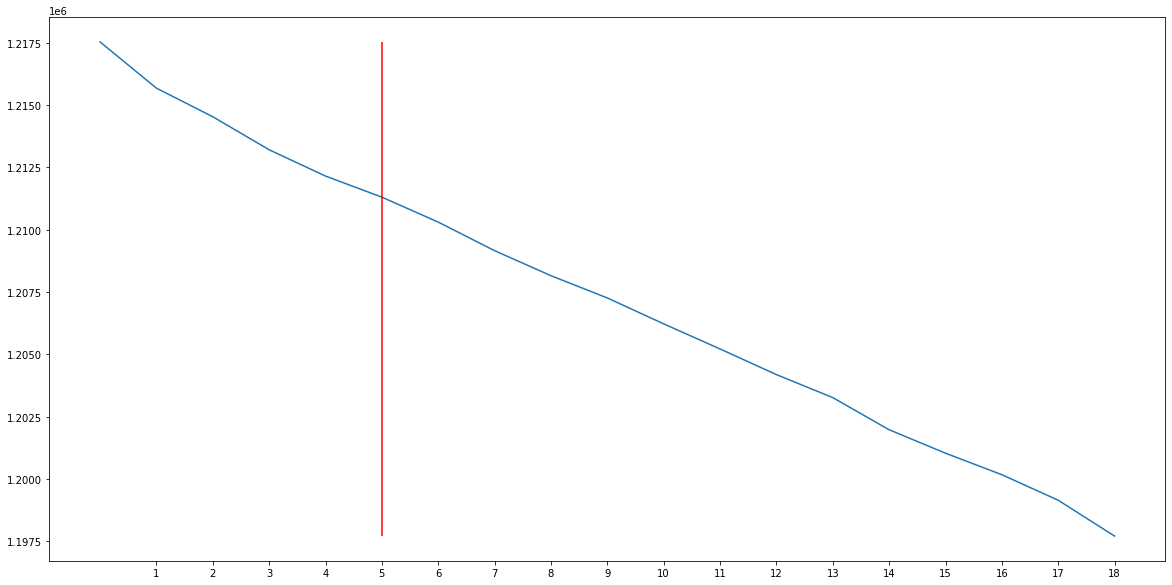

In [285]:
plt.figure(figsize = (20,10))
plt.plot(bic)
plt.xticks(range(1,20))
plt.vlines(5, ymin = min(bic), ymax = max(bic), color = 'red')
plt.show()

In [289]:
kmeans = KMeans(n_clusters = 5, random_state=42)

In [290]:
cluster = kmeans.fit_predict(svd.pu_)

In [291]:
Series(cluster).value_counts()

3    2131
4     929
1     645
2      11
0       9
dtype: int64

i_id   buyerId        38        46        87       160       166       268  \
0       1226.0  0.976156  0.892413  0.999964  1.000000  0.977153  1.000000   
1       1234.0  1.000000  0.923950  1.000000  1.000000  0.997645  1.000000   
2       3112.0  1.000000  1.000000  0.948945  0.667136  1.000000  0.969721   
3       3906.0  1.000000  0.951980  1.000000  0.975269  0.999105  1.000000   
4       5000.0  1.000000  0.898140  1.000000  1.000000  1.000000  1.000000   
...        ...       ...       ...       ...       ...       ...       ...   
3720  173579.0  0.991850  1.000000  1.000000  0.878493  1.000000  1.000000   
3721  173583.0  1.000000  1.000000  0.953448  1.000000  1.000000  0.867144   
3722  173602.0  0.988142  1.000000  1.000000  0.961909  1.000000  1.000000   
3723  173693.0  1.000000  0.807369  1.000000  1.000000  0.984951  1.000000   
3724  173696.0  0.953646  1.000000  0.913807  1.000000  1.000000  0.806580   

i_id       287       297       307  ...     19828     19829     19830  \
0     1.000000  1.000000  1.000000  ...  0.993491  1.000000  1.000000   
1     0.962804  1.000000  0.880749  ...  0.755007  1.000000  0.764223   
2     0.913986  1.000000  0.837632  ...  1.000000  0.933354  0.849178   
3     0.996565  0.981326  0.836508  ...  1.000000  1.000000  1.000000   
4     1.000000  0.887987  1.000000  ...  1.000000  1.000000  1.000000   
...        ...       ...       ...  ...       ...       ...       ...   
3720  0.979757  1.000000  1.000000  ...  0.980386  1.000000  1.000000   
3721  1.000000  0.969679  0.878761  ...  0.779467  0.648485  0.925447   
3722  0.944841  0.991736  0.696751  ...  0.938553  0.779477  1.000000   
3723  1.000000  1.000000  0.744367  ...  0.914344  0.553663  1.000000   
3724  0.951079  0.924799  1.000000  ...  0.986933  1.000000  0.797192   

i_id     19833     19838     19842     19843     19851     19860     19867  
0     1.000000  1.000000  0.770331  1.000000  1.000000  1.000000  1.000000  
1     0.941251  1.000000  0.962011  0.830236  0.497083  0.795440  1.000000  
2     0.896997  0.718794  1.000000  0.857167  0.843289  1.000000  1.000000  
3     1.000000  0.946782  0.970246  0.859791  0.938968  0.987054  1.000000  
4     0.925219  1.000000  0.858432  0.873139  0.668918  0.795575  0.902264  
...        ...       ...       ...       ...       ...       ...       ...  
3720  0.970438  1.000000  0.930047  0.862579  1.000000  1.000000  1.000000  
3721  0.655797  1.000000  0.890236  0.910840  1.000000  0.859981  1.000000  
3722  0.994763  1.000000  1.000000  1.000000  0.991730  1.000000  1.000000  
3723  1.000000  0.580931  0.830636  0.922348  0.718055  0.999783  0.960085  
3724  0.933579  1.000000  1.000000  0.973239  0.757785  1.000000  1.000000  

[3725 rows x 2693 columns]

In [255]:
favorite_pivot_scailing_melt_rev_cluster = favorite_pivot_scailing_melt_rev.copy()

favorite_pivot_scailing_melt_rev_cluster['cluster_kmeans'] = cluster

favorite_pivot_scailing_melt_rev_cluster.columns.name = 'brandId'

In [257]:
cluster_0 = favorite_pivot_scailing_melt_rev_cluster[
    favorite_pivot_scailing_melt_rev_cluster['cluster_kmeans'] == 0].iloc[:,1:-1]

pd.merge(Series(cluster_0.sum().sort_values(ascending=False), name = 'frequency'),
         Series(cluster_0.cumsum().iloc[-1,:] / cluster_0.shape[0], name = 'power'),
         left_index = True, right_index = True)

cluster_0_power = \
pd.merge(cluster_0_power.reset_index(),
         dataframe_seller[['brandId','name']])

cluster_0_power[cluster_0_power['power'] > 0.1]

index  brandId  frequency     power     name
0         0    11877  10.972170  0.997470  메르(MER)
1         1    19666  10.968435  0.997130    아워웨이브
2         2     6012  10.968186  0.997108      드보라
3         3    12970  10.967984  0.997089       솔라
4         4    17314  10.958420  0.996220      데이유
...     ...      ...        ...       ...      ...
2687   2687    19671   8.971281  0.815571   유니온서울 
2688   2688    17504   8.923454  0.811223      오로라
2689   2689     3325   8.817767  0.801615     PPOM
2690   2690     8492   8.771080  0.797371       오리
2691   2691    19236   8.752478  0.795680      빌드업

[2692 rows x 5 columns]

In [ ]:
kmeans = KMeans(n_clusters = 5, random_state=42)

cluster = kmeans.fit_predict(favorite_pivot_scailing.iloc[:,1:])

Series(cluster).value_counts()

In [433]:
csm_total = cosine_similarity(favorite_pivot_scailing_melt_rev.iloc[:,1:])

In [441]:
ind = np.random.randint(0, favorite_pivot.shape[0])

In [442]:
user_user_factorization(favorite_pivot_scailing, 
                        ind, 
                        csm_total,
                        3, 
                        verbose = True)

<1. cosine similarity>
userID : 170493.0 -  0.9110991358777564
userID : 161341.0 -  0.9109130180650986


<2. Top - K user's Category list>
target - 55962.0 {18362, 16715, 17245, 18482, 19224, 18425, 17914, 17885}
UserID - 170493.0 {19616, 10529, 11425, 18469, 10790, 8298, 555, 8876, 16236, 17706, 13429, 19612}
UserID - 161341.0 {8960, 5058, 16707, 9290, 19092, 19482, 9949, 17512, 16874, 683, 18488, 13241, 19323, 9980, 18239}


<3. Top - K User's intersection List>
UserID - 170493.0 set()
UserID - 161341.0 set()


<4. Top - K User's difference List>
UserID - 170493.0 {19616, 10529, 11425, 18469, 10790, 8298, 555, 8876, 16236, 17706, 13429, 19612}
UserID - 161341.0 {8960, 5058, 16707, 17512, 9290, 683, 16874, 19092, 18488, 13241, 19482, 19323, 9980, 9949, 18239}


<5. Top - K User's Product List>
target - 55962.0 



prodName  brandId brandName      cat_0  \
6695                (바배)컨피덴셜 방도 lv 실크    18482        홀리  ACCESSORY   
6783        (바배) 22fw 디올 자카드 캐시미어 머플러    18482        홀리  ACCESSORY   
6973         (바배) 루이비통 레이캬비크 캐시미어 머플러    18482        홀리  ACCESSORY   
7028         22fw (공용) 몽클레어 마리벨레스 덕다운    18482        홀리        MEN   
7030            22fw 지방시 구스 다운 (남녀공용)    18482        홀리      WOMEN   
7055               22fw 몽클 블랙라벨 니트 패딩    18482        홀리        MEN   
7097                            샤 도빌백    18482        홀리  ACCESSORY   
7098    22fw 크롬 가죽패치 포인트 후드 450g (공용)    18482        홀리        MEN   
59412                        샤벨벳팬티스타킹    19224     에쉬그레이  SHOES&ACC   
96385                 C 큐빅버튼 캐시미어 가디건    16715       셀리나      WOMEN   
96387                   C 투포켓 숏 니트 자켓    16715       셀리나      WOMEN   
96391                     큐빅버튼 니트 가디건    16715       셀리나      WOMEN   
96393                명품 블랙 4포켓 트위드 자켓    16715       셀리나      WOMEN   
111308                샤) 제니 캐시 머플러 바배    17914        하이  ACCESSORY   
111349                   샤) CC 캔디백 바배    17914        하이  ACCESSORY   
111351                샤)) CC 러버 부츠 바배    17914        하이      SHOES   
111412                   디) 북토트 라지 바배    17914        하이  ACCESSORY   
112428            샤 디아망 레트로 선글라스 (바배)    17245        엔젤   Eye wear   
112430                       루범백( 바배)    17245        엔젤  ACCESSORY   
130241   천연 뽀글모 트렌디 라인힐 스퀘어 트렌디 -7107    17885     바이앤바이      SHOES   
241854                      프라다 심볼 반지    18362       하이브    JEWELRY   
258772                    구찌 맨투맨 남여공용    18425        랍비      WOMEN   

                cat_1               cat_2  
6695     Fashion Item       Scarf/Muffler  
6783     Fashion Item       Scarf/Muffler  
6973     Fashion Item       Scarf/Muffler  
7028          OUTWEAR              Parkas  
7030          OUTWEAR              Parkas  
7055          OUTWEAR              Parkas  
7097              Bag       Shoulder Bags  
7098             TOPS                Tees  
59412     Accessories                 etc  
96385         OUTWEAR           Cardigans  
96387         OUTWEAR             Jackets  
96391         OUTWEAR           Cardigans  
96393         OUTWEAR             Jackets  
111308   Fashion Item       Scarf/Muffler  
111349            Bag      Crossbody Bags  
111351  women's shoes               Boots  
111412            Bag               Totes  
112428      SHOES&ACC  Sunglasses/Eyewear  
112430            Bag      Crossbody Bags  
130241  women's shoes     sandals / pumps  
241854   jewelry etc.                None  
258772           TOPS                Tees

UserID - 170493.0 



prodName  brandId  brandName      cat_0  \
11014                            루비미니스커트    11425       퍼스트런      WOMEN   
11036                            니드스퀘어니트    11425       퍼스트런      WOMEN   
11052                            폭닥꽈배기니트    11425       퍼스트런      WOMEN   
47751                 (미친폭주)워싱 기모 츄리닝 바지    10529    제이더블유에이      WOMEN   
73473                  스퀘어넥퍼프긴팔니트 SH3208    19612  캐주얼 인 광저우      WOMEN   
83069                            메이비울스커트      555   ahoy 아호이      WOMEN   
140262                             무지목도리    19616         아셀  ACCESSORY   
175659                          멜튼울미니스커트     8876       아이보리      WOMEN   
194786                            에트모노키니    10790        코로나      WOMEN   
194793                           미카엘모노키니    10790        코로나      WOMEN   
194802                            미카모노키니    10790        코로나      WOMEN   
200274  골터치장갑(컬러풀 글로브 겨울 신상 방한 선물 크리스마스)    16236       네온피쉬  ACCESSORY   
202421                      206와이드애쉬연청바지    13429      오즈브릿지      WOMEN   
224754                    (울피치) 굴림 목폴라 티    18469       이사벨라      WOMEN   
256443                          렌틸퍼니트가디건     8298        주스트      WOMEN   
256463                         하운드체크모노키니     8298        주스트      WOMEN   
259734                 니트조거PT) 니트팬츠 조거팬츠    17706        제이인      WOMEN   

               cat_1          cat_2  
11014        BOTTOMS         Skirts  
11036           TOPS       Knitwear  
11052           TOPS       Knitwear  
47751        BOTTOMS          Pants  
73473           TOPS       Knitwear  
83069        BOTTOMS         Skirts  
140262  Fashion Item  Scarf/Muffler  
175659       BOTTOMS         Skirts  
194786     BEACHWEAR           None  
194793     BEACHWEAR           None  
194802     BEACHWEAR           None  
200274  Fashion Item   Gloves/Socks  
202421       BOTTOMS          Denim  
224754          TOPS           Tees  
256443       OUTWEAR      Cardigans  
256463     BEACHWEAR           None  
259734       BOTTOMS   Knit Bottoms

UserID - 161341.0 



prodName  brandId     brandName  \
11179                 겨울신상 레디 부클 자수 조거 트레이닝 후리스 상하 세트    18488         뉴레인보우   
46892                                   글로시패딩#숏패딩#스트링    19482           와이낫   
74716                                D1)컬쳐후드 맨투맨(양기모)      683           아이유   
76370                                       단가라반집업스웨터     9980           유안느   
116527                                    #한두 쭈리 조거팬츠    16874  보네르(bonheur)   
141311                             핏보장)903레트로스트링면조거팬츠    19092          75번가   
199228           프릴티 ( 프릴 언발 크롭 긴팔 봄신상 티셔츠 골지 날라리 스퀘어     9290            노디   
205723                                    컬러스트링팬츠(기모)    17512            폴더   
205726                                          퍼후드집업    17512            폴더   
205728                                         트임스트링티    17512            폴더   
215268                                          호시가디건    19323         마이스타일   
215288                                         골지기모팬츠    19323         마이스타일   
219418                                           영문니트     5058          소이밀크   
226048                                        시보리가죽패딩     8960          에이컨셉   
228094                                          히트반폴라     9949          바비제이   
241915                              골덴팬츠 #신상골덴밴딩팬츠어우터    18239          몬베이커   
254210                                         기모)멍멍H    16707          블랙슈가   
256873  #인기최고#속바지#심플#스판굿#미니#치마바지#빈티지워싱#옆트임#샤샤#흑청#데님치마    13241           블랙번   

        cat_0         cat_1     cat_2  
11179   WOMEN  DRESSES/SETS      Sets  
46892   WOMEN       OUTWEAR    Parkas  
74716   WOMEN          TOPS      Tees  
76370   WOMEN          TOPS  Knitwear  
116527  WOMEN       BOTTOMS     Pants  
141311  WOMEN       BOTTOMS     Pants  
199228  WOMEN          TOPS      Tees  
205723  WOMEN       BOTTOMS     Pants  
205726  WOMEN          TOPS      Tees  
205728  WOMEN          TOPS      Tees  
215268  WOMEN          TOPS  Knitwear  
215288  WOMEN          TOPS  Knitwear  
219418  WOMEN          TOPS  Knitwear  
226048  WOMEN       OUTWEAR    Parkas  
228094  WOMEN          TOPS      Tees  
241915  WOMEN       BOTTOMS     Pants  
254210  WOMEN          TOPS      Tees  
256873  WOMEN       BOTTOMS    Skirts

array([0.91091302, 0.91109914])

In [479]:
perplexity = list()

for i in range(2,20):
    lda = LatentDirichletAllocation(n_components=i, random_state=42)
    lda.fit(favorite_pivot_scailing_melt_rev.iloc[:,1:])
    perplexity.append(lda.perplexity(favorite_pivot_scailing_melt_rev.iloc[:,1:]))



KeyboardInterrupt



In [225]:
DataFrame({'topic_num' : [i for i in range(2,20)],
           'perplexity' : perplexity})

topic_num   perplexity
0           2  1374.404671
1           3  1637.763036
2           4  1830.775547
3           5  2145.005673
4           6  2348.592074
5           7  2689.725200
6           8  2890.846871
7           9  3133.605277
8          10  3384.682835
9          11  3649.260452
10         12  3961.590339
11         13  4278.283280
12         14  4484.715036
13         15  4797.755363
14         16  5152.965053
15         17  5401.328684
16         18  5615.845483
17         19  6092.501835

In [ ]:
perplexity = list()

for i in range(2,20):
    lda = LatentDirichletAllocation(n_components=i, random_state=42)
    lda.fit(favorite_pivot_scailing.iloc[:,1:])
    perplexity.append(lda.perplexity(favoribte_pivot_scailing.iloc[:,1:]))


DataFrame({'topic_num' : [i for i in range(2,20)],
           'perplexity' : perplexity})

## autoencoder

In [691]:
class auto_encoder(tf.keras.Model):
    def __init__(self, 
                 dense_dim):        
        super(auto_encoder, self).__init__()
        self.dense_dim = dense_dim
     
    def build(self, input_shape):
    
        self.input_dense = tf.keras.layers.Dense(self.dense_dim, 
                                      activation = "relu")
        self.dense_input_1 = tf.keras.layers.Dense(int(self.dense_dim / 2),
                                                  activation = "relu")
        self.dense_input_2 = tf.keras.layers.Dense(int(self.dense_dim / 4),
                                                  activation = "relu")
        self.dense_embedding = tf.keras.layers.Dense(int(self.dense_dim / 6),
                                                    activation = "relu")
        self.dropout = tf.keras.layers.Dropout(0.2)
        self.dense_output_1 = tf.keras.layers.Dense(int(self.dense_dim / 4),
                                                  activation = "relu")
        self.dense_output_2 = tf.keras.layers.Dense(int(self.dense_dim / 2),
                                          activation = "relu")
        self.output_dense = tf.keras.layers.Dense(self.dense_dim,
                                                 activation = "relu")
        self.ae_output = tf.keras.layers.Dense(input_shape[-1],
                                      activation = "sigmoid")
    
    def call(self, input_tensor):       
        input_output = self.input_dense(input_tensor)        
        output = self.dense_input_1(input_output)
        #output = self.dense_input_2(output)
        output = self.dense_embedding(output)
        outptu = self.dropout(output)
        output = self.dense_output_1(output)        
        #output = self.dense_output_2(output)        
        output = self.output_dense(output)        
        output = self.ae_output(output)        
        return output

In [366]:
X_train = favorite_pivot_scailing.iloc[:,1:]

In [367]:
AE = auto_encoder(400)

In [368]:
@tf.function()
def training_auto_encoder(inp , tar):
    with tf.GradientTape() as tape:
        
        output = AE(inp)

        loss =  loss_function(tar, output)
    
    gradients = tape.gradient(loss, AE.trainable_variables)
    optimizer.apply_gradients(zip(gradients, AE.trainable_variables))
  
    train_loss(loss)
    train_accuracy(accuracy_function(tar, output))

In [369]:
EPOCHS = 100
batch_size = 50

In [370]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name = "test_loss")
test_accuracy = tf.keras.metrics.Mean(name = "test_accuracy")
 
loss_function = tf.keras.losses.MeanSquaredError(reduction = tf.keras.losses.Reduction.NONE)
accuracy_function = tf.keras.metrics.MeanAbsoluteError()
 
optimizer = tf.keras.optimizers.Adam(lr = 0.01)

In [371]:
for epoch in range(EPOCHS):
    start = time.time()
    i = 1
    while True:

        inp = X_train[(i - 1) * batch_size : (i * batch_size)].copy()
        inp = tf.Variable(inp, dtype = tf.float32)
        tar = X_train[(i - 1) * batch_size : (i * batch_size)]
        tar = tf.Variable(tar, dtype = tf.float32)
        i += 1

        training_auto_encoder(inp, tar)

        if i % 5 == 0:
            print(f'Epoch {epoch + 1} Batch {i} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

        if i > int(len(X_train) / batch_size) :
            print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')
            break

Epoch 1 Batch 5 Loss 0.1129 Accuracy 0.3536
Epoch 1 Batch 10 Loss 0.0670 Accuracy 0.2386
Epoch 1 Batch 15 Loss 0.0522 Accuracy 0.1874
Epoch 1 Batch 20 Loss 0.0460 Accuracy 0.1579
Epoch 1 Batch 25 Loss 0.0426 Accuracy 0.1385
Epoch 1 Batch 30 Loss 0.0402 Accuracy 0.1246
Epoch 1 Batch 35 Loss 0.0374 Accuracy 0.1140
Epoch 1 Batch 40 Loss 0.0353 Accuracy 0.1056
Epoch 1 Batch 45 Loss 0.0334 Accuracy 0.0987
Epoch 1 Batch 50 Loss 0.0317 Accuracy 0.0929
Epoch 1 Batch 55 Loss 0.0302 Accuracy 0.0879
Epoch 1 Batch 60 Loss 0.0286 Accuracy 0.0836
Epoch 1 Batch 65 Loss 0.0270 Accuracy 0.0798
Epoch 1 Batch 70 Loss 0.0255 Accuracy 0.0764
Epoch 1 Batch 75 Loss 0.0241 Accuracy 0.0733
Time taken for 1 epoch: 1.21 secs

Epoch 2 Batch 5 Loss 0.0246 Accuracy 0.0711
Epoch 2 Batch 10 Loss 0.0249 Accuracy 0.0687
Epoch 2 Batch 15 Loss 0.0250 Accuracy 0.0665
Epoch 2 Batch 20 Loss 0.0252 Accuracy 0.0645
Epoch 2 Batch 25 Loss 0.0254 Accuracy 0.0628
Epoch 2 Batch 30 Loss 0.0256 Accuracy 0.0612
Epoch 2 Batch 35 Loss 

Epoch 12 Batch 55 Loss 0.0205 Accuracy 0.0271
Epoch 12 Batch 60 Loss 0.0204 Accuracy 0.0271
Epoch 12 Batch 65 Loss 0.0204 Accuracy 0.0270
Epoch 12 Batch 70 Loss 0.0203 Accuracy 0.0270
Epoch 12 Batch 75 Loss 0.0202 Accuracy 0.0270
Time taken for 1 epoch: 0.87 secs

Epoch 13 Batch 5 Loss 0.0203 Accuracy 0.0269
Epoch 13 Batch 10 Loss 0.0203 Accuracy 0.0269
Epoch 13 Batch 15 Loss 0.0203 Accuracy 0.0269
Epoch 13 Batch 20 Loss 0.0204 Accuracy 0.0268
Epoch 13 Batch 25 Loss 0.0204 Accuracy 0.0268
Epoch 13 Batch 30 Loss 0.0205 Accuracy 0.0268
Epoch 13 Batch 35 Loss 0.0205 Accuracy 0.0267
Epoch 13 Batch 40 Loss 0.0205 Accuracy 0.0267
Epoch 13 Batch 45 Loss 0.0205 Accuracy 0.0267
Epoch 13 Batch 50 Loss 0.0205 Accuracy 0.0266
Epoch 13 Batch 55 Loss 0.0204 Accuracy 0.0266
Epoch 13 Batch 60 Loss 0.0204 Accuracy 0.0266
Epoch 13 Batch 65 Loss 0.0203 Accuracy 0.0265
Epoch 13 Batch 70 Loss 0.0202 Accuracy 0.0265
Epoch 13 Batch 75 Loss 0.0202 Accuracy 0.0265
Time taken for 1 epoch: 0.85 secs

Epoch 14 Ba

Epoch 24 Batch 20 Loss 0.0201 Accuracy 0.0239
Epoch 24 Batch 25 Loss 0.0202 Accuracy 0.0239
Epoch 24 Batch 30 Loss 0.0202 Accuracy 0.0239
Epoch 24 Batch 35 Loss 0.0202 Accuracy 0.0238
Epoch 24 Batch 40 Loss 0.0202 Accuracy 0.0238
Epoch 24 Batch 45 Loss 0.0202 Accuracy 0.0238
Epoch 24 Batch 50 Loss 0.0202 Accuracy 0.0238
Epoch 24 Batch 55 Loss 0.0202 Accuracy 0.0238
Epoch 24 Batch 60 Loss 0.0201 Accuracy 0.0238
Epoch 24 Batch 65 Loss 0.0201 Accuracy 0.0238
Epoch 24 Batch 70 Loss 0.0201 Accuracy 0.0238
Epoch 24 Batch 75 Loss 0.0200 Accuracy 0.0238
Time taken for 1 epoch: 0.84 secs

Epoch 25 Batch 5 Loss 0.0200 Accuracy 0.0238
Epoch 25 Batch 10 Loss 0.0201 Accuracy 0.0237
Epoch 25 Batch 15 Loss 0.0201 Accuracy 0.0237
Epoch 25 Batch 20 Loss 0.0201 Accuracy 0.0237
Epoch 25 Batch 25 Loss 0.0201 Accuracy 0.0237
Epoch 25 Batch 30 Loss 0.0202 Accuracy 0.0237
Epoch 25 Batch 35 Loss 0.0202 Accuracy 0.0237
Epoch 25 Batch 40 Loss 0.0202 Accuracy 0.0237
Epoch 25 Batch 45 Loss 0.0202 Accuracy 0.0237


Epoch 35 Batch 45 Loss 0.0201 Accuracy 0.0227
Epoch 35 Batch 50 Loss 0.0201 Accuracy 0.0227
Epoch 35 Batch 55 Loss 0.0201 Accuracy 0.0227
Epoch 35 Batch 60 Loss 0.0200 Accuracy 0.0227
Epoch 35 Batch 65 Loss 0.0200 Accuracy 0.0227
Epoch 35 Batch 70 Loss 0.0200 Accuracy 0.0227
Epoch 35 Batch 75 Loss 0.0200 Accuracy 0.0227
Time taken for 1 epoch: 0.83 secs

Epoch 36 Batch 5 Loss 0.0200 Accuracy 0.0227
Epoch 36 Batch 10 Loss 0.0200 Accuracy 0.0227
Epoch 36 Batch 15 Loss 0.0200 Accuracy 0.0227
Epoch 36 Batch 20 Loss 0.0200 Accuracy 0.0227
Epoch 36 Batch 25 Loss 0.0200 Accuracy 0.0226
Epoch 36 Batch 30 Loss 0.0201 Accuracy 0.0226
Epoch 36 Batch 35 Loss 0.0201 Accuracy 0.0226
Epoch 36 Batch 40 Loss 0.0201 Accuracy 0.0226
Epoch 36 Batch 45 Loss 0.0201 Accuracy 0.0226
Epoch 36 Batch 50 Loss 0.0201 Accuracy 0.0226
Epoch 36 Batch 55 Loss 0.0200 Accuracy 0.0226
Epoch 36 Batch 60 Loss 0.0200 Accuracy 0.0226
Epoch 36 Batch 65 Loss 0.0200 Accuracy 0.0226
Epoch 36 Batch 70 Loss 0.0200 Accuracy 0.0226


Epoch 47 Batch 10 Loss 0.0200 Accuracy 0.0221
Epoch 47 Batch 15 Loss 0.0200 Accuracy 0.0221
Epoch 47 Batch 20 Loss 0.0200 Accuracy 0.0221
Epoch 47 Batch 25 Loss 0.0200 Accuracy 0.0221
Epoch 47 Batch 30 Loss 0.0200 Accuracy 0.0221
Epoch 47 Batch 35 Loss 0.0200 Accuracy 0.0220
Epoch 47 Batch 40 Loss 0.0200 Accuracy 0.0220
Epoch 47 Batch 45 Loss 0.0200 Accuracy 0.0220
Epoch 47 Batch 50 Loss 0.0200 Accuracy 0.0220
Epoch 47 Batch 55 Loss 0.0200 Accuracy 0.0220
Epoch 47 Batch 60 Loss 0.0200 Accuracy 0.0220
Epoch 47 Batch 65 Loss 0.0200 Accuracy 0.0220
Epoch 47 Batch 70 Loss 0.0199 Accuracy 0.0220
Epoch 47 Batch 75 Loss 0.0199 Accuracy 0.0220
Time taken for 1 epoch: 0.92 secs

Epoch 48 Batch 5 Loss 0.0199 Accuracy 0.0220
Epoch 48 Batch 10 Loss 0.0200 Accuracy 0.0220
Epoch 48 Batch 15 Loss 0.0200 Accuracy 0.0220
Epoch 48 Batch 20 Loss 0.0200 Accuracy 0.0220
Epoch 48 Batch 25 Loss 0.0200 Accuracy 0.0220
Epoch 48 Batch 30 Loss 0.0200 Accuracy 0.0220
Epoch 48 Batch 35 Loss 0.0200 Accuracy 0.0220


Epoch 58 Batch 40 Loss 0.0200 Accuracy 0.0217
Epoch 58 Batch 45 Loss 0.0200 Accuracy 0.0217
Epoch 58 Batch 50 Loss 0.0200 Accuracy 0.0217
Epoch 58 Batch 55 Loss 0.0200 Accuracy 0.0217
Epoch 58 Batch 60 Loss 0.0200 Accuracy 0.0217
Epoch 58 Batch 65 Loss 0.0199 Accuracy 0.0217
Epoch 58 Batch 70 Loss 0.0199 Accuracy 0.0217
Epoch 58 Batch 75 Loss 0.0199 Accuracy 0.0217
Time taken for 1 epoch: 0.88 secs

Epoch 59 Batch 5 Loss 0.0199 Accuracy 0.0217
Epoch 59 Batch 10 Loss 0.0199 Accuracy 0.0217
Epoch 59 Batch 15 Loss 0.0199 Accuracy 0.0217
Epoch 59 Batch 20 Loss 0.0200 Accuracy 0.0217
Epoch 59 Batch 25 Loss 0.0200 Accuracy 0.0216
Epoch 59 Batch 30 Loss 0.0200 Accuracy 0.0216
Epoch 59 Batch 35 Loss 0.0200 Accuracy 0.0216
Epoch 59 Batch 40 Loss 0.0200 Accuracy 0.0216
Epoch 59 Batch 45 Loss 0.0200 Accuracy 0.0216
Epoch 59 Batch 50 Loss 0.0200 Accuracy 0.0216
Epoch 59 Batch 55 Loss 0.0200 Accuracy 0.0216
Epoch 59 Batch 60 Loss 0.0200 Accuracy 0.0216
Epoch 59 Batch 65 Loss 0.0199 Accuracy 0.0216


Epoch 69 Batch 65 Loss 0.0199 Accuracy 0.0214
Epoch 69 Batch 70 Loss 0.0199 Accuracy 0.0214
Epoch 69 Batch 75 Loss 0.0199 Accuracy 0.0214
Time taken for 1 epoch: 0.84 secs

Epoch 70 Batch 5 Loss 0.0199 Accuracy 0.0214
Epoch 70 Batch 10 Loss 0.0199 Accuracy 0.0214
Epoch 70 Batch 15 Loss 0.0199 Accuracy 0.0214
Epoch 70 Batch 20 Loss 0.0199 Accuracy 0.0214
Epoch 70 Batch 25 Loss 0.0199 Accuracy 0.0214
Epoch 70 Batch 30 Loss 0.0200 Accuracy 0.0214
Epoch 70 Batch 35 Loss 0.0200 Accuracy 0.0214
Epoch 70 Batch 40 Loss 0.0200 Accuracy 0.0214
Epoch 70 Batch 45 Loss 0.0200 Accuracy 0.0214
Epoch 70 Batch 50 Loss 0.0199 Accuracy 0.0214
Epoch 70 Batch 55 Loss 0.0199 Accuracy 0.0214
Epoch 70 Batch 60 Loss 0.0199 Accuracy 0.0214
Epoch 70 Batch 65 Loss 0.0199 Accuracy 0.0214
Epoch 70 Batch 70 Loss 0.0199 Accuracy 0.0214
Epoch 70 Batch 75 Loss 0.0199 Accuracy 0.0214
Time taken for 1 epoch: 0.84 secs

Epoch 71 Batch 5 Loss 0.0199 Accuracy 0.0214
Epoch 71 Batch 10 Loss 0.0199 Accuracy 0.0214
Epoch 71 Bat

Epoch 81 Batch 30 Loss 0.0199 Accuracy 0.0212
Epoch 81 Batch 35 Loss 0.0199 Accuracy 0.0212
Epoch 81 Batch 40 Loss 0.0199 Accuracy 0.0212
Epoch 81 Batch 45 Loss 0.0199 Accuracy 0.0212
Epoch 81 Batch 50 Loss 0.0199 Accuracy 0.0212
Epoch 81 Batch 55 Loss 0.0199 Accuracy 0.0212
Epoch 81 Batch 60 Loss 0.0199 Accuracy 0.0212
Epoch 81 Batch 65 Loss 0.0199 Accuracy 0.0212
Epoch 81 Batch 70 Loss 0.0199 Accuracy 0.0212
Epoch 81 Batch 75 Loss 0.0199 Accuracy 0.0212
Time taken for 1 epoch: 0.84 secs

Epoch 82 Batch 5 Loss 0.0199 Accuracy 0.0212
Epoch 82 Batch 10 Loss 0.0199 Accuracy 0.0212
Epoch 82 Batch 15 Loss 0.0199 Accuracy 0.0212
Epoch 82 Batch 20 Loss 0.0199 Accuracy 0.0212
Epoch 82 Batch 25 Loss 0.0199 Accuracy 0.0212
Epoch 82 Batch 30 Loss 0.0199 Accuracy 0.0212
Epoch 82 Batch 35 Loss 0.0199 Accuracy 0.0212
Epoch 82 Batch 40 Loss 0.0199 Accuracy 0.0212
Epoch 82 Batch 45 Loss 0.0199 Accuracy 0.0212
Epoch 82 Batch 50 Loss 0.0199 Accuracy 0.0212
Epoch 82 Batch 55 Loss 0.0199 Accuracy 0.0212


Epoch 92 Batch 65 Loss 0.0199 Accuracy 0.0211
Epoch 92 Batch 70 Loss 0.0199 Accuracy 0.0211
Epoch 92 Batch 75 Loss 0.0199 Accuracy 0.0210
Time taken for 1 epoch: 0.87 secs

Epoch 93 Batch 5 Loss 0.0199 Accuracy 0.0210
Epoch 93 Batch 10 Loss 0.0199 Accuracy 0.0210
Epoch 93 Batch 15 Loss 0.0199 Accuracy 0.0210
Epoch 93 Batch 20 Loss 0.0199 Accuracy 0.0210
Epoch 93 Batch 25 Loss 0.0199 Accuracy 0.0210
Epoch 93 Batch 30 Loss 0.0199 Accuracy 0.0210
Epoch 93 Batch 35 Loss 0.0199 Accuracy 0.0210
Epoch 93 Batch 40 Loss 0.0199 Accuracy 0.0210
Epoch 93 Batch 45 Loss 0.0199 Accuracy 0.0210
Epoch 93 Batch 50 Loss 0.0199 Accuracy 0.0210
Epoch 93 Batch 55 Loss 0.0199 Accuracy 0.0210
Epoch 93 Batch 60 Loss 0.0199 Accuracy 0.0210
Epoch 93 Batch 65 Loss 0.0199 Accuracy 0.0210
Epoch 93 Batch 70 Loss 0.0199 Accuracy 0.0210
Epoch 93 Batch 75 Loss 0.0199 Accuracy 0.0210
Time taken for 1 epoch: 0.87 secs

Epoch 94 Batch 5 Loss 0.0199 Accuracy 0.0210
Epoch 94 Batch 10 Loss 0.0199 Accuracy 0.0210
Epoch 94 Bat

In [379]:
pred = AE(X_train.to_numpy())

In [384]:
[np.where(pred[i,:] > 0.5) for i in range(0,3725)]

[(array([336, 354, 560], dtype=int64),),
 (array([336, 354, 560], dtype=int64),),
 (array([336, 354, 560], dtype=int64),),
 (array([336, 354, 560], dtype=int64),),
 (array([336, 354, 560], dtype=int64),),
 (array([336, 354, 560], dtype=int64),),
 (array([336, 354, 560], dtype=int64),),
 (array([336, 354, 560], dtype=int64),),
 (array([336, 354, 560], dtype=int64),),
 (array([336, 354, 560], dtype=int64),),
 (array([336, 354, 560], dtype=int64),),
 (array([336, 354, 560], dtype=int64),),
 (array([336, 354, 560], dtype=int64),),
 (array([336, 354, 560], dtype=int64),),
 (array([336, 354, 560], dtype=int64),),
 (array([336, 354, 560], dtype=int64),),
 (array([336, 354, 560], dtype=int64),),
 (array([336, 354, 560], dtype=int64),),
 (array([336, 354, 560], dtype=int64),),
 (array([336, 354, 560], dtype=int64),),
 (array([336, 354, 560], dtype=int64),),
 (array([336, 354, 560], dtype=int64),),
 (array([336, 354, 560], dtype=int64),),
 (array([336, 354, 560], dtype=int64),),
 (array([336, 35

In [385]:
[np.where(X_train.to_numpy()[i,:] == 1) for i in range(0,3725)]

[(array([ 168,  204,  330,  350,  351,  352,  354,  369,  394,  395,  441,
          504,  532,  560,  571,  593,  594,  596,  743,  764,  796,  815,
          844,  858,  865,  954, 1028, 1045, 1057, 1065, 1074, 1138, 1166,
         1198, 1208, 1213, 1224, 1239, 1303, 1306, 1333, 1338, 1442, 1498,
         1522, 1531, 1546, 1559, 1565, 1603, 1654, 1663, 1678, 1692, 1717,
         1842, 1864, 1887, 2030, 2071, 2092, 2105, 2185, 2217, 2302, 2339,
         2393, 2507, 2554], dtype=int64),),
 (array([ 128,  183,  354,  976, 1042, 1085, 1399, 1528, 1535, 1848, 1938,
         2113, 2122, 2150, 2202], dtype=int64),),
 (array([ 325,  369,  564,  796,  955, 1158, 1240, 1503, 1750, 1943, 2045,
         2204], dtype=int64),),
 (array([   0,    4,    9,   22,   36,   37,   48,   52,   87,  108,  128,
          130,  137,  139,  149,  160,  163,  165,  168,  171,  174,  177,
          180,  181,  198,  201,  204,  208,  220,  221,  222,  226,  233,
          234,  238,  242,  243,  244,  251,  267

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Evaluation

<AxesSubplot:>

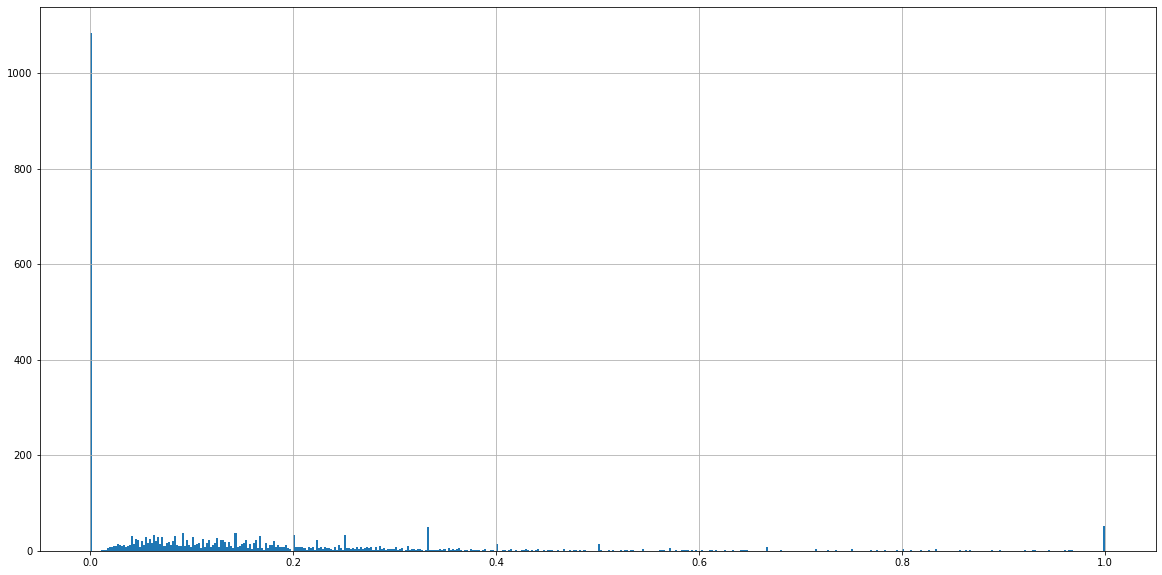

In [183]:
plt.figure(figsize = (20,10))
DataFrame(evaluation.values())['precision'].hist(bins  = 500)

In [184]:
plt.figure(figsize = (20,10))
DataFrame(evaluation.values())['recall'].hist(bins  = 500)

<AxesSubplot:>

In [202]:
(DataFrame(evaluation.values())['precision'] == 0).value_counts()

False    3038
True     1446
Name: precision, dtype: int64

In [203]:
(DataFrame(evaluation.values())['recall'] == 0).value_counts()

False    3038
True     1446
Name: recall, dtype: int64

In [206]:
((DataFrame(evaluation.values())['precision'] == 0) & (DataFrame(evaluation.values())['recall'] == 0)).value_counts()

False    3038
True     1446
dtype: int64

In [217]:
false_ind = \
DataFrame(evaluation.values())[
    (DataFrame(evaluation.values())['precision'] == 0) & (DataFrame(evaluation.values())['recall'] == 0)].index

In [ ]:
false_ind = false_ind.tolist()

In [289]:
ind = false_ind.pop()

In [290]:
b = user_user_factorization(favorite_pivot, 
                        orderseries_merchandise,
                        ind, 
                        csm_total,
                        20, 
                        threshold = 0.2,
                        verbose = False)

b['cats'] = b['cat_0'] + b['cat_1'] + b['cat_2']
b['values'] = 1
product_profile = b.pivot_table(index = 'productId',
                                columns = 'cats',
                                values = 'values').fillna(0).reset_index()

prod_id = b.loc[b['buyerId'] == b['buyerId'].unique()[0]]['productId'].astype('int').values
product_profile = product_profile.astype({'productId' : int})
csm = cosine_similarity(product_profile.iloc[:,1:])
csm -= np.eye(csm.shape[0])
targetprod, prod, img = profiling_prepare(product_profile, 
                              orderseries_merchandise,
                              prod_id, 
                              csm, 
                              k = 5,
                              verbose = False, 
                              image = False,
                              threshold = 1)

prod_final, img = merchandise_profiling(prod, 
                                       wishes_coo, 
                                       productId_dict,
                                       k = 5,
                                       image = True,
                                       sort_col = ['param'])

In [291]:
HTML(img.to_html(escape=False))